In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn.ensemble import RandomForestClassifier


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [4]:
p = Pipeline.objects.all()[60]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: new dummy ugs opt
DataSource: 20190228 unbalanced train size=3443
NLP Tool: Frog + TFIDF
Classifier: Support Vector
Task status: Status.SUCCESS


In [5]:
len(p.data_source.articles)

3099

In [6]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [7]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7fb649a7d290>),
 ('StopWordRemoval',
  <newsgac.nlp_tools.transformers.StopWordRemoval at 0x7fb649a7d490>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('frog', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7fb649d38d10>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7fb649d38d50>), ('Sentiment', Pipeline(memory=None,
       steps=...\b', tokenizer=None, use_idf=True,
          vocabulary=None))]))],
         transformer_weights=None))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [8]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [9]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [10]:
X_train = X
y_train = labels
y_test = labels_test

In [11]:
y_test.shape

(344,)

In [12]:
criterion_list = ['gini', 'entropy']
n_estimators_list = np.arange(1, 1000, 1, dtype=int)
max_features_list = np.arange(1, X_train.shape[1], 1, dtype=int) 
max_depth_list = np.arange(1, 50, 1, dtype=int) 
min_samples_split_list = np.arange(10, 100, 10, dtype=int)
min_samples_leaf_list = np.arange(1, 30, 1, dtype=int)
max_leaf_nodes_list = np.arange(10, 30, 2, dtype=int)
class_weights = [None, 'balanced']
bootstrap_list =[True, False]


In [13]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'criterion': hp.choice('criterion', criterion_list),
        'n_estimators': hp.choice('n_estimators', n_estimators_list),
        'max_features': hp.choice('max_features', max_features_list),
        'max_depth': hp.choice('max_depth', max_depth_list),
        'min_samples_split': hp.choice('min_samples_split', min_samples_split_list),
        'min_samples_leaf': hp.choice('min_samples_leaf', min_samples_leaf_list),
        'max_leaf_nodes': hp.choice('max_leaf_nodes', max_leaf_nodes_list),
        'class_weight': hp.choice('class_weight', class_weights),
        'bootstrap': hp.choice('bootstrap', bootstrap_list)
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [14]:
# def train_test_split_w_sampling(X, y, sampling_method, test_size):
#     if sampling_method == 'under-sampling':
#         random_under_sampler = RandomUnderSampler(ratio='majority', random_state=0)
#         X, y = random_under_sampler.fit_sample(X, y)

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'over-sampling':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         random_over_sampler = RandomOverSampler(ratio='minority', random_state=0)
#         X_train, y_train = random_over_sampler.fit_sample(X_train, y_train)

#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'smote':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         smote = SMOTE(random_state=0, n_jobs=6)
#         X_train, y_train = smote.fit_sample(X_train, y_train)
        
#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'smote_enn':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         smote_enn = SMOTEENN(random_state=0)
#         X_train, y_train = smote_enn.fit_sample(X_train, y_train)
        
#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'smote_tomek':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         smote_tomek = SMOTETomek(random_state=0)
#         X_train, y_train = smote_tomek.fit_sample(X_train, y_train)
        
#         return X_train, X_test, y_train, y_test
#     else:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
        
#         return X_train, X_test, y_train, y_test

In [15]:
# X_train, X_test, y_train, y_test = train_test_split_w_sampling(X, labels, 'no sampling', 0.1)
# X_train, X_test, y_train, y_test = train_test_split_w_sampling(X, labels, 'under-sampling', 0.33)

In [16]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    criterion = params['criterion']
    n_estimators = params['n_estimators']
    max_features = params['max_features']
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    min_samples_leaf = params['min_samples_leaf']
    max_leaf_nodes = params['max_leaf_nodes']
    class_weight = params['class_weight']
    bootstrap = params['bootstrap']
    
    model = RandomForestClassifier(criterion=criterion, n_estimators=n_estimators, max_features=max_features,
                                  max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                  max_leaf_nodes=max_leaf_nodes, class_weight=class_weight, bootstrap=bootstrap,
                                  random_state=42, n_jobs=48)
#     model = RandomForestClassifier(criterion=criterion)
    
    model.fit(X_train, y_train)
    labels_prediction = model.predict(X_test)
    labels_probs = model.predict_proba(X_test)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, labels_prediction)
    test_loss = log_loss(y_test, labels_probs)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [17]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['criterion'] = criterion_list[best_param['criterion']]
best_param['max_leaf_nodes'] = max_leaf_nodes_list[best_param['max_leaf_nodes']]
best_param['min_samples_leaf'] = min_samples_leaf_list[best_param['min_samples_leaf']]
best_param['n_estimators'] = n_estimators_list[best_param['n_estimators']]
best_param['max_features'] = max_features_list[best_param['max_features']]
best_param['min_samples_split'] = min_samples_split_list[best_param['min_samples_split']]
best_param['max_depth'] = max_depth_list[best_param['max_depth']]
best_param['class_weight'] = class_weights[best_param['class_weight']]
best_param['bootstrap'] = bootstrap_list[best_param['bootstrap']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.348499515973 and loss 2.15783311966 :

  0%|          | 0/1000 [00:06<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.276162790698 and loss 2.23063312078 :

  0%|          | 0/1000 [00:06<?, ?it/s, best loss: ?]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 290, 'max_features': 1618, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 7, 'class_weight': 'balanced'}

  0%|          | 0/1000 [00:06<?, ?it/s, best loss: ?]

Hyperopt:   0%|          | 1/1000 [00:17<4:44:07, 17.06s/it]


  0%|          | 1/1000 [00:06<1:55:41,  6.95s/it, best loss: -0.276162790698]
Parameters with this training accuracy 0.656986124556 and loss 1.14555789587 :

  0%|          | 1/1000 [00:18<1:55:41,  6.95s/it, best loss: -0.276162790698]
Parameters with this testing accuracy 0.578488372093 and loss 1.30811562884 :

  0%|          | 1/1000 [00:18<1:55:41,  6.95s/it, best loss: -0.276162790698]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 770, 'max_features': 7890, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 16, 'class_weight': None}

  0%|          | 1/1000 [00:18<1:55:41,  6.95s/it, best loss: -0.276162790698]

Hyperopt:   0%|          | 2/1000 [00:28<4:14:41, 15.31s/it]


  0%|          | 2/1000 [00:18<2:16:55,  8.23s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.644401419813 and loss 1.19132997239 :

  0%|          | 2/1000 [00:23<2:16:55,  8.23s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.59011627907 and loss 1.33624370354 :

  0%|          | 2/1000 [00:23<2:16:55,  8.23s/it, best loss: -0.578488372093]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 174, 'max_features': 9033, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 31, 'class_weight': None}

  0%|          | 2/1000 [00:23<2:16:55,  8.23s/it, best loss: -0.578488372093]

Hyperopt:   0%|          | 3/1000 [00:33<3:25:55, 12.39s/it]


  0%|          | 3/1000 [00:23<2:03:32,  7.44s/it, best loss: -0.59011627907] 
Parameters with this training accuracy 0.412391093901 and loss 1.91936086985 :

  0%|          | 3/1000 [01:12<2:03:32,  7.44s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.369186046512 and loss 2.07131264053 :

  0%|          | 3/1000 [01:12<2:03:32,  7.44s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 951, 'max_features': 25870, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 7, 'class_weight': 'balanced'}

  0%|          | 3/1000 [01:12<2:03:32,  7.44s/it, best loss: -0.59011627907]

Hyperopt:   0%|          | 4/1000 [01:22<6:27:55, 23.37s/it]


  0%|          | 4/1000 [01:12<5:30:19, 19.90s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.610519522427 and loss 1.32241340181 :

  0%|          | 4/1000 [01:21<5:30:19, 19.90s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.41658056394 :

  0%|          | 4/1000 [01:21<5:30:19, 19.90s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 464, 'max_features': 10557, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 13, 'class_weight': None}

  0%|          | 4/1000 [01:21<5:30:19, 19.90s/it, best loss: -0.59011627907]

Hyperopt:   0%|          | 5/1000 [01:32<5:17:09, 19.12s/it]


  0%|          | 5/1000 [01:21<4:36:52, 16.70s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.346240722814 and loss 2.10819423507 :

  0%|          | 5/1000 [01:37<4:36:52, 16.70s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.334302325581 and loss 2.16270355949 :

  0%|          | 5/1000 [01:37<4:36:52, 16.70s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 795, 'max_features': 20483, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 2, 'class_weight': 'balanced'}

  0%|          | 5/1000 [01:37<4:36:52, 16.70s/it, best loss: -0.59011627907]

Hyperopt:   1%|          | 6/1000 [01:47<4:59:07, 18.06s/it]


  1%|          | 6/1000 [01:37<4:30:57, 16.36s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.535979348177 and loss 1.68836798107 :

  1%|          | 6/1000 [01:55<4:30:57, 16.36s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.459302325581 and loss 1.82534684452 :

  1%|          | 6/1000 [01:55<4:30:57, 16.36s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 993, 'max_features': 18789, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': 'balanced'}

  1%|          | 6/1000 [01:55<4:30:57, 16.36s/it, best loss: -0.59011627907]

Hyperopt:   1%|          | 7/1000 [02:05<4:59:18, 18.09s/it]


  1%|          | 7/1000 [01:55<4:39:37, 16.90s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.623426911907 and loss 1.24975090048 :

  1%|          | 7/1000 [02:03<4:39:37, 16.90s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.35888245378 :

  1%|          | 7/1000 [02:03<4:39:37, 16.90s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 540, 'max_features': 11654, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 10, 'class_weight': None}

  1%|          | 7/1000 [02:03<4:39:37, 16.90s/it, best loss: -0.59011627907]

Hyperopt:   1%|          | 8/1000 [02:14<4:10:34, 15.16s/it]


  1%|          | 8/1000 [02:03<3:56:47, 14.32s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.581800580833 and loss 1.32186815488 :

  1%|          | 8/1000 [02:24<3:56:47, 14.32s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.37861235592 :

  1%|          | 8/1000 [02:24<3:56:47, 14.32s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 12, 'n_estimators': 519, 'max_features': 20569, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 17, 'class_weight': None}

  1%|          | 8/1000 [02:24<3:56:47, 14.32s/it, best loss: -0.59011627907]

Hyperopt:   1%|          | 9/1000 [02:35<4:39:16, 16.91s/it]


  1%|          | 9/1000 [02:24<4:29:39, 16.33s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.470151661826 and loss 1.91119676832 :

  1%|          | 9/1000 [02:32<4:29:39, 16.33s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.380813953488 and loss 2.04138011236 :

  1%|          | 9/1000 [02:32<4:29:39, 16.33s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 383, 'max_features': 3128, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 16, 'class_weight': 'balanced'}

  1%|          | 9/1000 [02:32<4:29:39, 16.33s/it, best loss: -0.59011627907]

Hyperopt:   1%|          | 10/1000 [02:42<3:51:10, 14.01s/it]


  1%|          | 10/1000 [02:32<3:44:26, 13.60s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.412068409164 and loss 1.95014300501 :

  1%|          | 10/1000 [02:57<3:44:26, 13.60s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.348837209302 and loss 2.04109325091 :

  1%|          | 10/1000 [02:57<3:44:26, 13.60s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 15, 'n_estimators': 782, 'max_features': 16991, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 11, 'class_weight': 'balanced'}

  1%|          | 10/1000 [02:57<3:44:26, 13.60s/it, best loss: -0.59011627907]

Hyperopt:   1%|          | 11/1000 [03:08<4:49:05, 17.54s/it]


  1%|          | 11/1000 [02:58<4:44:22, 17.25s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.603097773475 and loss 1.25262349981 :

  1%|          | 11/1000 [03:18<4:44:22, 17.25s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.33338176051 :

  1%|          | 11/1000 [03:18<4:44:22, 17.25s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 571, 'max_features': 9720, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 15, 'class_weight': None}

  1%|          | 11/1000 [03:18<4:44:22, 17.25s/it, best loss: -0.59011627907]

Hyperopt:   1%|          | 12/1000 [03:28<5:02:34, 18.37s/it]


  1%|          | 12/1000 [03:18<4:59:16, 18.17s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.555017747661 and loss 1.41149256895 :

  1%|          | 12/1000 [03:31<4:59:16, 18.17s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.523255813953 and loss 1.43457409253 :

  1%|          | 12/1000 [03:31<4:59:16, 18.17s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 602, 'max_features': 12496, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 2, 'class_weight': None}

  1%|          | 12/1000 [03:31<4:59:16, 18.17s/it, best loss: -0.59011627907]

Hyperopt:   1%|▏         | 13/1000 [03:41<4:34:54, 16.71s/it]


  1%|▏         | 13/1000 [03:31<4:32:35, 16.57s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.465634075508 and loss 1.87340516972 :

  1%|▏         | 13/1000 [03:52<4:32:35, 16.57s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.40988372093 and loss 1.97265880504 :

  1%|▏         | 13/1000 [03:52<4:32:35, 16.57s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 699, 'max_features': 20239, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': 'balanced'}

  1%|▏         | 13/1000 [03:52<4:32:35, 16.57s/it, best loss: -0.59011627907]

Hyperopt:   1%|▏         | 14/1000 [04:02<4:58:39, 18.17s/it]


  1%|▏         | 14/1000 [03:52<4:57:02, 18.08s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.442400774443 and loss 1.9842541744 :

  1%|▏         | 14/1000 [03:57<4:57:02, 18.08s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.404069767442 and loss 2.07715833789 :

  1%|▏         | 14/1000 [03:57<4:57:02, 18.08s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 13, 'max_features': 6990, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 37, 'class_weight': 'balanced'}

  1%|▏         | 14/1000 [03:57<4:57:02, 18.08s/it, best loss: -0.59011627907]

Hyperopt:   2%|▏         | 15/1000 [04:07<3:51:38, 14.11s/it]


  2%|▏         | 15/1000 [03:57<3:50:29, 14.04s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.650209745079 and loss 1.14451593491 :

  2%|▏         | 15/1000 [04:07<3:50:29, 14.04s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.59011627907 and loss 1.31520283851 :

  2%|▏         | 15/1000 [04:07<3:50:29, 14.04s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 475, 'max_features': 8881, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 31, 'class_weight': None}

  2%|▏         | 15/1000 [04:07<3:50:29, 14.04s/it, best loss: -0.59011627907]

Hyperopt:   2%|▏         | 16/1000 [04:17<3:31:08, 12.87s/it]


  2%|▏         | 16/1000 [04:07<3:30:21, 12.83s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.67602452404 and loss 1.09049605136 :

  2%|▏         | 16/1000 [04:13<3:30:21, 12.83s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.604651162791 and loss 1.29063502298 :

  2%|▏         | 16/1000 [04:13<3:30:21, 12.83s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 128, 'max_features': 12119, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 48, 'class_weight': None}

  2%|▏         | 16/1000 [04:14<3:30:21, 12.83s/it, best loss: -0.59011627907]

Hyperopt:   2%|▏         | 17/1000 [04:24<3:00:17, 11.00s/it]


  2%|▏         | 17/1000 [04:14<2:59:43, 10.97s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.572765408196 and loss 1.26007629366 :

  2%|▏         | 17/1000 [04:23<2:59:43, 10.97s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.546511627907 and loss 1.36290538685 :

  2%|▏         | 17/1000 [04:23<2:59:43, 10.97s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 548, 'max_features': 1380, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 9, 'class_weight': None}

  2%|▏         | 17/1000 [04:23<2:59:43, 10.97s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 18/1000 [04:33<2:51:41, 10.49s/it]


  2%|▏         | 18/1000 [04:23<2:51:18, 10.47s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.469828977089 and loss 1.8153315064 :

  2%|▏         | 18/1000 [04:33<2:51:18, 10.47s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.369186046512 and loss 1.96292562705 :

  2%|▏         | 18/1000 [04:33<2:51:18, 10.47s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 24, 'n_estimators': 288, 'max_features': 10106, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 40, 'class_weight': 'balanced'}

  2%|▏         | 18/1000 [04:33<2:51:18, 10.47s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 19/1000 [04:43<2:51:00, 10.46s/it]


  2%|▏         | 19/1000 [04:33<2:50:43, 10.44s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.6198773798 and loss 1.18549995097 :

  2%|▏         | 19/1000 [04:53<2:50:43, 10.44s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.566860465116 and loss 1.29444491067 :

  2%|▏         | 19/1000 [04:53<2:50:43, 10.44s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 23, 'n_estimators': 494, 'max_features': 20083, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 5, 'class_weight': None}

  2%|▏         | 19/1000 [04:53<2:50:43, 10.44s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 20/1000 [05:03<3:34:47, 13.15s/it]


  2%|▏         | 20/1000 [04:53<3:34:36, 13.14s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.64472410455 and loss 1.16672604348 :

  2%|▏         | 20/1000 [05:03<3:34:36, 13.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.601744186047 and loss 1.33327244756 :

  2%|▏         | 20/1000 [05:04<3:34:36, 13.14s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 389, 'max_features': 21352, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': None}

  2%|▏         | 20/1000 [05:04<3:34:36, 13.14s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 21/1000 [05:14<3:23:36, 12.48s/it]


  2%|▏         | 21/1000 [05:04<3:23:28, 12.47s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.624072281381 and loss 1.24160345474 :

  2%|▏         | 21/1000 [05:10<3:23:28, 12.47s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.55523255814 and loss 1.35824141483 :

  2%|▏         | 21/1000 [05:10<3:23:28, 12.47s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 270, 'max_features': 3617, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

  2%|▏         | 21/1000 [05:10<3:23:28, 12.47s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 22/1000 [05:20<2:55:40, 10.78s/it]


  2%|▏         | 22/1000 [05:10<2:55:35, 10.77s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.641174572443 and loss 1.19640130879 :

  2%|▏         | 22/1000 [05:22<2:55:35, 10.77s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.572674418605 and loss 1.34071962464 :

  2%|▏         | 22/1000 [05:22<2:55:35, 10.77s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 712, 'max_features': 8227, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 29, 'class_weight': None}

  2%|▏         | 22/1000 [05:22<2:55:35, 10.77s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 23/1000 [05:32<2:58:42, 10.97s/it]


  2%|▏         | 23/1000 [05:22<2:58:38, 10.97s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.622458857696 and loss 1.27732645461 :

  2%|▏         | 23/1000 [05:27<2:58:38, 10.97s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.566860465116 and loss 1.37864112831 :

  2%|▏         | 23/1000 [05:27<2:58:38, 10.97s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 53, 'max_features': 7621, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 48, 'class_weight': None}

  2%|▏         | 23/1000 [05:27<2:58:38, 10.97s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 24/1000 [05:37<2:32:11,  9.36s/it]


  2%|▏         | 24/1000 [05:27<2:32:08,  9.35s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.595998709261 and loss 1.2907530503 :

  2%|▏         | 24/1000 [05:38<2:32:08,  9.35s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.549418604651 and loss 1.38047491969 :

  2%|▏         | 24/1000 [05:38<2:32:08,  9.35s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 900, 'max_features': 3090, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 34, 'class_weight': None}

  2%|▏         | 24/1000 [05:38<2:32:08,  9.35s/it, best loss: -0.604651162791]

Hyperopt:   2%|▎         | 25/1000 [05:48<2:39:40,  9.83s/it]


  2%|▎         | 25/1000 [05:38<2:39:39,  9.83s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.675701839303 and loss 1.07972960692 :

  2%|▎         | 25/1000 [05:57<2:39:39,  9.83s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.607558139535 and loss 1.29396729095 :

  2%|▎         | 25/1000 [05:57<2:39:39,  9.83s/it, best loss: -0.604651162791]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 941, 'max_features': 18886, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 46, 'class_weight': None}

  2%|▎         | 25/1000 [05:57<2:39:39,  9.83s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 26/1000 [06:08<3:24:51, 12.62s/it]


  3%|▎         | 26/1000 [05:57<3:24:49, 12.62s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.680219425621 and loss 1.09097085887 :

  3%|▎         | 26/1000 [06:12<3:24:49, 12.62s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.29780113071 :

  3%|▎         | 26/1000 [06:12<3:24:49, 12.62s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 622, 'max_features': 23413, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 46, 'class_weight': None}

  3%|▎         | 26/1000 [06:12<3:24:49, 12.62s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 27/1000 [06:22<3:32:32, 13.11s/it]


  3%|▎         | 27/1000 [06:12<3:32:31, 13.11s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.657954178767 and loss 1.13197628591 :

  3%|▎         | 27/1000 [06:19<3:32:31, 13.11s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.593023255814 and loss 1.30138767738 :

  3%|▎         | 27/1000 [06:19<3:32:31, 13.11s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 125, 'max_features': 18727, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 46, 'class_weight': None}

  3%|▎         | 27/1000 [06:19<3:32:31, 13.11s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 28/1000 [06:29<3:02:15, 11.25s/it]


  3%|▎         | 28/1000 [06:19<3:02:14, 11.25s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.54856405292 and loss 1.46271309723 :

  3%|▎         | 28/1000 [06:27<3:02:14, 11.25s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.529069767442 and loss 1.49221358392 :

  3%|▎         | 28/1000 [06:27<3:02:14, 11.25s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 565, 'max_features': 1581, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 30, 'class_weight': None}

  3%|▎         | 28/1000 [06:27<3:02:14, 11.25s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 29/1000 [06:37<2:48:04, 10.39s/it]


  3%|▎         | 29/1000 [06:27<2:48:04, 10.39s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.659890287189 and loss 1.1045985234 :

  3%|▎         | 29/1000 [06:38<2:48:04, 10.39s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.601744186047 and loss 1.29532954102 :

  3%|▎         | 29/1000 [06:38<2:48:04, 10.39s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 438, 'max_features': 22585, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 46, 'class_weight': None}

  3%|▎         | 29/1000 [06:38<2:48:04, 10.39s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 30/1000 [06:48<2:49:41, 10.50s/it]


  3%|▎         | 30/1000 [06:38<2:49:40, 10.50s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.62310422717 and loss 1.25689977244 :

  3%|▎         | 30/1000 [06:51<2:49:40, 10.50s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.578488372093 and loss 1.37904264386 :

  3%|▎         | 30/1000 [06:51<2:49:40, 10.50s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 739, 'max_features': 18069, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 42, 'class_weight': None}

  3%|▎         | 30/1000 [06:51<2:49:40, 10.50s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 31/1000 [07:01<3:02:40, 11.31s/it]


  3%|▎         | 31/1000 [06:51<3:02:40, 11.31s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.669248144563 and loss 1.10655525884 :

  3%|▎         | 31/1000 [07:01<3:02:40, 11.31s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.607558139535 and loss 1.300437035 :

  3%|▎         | 31/1000 [07:01<3:02:40, 11.31s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 278, 'max_features': 23353, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

  3%|▎         | 31/1000 [07:01<3:02:40, 11.31s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 32/1000 [07:11<2:57:25, 11.00s/it]


  3%|▎         | 32/1000 [07:01<2:57:25, 11.00s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.652145853501 and loss 1.15369224017 :

  3%|▎         | 32/1000 [07:16<2:57:25, 11.00s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.598837209302 and loss 1.30745456763 :

  3%|▎         | 32/1000 [07:16<2:57:25, 11.00s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 952, 'max_features': 16495, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

  3%|▎         | 32/1000 [07:16<2:57:25, 11.00s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 33/1000 [07:27<3:17:49, 12.27s/it]


  3%|▎         | 33/1000 [07:16<3:17:49, 12.27s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.666666666667 and loss 1.09790554338 :

  3%|▎         | 33/1000 [07:26<3:17:49, 12.27s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.30454412062 :

  3%|▎         | 33/1000 [07:26<3:17:49, 12.27s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 230, 'max_features': 25588, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

  3%|▎         | 33/1000 [07:26<3:17:49, 12.27s/it, best loss: -0.607558139535]

Hyperopt:   3%|▎         | 34/1000 [07:36<3:03:38, 11.41s/it]


  3%|▎         | 34/1000 [07:26<3:03:38, 11.41s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.66311713456 and loss 1.11424508319 :

  3%|▎         | 34/1000 [07:35<3:03:38, 11.41s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.595930232558 and loss 1.30645194593 :

  3%|▎         | 34/1000 [07:35<3:03:38, 11.41s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 190, 'max_features': 25300, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

  3%|▎         | 34/1000 [07:35<3:03:38, 11.41s/it, best loss: -0.607558139535]

Hyperopt:   4%|▎         | 35/1000 [07:45<2:53:47, 10.81s/it]


  4%|▎         | 35/1000 [07:35<2:53:47, 10.81s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.635366247177 and loss 1.21338222979 :

  4%|▎         | 35/1000 [07:45<2:53:47, 10.81s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.607558139535 and loss 1.34050951511 :

  4%|▎         | 35/1000 [07:45<2:53:47, 10.81s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 376, 'max_features': 17467, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

  4%|▎         | 35/1000 [07:45<2:53:47, 10.81s/it, best loss: -0.607558139535]

Hyperopt:   4%|▎         | 36/1000 [07:55<2:48:52, 10.51s/it]


  4%|▎         | 36/1000 [07:45<2:48:52, 10.51s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.503388189739 and loss 1.89610602763 :

  4%|▎         | 36/1000 [07:52<2:48:52, 10.51s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.441860465116 and loss 2.00539742307 :

  4%|▎         | 36/1000 [07:52<2:48:52, 10.51s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 373, 'max_features': 8560, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 25, 'class_weight': 'balanced'}

  4%|▎         | 36/1000 [07:52<2:48:52, 10.51s/it, best loss: -0.607558139535]

Hyperopt:   4%|▎         | 37/1000 [08:03<2:33:54,  9.59s/it]


  4%|▎         | 37/1000 [07:52<2:33:54,  9.59s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.574056147144 and loss 1.38097293581 :

  4%|▎         | 37/1000 [07:59<2:33:54,  9.59s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.531976744186 and loss 1.44140990681 :

  4%|▎         | 37/1000 [07:59<2:33:54,  9.59s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 137, 'max_features': 6124, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 41, 'class_weight': None}

  4%|▎         | 37/1000 [07:59<2:33:54,  9.59s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 38/1000 [08:09<2:19:03,  8.67s/it]


  4%|▍         | 38/1000 [07:59<2:19:02,  8.67s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.558567279768 and loss 1.5634937687 :

  4%|▍         | 38/1000 [08:07<2:19:02,  8.67s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.537790697674 and loss 1.57880495647 :

  4%|▍         | 38/1000 [08:07<2:19:02,  8.67s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 668, 'max_features': 12699, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 1, 'class_weight': None}

  4%|▍         | 38/1000 [08:07<2:19:02,  8.67s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 39/1000 [08:17<2:15:10,  8.44s/it]


  4%|▍         | 39/1000 [08:07<2:15:11,  8.44s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.494675701839 and loss 1.8641041359 :

  4%|▍         | 39/1000 [08:16<2:15:11,  8.44s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.433139534884 and loss 1.96640432318 :

  4%|▍         | 39/1000 [08:16<2:15:11,  8.44s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 432, 'max_features': 15996, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 23, 'class_weight': 'balanced'}

  4%|▍         | 39/1000 [08:16<2:15:11,  8.44s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 40/1000 [08:26<2:19:37,  8.73s/it]


  4%|▍         | 40/1000 [08:16<2:19:37,  8.73s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.61342368506 and loss 1.30028438649 :

  4%|▍         | 40/1000 [08:27<2:19:37,  8.73s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.558139534884 and loss 1.39960627296 :

  4%|▍         | 40/1000 [08:27<2:19:37,  8.73s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 644, 'max_features': 12995, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 49, 'class_weight': None}

  4%|▍         | 40/1000 [08:27<2:19:37,  8.73s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 41/1000 [08:37<2:27:11,  9.21s/it]


  4%|▍         | 41/1000 [08:27<2:27:11,  9.21s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.650855114553 and loss 1.16689905155 :

  4%|▍         | 41/1000 [08:34<2:27:11,  9.21s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.578488372093 and loss 1.31912436968 :

  4%|▍         | 41/1000 [08:34<2:27:11,  9.21s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 233, 'max_features': 8519, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 43, 'class_weight': None}

  4%|▍         | 41/1000 [08:34<2:27:11,  9.21s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 42/1000 [08:44<2:18:17,  8.66s/it]


  4%|▍         | 42/1000 [08:34<2:18:17,  8.66s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.509519199742 and loss 1.93541517207 :

  4%|▍         | 42/1000 [08:40<2:18:17,  8.66s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.412790697674 and loss 2.05267253743 :

  4%|▍         | 42/1000 [08:40<2:18:17,  8.66s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 145, 'max_features': 4503, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': 'balanced'}

  4%|▍         | 42/1000 [08:40<2:18:17,  8.66s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 43/1000 [08:50<2:06:59,  7.96s/it]


  4%|▍         | 43/1000 [08:40<2:06:58,  7.96s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.643756050339 and loss 1.20610159632 :

  4%|▍         | 43/1000 [08:49<2:06:58,  7.96s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.561046511628 and loss 1.33943028466 :

  4%|▍         | 43/1000 [08:49<2:06:58,  7.96s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 646, 'max_features': 5275, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 35, 'class_weight': None}

  4%|▍         | 43/1000 [08:49<2:06:58,  7.96s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 44/1000 [08:59<2:11:44,  8.27s/it]


  4%|▍         | 44/1000 [08:49<2:11:45,  8.27s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.487899322362 and loss 1.83868185271 :

  4%|▍         | 44/1000 [09:02<2:11:45,  8.27s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.389534883721 and loss 1.97761278844 :

  4%|▍         | 44/1000 [09:02<2:11:45,  8.27s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 815, 'max_features': 7147, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 39, 'class_weight': 'balanced'}

  4%|▍         | 44/1000 [09:02<2:11:45,  8.27s/it, best loss: -0.607558139535]

Hyperopt:   4%|▍         | 45/1000 [09:12<2:32:56,  9.61s/it]


  4%|▍         | 45/1000 [09:02<2:32:56,  9.61s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.620845434011 and loss 1.23029637793 :

  4%|▍         | 45/1000 [09:09<2:32:56,  9.61s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.55523255814 and loss 1.35007656174 :

  4%|▍         | 45/1000 [09:09<2:32:56,  9.61s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 420, 'max_features': 2499, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 22, 'class_weight': None}

  4%|▍         | 45/1000 [09:09<2:32:56,  9.61s/it, best loss: -0.607558139535]

Hyperopt:   5%|▍         | 46/1000 [09:19<2:19:51,  8.80s/it]


  5%|▍         | 46/1000 [09:09<2:19:51,  8.80s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.589545014521 and loss 1.29672046667 :

  5%|▍         | 46/1000 [09:37<2:19:51,  8.80s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.561046511628 and loss 1.35549996735 :

  5%|▍         | 46/1000 [09:37<2:19:51,  8.80s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 941, 'max_features': 25566, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 8, 'class_weight': None}

  5%|▍         | 46/1000 [09:37<2:19:51,  8.80s/it, best loss: -0.607558139535]

Hyperopt:   5%|▍         | 47/1000 [09:47<3:53:09, 14.68s/it]


  5%|▍         | 47/1000 [09:37<3:53:09, 14.68s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.462729912875 and loss 1.94340761326 :

  5%|▍         | 47/1000 [09:46<3:53:09, 14.68s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.418604651163 and loss 2.02722200592 :

  5%|▍         | 47/1000 [09:46<3:53:09, 14.68s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 206, 'max_features': 22625, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 12, 'class_weight': 'balanced'}

  5%|▍         | 47/1000 [09:46<3:53:09, 14.68s/it, best loss: -0.607558139535]

Hyperopt:   5%|▍         | 48/1000 [09:56<3:23:22, 12.82s/it]


  5%|▍         | 48/1000 [09:46<3:23:22, 12.82s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.559858018716 and loss 1.36234148199 :

  5%|▍         | 48/1000 [09:53<3:23:22, 12.82s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.537790697674 and loss 1.41004619351 :

  5%|▍         | 48/1000 [09:53<3:23:22, 12.82s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 202, 'max_features': 7989, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 36, 'class_weight': None}

  5%|▍         | 48/1000 [09:53<3:23:22, 12.82s/it, best loss: -0.607558139535]

Hyperopt:   5%|▍         | 49/1000 [10:03<2:55:32, 11.08s/it]


  5%|▍         | 49/1000 [09:53<2:55:31, 11.07s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.625685705066 and loss 1.21197579398 :

  5%|▍         | 49/1000 [09:59<2:55:31, 11.07s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.558139534884 and loss 1.34576255271 :

  5%|▍         | 49/1000 [09:59<2:55:31, 11.07s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 327, 'max_features': 2646, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 28, 'class_weight': None}

  5%|▍         | 49/1000 [09:59<2:55:31, 11.07s/it, best loss: -0.607558139535]

Hyperopt:   5%|▌         | 50/1000 [10:10<2:34:11,  9.74s/it]


  5%|▌         | 50/1000 [09:59<2:34:11,  9.74s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.459180380768 and loss 1.91855849484 :

  5%|▌         | 50/1000 [10:06<2:34:11,  9.74s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.392441860465 and loss 2.01145890782 :

  5%|▌         | 50/1000 [10:06<2:34:11,  9.74s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 21, 'max_features': 9762, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': 'balanced'}

  5%|▌         | 50/1000 [10:06<2:34:11,  9.74s/it, best loss: -0.607558139535]

Hyperopt:   5%|▌         | 51/1000 [10:16<2:20:02,  8.85s/it]


  5%|▌         | 51/1000 [10:06<2:20:01,  8.85s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.551468215553 and loss 1.35173926214 :

  5%|▌         | 51/1000 [10:10<2:20:01,  8.85s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.537790697674 and loss 1.41727055134 :

  5%|▌         | 51/1000 [10:10<2:20:01,  8.85s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 76, 'max_features': 1527, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 32, 'class_weight': None}

  5%|▌         | 51/1000 [10:10<2:20:01,  8.85s/it, best loss: -0.607558139535]

Hyperopt:   5%|▌         | 52/1000 [10:21<1:57:26,  7.43s/it]


  5%|▌         | 52/1000 [10:10<1:57:26,  7.43s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.636334301388 and loss 1.20072292319 :

  5%|▌         | 52/1000 [10:18<1:57:26,  7.43s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.601744186047 and loss 1.34058183519 :

  5%|▌         | 52/1000 [10:18<1:57:26,  7.43s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 228, 'max_features': 17804, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 21, 'class_weight': None}

  5%|▌         | 52/1000 [10:18<1:57:26,  7.43s/it, best loss: -0.607558139535]

Hyperopt:   5%|▌         | 53/1000 [10:28<1:59:49,  7.59s/it]


  5%|▌         | 53/1000 [10:18<1:59:49,  7.59s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.643756050339 and loss 1.17393825105 :

  5%|▌         | 53/1000 [10:28<1:59:49,  7.59s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.598837209302 and loss 1.33461691695 :

  5%|▌         | 53/1000 [10:28<1:59:49,  7.59s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 239, 'max_features': 14712, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 26, 'class_weight': None}

  5%|▌         | 53/1000 [10:28<1:59:49,  7.59s/it, best loss: -0.607558139535]

Hyperopt:   5%|▌         | 54/1000 [10:38<2:10:35,  8.28s/it]


  5%|▌         | 54/1000 [10:28<2:10:36,  8.28s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.480800258148 and loss 1.85018598584 :

  5%|▌         | 54/1000 [10:38<2:10:36,  8.28s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.380813953488 and loss 1.98677331464 :

  5%|▌         | 54/1000 [10:38<2:10:36,  8.28s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 444, 'max_features': 5953, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 13, 'class_weight': 'balanced'}

  5%|▌         | 54/1000 [10:38<2:10:36,  8.28s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 55/1000 [10:48<2:16:41,  8.68s/it]


  6%|▌         | 55/1000 [10:38<2:16:41,  8.68s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.671829622459 and loss 1.07797404804 :

  6%|▌         | 55/1000 [10:56<2:16:41,  8.68s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.607558139535 and loss 1.3061615553 :

  6%|▌         | 55/1000 [10:56<2:16:41,  8.68s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 715, 'max_features': 26772, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 33, 'class_weight': None}

  6%|▌         | 55/1000 [10:56<2:16:41,  8.68s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 56/1000 [11:06<2:59:21, 11.40s/it]


  6%|▌         | 56/1000 [10:56<2:59:21, 11.40s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.630848660858 and loss 1.25489688915 :

  6%|▌         | 56/1000 [11:11<2:59:21, 11.40s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.581395348837 and loss 1.3826027586 :

  6%|▌         | 56/1000 [11:11<2:59:21, 11.40s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 870, 'max_features': 14433, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 6, 'class_weight': None}

  6%|▌         | 56/1000 [11:11<2:59:21, 11.40s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 57/1000 [11:21<3:16:14, 12.49s/it]


  6%|▌         | 57/1000 [11:11<3:16:14, 12.49s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.648273636657 and loss 1.08968015836 :

  6%|▌         | 57/1000 [11:28<3:16:14, 12.49s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.587209302326 and loss 1.25242125328 :

  6%|▌         | 57/1000 [11:28<3:16:14, 12.49s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 317, 'max_features': 21800, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 33, 'class_weight': None}

  6%|▌         | 57/1000 [11:28<3:16:14, 12.49s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 58/1000 [11:38<3:37:10, 13.83s/it]


  6%|▌         | 58/1000 [11:28<3:37:10, 13.83s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.611810261375 and loss 1.29523648763 :

  6%|▌         | 58/1000 [11:35<3:37:10, 13.83s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.563953488372 and loss 1.40788247768 :

  6%|▌         | 58/1000 [11:35<3:37:10, 13.83s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 244, 'max_features': 22970, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 33, 'class_weight': None}

  6%|▌         | 58/1000 [11:35<3:37:10, 13.83s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 59/1000 [11:45<3:07:43, 11.97s/it]


  6%|▌         | 59/1000 [11:35<3:07:43, 11.97s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.556953856083 and loss 1.88831375863 :

  6%|▌         | 59/1000 [11:42<3:07:43, 11.97s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.418604651163 and loss 2.03519081707 :

  6%|▌         | 59/1000 [11:42<3:07:43, 11.97s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 311, 'max_features': 1494, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': 'balanced'}

  6%|▌         | 59/1000 [11:42<3:07:43, 11.97s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 60/1000 [11:52<2:43:20, 10.43s/it]


  6%|▌         | 60/1000 [11:42<2:43:20, 10.43s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.662471765086 and loss 1.13443743043 :

  6%|▌         | 60/1000 [11:47<2:43:20, 10.43s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.595930232558 and loss 1.30369526934 :

  6%|▌         | 60/1000 [11:47<2:43:20, 10.43s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 67, 'max_features': 10912, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 38, 'class_weight': None}

  6%|▌         | 60/1000 [11:47<2:43:20, 10.43s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 61/1000 [11:57<2:19:13,  8.90s/it]


  6%|▌         | 61/1000 [11:47<2:19:13,  8.90s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.587286221362 and loss 1.27035279417 :

  6%|▌         | 61/1000 [11:59<2:19:13,  8.90s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.552325581395 and loss 1.33706799697 :

  6%|▌         | 61/1000 [11:59<2:19:13,  8.90s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 356, 'max_features': 18867, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 19, 'class_weight': None}

  6%|▌         | 61/1000 [11:59<2:19:13,  8.90s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 62/1000 [12:09<2:33:01,  9.79s/it]


  6%|▌         | 62/1000 [11:59<2:33:01,  9.79s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.643756050339 and loss 1.17995666525 :

  6%|▌         | 62/1000 [12:07<2:33:01,  9.79s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.584302325581 and loss 1.33188576098 :

  6%|▌         | 62/1000 [12:07<2:33:01,  9.79s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 360, 'max_features': 11054, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 18, 'class_weight': None}

  6%|▌         | 62/1000 [12:07<2:33:01,  9.79s/it, best loss: -0.607558139535]

Hyperopt:   6%|▋         | 63/1000 [12:17<2:24:13,  9.24s/it]


  6%|▋         | 63/1000 [12:07<2:24:13,  9.24s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.640529202969 and loss 1.17975297495 :

  6%|▋         | 63/1000 [12:16<2:24:13,  9.24s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.598837209302 and loss 1.33123992839 :

  6%|▋         | 63/1000 [12:16<2:24:13,  9.24s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 229, 'max_features': 25233, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 20, 'class_weight': None}

  6%|▋         | 63/1000 [12:16<2:24:13,  9.24s/it, best loss: -0.607558139535]

Hyperopt:   6%|▋         | 64/1000 [12:26<2:22:25,  9.13s/it]


  6%|▋         | 64/1000 [12:16<2:22:25,  9.13s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.370119393353 and loss 2.17711926513 :

  6%|▋         | 64/1000 [12:22<2:22:25,  9.13s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.30523255814 and loss 2.26578860461 :

  6%|▋         | 64/1000 [12:22<2:22:25,  9.13s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 199, 'max_features': 4245, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 3, 'class_weight': 'balanced'}

  6%|▋         | 64/1000 [12:22<2:22:25,  9.13s/it, best loss: -0.607558139535]

Hyperopt:   6%|▋         | 65/1000 [12:32<2:06:16,  8.10s/it]


  6%|▋         | 65/1000 [12:22<2:06:16,  8.10s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.639561148758 and loss 1.19129413785 :

  6%|▋         | 65/1000 [12:36<2:06:16,  8.10s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.598837209302 and loss 1.34321112119 :

  6%|▋         | 65/1000 [12:36<2:06:16,  8.10s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 898, 'max_features': 16776, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 27, 'class_weight': None}

  6%|▋         | 65/1000 [12:36<2:06:16,  8.10s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 66/1000 [12:46<2:36:01, 10.02s/it]


  7%|▋         | 66/1000 [12:36<2:36:02, 10.02s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.483704420781 and loss 1.59603772008 :

  7%|▋         | 66/1000 [12:43<2:36:02, 10.02s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.494186046512 and loss 1.60540733265 :

  7%|▋         | 66/1000 [12:43<2:36:02, 10.02s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 254, 'max_features': 197, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 10, 'class_weight': None}

  7%|▋         | 66/1000 [12:43<2:36:02, 10.02s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 67/1000 [12:53<2:20:33,  9.04s/it]


  7%|▋         | 67/1000 [12:43<2:20:33,  9.04s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.656340755082 and loss 1.13891632456 :

  7%|▋         | 67/1000 [12:57<2:20:33,  9.04s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.595930232558 and loss 1.30278011606 :

  7%|▋         | 67/1000 [12:57<2:20:33,  9.04s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 748, 'max_features': 16064, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 11, 'class_weight': None}

  7%|▋         | 67/1000 [12:57<2:20:33,  9.04s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 68/1000 [13:08<2:45:14, 10.64s/it]


  7%|▋         | 68/1000 [12:57<2:45:15, 10.64s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.653436592449 and loss 1.14957379755 :

  7%|▋         | 68/1000 [13:06<2:45:15, 10.64s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.581395348837 and loss 1.31005388614 :

  7%|▋         | 68/1000 [13:06<2:45:15, 10.64s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 421, 'max_features': 8561, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 16, 'class_weight': None}

  7%|▋         | 68/1000 [13:06<2:45:15, 10.64s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 69/1000 [13:16<2:34:05,  9.93s/it]


  7%|▋         | 69/1000 [13:06<2:34:05,  9.93s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.656018070345 and loss 1.13373354445 :

  7%|▋         | 69/1000 [13:20<2:34:05,  9.93s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.593023255814 and loss 1.303670244 :

  7%|▋         | 69/1000 [13:20<2:34:05,  9.93s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 775, 'max_features': 11745, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 37, 'class_weight': None}

  7%|▋         | 69/1000 [13:20<2:34:05,  9.93s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 70/1000 [13:30<2:53:30, 11.19s/it]


  7%|▋         | 70/1000 [13:20<2:53:31, 11.19s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.635688931914 and loss 1.20072920604 :

  7%|▋         | 70/1000 [13:35<2:53:31, 11.19s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.34146728162 :

  7%|▋         | 70/1000 [13:35<2:53:31, 11.19s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 798, 'max_features': 23843, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

  7%|▋         | 70/1000 [13:35<2:53:31, 11.19s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 71/1000 [13:45<3:10:18, 12.29s/it]


  7%|▋         | 71/1000 [13:35<3:10:18, 12.29s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.625040335592 and loss 1.25111813116 :

  7%|▋         | 71/1000 [13:47<3:10:18, 12.29s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.578488372093 and loss 1.36065829301 :

  7%|▋         | 71/1000 [13:47<3:10:18, 12.29s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 826, 'max_features': 11692, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 17, 'class_weight': None}

  7%|▋         | 71/1000 [13:47<3:10:18, 12.29s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 72/1000 [13:57<3:08:27, 12.18s/it]


  7%|▋         | 72/1000 [13:47<3:08:27, 12.18s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.612778315586 and loss 1.28377858706 :

  7%|▋         | 72/1000 [13:55<3:08:27, 12.18s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.578488372093 and loss 1.37528111649 :

  7%|▋         | 72/1000 [13:55<3:08:27, 12.18s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 376, 'max_features': 20178, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': None}

  7%|▋         | 72/1000 [13:55<3:08:27, 12.18s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 73/1000 [14:05<2:51:03, 11.07s/it]


  7%|▋         | 73/1000 [13:55<2:51:02, 11.07s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.654081961923 and loss 1.15530397549 :

  7%|▋         | 73/1000 [14:03<2:51:02, 11.07s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.563953488372 and loss 1.3149772332 :

  7%|▋         | 73/1000 [14:03<2:51:02, 11.07s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 480, 'max_features': 4206, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

  7%|▋         | 73/1000 [14:03<2:51:02, 11.07s/it, best loss: -0.607558139535]

Hyperopt:   7%|▋         | 74/1000 [14:13<2:36:15, 10.12s/it]


  7%|▋         | 74/1000 [14:03<2:36:15, 10.12s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.646982897709 and loss 1.16934428489 :

  7%|▋         | 74/1000 [14:16<2:36:15, 10.12s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.598837209302 and loss 1.31492904925 :

  7%|▋         | 74/1000 [14:16<2:36:15, 10.12s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 871, 'max_features': 11326, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 7, 'class_weight': None}

  7%|▋         | 74/1000 [14:16<2:36:15, 10.12s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 75/1000 [14:26<2:49:35, 11.00s/it]


  8%|▊         | 75/1000 [14:16<2:49:36, 11.00s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.581155211359 and loss 1.36169176371 :

  8%|▊         | 75/1000 [14:20<2:49:36, 11.00s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.529069767442 and loss 1.42512180357 :

  8%|▊         | 75/1000 [14:20<2:49:36, 11.00s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 34, 'max_features': 4105, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 5, 'class_weight': None}

  8%|▊         | 75/1000 [14:20<2:49:36, 11.00s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 76/1000 [14:30<2:17:45,  8.94s/it]


  8%|▊         | 76/1000 [14:20<2:17:44,  8.94s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.625685705066 and loss 1.2600651967 :

  8%|▊         | 76/1000 [14:27<2:17:44,  8.94s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.578488372093 and loss 1.37407844225 :

  8%|▊         | 76/1000 [14:27<2:17:44,  8.94s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 182, 'max_features': 14501, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 9, 'class_weight': None}

  8%|▊         | 76/1000 [14:27<2:17:44,  8.94s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 77/1000 [14:37<2:06:51,  8.25s/it]


  8%|▊         | 77/1000 [14:27<2:06:51,  8.25s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.679574056147 and loss 1.08871576532 :

  8%|▊         | 77/1000 [14:40<2:06:51,  8.25s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.2942714944 :

  8%|▊         | 77/1000 [14:40<2:06:51,  8.25s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 585, 'max_features': 19871, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 46, 'class_weight': None}

  8%|▊         | 77/1000 [14:40<2:06:51,  8.25s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 78/1000 [14:50<2:29:32,  9.73s/it]


  8%|▊         | 78/1000 [14:40<2:29:32,  9.73s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.516940948693 and loss 1.48741845484 :

  8%|▊         | 78/1000 [14:47<2:29:32,  9.73s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.531976744186 and loss 1.51291491569 :

  8%|▊         | 78/1000 [14:47<2:29:32,  9.73s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 169, 'max_features': 2771, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 2, 'class_weight': None}

  8%|▊         | 78/1000 [14:47<2:29:32,  9.73s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 79/1000 [14:57<2:15:11,  8.81s/it]


  8%|▊         | 79/1000 [14:47<2:15:11,  8.81s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.636011616651 and loss 1.21058002882 :

  8%|▊         | 79/1000 [14:58<2:15:11,  8.81s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.572674418605 and loss 1.34867577512 :

  8%|▊         | 79/1000 [14:58<2:15:11,  8.81s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 678, 'max_features': 10102, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 21, 'class_weight': None}

  8%|▊         | 79/1000 [14:58<2:15:11,  8.81s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 80/1000 [15:08<2:25:53,  9.51s/it]


  8%|▊         | 80/1000 [14:58<2:25:53,  9.51s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.430461439174 and loss 2.08681295165 :

  8%|▊         | 80/1000 [15:07<2:25:53,  9.51s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.366279069767 and loss 2.1622957958 :

  8%|▊         | 80/1000 [15:07<2:25:53,  9.51s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 487, 'max_features': 11230, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': 'balanced'}

  8%|▊         | 80/1000 [15:07<2:25:53,  9.51s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 81/1000 [15:17<2:23:39,  9.38s/it]


  8%|▊         | 81/1000 [15:07<2:23:39,  9.38s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.67279767667 and loss 1.10165853206 :

  8%|▊         | 81/1000 [15:23<2:23:39,  9.38s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.29153365101 :

  8%|▊         | 81/1000 [15:23<2:23:39,  9.38s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 907, 'max_features': 13413, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 29, 'class_weight': None}

  8%|▊         | 81/1000 [15:23<2:23:39,  9.38s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 82/1000 [15:33<2:54:03, 11.38s/it]


  8%|▊         | 82/1000 [15:23<2:54:03, 11.38s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.611810261375 and loss 1.21598873853 :

  8%|▊         | 82/1000 [15:29<2:54:03, 11.38s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.561046511628 and loss 1.34535605439 :

  8%|▊         | 82/1000 [15:29<2:54:03, 11.38s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 20, 'n_estimators': 3, 'max_features': 17160, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': None}

  8%|▊         | 82/1000 [15:29<2:54:03, 11.38s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 83/1000 [15:39<2:27:45,  9.67s/it]


  8%|▊         | 83/1000 [15:29<2:27:44,  9.67s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.529525653437 and loss 1.72085920188 :

  8%|▊         | 83/1000 [15:35<2:27:44,  9.67s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.438953488372 and loss 1.85697178673 :

  8%|▊         | 83/1000 [15:35<2:27:44,  9.67s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 172, 'max_features': 17835, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 42, 'class_weight': 'balanced'}

  8%|▊         | 83/1000 [15:35<2:27:44,  9.67s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 84/1000 [15:46<2:14:37,  8.82s/it]


  8%|▊         | 84/1000 [15:35<2:14:37,  8.82s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.656986124556 and loss 1.14649713748 :

  8%|▊         | 84/1000 [15:48<2:14:37,  8.82s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.584302325581 and loss 1.30317600284 :

  8%|▊         | 84/1000 [15:48<2:14:37,  8.82s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 715, 'max_features': 10829, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 24, 'class_weight': None}

  8%|▊         | 84/1000 [15:48<2:14:37,  8.82s/it, best loss: -0.607558139535]

Hyperopt:   8%|▊         | 85/1000 [15:58<2:32:25,  9.99s/it]


  8%|▊         | 85/1000 [15:48<2:32:25,  9.99s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.657954178767 and loss 1.14589332843 :

  8%|▊         | 85/1000 [15:54<2:32:25,  9.99s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.31159004649 :

  8%|▊         | 85/1000 [15:54<2:32:25,  9.99s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 178, 'max_features': 10278, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 45, 'class_weight': None}

  8%|▊         | 85/1000 [15:54<2:32:25,  9.99s/it, best loss: -0.607558139535]

Hyperopt:   9%|▊         | 86/1000 [16:05<2:15:22,  8.89s/it]


  9%|▊         | 86/1000 [15:54<2:15:22,  8.89s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.634720877702 and loss 1.23594640173 :

  9%|▊         | 86/1000 [16:08<2:15:22,  8.89s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.572674418605 and loss 1.35876690837 :

  9%|▊         | 86/1000 [16:08<2:15:22,  8.89s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 930, 'max_features': 8377, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

  9%|▊         | 86/1000 [16:08<2:15:22,  8.89s/it, best loss: -0.607558139535]

Hyperopt:   9%|▊         | 87/1000 [16:18<2:37:27, 10.35s/it]


  9%|▊         | 87/1000 [16:08<2:37:28, 10.35s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.565989028719 and loss 1.3217621121 :

  9%|▊         | 87/1000 [16:19<2:37:28, 10.35s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.537790697674 and loss 1.39253500773 :

  9%|▊         | 87/1000 [16:19<2:37:28, 10.35s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 696, 'max_features': 2773, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 25, 'class_weight': None}

  9%|▊         | 87/1000 [16:19<2:37:28, 10.35s/it, best loss: -0.607558139535]

Hyperopt:   9%|▉         | 88/1000 [16:29<2:38:21, 10.42s/it]


  9%|▉         | 88/1000 [16:19<2:38:21, 10.42s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.556953856083 and loss 1.74352527314 :

  9%|▉         | 88/1000 [16:25<2:38:21, 10.42s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.453488372093 and loss 1.89721696863 :

  9%|▉         | 88/1000 [16:25<2:38:21, 10.42s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 99, 'max_features': 8705, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 44, 'class_weight': 'balanced'}

  9%|▉         | 88/1000 [16:25<2:38:21, 10.42s/it, best loss: -0.607558139535]

Hyperopt:   9%|▉         | 89/1000 [16:35<2:17:27,  9.05s/it]


  9%|▉         | 89/1000 [16:25<2:17:26,  9.05s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.675701839303 and loss 1.07820030961 :

  9%|▉         | 89/1000 [16:42<2:17:26,  9.05s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.607558139535 and loss 1.29911217987 :

  9%|▉         | 89/1000 [16:42<2:17:26,  9.05s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 891, 'max_features': 20381, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 34, 'class_weight': None}

  9%|▉         | 89/1000 [16:42<2:17:26,  9.05s/it, best loss: -0.607558139535]

Hyperopt:   9%|▉         | 90/1000 [16:53<2:57:09, 11.68s/it]


  9%|▉         | 90/1000 [16:42<2:57:10, 11.68s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.6198773798 and loss 1.26350763356 :

  9%|▉         | 90/1000 [16:53<2:57:10, 11.68s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.572674418605 and loss 1.43031885909 :

  9%|▉         | 90/1000 [16:53<2:57:10, 11.68s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 246, 'max_features': 25529, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 34, 'class_weight': None}

  9%|▉         | 90/1000 [16:53<2:57:10, 11.68s/it, best loss: -0.607558139535]

Hyperopt:   9%|▉         | 91/1000 [17:03<2:52:25, 11.38s/it]


  9%|▉         | 91/1000 [16:53<2:52:24, 11.38s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.535979348177 and loss 1.54779346301 :

  9%|▉         | 91/1000 [17:04<2:52:24, 11.38s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.523255813953 and loss 1.53074240108 :

  9%|▉         | 91/1000 [17:04<2:52:24, 11.38s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 526, 'max_features': 25822, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 1, 'class_weight': None}

  9%|▉         | 91/1000 [17:04<2:52:24, 11.38s/it, best loss: -0.607558139535]

Hyperopt:   9%|▉         | 92/1000 [17:14<2:47:54, 11.10s/it]


  9%|▉         | 92/1000 [17:04<2:47:54, 11.10s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.671506937722 and loss 1.07558291202 :

  9%|▉         | 92/1000 [17:20<2:47:54, 11.10s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.610465116279 and loss 1.29612805233 :

  9%|▉         | 92/1000 [17:20<2:47:54, 11.10s/it, best loss: -0.607558139535]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 686, 'max_features': 22798, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

  9%|▉         | 92/1000 [17:20<2:47:54, 11.10s/it, best loss: -0.607558139535]

Hyperopt:   9%|▉         | 93/1000 [17:30<3:10:29, 12.60s/it]


  9%|▉         | 93/1000 [17:20<3:10:29, 12.60s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.483059051307 and loss 2.00618139966 :

  9%|▉         | 93/1000 [17:30<3:10:29, 12.60s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.406976744186 and loss 2.10639033541 :

  9%|▉         | 93/1000 [17:30<3:10:29, 12.60s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 829, 'max_features': 4735, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': 'balanced'}

  9%|▉         | 93/1000 [17:30<3:10:29, 12.60s/it, best loss: -0.610465116279]

Hyperopt:   9%|▉         | 94/1000 [17:40<3:00:52, 11.98s/it]


  9%|▉         | 94/1000 [17:30<3:00:53, 11.98s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.670861568248 and loss 1.10186950867 :

  9%|▉         | 94/1000 [17:36<3:00:53, 11.98s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.604651162791 and loss 1.29938866183 :

  9%|▉         | 94/1000 [17:36<3:00:53, 11.98s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 127, 'max_features': 10896, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 41, 'class_weight': None}

  9%|▉         | 94/1000 [17:36<3:00:53, 11.98s/it, best loss: -0.610465116279]

Hyperopt:  10%|▉         | 95/1000 [17:46<2:33:56, 10.21s/it]


 10%|▉         | 95/1000 [17:36<2:33:55, 10.21s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.633107454017 and loss 1.22691691761 :

 10%|▉         | 95/1000 [17:51<2:33:55, 10.21s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.36528213264 :

 10%|▉         | 95/1000 [17:51<2:33:55, 10.21s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 605, 'max_features': 17873, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 48, 'class_weight': None}

 10%|▉         | 95/1000 [17:51<2:33:55, 10.21s/it, best loss: -0.610465116279]

Hyperopt:  10%|▉         | 96/1000 [18:01<2:54:17, 11.57s/it]


 10%|▉         | 96/1000 [17:51<2:54:17, 11.57s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.615359793482 and loss 1.17871347772 :

 10%|▉         | 96/1000 [18:03<2:54:17, 11.57s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.3062790651 :

 10%|▉         | 96/1000 [18:03<2:54:17, 11.57s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 788, 'max_features': 5722, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 10%|▉         | 96/1000 [18:03<2:54:17, 11.57s/it, best loss: -0.610465116279]

Hyperopt:  10%|▉         | 97/1000 [18:13<2:56:57, 11.76s/it]


 10%|▉         | 97/1000 [18:03<2:56:58, 11.76s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.587608906099 and loss 1.36969422179 :

 10%|▉         | 97/1000 [18:14<2:56:58, 11.76s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.540697674419 and loss 1.42870856826 :

 10%|▉         | 97/1000 [18:14<2:56:58, 11.76s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 942, 'max_features': 7222, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 23, 'class_weight': None}

 10%|▉         | 97/1000 [18:14<2:56:58, 11.76s/it, best loss: -0.610465116279]

Hyperopt:  10%|▉         | 98/1000 [18:24<2:53:23, 11.53s/it]


 10%|▉         | 98/1000 [18:14<2:53:24, 11.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.674411100355 and loss 1.07926458274 :

 10%|▉         | 98/1000 [18:37<2:53:24, 11.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.604651162791 and loss 1.30302317362 :

 10%|▉         | 98/1000 [18:37<2:53:24, 11.53s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 972, 'max_features': 25249, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 34, 'class_weight': None}

 10%|▉         | 98/1000 [18:37<2:53:24, 11.53s/it, best loss: -0.610465116279]

Hyperopt:  10%|▉         | 99/1000 [18:47<3:42:01, 14.78s/it]


 10%|▉         | 99/1000 [18:37<3:42:01, 14.79s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.518554372378 and loss 1.76793006889 :

 10%|▉         | 99/1000 [19:00<3:42:01, 14.79s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.433139534884 and loss 1.88952756949 :

 10%|▉         | 99/1000 [19:00<3:42:01, 14.79s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 896, 'max_features': 26480, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 35, 'class_weight': 'balanced'}

 10%|▉         | 99/1000 [19:00<3:42:01, 14.79s/it, best loss: -0.610465116279]

Hyperopt:  10%|█         | 100/1000 [19:10<4:21:52, 17.46s/it]


 10%|█         | 100/1000 [19:00<4:21:52, 17.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.649241690868 and loss 1.15585915546 :

 10%|█         | 100/1000 [19:15<4:21:52, 17.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.31135038276 :

 10%|█         | 100/1000 [19:15<4:21:52, 17.46s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 706, 'max_features': 15873, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 31, 'class_weight': None}

 10%|█         | 100/1000 [19:15<4:21:52, 17.46s/it, best loss: -0.610465116279]

Hyperopt:  10%|█         | 101/1000 [19:25<4:07:49, 16.54s/it]


 10%|█         | 101/1000 [19:15<4:07:49, 16.54s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.567602452404 and loss 1.30191237834 :

 10%|█         | 101/1000 [19:21<4:07:49, 16.54s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.39852408196 :

 10%|█         | 101/1000 [19:21<4:07:49, 16.54s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 41, 'max_features': 1860, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 22, 'class_weight': None}

 10%|█         | 101/1000 [19:21<4:07:49, 16.54s/it, best loss: -0.610465116279]

Hyperopt:  10%|█         | 102/1000 [19:31<3:19:44, 13.35s/it]


 10%|█         | 102/1000 [19:21<3:19:44, 13.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.629235237173 and loss 1.22246293068 :

 10%|█         | 102/1000 [19:29<3:19:44, 13.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.3390305804 :

 10%|█         | 102/1000 [19:29<3:19:44, 13.35s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 376, 'max_features': 19182, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 39, 'class_weight': None}

 10%|█         | 102/1000 [19:29<3:19:44, 13.35s/it, best loss: -0.610465116279]

Hyperopt:  10%|█         | 103/1000 [19:40<2:58:58, 11.97s/it]


 10%|█         | 103/1000 [19:29<2:58:58, 11.97s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.482413681833 and loss 2.10200970881 :

 10%|█         | 103/1000 [19:36<2:58:58, 11.97s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.395348837209 and loss 2.20144738144 :

 10%|█         | 103/1000 [19:36<2:58:58, 11.97s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 343, 'max_features': 820, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 46, 'class_weight': 'balanced'}

 10%|█         | 103/1000 [19:36<2:58:58, 11.97s/it, best loss: -0.610465116279]

Hyperopt:  10%|█         | 104/1000 [19:46<2:34:41, 10.36s/it]


 10%|█         | 104/1000 [19:36<2:34:41, 10.36s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.642465311391 and loss 1.19288686716 :

 10%|█         | 104/1000 [19:44<2:34:41, 10.36s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.604651162791 and loss 1.33179627611 :

 10%|█         | 104/1000 [19:44<2:34:41, 10.36s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 313, 'max_features': 16788, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

 10%|█         | 104/1000 [19:44<2:34:41, 10.36s/it, best loss: -0.610465116279]

Hyperopt:  10%|█         | 105/1000 [19:54<2:25:04,  9.73s/it]


 10%|█         | 105/1000 [19:44<2:25:04,  9.73s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.637947725073 and loss 1.20808654842 :

 10%|█         | 105/1000 [20:04<2:25:04,  9.73s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.41462226203 :

 10%|█         | 105/1000 [20:04<2:25:04,  9.73s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 14, 'n_estimators': 686, 'max_features': 26569, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 34, 'class_weight': None}

 10%|█         | 105/1000 [20:04<2:25:04,  9.73s/it, best loss: -0.610465116279]

Hyperopt:  11%|█         | 106/1000 [20:14<3:07:53, 12.61s/it]


 11%|█         | 106/1000 [20:04<3:07:53, 12.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.636656986125 and loss 1.13650689278 :

 11%|█         | 106/1000 [20:17<3:07:53, 12.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.26817030382 :

 11%|█         | 106/1000 [20:17<3:07:53, 12.61s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 347, 'max_features': 17213, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 12, 'class_weight': None}

 11%|█         | 106/1000 [20:17<3:07:53, 12.61s/it, best loss: -0.610465116279]

Hyperopt:  11%|█         | 107/1000 [20:27<3:11:38, 12.88s/it]


 11%|█         | 107/1000 [20:17<3:11:37, 12.88s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.659567602452 and loss 1.12413516468 :

 11%|█         | 107/1000 [20:32<3:11:37, 12.88s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.29949047916 :

 11%|█         | 107/1000 [20:32<3:11:37, 12.88s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 805, 'max_features': 17094, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 36, 'class_weight': None}

 11%|█         | 107/1000 [20:32<3:11:37, 12.88s/it, best loss: -0.610465116279]

Hyperopt:  11%|█         | 108/1000 [20:42<3:19:00, 13.39s/it]


 11%|█         | 108/1000 [20:32<3:19:01, 13.39s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.544046466602 and loss 1.70556159836 :

 11%|█         | 108/1000 [20:50<3:19:01, 13.39s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.441860465116 and loss 1.84813446437 :

 11%|█         | 108/1000 [20:50<3:19:01, 13.39s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 691, 'max_features': 23025, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 32, 'class_weight': 'balanced'}

 11%|█         | 108/1000 [20:50<3:19:01, 13.39s/it, best loss: -0.610465116279]

Hyperopt:  11%|█         | 109/1000 [21:00<3:41:44, 14.93s/it]


 11%|█         | 109/1000 [20:50<3:41:44, 14.93s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.609551468216 and loss 1.29620192705 :

 11%|█         | 109/1000 [20:57<3:41:44, 14.93s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.41415813029 :

 11%|█         | 109/1000 [20:57<3:41:44, 14.93s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 55, 'max_features': 21359, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 11%|█         | 109/1000 [20:57<3:41:44, 14.93s/it, best loss: -0.610465116279]

Hyperopt:  11%|█         | 110/1000 [21:08<3:07:17, 12.63s/it]


 11%|█         | 110/1000 [20:57<3:07:16, 12.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.605356566634 and loss 1.30617024137 :

 11%|█         | 110/1000 [21:08<3:07:16, 12.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.42143906084 :

 11%|█         | 110/1000 [21:08<3:07:16, 12.63s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 465, 'max_features': 22445, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 8, 'class_weight': None}

 11%|█         | 110/1000 [21:08<3:07:16, 12.63s/it, best loss: -0.610465116279]

Hyperopt:  11%|█         | 111/1000 [21:18<2:57:36, 11.99s/it]


 11%|█         | 111/1000 [21:08<2:57:36, 11.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.632462084543 and loss 1.23238495503 :

 11%|█         | 111/1000 [21:19<2:57:36, 11.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.34667310556 :

 11%|█         | 111/1000 [21:19<2:57:36, 11.99s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 656, 'max_features': 13122, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 28, 'class_weight': None}

 11%|█         | 111/1000 [21:19<2:57:36, 11.99s/it, best loss: -0.610465116279]

Hyperopt:  11%|█         | 112/1000 [21:29<2:54:08, 11.77s/it]


 11%|█         | 112/1000 [21:19<2:54:09, 11.77s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.518877057115 and loss 1.48294949576 :

 11%|█         | 112/1000 [21:29<2:54:09, 11.77s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.50598705064 :

 11%|█         | 112/1000 [21:29<2:54:09, 11.77s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 790, 'max_features': 1054, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 6, 'class_weight': None}

 11%|█         | 112/1000 [21:29<2:54:09, 11.77s/it, best loss: -0.610465116279]

Hyperopt:  11%|█▏        | 113/1000 [21:39<2:45:23, 11.19s/it]


 11%|█▏        | 113/1000 [21:29<2:45:23, 11.19s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.671184252985 and loss 1.10749817832 :

 11%|█▏        | 113/1000 [21:41<2:45:23, 11.19s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.604651162791 and loss 1.29745670568 :

 11%|█▏        | 113/1000 [21:41<2:45:23, 11.19s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 477, 'max_features': 18665, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 33, 'class_weight': None}

 11%|█▏        | 113/1000 [21:41<2:45:23, 11.19s/it, best loss: -0.610465116279]

Hyperopt:  11%|█▏        | 114/1000 [21:51<2:49:47, 11.50s/it]


 11%|█▏        | 114/1000 [21:41<2:49:47, 11.50s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.545982575024 and loss 1.70862346093 :

 11%|█▏        | 114/1000 [22:01<2:49:47, 11.50s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.438953488372 and loss 1.85349005993 :

 11%|█▏        | 114/1000 [22:01<2:49:47, 11.50s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 941, 'max_features': 16679, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': 'balanced'}

 11%|█▏        | 114/1000 [22:01<2:49:47, 11.50s/it, best loss: -0.610465116279]

Hyperopt:  12%|█▏        | 115/1000 [22:11<3:24:14, 13.85s/it]


 12%|█▏        | 115/1000 [22:01<3:24:14, 13.85s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.656018070345 and loss 1.13812517581 :

 12%|█▏        | 115/1000 [22:11<3:24:14, 13.85s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.613372093023 and loss 1.32091412133 :

 12%|█▏        | 115/1000 [22:11<3:24:14, 13.85s/it, best loss: -0.610465116279]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 379, 'max_features': 21258, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 12%|█▏        | 115/1000 [22:11<3:24:14, 13.85s/it, best loss: -0.610465116279]

Hyperopt:  12%|█▏        | 116/1000 [22:22<3:10:44, 12.95s/it]


 12%|█▏        | 116/1000 [22:11<3:10:44, 12.95s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.639883833495 and loss 1.20733949172 :

 12%|█▏        | 116/1000 [22:18<3:10:44, 12.95s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.33597486982 :

 12%|█▏        | 116/1000 [22:18<3:10:44, 12.95s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 73, 'max_features': 7585, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 38, 'class_weight': None}

 12%|█▏        | 116/1000 [22:18<3:10:44, 12.95s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 117/1000 [22:28<2:40:25, 10.90s/it]


 12%|█▏        | 117/1000 [22:18<2:40:25, 10.90s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.633430138754 and loss 1.15477538234 :

 12%|█▏        | 117/1000 [22:36<2:40:25, 10.90s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.27547711446 :

 12%|█▏        | 117/1000 [22:36<2:40:25, 10.90s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 597, 'max_features': 18052, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 13, 'class_weight': None}

 12%|█▏        | 117/1000 [22:36<2:40:25, 10.90s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 118/1000 [22:46<3:13:59, 13.20s/it]


 12%|█▏        | 118/1000 [22:36<3:14:00, 13.20s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.611810261375 and loss 1.25053666802 :

 12%|█▏        | 118/1000 [22:44<3:14:00, 13.20s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.558139534884 and loss 1.35655783457 :

 12%|█▏        | 118/1000 [22:44<3:14:00, 13.20s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 407, 'max_features': 3826, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 26, 'class_weight': None}

 12%|█▏        | 118/1000 [22:44<3:14:00, 13.20s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 119/1000 [22:54<2:50:49, 11.63s/it]


 12%|█▏        | 119/1000 [22:44<2:50:49, 11.63s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.520167796063 and loss 1.76249298172 :

 12%|█▏        | 119/1000 [22:49<2:50:49, 11.63s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.456395348837 and loss 1.87762191466 :

 12%|█▏        | 119/1000 [22:49<2:50:49, 11.63s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 87, 'max_features': 17667, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': 'balanced'}

 12%|█▏        | 119/1000 [22:49<2:50:49, 11.63s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 120/1000 [22:59<2:21:33,  9.65s/it]


 12%|█▏        | 120/1000 [22:49<2:21:32,  9.65s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.640529202969 and loss 1.20094135079 :

 12%|█▏        | 120/1000 [22:55<2:21:32,  9.65s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.32952080956 :

 12%|█▏        | 120/1000 [22:55<2:21:32,  9.65s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 90, 'max_features': 8105, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 19, 'class_weight': None}

 12%|█▏        | 120/1000 [22:55<2:21:32,  9.65s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 121/1000 [23:05<2:03:58,  8.46s/it]


 12%|█▏        | 121/1000 [22:55<2:03:58,  8.46s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.642787996128 and loss 1.1803792116 :

 12%|█▏        | 121/1000 [23:03<2:03:58,  8.46s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.33986693065 :

 12%|█▏        | 121/1000 [23:03<2:03:58,  8.46s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 161, 'max_features': 16517, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 18, 'class_weight': None}

 12%|█▏        | 121/1000 [23:03<2:03:58,  8.46s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 122/1000 [23:13<2:01:40,  8.31s/it]


 12%|█▏        | 122/1000 [23:03<2:01:39,  8.31s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.637947725073 and loss 1.14481497892 :

 12%|█▏        | 122/1000 [23:16<2:01:39,  8.31s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.27246485099 :

 12%|█▏        | 122/1000 [23:16<2:01:39,  8.31s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 278, 'max_features': 23822, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 20, 'class_weight': None}

 12%|█▏        | 122/1000 [23:16<2:01:39,  8.31s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 123/1000 [23:26<2:21:27,  9.68s/it]


 12%|█▏        | 123/1000 [23:16<2:21:27,  9.68s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.629880606647 and loss 1.24101344949 :

 12%|█▏        | 123/1000 [23:24<2:21:27,  9.68s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.561046511628 and loss 1.36048289487 :

 12%|█▏        | 123/1000 [23:24<2:21:27,  9.68s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 561, 'max_features': 9496, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 12%|█▏        | 123/1000 [23:24<2:21:27,  9.68s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 124/1000 [23:34<2:16:16,  9.33s/it]


 12%|█▏        | 124/1000 [23:24<2:16:16,  9.33s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.432720232333 and loss 1.85699550549 :

 12%|█▏        | 124/1000 [23:30<2:16:16,  9.33s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.406976744186 and loss 1.965437878 :

 12%|█▏        | 124/1000 [23:30<2:16:16,  9.33s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 9, 'max_features': 16683, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 27, 'class_weight': 'balanced'}

 12%|█▏        | 124/1000 [23:30<2:16:16,  9.33s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▎        | 125/1000 [23:40<2:00:51,  8.29s/it]


 12%|█▎        | 125/1000 [23:30<2:00:50,  8.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.666989351404 and loss 1.10235561247 :

 12%|█▎        | 125/1000 [23:41<2:00:50,  8.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.30570463555 :

 12%|█▎        | 125/1000 [23:41<2:00:50,  8.29s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 278, 'max_features': 25583, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

 12%|█▎        | 125/1000 [23:41<2:00:50,  8.29s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 126/1000 [23:51<2:12:44,  9.11s/it]


 13%|█▎        | 126/1000 [23:41<2:12:44,  9.11s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.611164891901 and loss 1.32305184488 :

 13%|█▎        | 126/1000 [23:56<2:12:44,  9.11s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.42375620466 :

 13%|█▎        | 126/1000 [23:56<2:12:44,  9.11s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 915, 'max_features': 16388, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 10, 'class_weight': None}

 13%|█▎        | 126/1000 [23:56<2:12:44,  9.11s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 127/1000 [24:06<2:38:07, 10.87s/it]


 13%|█▎        | 127/1000 [23:56<2:38:07, 10.87s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.556308486609 and loss 1.41149697287 :

 13%|█▎        | 127/1000 [24:07<2:38:07, 10.87s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.53488372093 and loss 1.4682908682 :

 13%|█▎        | 127/1000 [24:07<2:38:07, 10.87s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 990, 'max_features': 3104, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 3, 'class_weight': None}

 13%|█▎        | 127/1000 [24:07<2:38:07, 10.87s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 128/1000 [24:17<2:39:44, 10.99s/it]


 13%|█▎        | 128/1000 [24:07<2:39:44, 10.99s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.633430138754 and loss 1.16610679433 :

 13%|█▎        | 128/1000 [24:32<2:39:44, 10.99s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.28132295843 :

 13%|█▎        | 128/1000 [24:32<2:39:44, 10.99s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 796, 'max_features': 24515, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 11, 'class_weight': None}

 13%|█▎        | 128/1000 [24:32<2:39:44, 10.99s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 129/1000 [24:42<3:40:41, 15.20s/it]


 13%|█▎        | 129/1000 [24:32<3:40:42, 15.20s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.540174249758 and loss 1.71185140933 :

 13%|█▎        | 129/1000 [24:49<3:40:42, 15.20s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.470930232558 and loss 1.84934481228 :

 13%|█▎        | 129/1000 [24:49<3:40:42, 15.20s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 914, 'max_features': 16035, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 17, 'class_weight': 'balanced'}

 13%|█▎        | 129/1000 [24:49<3:40:42, 15.20s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 130/1000 [24:59<3:47:07, 15.66s/it]


 13%|█▎        | 130/1000 [24:49<3:47:08, 15.66s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.669893514037 and loss 1.09806360707 :

 13%|█▎        | 130/1000 [25:03<3:47:08, 15.66s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.29372880647 :

 13%|█▎        | 130/1000 [25:03<3:47:08, 15.66s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 921, 'max_features': 10770, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 13%|█▎        | 130/1000 [25:03<3:47:08, 15.66s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 131/1000 [25:13<3:40:44, 15.24s/it]


 13%|█▎        | 131/1000 [25:03<3:40:45, 15.24s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.593094546628 and loss 1.3630585452 :

 13%|█▎        | 131/1000 [25:15<3:40:45, 15.24s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.566860465116 and loss 1.44552833655 :

 13%|█▎        | 131/1000 [25:15<3:40:45, 15.24s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 528, 'max_features': 13263, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 34, 'class_weight': None}

 13%|█▎        | 131/1000 [25:15<3:40:45, 15.24s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 132/1000 [25:25<3:24:06, 14.11s/it]


 13%|█▎        | 132/1000 [25:15<3:24:06, 14.11s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.655050016134 and loss 1.13857725427 :

 13%|█▎        | 132/1000 [25:22<3:24:06, 14.11s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.31234226473 :

 13%|█▎        | 132/1000 [25:22<3:24:06, 14.11s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 314, 'max_features': 9894, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 9, 'class_weight': None}

 13%|█▎        | 132/1000 [25:23<3:24:06, 14.11s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 133/1000 [25:33<2:56:17, 12.20s/it]


 13%|█▎        | 133/1000 [25:23<2:56:16, 12.20s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.630525976121 and loss 1.1475901829 :

 13%|█▎        | 133/1000 [25:44<2:56:16, 12.20s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.56976744186 and loss 1.27548244953 :

 13%|█▎        | 133/1000 [25:44<2:56:16, 12.20s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 721, 'max_features': 24389, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 37, 'class_weight': None}

 13%|█▎        | 133/1000 [25:44<2:56:16, 12.20s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 134/1000 [25:54<3:36:37, 15.01s/it]


 13%|█▎        | 134/1000 [25:44<3:36:37, 15.01s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.64472410455 and loss 1.18658548833 :

 13%|█▎        | 134/1000 [25:52<3:36:37, 15.01s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.561046511628 and loss 1.3332777241 :

 13%|█▎        | 134/1000 [25:52<3:36:37, 15.01s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 379, 'max_features': 5929, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 16, 'class_weight': None}

 13%|█▎        | 134/1000 [25:52<3:36:37, 15.01s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▎        | 135/1000 [26:02<3:04:48, 12.82s/it]


 14%|█▎        | 135/1000 [25:52<3:04:48, 12.82s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.522749273959 and loss 1.83662796179 :

 14%|█▎        | 135/1000 [26:03<3:04:48, 12.82s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.438953488372 and loss 1.98362872312 :

 14%|█▎        | 135/1000 [26:03<3:04:48, 12.82s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 720, 'max_features': 7777, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': 'balanced'}

 14%|█▎        | 135/1000 [26:03<3:04:48, 12.82s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▎        | 136/1000 [26:13<2:56:08, 12.23s/it]


 14%|█▎        | 136/1000 [26:03<2:56:08, 12.23s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.602775088738 and loss 1.29751648927 :

 14%|█▎        | 136/1000 [26:11<2:56:08, 12.23s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.543604651163 and loss 1.38752776863 :

 14%|█▎        | 136/1000 [26:11<2:56:08, 12.23s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 340, 'max_features': 5526, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 5, 'class_weight': None}

 14%|█▎        | 136/1000 [26:11<2:56:08, 12.23s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▎        | 137/1000 [26:21<2:37:41, 10.96s/it]


 14%|█▎        | 137/1000 [26:11<2:37:41, 10.96s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.633752823491 and loss 1.24320975466 :

 14%|█▎        | 137/1000 [26:22<2:37:41, 10.96s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.566860465116 and loss 1.37956779915 :

 14%|█▎        | 137/1000 [26:22<2:37:41, 10.96s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 737, 'max_features': 16373, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 4, 'class_weight': None}

 14%|█▎        | 137/1000 [26:22<2:37:41, 10.96s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 138/1000 [26:32<2:38:58, 11.07s/it]


 14%|█▍        | 138/1000 [26:22<2:38:58, 11.07s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.63827040981 and loss 1.12576969508 :

 14%|█▍        | 138/1000 [26:31<2:38:58, 11.07s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.563953488372 and loss 1.26292445498 :

 14%|█▍        | 138/1000 [26:31<2:38:58, 11.07s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 153, 'max_features': 26439, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 15, 'class_weight': None}

 14%|█▍        | 138/1000 [26:31<2:38:58, 11.07s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 139/1000 [26:42<2:31:49, 10.58s/it]


 14%|█▍        | 139/1000 [26:31<2:31:49, 10.58s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.466602129719 and loss 1.94071116757 :

 14%|█▍        | 139/1000 [26:44<2:31:49, 10.58s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.412790697674 and loss 2.02931332231 :

 14%|█▍        | 139/1000 [26:44<2:31:49, 10.58s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 664, 'max_features': 17576, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 40, 'class_weight': 'balanced'}

 14%|█▍        | 139/1000 [26:44<2:31:49, 10.58s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 140/1000 [26:54<2:41:24, 11.26s/it]


 14%|█▍        | 140/1000 [26:44<2:41:24, 11.26s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.572765408196 and loss 1.45083653789 :

 14%|█▍        | 140/1000 [26:51<2:41:24, 11.26s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.549418604651 and loss 1.49734169763 :

 14%|█▍        | 140/1000 [26:51<2:41:24, 11.26s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 250, 'max_features': 21867, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 2, 'class_weight': None}

 14%|█▍        | 140/1000 [26:51<2:41:24, 11.26s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 141/1000 [27:01<2:20:01,  9.78s/it]


 14%|█▍        | 141/1000 [26:51<2:20:01,  9.78s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.634398192965 and loss 1.19924000918 :

 14%|█▍        | 141/1000 [26:57<2:20:01,  9.78s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.33479979974 :

 14%|█▍        | 141/1000 [26:57<2:20:01,  9.78s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 59, 'max_features': 18362, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

 14%|█▍        | 141/1000 [26:57<2:20:01,  9.78s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 142/1000 [27:07<2:05:21,  8.77s/it]


 14%|█▍        | 142/1000 [26:57<2:05:21,  8.77s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.637625040336 and loss 1.21565169801 :

 14%|█▍        | 142/1000 [27:07<2:05:21,  8.77s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.34144988296 :

 14%|█▍        | 142/1000 [27:07<2:05:21,  8.77s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 547, 'max_features': 15614, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

 14%|█▍        | 142/1000 [27:07<2:05:21,  8.77s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 143/1000 [27:17<2:11:42,  9.22s/it]


 14%|█▍        | 143/1000 [27:07<2:11:43,  9.22s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.616973217167 and loss 1.16809605604 :

 14%|█▍        | 143/1000 [27:21<2:11:43,  9.22s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.552325581395 and loss 1.30374964669 :

 14%|█▍        | 143/1000 [27:21<2:11:43,  9.22s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 832, 'max_features': 4196, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

 14%|█▍        | 143/1000 [27:21<2:11:43,  9.22s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 144/1000 [27:31<2:29:55, 10.51s/it]


 14%|█▍        | 144/1000 [27:21<2:29:55, 10.51s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.600193610842 and loss 1.36079513365 :

 14%|█▍        | 144/1000 [27:30<2:29:55, 10.51s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.552325581395 and loss 1.43101580868 :

 14%|█▍        | 144/1000 [27:30<2:29:55, 10.51s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 628, 'max_features': 7852, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 29, 'class_weight': None}

 14%|█▍        | 144/1000 [27:30<2:29:55, 10.51s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 145/1000 [27:40<2:23:00, 10.04s/it]


 14%|█▍        | 145/1000 [27:30<2:23:00, 10.04s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.673443046144 and loss 1.07868508798 :

 14%|█▍        | 145/1000 [27:43<2:23:00, 10.04s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.30391160245 :

 14%|█▍        | 145/1000 [27:43<2:23:00, 10.04s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 402, 'max_features': 25789, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 33, 'class_weight': None}

 14%|█▍        | 145/1000 [27:43<2:23:00, 10.04s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 146/1000 [27:53<2:36:08, 10.97s/it]


 15%|█▍        | 146/1000 [27:43<2:36:08, 10.97s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.635043562439 and loss 1.21334697385 :

 15%|█▍        | 146/1000 [27:54<2:36:08, 10.97s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.34771229796 :

 15%|█▍        | 146/1000 [27:54<2:36:08, 10.97s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 501, 'max_features': 24448, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 30, 'class_weight': None}

 15%|█▍        | 146/1000 [27:54<2:36:08, 10.97s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 147/1000 [28:04<2:37:03, 11.05s/it]


 15%|█▍        | 147/1000 [27:54<2:37:03, 11.05s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.628267182962 and loss 1.22027736424 :

 15%|█▍        | 147/1000 [28:03<2:37:03, 11.05s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.34693992375 :

 15%|█▍        | 147/1000 [28:03<2:37:03, 11.05s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 305, 'max_features': 20920, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 44, 'class_weight': None}

 15%|█▍        | 147/1000 [28:03<2:37:03, 11.05s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 148/1000 [28:13<2:25:51, 10.27s/it]


 15%|█▍        | 148/1000 [28:03<2:25:51, 10.27s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.668602775089 and loss 1.1039776373 :

 15%|█▍        | 148/1000 [28:19<2:25:51, 10.27s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.2989402604 :

 15%|█▍        | 148/1000 [28:19<2:25:51, 10.27s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 757, 'max_features': 20176, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 15%|█▍        | 148/1000 [28:19<2:25:51, 10.27s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 149/1000 [28:29<2:51:15, 12.07s/it]


 15%|█▍        | 149/1000 [28:19<2:51:15, 12.08s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.635043562439 and loss 1.22773325558 :

 15%|█▍        | 149/1000 [28:28<2:51:15, 12.08s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.563953488372 and loss 1.35297517795 :

 15%|█▍        | 149/1000 [28:28<2:51:15, 12.08s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 624, 'max_features': 7897, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 25, 'class_weight': None}

 15%|█▍        | 149/1000 [28:28<2:51:15, 12.08s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 150/1000 [28:38<2:39:18, 11.25s/it]


 15%|█▌        | 150/1000 [28:28<2:39:18, 11.25s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.635688931914 and loss 1.21283795402 :

 15%|█▌        | 150/1000 [28:42<2:39:18, 11.25s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.34000690288 :

 15%|█▌        | 150/1000 [28:42<2:39:18, 11.25s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 899, 'max_features': 15074, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 46, 'class_weight': None}

 15%|█▌        | 150/1000 [28:42<2:39:18, 11.25s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 151/1000 [28:53<2:52:10, 12.17s/it]


 15%|█▌        | 151/1000 [28:42<2:52:10, 12.17s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.623749596644 and loss 1.25185356558 :

 15%|█▌        | 151/1000 [28:52<2:52:10, 12.17s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.35772617913 :

 15%|█▌        | 151/1000 [28:52<2:52:10, 12.17s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 441, 'max_features': 15862, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 41, 'class_weight': None}

 15%|█▌        | 151/1000 [28:52<2:52:10, 12.17s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 152/1000 [29:02<2:40:53, 11.38s/it]


 15%|█▌        | 152/1000 [28:52<2:40:52, 11.38s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.650532429816 and loss 1.16188990803 :

 15%|█▌        | 152/1000 [29:05<2:40:52, 11.38s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.31341060236 :

 15%|█▌        | 152/1000 [29:05<2:40:52, 11.38s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 686, 'max_features': 12988, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 42, 'class_weight': None}

 15%|█▌        | 152/1000 [29:05<2:40:52, 11.38s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 153/1000 [29:15<2:45:42, 11.74s/it]


 15%|█▌        | 153/1000 [29:05<2:45:42, 11.74s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.657954178767 and loss 1.14054641901 :

 15%|█▌        | 153/1000 [29:13<2:45:42, 11.74s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.30627657023 :

 15%|█▌        | 153/1000 [29:13<2:45:42, 11.74s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 345, 'max_features': 8517, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 15%|█▌        | 153/1000 [29:13<2:45:42, 11.74s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 154/1000 [29:23<2:31:18, 10.73s/it]


 15%|█▌        | 154/1000 [29:13<2:31:18, 10.73s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.653113907712 and loss 1.12468338791 :

 15%|█▌        | 154/1000 [29:26<2:31:18, 10.73s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.30806080073 :

 15%|█▌        | 154/1000 [29:26<2:31:18, 10.73s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 479, 'max_features': 22638, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 15%|█▌        | 154/1000 [29:26<2:31:18, 10.73s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 155/1000 [29:36<2:41:43, 11.48s/it]


 16%|█▌        | 155/1000 [29:26<2:41:43, 11.48s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.554372378187 and loss 1.55436838284 :

 16%|█▌        | 155/1000 [29:35<2:41:43, 11.48s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.53488372093 and loss 1.57399028125 :

 16%|█▌        | 155/1000 [29:35<2:41:43, 11.48s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 719, 'max_features': 15939, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 1, 'class_weight': None}

 16%|█▌        | 155/1000 [29:35<2:41:43, 11.48s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 156/1000 [29:45<2:31:20, 10.76s/it]


 16%|█▌        | 156/1000 [29:35<2:31:20, 10.76s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.612455630849 and loss 1.29327524971 :

 16%|█▌        | 156/1000 [29:45<2:31:20, 10.76s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.40268523241 :

 16%|█▌        | 156/1000 [29:45<2:31:20, 10.76s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 358, 'max_features': 21634, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 49, 'class_weight': None}

 16%|█▌        | 156/1000 [29:45<2:31:20, 10.76s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 157/1000 [29:55<2:26:41, 10.44s/it]


 16%|█▌        | 157/1000 [29:45<2:26:40, 10.44s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.64149725718 and loss 1.18402652821 :

 16%|█▌        | 157/1000 [29:50<2:26:40, 10.44s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.4468880459 :

 16%|█▌        | 157/1000 [29:50<2:26:40, 10.44s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 4, 'max_features': 11700, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 48, 'class_weight': None}

 16%|█▌        | 157/1000 [29:50<2:26:40, 10.44s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 158/1000 [30:00<2:04:03,  8.84s/it]


 16%|█▌        | 158/1000 [29:50<2:04:03,  8.84s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.665375927719 and loss 1.12737367785 :

 16%|█▌        | 158/1000 [29:56<2:04:03,  8.84s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.613372093023 and loss 1.34226012007 :

 16%|█▌        | 158/1000 [29:56<2:04:03,  8.84s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 8, 'max_features': 21482, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 23, 'class_weight': None}

 16%|█▌        | 158/1000 [29:56<2:04:03,  8.84s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 159/1000 [30:06<1:51:10,  7.93s/it]


 16%|█▌        | 159/1000 [29:56<1:51:10,  7.93s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.627944498225 and loss 1.2317036342 :

 16%|█▌        | 159/1000 [30:07<1:51:10,  7.93s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.549418604651 and loss 1.35079751422 :

 16%|█▌        | 159/1000 [30:07<1:51:10,  7.93s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 912, 'max_features': 4290, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 23, 'class_weight': None}

 16%|█▌        | 159/1000 [30:07<1:51:10,  7.93s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 160/1000 [30:17<2:03:11,  8.80s/it]


 16%|█▌        | 160/1000 [30:07<2:03:12,  8.80s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.673443046144 and loss 1.07853025869 :

 16%|█▌        | 160/1000 [30:19<2:03:12,  8.80s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.30387946805 :

 16%|█▌        | 160/1000 [30:19<2:03:12,  8.80s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 390, 'max_features': 24492, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 23, 'class_weight': None}

 16%|█▌        | 160/1000 [30:19<2:03:12,  8.80s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 161/1000 [30:29<2:19:06,  9.95s/it]


 16%|█▌        | 161/1000 [30:19<2:19:06,  9.95s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.547273313972 and loss 1.70778600629 :

 16%|█▌        | 161/1000 [30:33<2:19:06,  9.95s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.447674418605 and loss 1.852345381 :

 16%|█▌        | 161/1000 [30:33<2:19:06,  9.95s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 626, 'max_features': 15569, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 46, 'class_weight': 'balanced'}

 16%|█▌        | 161/1000 [30:33<2:19:06,  9.95s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 162/1000 [30:44<2:36:16, 11.19s/it]


 16%|█▌        | 162/1000 [30:33<2:36:17, 11.19s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.642787996128 and loss 1.17288190332 :

 16%|█▌        | 162/1000 [30:41<2:36:17, 11.19s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.33125164444 :

 16%|█▌        | 162/1000 [30:41<2:36:17, 11.19s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 147, 'max_features': 25179, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 23, 'class_weight': None}

 16%|█▌        | 162/1000 [30:41<2:36:17, 11.19s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▋        | 163/1000 [30:51<2:20:08, 10.05s/it]


 16%|█▋        | 163/1000 [30:41<2:20:08, 10.05s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.617941271378 and loss 1.28186618243 :

 16%|█▋        | 163/1000 [30:56<2:20:08, 10.05s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.39585943318 :

 16%|█▋        | 163/1000 [30:56<2:20:08, 10.05s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 982, 'max_features': 14493, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 39, 'class_weight': None}

 16%|█▋        | 163/1000 [30:56<2:20:08, 10.05s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▋        | 164/1000 [31:06<2:42:42, 11.68s/it]


 16%|█▋        | 164/1000 [30:56<2:42:43, 11.68s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.674411100355 and loss 1.07943036072 :

 16%|█▋        | 164/1000 [31:10<2:42:43, 11.68s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.3028736958 :

 16%|█▋        | 164/1000 [31:10<2:42:43, 11.68s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 541, 'max_features': 24804, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 35, 'class_weight': None}

 16%|█▋        | 164/1000 [31:10<2:42:43, 11.68s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▋        | 165/1000 [31:20<2:51:41, 12.34s/it]


 16%|█▋        | 165/1000 [31:10<2:51:40, 12.34s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.597289448209 and loss 1.33959770918 :

 16%|█▋        | 165/1000 [31:23<2:51:40, 12.34s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.558139534884 and loss 1.42749745402 :

 16%|█▋        | 165/1000 [31:23<2:51:40, 12.34s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 754, 'max_features': 19544, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 12, 'class_weight': None}

 16%|█▋        | 165/1000 [31:23<2:51:40, 12.34s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 166/1000 [31:33<2:53:32, 12.49s/it]


 17%|█▋        | 166/1000 [31:23<2:53:32, 12.49s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.633430138754 and loss 1.1498121355 :

 17%|█▋        | 166/1000 [31:39<2:53:32, 12.49s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.558139534884 and loss 1.28304185211 :

 17%|█▋        | 166/1000 [31:39<2:53:32, 12.49s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 880, 'max_features': 11316, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': None}

 17%|█▋        | 166/1000 [31:39<2:53:32, 12.49s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 167/1000 [31:50<3:09:55, 13.68s/it]


 17%|█▋        | 167/1000 [31:39<3:09:56, 13.68s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.56695708293 and loss 1.79540567839 :

 17%|█▋        | 167/1000 [31:50<3:09:56, 13.68s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.433139534884 and loss 1.95121441355 :

 17%|█▋        | 167/1000 [31:50<3:09:56, 13.68s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 710, 'max_features': 4364, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 22, 'class_weight': 'balanced'}

 17%|█▋        | 167/1000 [31:50<3:09:56, 13.68s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 168/1000 [32:00<2:55:55, 12.69s/it]


 17%|█▋        | 168/1000 [31:50<2:55:55, 12.69s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.665375927719 and loss 1.12115881368 :

 17%|█▋        | 168/1000 [32:02<2:55:55, 12.69s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.29648544511 :

 17%|█▋        | 168/1000 [32:02<2:55:55, 12.69s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 675, 'max_features': 9771, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 33, 'class_weight': None}

 17%|█▋        | 168/1000 [32:02<2:55:55, 12.69s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 169/1000 [32:12<2:52:03, 12.42s/it]


 17%|█▋        | 169/1000 [32:02<2:52:03, 12.42s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.669893514037 and loss 1.11286503716 :

 17%|█▋        | 169/1000 [32:15<2:52:03, 12.42s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.30387503537 :

 17%|█▋        | 169/1000 [32:15<2:52:03, 12.42s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 632, 'max_features': 14297, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 36, 'class_weight': None}

 17%|█▋        | 169/1000 [32:15<2:52:03, 12.42s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 170/1000 [32:26<2:57:49, 12.86s/it]


 17%|█▋        | 170/1000 [32:16<2:57:50, 12.86s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.644078735076 and loss 1.11171176315 :

 17%|█▋        | 170/1000 [32:33<2:57:50, 12.86s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.25801985939 :

 17%|█▋        | 170/1000 [32:33<2:57:50, 12.86s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 449, 'max_features': 24517, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 32, 'class_weight': None}

 17%|█▋        | 170/1000 [32:33<2:57:50, 12.86s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 171/1000 [32:43<3:16:35, 14.23s/it]


 17%|█▋        | 171/1000 [32:33<3:16:34, 14.23s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.584382058729 and loss 1.31469314228 :

 17%|█▋        | 171/1000 [32:42<3:16:34, 14.23s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.540697674419 and loss 1.39545408159 :

 17%|█▋        | 171/1000 [32:42<3:16:34, 14.23s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 609, 'max_features': 2741, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

 17%|█▋        | 171/1000 [32:42<3:16:34, 14.23s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 172/1000 [32:52<2:53:55, 12.60s/it]


 17%|█▋        | 172/1000 [32:42<2:53:55, 12.60s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.485640529203 and loss 1.90453517481 :

 17%|█▋        | 172/1000 [32:58<2:53:55, 12.60s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.383720930233 and loss 2.0416375721 :

 17%|█▋        | 172/1000 [32:58<2:53:55, 12.60s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 923, 'max_features': 13061, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 6, 'class_weight': 'balanced'}

 17%|█▋        | 172/1000 [32:58<2:53:55, 12.60s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 173/1000 [33:08<3:08:26, 13.67s/it]


 17%|█▋        | 173/1000 [32:58<3:08:26, 13.67s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.654081961923 and loss 1.14842760394 :

 17%|█▋        | 173/1000 [33:06<3:08:26, 13.67s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.31890798084 :

 17%|█▋        | 173/1000 [33:06<3:08:26, 13.67s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 197, 'max_features': 17387, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 24, 'class_weight': None}

 17%|█▋        | 173/1000 [33:06<3:08:26, 13.67s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 174/1000 [33:16<2:43:38, 11.89s/it]


 17%|█▋        | 174/1000 [33:06<2:43:38, 11.89s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.652468538238 and loss 1.13611838814 :

 17%|█▋        | 174/1000 [33:23<2:43:38, 11.89s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.31958518329 :

 17%|█▋        | 174/1000 [33:23<2:43:38, 11.89s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 948, 'max_features': 20034, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 14, 'class_weight': None}

 17%|█▋        | 174/1000 [33:23<2:43:38, 11.89s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 175/1000 [33:33<3:07:14, 13.62s/it]


 18%|█▊        | 175/1000 [33:23<3:07:14, 13.62s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.645046789287 and loss 1.20304731201 :

 18%|█▊        | 175/1000 [33:30<3:07:14, 13.62s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.558139534884 and loss 1.3368973023 :

 18%|█▊        | 175/1000 [33:30<3:07:14, 13.62s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 168, 'max_features': 6103, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 14, 'class_weight': None}

 18%|█▊        | 175/1000 [33:30<3:07:14, 13.62s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 176/1000 [33:40<2:37:12, 11.45s/it]


 18%|█▊        | 176/1000 [33:30<2:37:11, 11.45s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.568247821878 and loss 1.3198607567 :

 18%|█▊        | 176/1000 [33:43<2:37:11, 11.45s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.53488372093 and loss 1.38909610808 :

 18%|█▊        | 176/1000 [33:43<2:37:11, 11.45s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 968, 'max_features': 3194, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 18, 'class_weight': None}

 18%|█▊        | 176/1000 [33:43<2:37:11, 11.45s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 177/1000 [33:53<2:43:18, 11.91s/it]


 18%|█▊        | 177/1000 [33:43<2:43:18, 11.91s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.631816715069 and loss 1.22683619168 :

 18%|█▊        | 177/1000 [33:54<2:43:18, 11.91s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.34333222927 :

 18%|█▊        | 177/1000 [33:54<2:43:18, 11.91s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 752, 'max_features': 13856, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 8, 'class_weight': None}

 18%|█▊        | 177/1000 [33:54<2:43:18, 11.91s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 178/1000 [34:04<2:40:45, 11.73s/it]


 18%|█▊        | 178/1000 [33:54<2:40:45, 11.73s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.544369151339 and loss 1.70577954233 :

 18%|█▊        | 178/1000 [34:12<2:40:45, 11.73s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.438953488372 and loss 1.84876015238 :

 18%|█▊        | 178/1000 [34:12<2:40:45, 11.73s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 786, 'max_features': 17175, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': 'balanced'}

 18%|█▊        | 178/1000 [34:12<2:40:45, 11.73s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 179/1000 [34:22<3:04:51, 13.51s/it]


 18%|█▊        | 179/1000 [34:12<3:04:51, 13.51s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.579541787673 and loss 1.33210068771 :

 18%|█▊        | 179/1000 [34:20<3:04:51, 13.51s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.537790697674 and loss 1.40965829876 :

 18%|█▊        | 179/1000 [34:20<3:04:51, 13.51s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 379, 'max_features': 1674, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 38, 'class_weight': None}

 18%|█▊        | 179/1000 [34:20<3:04:51, 13.51s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 180/1000 [34:30<2:42:05, 11.86s/it]


 18%|█▊        | 180/1000 [34:20<2:42:05, 11.86s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.677315262988 and loss 1.08086805996 :

 18%|█▊        | 180/1000 [34:28<2:42:05, 11.86s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.29948272698 :

 18%|█▊        | 180/1000 [34:28<2:42:05, 11.86s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 235, 'max_features': 19849, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 28, 'class_weight': None}

 18%|█▊        | 180/1000 [34:28<2:42:05, 11.86s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 181/1000 [34:38<2:26:37, 10.74s/it]


 18%|█▊        | 181/1000 [34:28<2:26:37, 10.74s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.643756050339 and loss 1.17290990466 :

 18%|█▊        | 181/1000 [34:42<2:26:37, 10.74s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.39051752716 :

 18%|█▊        | 181/1000 [34:42<2:26:37, 10.74s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 418, 'max_features': 25069, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 28, 'class_weight': None}

 18%|█▊        | 181/1000 [34:42<2:26:37, 10.74s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 182/1000 [34:52<2:40:54, 11.80s/it]


 18%|█▊        | 182/1000 [34:42<2:40:54, 11.80s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.582445950307 and loss 1.30801515954 :

 18%|█▊        | 182/1000 [35:00<2:40:54, 11.80s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.546511627907 and loss 1.36360814535 :

 18%|█▊        | 182/1000 [35:00<2:40:54, 11.80s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 997, 'max_features': 11861, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 34, 'class_weight': None}

 18%|█▊        | 182/1000 [35:00<2:40:54, 11.80s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 183/1000 [35:10<3:05:17, 13.61s/it]


 18%|█▊        | 183/1000 [35:00<3:05:17, 13.61s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.579541787673 and loss 1.35088080803 :

 18%|█▊        | 183/1000 [35:05<3:05:17, 13.61s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.537790697674 and loss 1.42205233778 :

 18%|█▊        | 183/1000 [35:05<3:05:17, 13.61s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 94, 'max_features': 3599, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 19, 'class_weight': None}

 18%|█▊        | 183/1000 [35:05<3:05:17, 13.61s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 184/1000 [35:15<2:31:27, 11.14s/it]


 18%|█▊        | 184/1000 [35:05<2:31:27, 11.14s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.418522103904 and loss 2.08638201563 :

 18%|█▊        | 184/1000 [35:11<2:31:27, 11.14s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.363372093023 and loss 2.15712617464 :

 18%|█▊        | 184/1000 [35:11<2:31:27, 11.14s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 208, 'max_features': 11290, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 20, 'class_weight': 'balanced'}

 18%|█▊        | 184/1000 [35:11<2:31:27, 11.14s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 185/1000 [35:21<2:10:27,  9.60s/it]


 18%|█▊        | 185/1000 [35:11<2:10:27,  9.60s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.652145853501 and loss 1.13746609887 :

 18%|█▊        | 185/1000 [35:24<2:10:27,  9.60s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.613372093023 and loss 1.3239488369 :

 18%|█▊        | 185/1000 [35:24<2:10:27,  9.60s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 468, 'max_features': 24444, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 18%|█▊        | 185/1000 [35:24<2:10:27,  9.60s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▊        | 186/1000 [35:34<2:24:19, 10.64s/it]


 19%|█▊        | 186/1000 [35:24<2:24:19, 10.64s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.651823168764 and loss 1.14575685259 :

 19%|█▊        | 186/1000 [35:33<2:24:19, 10.64s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.32524903135 :

 19%|█▊        | 186/1000 [35:33<2:24:19, 10.64s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 262, 'max_features': 14325, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 10, 'class_weight': None}

 19%|█▊        | 186/1000 [35:33<2:24:19, 10.64s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▊        | 187/1000 [35:43<2:14:21,  9.92s/it]


 19%|█▊        | 187/1000 [35:33<2:14:21,  9.92s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.646982897709 and loss 1.17504293392 :

 19%|█▊        | 187/1000 [35:45<2:14:21,  9.92s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.32993318819 :

 19%|█▊        | 187/1000 [35:45<2:14:21,  9.92s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 756, 'max_features': 10731, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 27, 'class_weight': None}

 19%|█▊        | 187/1000 [35:45<2:14:21,  9.92s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 188/1000 [35:55<2:24:45, 10.70s/it]


 19%|█▉        | 188/1000 [35:45<2:24:45, 10.70s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.631171345595 and loss 1.16566076147 :

 19%|█▉        | 188/1000 [36:01<2:24:45, 10.70s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.28342744264 :

 19%|█▉        | 188/1000 [36:01<2:24:45, 10.70s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 386, 'max_features': 25077, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 11, 'class_weight': None}

 19%|█▉        | 188/1000 [36:01<2:24:45, 10.70s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 189/1000 [36:11<2:45:38, 12.25s/it]


 19%|█▉        | 189/1000 [36:01<2:45:38, 12.25s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.656663439819 and loss 1.138500066 :

 19%|█▉        | 189/1000 [36:08<2:45:38, 12.25s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.616279069767 and loss 1.32472142263 :

 19%|█▉        | 189/1000 [36:08<2:45:38, 12.25s/it, best loss: -0.613372093023]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 217, 'max_features': 22210, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 19%|█▉        | 189/1000 [36:08<2:45:38, 12.25s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 190/1000 [36:19<2:26:13, 10.83s/it]


 19%|█▉        | 190/1000 [36:08<2:26:13, 10.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.13971864155 :

 19%|█▉        | 190/1000 [36:20<2:26:13, 10.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32143393015 :

 19%|█▉        | 190/1000 [36:20<2:26:13, 10.83s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 566, 'max_features': 18134, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 19%|█▉        | 190/1000 [36:21<2:26:13, 10.83s/it, best loss: -0.616279069767]

Hyperopt:  19%|█▉        | 191/1000 [36:31<2:30:54, 11.19s/it]


 19%|█▉        | 191/1000 [36:21<2:30:54, 11.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.302032913843 and loss 2.21412135755 :

 19%|█▉        | 191/1000 [36:28<2:30:54, 11.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.255813953488 and loss 2.29288600144 :

 19%|█▉        | 191/1000 [36:28<2:30:54, 11.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 387, 'max_features': 8645, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 3, 'class_weight': 'balanced'}

 19%|█▉        | 191/1000 [36:28<2:30:54, 11.19s/it, best loss: -0.616279069767]

Hyperopt:  19%|█▉        | 192/1000 [36:38<2:17:06, 10.18s/it]


 19%|█▉        | 192/1000 [36:28<2:17:06, 10.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.14635573911 :

 19%|█▉        | 192/1000 [36:34<2:17:06, 10.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.33738990292 :

 19%|█▉        | 192/1000 [36:34<2:17:06, 10.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 28, 'max_features': 25029, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 19%|█▉        | 192/1000 [36:34<2:17:06, 10.18s/it, best loss: -0.616279069767]

Hyperopt:  19%|█▉        | 193/1000 [36:44<1:56:53,  8.69s/it]


 19%|█▉        | 193/1000 [36:34<1:56:52,  8.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642142626654 and loss 1.17576802206 :

 19%|█▉        | 193/1000 [36:46<1:56:52,  8.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.33554882408 :

 19%|█▉        | 193/1000 [36:46<1:56:52,  8.69s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 502, 'max_features': 16900, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 19%|█▉        | 193/1000 [36:46<1:56:52,  8.69s/it, best loss: -0.616279069767]

Hyperopt:  19%|█▉        | 194/1000 [36:56<2:10:33,  9.72s/it]


 19%|█▉        | 194/1000 [36:46<2:10:33,  9.72s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.553404323975 and loss 1.38323980182 :

 19%|█▉        | 194/1000 [36:54<2:10:33,  9.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.53488372093 and loss 1.45450669026 :

 19%|█▉        | 194/1000 [36:54<2:10:33,  9.72s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 575, 'max_features': 579, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 13, 'class_weight': None}

 19%|█▉        | 194/1000 [36:54<2:10:33,  9.72s/it, best loss: -0.616279069767]

Hyperopt:  20%|█▉        | 195/1000 [37:04<2:05:01,  9.32s/it]


 20%|█▉        | 195/1000 [36:54<2:05:01,  9.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.590835753469 and loss 1.24044304448 :

 20%|█▉        | 195/1000 [37:07<2:05:01,  9.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.3450810597 :

 20%|█▉        | 195/1000 [37:07<2:05:01,  9.32s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 950, 'max_features': 3124, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 20%|█▉        | 195/1000 [37:07<2:05:01,  9.32s/it, best loss: -0.616279069767]

Hyperopt:  20%|█▉        | 196/1000 [37:17<2:19:05, 10.38s/it]


 20%|█▉        | 196/1000 [37:07<2:19:05, 10.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.627299128751 and loss 1.21644555725 :

 20%|█▉        | 196/1000 [37:19<2:19:05, 10.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.33314749976 :

 20%|█▉        | 196/1000 [37:19<2:19:05, 10.38s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 866, 'max_features': 8332, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 13, 'class_weight': None}

 20%|█▉        | 196/1000 [37:19<2:19:05, 10.38s/it, best loss: -0.616279069767]

Hyperopt:  20%|█▉        | 197/1000 [37:29<2:26:23, 10.94s/it]


 20%|█▉        | 197/1000 [37:19<2:26:23, 10.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.512100677638 and loss 1.80513652264 :

 20%|█▉        | 197/1000 [37:28<2:26:23, 10.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.456395348837 and loss 1.91582139149 :

 20%|█▉        | 197/1000 [37:28<2:26:23, 10.94s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 430, 'max_features': 13250, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 17, 'class_weight': 'balanced'}

 20%|█▉        | 197/1000 [37:28<2:26:23, 10.94s/it, best loss: -0.616279069767]

Hyperopt:  20%|█▉        | 198/1000 [37:38<2:18:27, 10.36s/it]


 20%|█▉        | 198/1000 [37:28<2:18:27, 10.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.605679251371 and loss 1.29388079181 :

 20%|█▉        | 198/1000 [37:36<2:18:27, 10.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.38589354808 :

 20%|█▉        | 198/1000 [37:36<2:18:27, 10.36s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 324, 'max_features': 10874, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 4, 'class_weight': None}

 20%|█▉        | 198/1000 [37:36<2:18:27, 10.36s/it, best loss: -0.616279069767]

Hyperopt:  20%|█▉        | 199/1000 [37:46<2:08:18,  9.61s/it]


 20%|█▉        | 199/1000 [37:36<2:08:18,  9.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.62955792191 and loss 1.21631032343 :

 20%|█▉        | 199/1000 [37:44<2:08:18,  9.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.39261035748 :

 20%|█▉        | 199/1000 [37:44<2:08:18,  9.61s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 89, 'max_features': 23452, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 37, 'class_weight': None}

 20%|█▉        | 199/1000 [37:44<2:08:18,  9.61s/it, best loss: -0.616279069767]

Hyperopt:  20%|██        | 200/1000 [37:55<2:03:13,  9.24s/it]


 20%|██        | 200/1000 [37:44<2:03:12,  9.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.662794449823 and loss 1.12436241147 :

 20%|██        | 200/1000 [37:59<2:03:12,  9.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.30792593695 :

 20%|██        | 200/1000 [37:59<2:03:12,  9.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 916, 'max_features': 15662, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 20%|██        | 200/1000 [37:59<2:03:12,  9.24s/it, best loss: -0.616279069767]

Hyperopt:  20%|██        | 201/1000 [38:09<2:25:32, 10.93s/it]


 20%|██        | 201/1000 [37:59<2:25:32, 10.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.561148757664 and loss 1.39917863835 :

 20%|██        | 201/1000 [38:11<2:25:32, 10.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.529069767442 and loss 1.42519841039 :

 20%|██        | 201/1000 [38:11<2:25:32, 10.93s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 543, 'max_features': 18127, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 2, 'class_weight': None}

 20%|██        | 201/1000 [38:11<2:25:32, 10.93s/it, best loss: -0.616279069767]

Hyperopt:  20%|██        | 202/1000 [38:21<2:29:10, 11.22s/it]


 20%|██        | 202/1000 [38:11<2:29:10, 11.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653436592449 and loss 1.14109164983 :

 20%|██        | 202/1000 [38:23<2:29:10, 11.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.3242549167 :

 20%|██        | 202/1000 [38:23<2:29:10, 11.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 478, 'max_features': 21190, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 16, 'class_weight': None}

 20%|██        | 202/1000 [38:23<2:29:10, 11.22s/it, best loss: -0.616279069767]

Hyperopt:  20%|██        | 203/1000 [38:34<2:33:29, 11.56s/it]


 20%|██        | 203/1000 [38:23<2:33:29, 11.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.532752500807 and loss 2.11252918317 :

 20%|██        | 203/1000 [38:35<2:33:29, 11.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.395348837209 and loss 2.21912290178 :

 20%|██        | 203/1000 [38:35<2:33:29, 11.56s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 971, 'max_features': 313, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 15, 'class_weight': 'balanced'}

 20%|██        | 203/1000 [38:35<2:33:29, 11.56s/it, best loss: -0.616279069767]

Hyperopt:  20%|██        | 204/1000 [38:45<2:31:26, 11.41s/it]


 20%|██        | 204/1000 [38:35<2:31:26, 11.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.614391739271 and loss 1.29361031536 :

 20%|██        | 204/1000 [38:44<2:31:26, 11.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.39835955455 :

 20%|██        | 204/1000 [38:44<2:31:26, 11.42s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 366, 'max_features': 19943, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 9, 'class_weight': None}

 20%|██        | 204/1000 [38:44<2:31:26, 11.42s/it, best loss: -0.616279069767]

Hyperopt:  20%|██        | 205/1000 [38:54<2:23:10, 10.81s/it]


 20%|██        | 205/1000 [38:44<2:23:10, 10.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611164891901 and loss 1.33199155958 :

 20%|██        | 205/1000 [38:50<2:23:10, 10.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.44694730353 :

 20%|██        | 205/1000 [38:50<2:23:10, 10.81s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 8, 'max_features': 19603, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 5, 'class_weight': None}

 20%|██        | 205/1000 [38:50<2:23:10, 10.81s/it, best loss: -0.616279069767]

Hyperopt:  21%|██        | 206/1000 [39:00<2:02:30,  9.26s/it]


 21%|██        | 206/1000 [38:50<2:02:30,  9.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.644078735076 and loss 1.17724812831 :

 21%|██        | 206/1000 [38:55<2:02:30,  9.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.37614926547 :

 21%|██        | 206/1000 [38:55<2:02:30,  9.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 12, 'max_features': 18217, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': None}

 21%|██        | 206/1000 [38:55<2:02:30,  9.26s/it, best loss: -0.616279069767]

Hyperopt:  21%|██        | 207/1000 [39:05<1:48:27,  8.21s/it]


 21%|██        | 207/1000 [38:55<1:48:27,  8.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.559212649242 and loss 1.33255556864 :

 21%|██        | 207/1000 [39:07<1:48:27,  8.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.3748578744 :

 21%|██        | 207/1000 [39:07<1:48:27,  8.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 217, 'max_features': 20988, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 29, 'class_weight': None}

 21%|██        | 207/1000 [39:07<1:48:27,  8.21s/it, best loss: -0.616279069767]

Hyperopt:  21%|██        | 208/1000 [39:17<2:01:01,  9.17s/it]


 21%|██        | 208/1000 [39:07<2:01:01,  9.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645369474024 and loss 1.18393999404 :

 21%|██        | 208/1000 [39:16<2:01:01,  9.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.3226725165 :

 21%|██        | 208/1000 [39:16<2:01:01,  9.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 511, 'max_features': 9866, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 30, 'class_weight': None}

 21%|██        | 208/1000 [39:16<2:01:01,  9.17s/it, best loss: -0.616279069767]

Hyperopt:  21%|██        | 209/1000 [39:27<2:02:44,  9.31s/it]


 21%|██        | 209/1000 [39:16<2:02:44,  9.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659890287189 and loss 1.1185536514 :

 21%|██        | 209/1000 [39:26<2:02:44,  9.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31068002839 :

 21%|██        | 209/1000 [39:26<2:02:44,  9.31s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 349, 'max_features': 20296, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 21%|██        | 209/1000 [39:26<2:02:44,  9.31s/it, best loss: -0.616279069767]

Hyperopt:  21%|██        | 210/1000 [39:36<2:02:57,  9.34s/it]


 21%|██        | 210/1000 [39:26<2:02:57,  9.34s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.517909002904 and loss 1.79797965491 :

 21%|██        | 210/1000 [39:33<2:02:57,  9.34s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.456395348837 and loss 1.91660209453 :

 21%|██        | 210/1000 [39:33<2:02:57,  9.34s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 196, 'max_features': 9859, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 40, 'class_weight': 'balanced'}

 21%|██        | 210/1000 [39:33<2:02:57,  9.34s/it, best loss: -0.616279069767]

Hyperopt:  21%|██        | 211/1000 [39:43<1:55:00,  8.75s/it]


 21%|██        | 211/1000 [39:33<1:55:00,  8.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.614391739271 and loss 1.27456079471 :

 21%|██        | 211/1000 [39:44<1:55:00,  8.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.36836384226 :

 21%|██        | 211/1000 [39:44<1:55:00,  8.75s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 649, 'max_features': 7959, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 45, 'class_weight': None}

 21%|██        | 211/1000 [39:44<1:55:00,  8.75s/it, best loss: -0.616279069767]

Hyperopt:  21%|██        | 212/1000 [39:54<2:04:12,  9.46s/it]


 21%|██        | 212/1000 [39:44<2:04:12,  9.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.616005162956 and loss 1.27287966731 :

 21%|██        | 212/1000 [40:00<2:04:12,  9.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.39951014729 :

 21%|██        | 212/1000 [40:00<2:04:12,  9.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 24, 'n_estimators': 659, 'max_features': 25244, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 42, 'class_weight': None}

 21%|██        | 212/1000 [40:00<2:04:12,  9.46s/it, best loss: -0.616279069767]

Hyperopt:  21%|██▏       | 213/1000 [40:10<2:27:34, 11.25s/it]


 21%|██▏       | 213/1000 [40:00<2:27:34, 11.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.582768635044 and loss 1.27540781385 :

 21%|██▏       | 213/1000 [40:06<2:27:34, 11.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.36898124698 :

 21%|██▏       | 213/1000 [40:06<2:27:34, 11.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 221, 'max_features': 2849, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 21%|██▏       | 213/1000 [40:06<2:27:34, 11.25s/it, best loss: -0.616279069767]

Hyperopt:  21%|██▏       | 214/1000 [40:16<2:08:46,  9.83s/it]


 21%|██▏       | 214/1000 [40:06<2:08:45,  9.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.610519522427 and loss 1.29455449757 :

 21%|██▏       | 214/1000 [40:22<2:08:45,  9.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.40434113221 :

 21%|██▏       | 214/1000 [40:22<2:08:45,  9.83s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 776, 'max_features': 19868, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 21%|██▏       | 214/1000 [40:22<2:08:45,  9.83s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 215/1000 [40:32<2:32:06, 11.63s/it]


 22%|██▏       | 215/1000 [40:22<2:32:06, 11.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.600838980316 and loss 1.30171774444 :

 22%|██▏       | 215/1000 [40:30<2:32:06, 11.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.38312804691 :

 22%|██▏       | 215/1000 [40:30<2:32:06, 11.63s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 468, 'max_features': 7868, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 41, 'class_weight': None}

 22%|██▏       | 215/1000 [40:30<2:32:06, 11.63s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 216/1000 [40:40<2:16:44, 10.46s/it]


 22%|██▏       | 216/1000 [40:30<2:16:44, 10.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.165859954824 and loss 2.45857246708 :

 22%|██▏       | 216/1000 [40:36<2:16:44, 10.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.136627906977 and loss 2.4973874196 :

 22%|██▏       | 216/1000 [40:36<2:16:44, 10.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 225, 'max_features': 15661, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 1, 'class_weight': 'balanced'}

 22%|██▏       | 216/1000 [40:36<2:16:44, 10.46s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 217/1000 [40:46<1:58:59,  9.12s/it]


 22%|██▏       | 217/1000 [40:36<1:58:58,  9.12s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.592126492417 and loss 1.34925798377 :

 22%|██▏       | 217/1000 [40:43<1:58:58,  9.12s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.42096148158 :

 22%|██▏       | 217/1000 [40:43<1:58:58,  9.12s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 267, 'max_features': 23651, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 22%|██▏       | 217/1000 [40:43<1:58:58,  9.12s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 218/1000 [40:53<1:52:09,  8.61s/it]


 22%|██▏       | 218/1000 [40:43<1:52:09,  8.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.647305582446 and loss 1.18618897783 :

 22%|██▏       | 218/1000 [41:03<1:52:09,  8.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.34198112014 :

 22%|██▏       | 218/1000 [41:03<1:52:09,  8.61s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 16, 'n_estimators': 976, 'max_features': 17514, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 49, 'class_weight': None}

 22%|██▏       | 218/1000 [41:03<1:52:09,  8.61s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 219/1000 [41:13<2:36:22, 12.01s/it]


 22%|██▏       | 219/1000 [41:03<2:36:23, 12.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.609874152953 and loss 1.23259006171 :

 22%|██▏       | 219/1000 [41:19<2:36:23, 12.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.31680354275 :

 22%|██▏       | 219/1000 [41:19<2:36:23, 12.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 521, 'max_features': 23243, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 35, 'class_weight': None}

 22%|██▏       | 219/1000 [41:19<2:36:23, 12.01s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 220/1000 [41:30<2:52:34, 13.28s/it]


 22%|██▏       | 220/1000 [41:19<2:52:35, 13.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642142626654 and loss 1.19833461554 :

 22%|██▏       | 220/1000 [41:33<2:52:35, 13.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.3282794256 :

 22%|██▏       | 220/1000 [41:33<2:52:35, 13.28s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 926, 'max_features': 9439, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 22%|██▏       | 220/1000 [41:33<2:52:35, 13.28s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 221/1000 [41:43<2:52:18, 13.27s/it]


 22%|██▏       | 221/1000 [41:33<2:52:18, 13.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64472410455 and loss 1.17756058848 :

 22%|██▏       | 221/1000 [41:39<2:52:18, 13.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.32147749566 :

 22%|██▏       | 221/1000 [41:39<2:52:18, 13.27s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 107, 'max_features': 5317, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 48, 'class_weight': None}

 22%|██▏       | 221/1000 [41:39<2:52:18, 13.27s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 222/1000 [41:49<2:24:01, 11.11s/it]


 22%|██▏       | 222/1000 [41:39<2:24:01, 11.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.501774766054 and loss 1.87363904629 :

 22%|██▏       | 222/1000 [41:45<2:24:01, 11.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.44476744186 and loss 1.98600734175 :

 22%|██▏       | 222/1000 [41:45<2:24:01, 11.11s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 133, 'max_features': 7823, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 23, 'class_weight': 'balanced'}

 22%|██▏       | 222/1000 [41:45<2:24:01, 11.11s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 223/1000 [41:55<2:06:17,  9.75s/it]


 22%|██▏       | 223/1000 [41:45<2:06:17,  9.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.601807034527 and loss 1.31574244377 :

 22%|██▏       | 223/1000 [41:56<2:06:17,  9.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.39619201481 :

 22%|██▏       | 223/1000 [41:56<2:06:17,  9.75s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 852, 'max_features': 12629, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 22%|██▏       | 223/1000 [41:56<2:06:17,  9.75s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▏       | 224/1000 [42:07<2:11:38, 10.18s/it]


 22%|██▏       | 224/1000 [41:56<2:11:38, 10.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.552113585027 and loss 1.3894951834 :

 22%|██▏       | 224/1000 [42:04<2:11:38, 10.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.529069767442 and loss 1.46251021226 :

 22%|██▏       | 224/1000 [42:04<2:11:38, 10.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 442, 'max_features': 481, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 12, 'class_weight': None}

 22%|██▏       | 224/1000 [42:04<2:11:38, 10.18s/it, best loss: -0.616279069767]

Hyperopt:  22%|██▎       | 225/1000 [42:14<2:02:17,  9.47s/it]


 22%|██▎       | 225/1000 [42:04<2:02:17,  9.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.577282994514 and loss 1.30403940708 :

 22%|██▎       | 225/1000 [42:14<2:02:17,  9.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.37525106866 :

 22%|██▎       | 225/1000 [42:14<2:02:17,  9.47s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 468, 'max_features': 5105, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 39, 'class_weight': None}

 22%|██▎       | 225/1000 [42:14<2:02:17,  9.47s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 226/1000 [42:24<2:01:20,  9.41s/it]


 23%|██▎       | 226/1000 [42:14<2:01:20,  9.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595998709261 and loss 1.34241789161 :

 23%|██▎       | 226/1000 [42:23<2:01:20,  9.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.43299751897 :

 23%|██▎       | 226/1000 [42:23<2:01:20,  9.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 385, 'max_features': 23475, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 22, 'class_weight': None}

 23%|██▎       | 226/1000 [42:23<2:01:20,  9.41s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 227/1000 [42:33<1:59:31,  9.28s/it]


 23%|██▎       | 227/1000 [42:23<1:59:31,  9.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645692158761 and loss 1.17067731128 :

 23%|██▎       | 227/1000 [42:37<1:59:31,  9.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31906311493 :

 23%|██▎       | 227/1000 [42:37<1:59:31,  9.28s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 773, 'max_features': 17700, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 36, 'class_weight': None}

 23%|██▎       | 227/1000 [42:37<1:59:31,  9.28s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 228/1000 [42:47<2:18:05, 10.73s/it]


 23%|██▎       | 228/1000 [42:37<2:18:05, 10.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.520167796063 and loss 1.77440160182 :

 23%|██▎       | 228/1000 [42:56<2:18:05, 10.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.427325581395 and loss 1.89469320111 :

 23%|██▎       | 228/1000 [42:56<2:18:05, 10.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 831, 'max_features': 23887, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': 'balanced'}

 23%|██▎       | 228/1000 [42:56<2:18:05, 10.73s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 229/1000 [43:06<2:51:33, 13.35s/it]


 23%|██▎       | 229/1000 [42:56<2:51:33, 13.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654727331397 and loss 1.13586652379 :

 23%|██▎       | 229/1000 [43:10<2:51:33, 13.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.32176373004 :

 23%|██▎       | 229/1000 [43:10<2:51:33, 13.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 514, 'max_features': 22428, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 23%|██▎       | 229/1000 [43:10<2:51:33, 13.35s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 230/1000 [43:20<2:52:13, 13.42s/it]


 23%|██▎       | 230/1000 [43:10<2:52:13, 13.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.17310191745 :

 23%|██▎       | 230/1000 [43:20<2:52:13, 13.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.33169744074 :

 23%|██▎       | 230/1000 [43:20<2:52:13, 13.42s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 514, 'max_features': 12250, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 23%|██▎       | 230/1000 [43:20<2:52:13, 13.42s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 231/1000 [43:30<2:41:19, 12.59s/it]


 23%|██▎       | 231/1000 [43:20<2:41:19, 12.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625040335592 and loss 1.17651313777 :

 23%|██▎       | 231/1000 [43:29<2:41:19, 12.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.29309080889 :

 23%|██▎       | 231/1000 [43:29<2:41:19, 12.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 222, 'max_features': 11226, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 32, 'class_weight': None}

 23%|██▎       | 231/1000 [43:29<2:41:19, 12.59s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 232/1000 [43:39<2:25:27, 11.36s/it]


 23%|██▎       | 232/1000 [43:29<2:25:27, 11.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63278476928 and loss 1.23140342781 :

 23%|██▎       | 232/1000 [43:42<2:25:27, 11.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.35690563412 :

 23%|██▎       | 232/1000 [43:42<2:25:27, 11.36s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 945, 'max_features': 13082, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 31, 'class_weight': None}

 23%|██▎       | 232/1000 [43:42<2:25:27, 11.36s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 233/1000 [43:52<2:33:24, 12.00s/it]


 23%|██▎       | 233/1000 [43:42<2:33:25, 12.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.54533720555 and loss 1.41402759821 :

 23%|██▎       | 233/1000 [43:53<2:33:25, 12.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.47919893382 :

 23%|██▎       | 233/1000 [43:53<2:33:25, 12.00s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 894, 'max_features': 473, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 23%|██▎       | 233/1000 [43:53<2:33:25, 12.00s/it, best loss: -0.616279069767]

Hyperopt:  23%|██▎       | 234/1000 [44:03<2:27:15, 11.53s/it]


 23%|██▎       | 234/1000 [43:53<2:27:15, 11.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.502097450791 and loss 1.84610266471 :

 23%|██▎       | 234/1000 [43:59<2:27:15, 11.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.43023255814 and loss 1.96106541525 :

 23%|██▎       | 234/1000 [43:59<2:27:15, 11.53s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 19, 'max_features': 5109, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': 'balanced'}

 23%|██▎       | 234/1000 [43:59<2:27:15, 11.53s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▎       | 235/1000 [44:09<2:08:09, 10.05s/it]


 24%|██▎       | 235/1000 [43:59<2:08:08, 10.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.13825440113 :

 24%|██▎       | 235/1000 [44:11<2:08:08, 10.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32514280951 :

 24%|██▎       | 235/1000 [44:11<2:08:08, 10.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 398, 'max_features': 23594, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 8, 'class_weight': None}

 24%|██▎       | 235/1000 [44:11<2:08:08, 10.05s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▎       | 236/1000 [44:21<2:14:35, 10.57s/it]


 24%|██▎       | 236/1000 [44:11<2:14:35, 10.57s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.609228783479 and loss 1.3226933776 :

 24%|██▎       | 236/1000 [44:20<2:14:35, 10.57s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.42405678686 :

 24%|██▎       | 236/1000 [44:20<2:14:35, 10.57s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 422, 'max_features': 16531, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 6, 'class_weight': None}

 24%|██▎       | 236/1000 [44:20<2:14:35, 10.57s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▎       | 237/1000 [44:30<2:08:52, 10.13s/it]


 24%|██▎       | 237/1000 [44:20<2:08:52, 10.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.598580187157 and loss 1.25733911633 :

 24%|██▎       | 237/1000 [44:48<2:08:52, 10.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.32846177511 :

 24%|██▎       | 237/1000 [44:48<2:08:52, 10.13s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 858, 'max_features': 16530, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 26, 'class_weight': None}

 24%|██▎       | 237/1000 [44:48<2:08:52, 10.13s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 238/1000 [44:58<3:15:34, 15.40s/it]


 24%|██▍       | 238/1000 [44:48<3:15:35, 15.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.578251048725 and loss 1.39258827015 :

 24%|██▍       | 238/1000 [44:53<3:15:35, 15.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.531976744186 and loss 1.44692215237 :

 24%|██▍       | 238/1000 [44:53<3:15:35, 15.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 136, 'max_features': 4025, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 24%|██▍       | 238/1000 [44:53<3:15:35, 15.40s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 239/1000 [45:03<2:35:24, 12.25s/it]


 24%|██▍       | 239/1000 [44:53<2:35:24, 12.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.657308809293 and loss 1.1348511252 :

 24%|██▍       | 239/1000 [44:59<2:35:24, 12.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.3121104663 :

 24%|██▍       | 239/1000 [44:59<2:35:24, 12.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 68, 'max_features': 12795, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 13, 'class_weight': None}

 24%|██▍       | 239/1000 [44:59<2:35:24, 12.25s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 240/1000 [45:09<2:12:09, 10.43s/it]


 24%|██▍       | 240/1000 [44:59<2:12:09, 10.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.519845111326 and loss 1.76793375458 :

 24%|██▍       | 240/1000 [45:05<2:12:09, 10.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.456395348837 and loss 1.87885291569 :

 24%|██▍       | 240/1000 [45:05<2:12:09, 10.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 110, 'max_features': 20693, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 16, 'class_weight': 'balanced'}

 24%|██▍       | 240/1000 [45:05<2:12:09, 10.43s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 241/1000 [45:16<1:56:23,  9.20s/it]


 24%|██▍       | 241/1000 [45:05<1:56:23,  9.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625040335592 and loss 1.24596291468 :

 24%|██▍       | 241/1000 [45:15<1:56:23,  9.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.35827292093 :

 24%|██▍       | 241/1000 [45:15<1:56:23,  9.20s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 440, 'max_features': 10440, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 20, 'class_weight': None}

 24%|██▍       | 241/1000 [45:15<1:56:23,  9.20s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 242/1000 [45:26<1:59:28,  9.46s/it]


 24%|██▍       | 242/1000 [45:15<1:59:28,  9.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.594062600839 and loss 1.36532601213 :

 24%|██▍       | 242/1000 [45:23<1:59:28,  9.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.45268760358 :

 24%|██▍       | 242/1000 [45:23<1:59:28,  9.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 23, 'n_estimators': 414, 'max_features': 16298, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 3, 'class_weight': None}

 24%|██▍       | 242/1000 [45:23<1:59:28,  9.46s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 243/1000 [45:33<1:53:34,  9.00s/it]


 24%|██▍       | 243/1000 [45:23<1:53:34,  9.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.13998524434 :

 24%|██▍       | 243/1000 [45:40<1:53:34,  9.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32494267743 :

 24%|██▍       | 243/1000 [45:40<1:53:34,  9.00s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 963, 'max_features': 18889, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': None}

 24%|██▍       | 243/1000 [45:40<1:53:34,  9.00s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 244/1000 [45:51<2:23:54, 11.42s/it]


 24%|██▍       | 244/1000 [45:40<2:23:54, 11.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.581155211359 and loss 1.30309636946 :

 24%|██▍       | 244/1000 [45:51<2:23:54, 11.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.36018926136 :

 24%|██▍       | 244/1000 [45:51<2:23:54, 11.42s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 255, 'max_features': 20004, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 4, 'class_weight': None}

 24%|██▍       | 244/1000 [45:51<2:23:54, 11.42s/it, best loss: -0.616279069767]

Hyperopt:  24%|██▍       | 245/1000 [46:01<2:21:41, 11.26s/it]


 24%|██▍       | 245/1000 [45:51<2:21:40, 11.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.616005162956 and loss 1.28588754554 :

 24%|██▍       | 245/1000 [45:56<2:21:40, 11.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.38607555588 :

 24%|██▍       | 245/1000 [45:56<2:21:40, 11.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 42, 'max_features': 10867, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 11, 'class_weight': None}

 24%|██▍       | 245/1000 [45:56<2:21:40, 11.26s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▍       | 246/1000 [46:06<1:57:43,  9.37s/it]


 25%|██▍       | 246/1000 [45:56<1:57:42,  9.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.509519199742 and loss 1.78167314999 :

 25%|██▍       | 246/1000 [46:06<1:57:42,  9.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.441860465116 and loss 1.89696061751 :

 25%|██▍       | 246/1000 [46:06<1:57:42,  9.37s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 287, 'max_features': 21482, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 10, 'class_weight': 'balanced'}

 25%|██▍       | 246/1000 [46:06<1:57:42,  9.37s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▍       | 247/1000 [46:16<1:59:21,  9.51s/it]


 25%|██▍       | 247/1000 [46:06<1:59:21,  9.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653436592449 and loss 1.13785143166 :

 25%|██▍       | 247/1000 [46:21<1:59:21,  9.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.32612369404 :

 25%|██▍       | 247/1000 [46:21<1:59:21,  9.51s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 535, 'max_features': 24620, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 37, 'class_weight': None}

 25%|██▍       | 247/1000 [46:21<1:59:21,  9.51s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▍       | 248/1000 [46:31<2:18:39, 11.06s/it]


 25%|██▍       | 248/1000 [46:21<2:18:39, 11.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.627621813488 and loss 1.24698265468 :

 25%|██▍       | 248/1000 [46:32<2:18:39, 11.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.35539762793 :

 25%|██▍       | 248/1000 [46:32<2:18:39, 11.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 753, 'max_features': 8862, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 25%|██▍       | 248/1000 [46:33<2:18:39, 11.06s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▍       | 249/1000 [46:43<2:20:52, 11.26s/it]


 25%|██▍       | 249/1000 [46:33<2:20:53, 11.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.569538560826 and loss 1.40967739631 :

 25%|██▍       | 249/1000 [46:39<2:20:53, 11.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.529069767442 and loss 1.46207088575 :

 25%|██▍       | 249/1000 [46:39<2:20:53, 11.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 277, 'max_features': 2978, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 23, 'class_weight': None}

 25%|██▍       | 249/1000 [46:39<2:20:53, 11.26s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 250/1000 [46:49<2:03:34,  9.89s/it]


 25%|██▌       | 250/1000 [46:39<2:03:34,  9.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.644078735076 and loss 1.09615594067 :

 25%|██▌       | 250/1000 [46:52<2:03:34,  9.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.24953014613 :

 25%|██▌       | 250/1000 [46:52<2:03:34,  9.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 304, 'max_features': 19207, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 9, 'class_weight': None}

 25%|██▌       | 250/1000 [46:52<2:03:34,  9.89s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 251/1000 [47:02<2:15:43, 10.87s/it]


 25%|██▌       | 251/1000 [46:52<2:15:43, 10.87s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.590835753469 and loss 1.27337874398 :

 25%|██▌       | 251/1000 [46:59<2:15:43, 10.87s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.38081765761 :

 25%|██▌       | 251/1000 [46:59<2:15:43, 10.87s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 148, 'max_features': 1580, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 17, 'class_weight': None}

 25%|██▌       | 251/1000 [46:59<2:15:43, 10.87s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 252/1000 [47:09<1:59:22,  9.58s/it]


 25%|██▌       | 252/1000 [46:59<1:59:22,  9.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.512100677638 and loss 1.79686689887 :

 25%|██▌       | 252/1000 [47:13<1:59:22,  9.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.453488372093 and loss 1.90634479984 :

 25%|██▌       | 252/1000 [47:13<1:59:22,  9.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 769, 'max_features': 16774, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 45, 'class_weight': 'balanced'}

 25%|██▌       | 252/1000 [47:13<1:59:22,  9.58s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 253/1000 [47:23<2:17:03, 11.01s/it]


 25%|██▌       | 253/1000 [47:13<2:17:04, 11.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.22689183158 :

 25%|██▌       | 253/1000 [47:26<2:17:04, 11.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.35559541288 :

 25%|██▌       | 253/1000 [47:26<2:17:04, 11.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 750, 'max_features': 18016, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

 25%|██▌       | 253/1000 [47:26<2:17:04, 11.01s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 254/1000 [47:37<2:25:02, 11.67s/it]


 25%|██▌       | 254/1000 [47:26<2:25:02, 11.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.16800415095 :

 25%|██▌       | 254/1000 [47:46<2:25:02, 11.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.34662654576 :

 25%|██▌       | 254/1000 [47:46<2:25:02, 11.67s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 973, 'max_features': 20632, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 7, 'class_weight': None}

 25%|██▌       | 254/1000 [47:46<2:25:02, 11.67s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 255/1000 [47:56<2:54:59, 14.09s/it]


 26%|██▌       | 255/1000 [47:46<2:54:59, 14.09s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.573088092933 and loss 1.32986045084 :

 26%|██▌       | 255/1000 [47:57<2:54:59, 14.09s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.40861899503 :

 26%|██▌       | 255/1000 [47:57<2:54:59, 14.09s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 927, 'max_features': 1487, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 40, 'class_weight': None}

 26%|██▌       | 255/1000 [47:57<2:54:59, 14.09s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 256/1000 [48:07<2:42:51, 13.13s/it]


 26%|██▌       | 256/1000 [47:57<2:42:51, 13.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.584382058729 and loss 1.29223315394 :

 26%|██▌       | 256/1000 [48:22<2:42:51, 13.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.34907623853 :

 26%|██▌       | 256/1000 [48:22<2:42:51, 13.13s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 823, 'max_features': 16911, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 5, 'class_weight': None}

 26%|██▌       | 256/1000 [48:22<2:42:51, 13.13s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 257/1000 [48:32<3:25:15, 16.58s/it]


 26%|██▌       | 257/1000 [48:22<3:25:15, 16.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.571474669248 and loss 1.45006016668 :

 26%|██▌       | 257/1000 [48:28<3:25:15, 16.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.49986602645 :

 26%|██▌       | 257/1000 [48:28<3:25:15, 16.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 204, 'max_features': 21258, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 2, 'class_weight': None}

 26%|██▌       | 257/1000 [48:28<3:25:15, 16.58s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 258/1000 [48:38<2:46:10, 13.44s/it]


 26%|██▌       | 258/1000 [48:28<2:46:10, 13.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655372700871 and loss 1.14929298988 :

 26%|██▌       | 258/1000 [48:42<2:46:10, 13.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.3202151226 :

 26%|██▌       | 258/1000 [48:42<2:46:10, 13.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 673, 'max_features': 14923, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 30, 'class_weight': None}

 26%|██▌       | 258/1000 [48:42<2:46:10, 13.44s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 259/1000 [48:52<2:47:29, 13.56s/it]


 26%|██▌       | 259/1000 [48:42<2:47:29, 13.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.638593094547 and loss 1.20559154061 :

 26%|██▌       | 259/1000 [48:48<2:47:29, 13.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.3306077325 :

 26%|██▌       | 259/1000 [48:48<2:47:29, 13.56s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 322, 'max_features': 8380, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 29, 'class_weight': None}

 26%|██▌       | 259/1000 [48:48<2:47:29, 13.56s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 260/1000 [48:59<2:22:11, 11.53s/it]


 26%|██▌       | 260/1000 [48:48<2:22:11, 11.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.647628267183 and loss 1.17398818332 :

 26%|██▌       | 260/1000 [48:54<2:22:11, 11.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.3200224327 :

 26%|██▌       | 260/1000 [48:54<2:22:11, 11.53s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 74, 'max_features': 14676, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 26, 'class_weight': None}

 26%|██▌       | 260/1000 [48:54<2:22:11, 11.53s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 261/1000 [49:05<2:01:35,  9.87s/it]


 26%|██▌       | 261/1000 [48:54<2:01:34,  9.87s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.14097534838 :

 26%|██▌       | 261/1000 [49:10<2:01:34,  9.87s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.32328885404 :

 26%|██▌       | 261/1000 [49:10<2:01:34,  9.87s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 767, 'max_features': 20048, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 42, 'class_weight': None}

 26%|██▌       | 261/1000 [49:10<2:01:34,  9.87s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 262/1000 [49:20<2:21:41, 11.52s/it]


 26%|██▌       | 262/1000 [49:10<2:21:41, 11.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645046789287 and loss 1.16455315629 :

 26%|██▌       | 262/1000 [49:20<2:21:41, 11.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32710925252 :

 26%|██▌       | 262/1000 [49:20<2:21:41, 11.52s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 354, 'max_features': 25841, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 26%|██▌       | 262/1000 [49:20<2:21:41, 11.52s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▋       | 263/1000 [49:30<2:15:44, 11.05s/it]


 26%|██▋       | 263/1000 [49:20<2:15:44, 11.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.584059373992 and loss 1.30493368167 :

 26%|██▋       | 263/1000 [49:26<2:15:44, 11.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.40092812079 :

 26%|██▋       | 263/1000 [49:26<2:15:44, 11.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 217, 'max_features': 1529, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 13, 'class_weight': None}

 26%|██▋       | 263/1000 [49:26<2:15:44, 11.05s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▋       | 264/1000 [49:36<1:56:04,  9.46s/it]


 26%|██▋       | 264/1000 [49:26<1:56:04,  9.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597289448209 and loss 1.27718086618 :

 26%|██▋       | 264/1000 [49:36<1:56:04,  9.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.38026776399 :

 26%|██▋       | 264/1000 [49:36<1:56:04,  9.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 642, 'max_features': 2446, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 41, 'class_weight': None}

 26%|██▋       | 264/1000 [49:36<1:56:04,  9.46s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▋       | 265/1000 [49:46<1:59:18,  9.74s/it]


 26%|██▋       | 265/1000 [49:36<1:59:18,  9.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636979670862 and loss 1.21761798282 :

 26%|██▋       | 265/1000 [49:41<1:59:18,  9.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.36063155989 :

 26%|██▋       | 265/1000 [49:41<1:59:18,  9.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 5, 'max_features': 6905, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 26%|██▋       | 265/1000 [49:41<1:59:18,  9.74s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 266/1000 [49:51<1:40:21,  8.20s/it]


 27%|██▋       | 266/1000 [49:41<1:40:21,  8.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.644401419813 and loss 1.17356288607 :

 27%|██▋       | 266/1000 [49:56<1:40:21,  8.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.32102915528 :

 27%|██▋       | 266/1000 [49:56<1:40:21,  8.20s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 861, 'max_features': 20320, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 27%|██▋       | 266/1000 [49:56<1:40:21,  8.20s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 267/1000 [50:06<2:06:31, 10.36s/it]


 27%|██▋       | 267/1000 [49:56<2:06:32, 10.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.593094546628 and loss 1.2907674017 :

 27%|██▋       | 267/1000 [50:05<2:06:32, 10.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.38880061668 :

 27%|██▋       | 267/1000 [50:05<2:06:32, 10.36s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 604, 'max_features': 2016, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 27%|██▋       | 267/1000 [50:05<2:06:32, 10.36s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 268/1000 [50:15<2:00:03,  9.84s/it]


 27%|██▋       | 268/1000 [50:05<2:00:03,  9.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650855114553 and loss 1.13865181246 :

 27%|██▋       | 268/1000 [50:25<2:00:03,  9.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32747057513 :

 27%|██▋       | 268/1000 [50:25<2:00:03,  9.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 958, 'max_features': 22965, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': None}

 27%|██▋       | 268/1000 [50:25<2:00:03,  9.84s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 269/1000 [50:35<2:38:36, 13.02s/it]


 27%|██▋       | 269/1000 [50:25<2:38:37, 13.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.551145530816 and loss 1.56770698595 :

 27%|██▋       | 269/1000 [50:31<2:38:37, 13.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.529069767442 and loss 1.59118196549 :

 27%|██▋       | 269/1000 [50:31<2:38:37, 13.02s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 8, 'max_features': 14272, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 1, 'class_weight': None}

 27%|██▋       | 269/1000 [50:31<2:38:37, 13.02s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 270/1000 [50:41<2:11:01, 10.77s/it]


 27%|██▋       | 270/1000 [50:31<2:11:00, 10.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.589545014521 and loss 1.33170160756 :

 27%|██▋       | 270/1000 [50:38<2:11:00, 10.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.40561650151 :

 27%|██▋       | 270/1000 [50:38<2:11:00, 10.77s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 297, 'max_features': 4275, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 27%|██▋       | 270/1000 [50:38<2:11:00, 10.77s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 271/1000 [50:48<1:58:20,  9.74s/it]


 27%|██▋       | 271/1000 [50:38<1:58:20,  9.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652468538238 and loss 1.15300212409 :

 27%|██▋       | 271/1000 [50:51<1:58:20,  9.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.31607652892 :

 27%|██▋       | 271/1000 [50:51<1:58:20,  9.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 514, 'max_features': 21270, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 36, 'class_weight': None}

 27%|██▋       | 271/1000 [50:51<1:58:20,  9.74s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 272/1000 [51:01<2:11:14, 10.82s/it]


 27%|██▋       | 272/1000 [50:51<2:11:15, 10.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654727331397 and loss 1.13934226874 :

 27%|██▋       | 272/1000 [51:04<2:11:15, 10.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32662051656 :

 27%|██▋       | 272/1000 [51:04<2:11:15, 10.82s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 555, 'max_features': 24938, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 23, 'class_weight': None}

 27%|██▋       | 272/1000 [51:04<2:11:15, 10.82s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 273/1000 [51:14<2:18:29, 11.43s/it]


 27%|██▋       | 273/1000 [51:04<2:18:30, 11.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.589222329784 and loss 1.35931086767 :

 27%|██▋       | 273/1000 [51:11<2:18:30, 11.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.42971682593 :

 27%|██▋       | 273/1000 [51:11<2:18:30, 11.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 331, 'max_features': 10487, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 48, 'class_weight': None}

 27%|██▋       | 273/1000 [51:11<2:18:30, 11.43s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 274/1000 [51:22<2:03:37, 10.22s/it]


 27%|██▋       | 274/1000 [51:11<2:03:37, 10.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634720877702 and loss 1.22622765049 :

 27%|██▋       | 274/1000 [51:19<2:03:37, 10.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.3487130177 :

 27%|██▋       | 274/1000 [51:19<2:03:37, 10.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 333, 'max_features': 14135, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 28, 'class_weight': None}

 27%|██▋       | 274/1000 [51:19<2:03:37, 10.22s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 275/1000 [51:29<1:54:34,  9.48s/it]


 28%|██▊       | 275/1000 [51:19<1:54:34,  9.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.67279767667 and loss 1.07543230497 :

 28%|██▊       | 275/1000 [51:38<1:54:34,  9.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.30404465885 :

 28%|██▊       | 275/1000 [51:38<1:54:34,  9.48s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 751, 'max_features': 24725, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 35, 'class_weight': None}

 28%|██▊       | 275/1000 [51:38<1:54:34,  9.48s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 276/1000 [51:48<2:28:57, 12.34s/it]


 28%|██▊       | 276/1000 [51:38<2:28:57, 12.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.664730558245 and loss 1.12578156225 :

 28%|██▊       | 276/1000 [51:44<2:28:57, 12.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.30463611678 :

 28%|██▊       | 276/1000 [51:45<2:28:57, 12.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 163, 'max_features': 9615, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 22, 'class_weight': None}

 28%|██▊       | 276/1000 [51:45<2:28:57, 12.35s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 277/1000 [51:55<2:06:45, 10.52s/it]


 28%|██▊       | 277/1000 [51:45<2:06:45, 10.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655372700871 and loss 1.1443106168 :

 28%|██▊       | 277/1000 [51:51<2:06:45, 10.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32802642192 :

 28%|██▊       | 277/1000 [51:51<2:06:45, 10.52s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 38, 'max_features': 22113, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 39, 'class_weight': None}

 28%|██▊       | 277/1000 [51:51<2:06:45, 10.52s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 278/1000 [52:01<1:51:12,  9.24s/it]


 28%|██▊       | 278/1000 [51:51<1:51:12,  9.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648919006131 and loss 1.16520592827 :

 28%|██▊       | 278/1000 [52:02<1:51:12,  9.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31411709885 :

 28%|██▊       | 278/1000 [52:02<1:51:12,  9.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 529, 'max_features': 17741, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 31, 'class_weight': None}

 28%|██▊       | 278/1000 [52:02<1:51:12,  9.24s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 279/1000 [52:12<1:59:14,  9.92s/it]


 28%|██▊       | 279/1000 [52:02<1:59:14,  9.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.585995482414 and loss 1.32705394292 :

 28%|██▊       | 279/1000 [52:09<1:59:14,  9.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.531976744186 and loss 1.4115120272 :

 28%|██▊       | 279/1000 [52:09<1:59:14,  9.92s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 299, 'max_features': 2524, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 12, 'class_weight': None}

 28%|██▊       | 279/1000 [52:09<1:59:14,  9.92s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 280/1000 [52:19<1:48:38,  9.05s/it]


 28%|██▊       | 280/1000 [52:09<1:48:38,  9.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651823168764 and loss 1.15527486741 :

 28%|██▊       | 280/1000 [52:18<1:48:38,  9.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32549567647 :

 28%|██▊       | 280/1000 [52:18<1:48:38,  9.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 392, 'max_features': 11715, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': None}

 28%|██▊       | 280/1000 [52:18<1:48:38,  9.05s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 281/1000 [52:28<1:47:57,  9.01s/it]


 28%|██▊       | 281/1000 [52:18<1:47:57,  9.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.46111648919 and loss 1.89089112269 :

 28%|██▊       | 281/1000 [52:30<1:47:57,  9.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.412790697674 and loss 2.01819690649 :

 28%|██▊       | 281/1000 [52:30<1:47:57,  9.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 613, 'max_features': 23769, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 6, 'class_weight': 'balanced'}

 28%|██▊       | 281/1000 [52:30<1:47:57,  9.01s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 282/1000 [52:40<1:58:31,  9.90s/it]


 28%|██▊       | 282/1000 [52:30<1:58:31,  9.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.61342368506 and loss 1.25276836311 :

 28%|██▊       | 282/1000 [52:41<1:58:31,  9.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.35451578975 :

 28%|██▊       | 282/1000 [52:41<1:58:31,  9.90s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 854, 'max_features': 5640, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 26, 'class_weight': None}

 28%|██▊       | 282/1000 [52:41<1:58:31,  9.90s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 283/1000 [52:51<2:02:29, 10.25s/it]


 28%|██▊       | 283/1000 [52:41<2:02:29, 10.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.602129719264 and loss 1.32161558353 :

 28%|██▊       | 283/1000 [52:49<2:02:29, 10.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.40728906938 :

 28%|██▊       | 283/1000 [52:49<2:02:29, 10.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 28, 'n_estimators': 367, 'max_features': 12155, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 18, 'class_weight': None}

 28%|██▊       | 283/1000 [52:49<2:02:29, 10.25s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 284/1000 [52:59<1:54:01,  9.55s/it]


 28%|██▊       | 284/1000 [52:49<1:54:01,  9.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64795095192 and loss 1.17981295765 :

 28%|██▊       | 284/1000 [53:00<1:54:01,  9.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.32679583757 :

 28%|██▊       | 284/1000 [53:00<1:54:01,  9.55s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 606, 'max_features': 6846, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 28%|██▊       | 284/1000 [53:00<1:54:01,  9.55s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 285/1000 [53:10<1:59:19, 10.01s/it]


 28%|██▊       | 285/1000 [53:00<1:59:19, 10.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.594707970313 and loss 1.26850988712 :

 28%|██▊       | 285/1000 [53:14<1:59:19, 10.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.33597009548 :

 28%|██▊       | 285/1000 [53:14<1:59:19, 10.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 694, 'max_features': 12350, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 28%|██▊       | 285/1000 [53:14<1:59:19, 10.01s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▊       | 286/1000 [53:24<2:12:05, 11.10s/it]


 29%|██▊       | 286/1000 [53:14<2:12:06, 11.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.641174572443 and loss 1.17737224257 :

 29%|██▊       | 286/1000 [53:21<2:12:06, 11.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.32553696676 :

 29%|██▊       | 286/1000 [53:21<2:12:06, 11.10s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 109, 'max_features': 25710, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 13, 'class_weight': None}

 29%|██▊       | 286/1000 [53:21<2:12:06, 11.10s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▊       | 287/1000 [53:31<1:57:16,  9.87s/it]


 29%|██▊       | 287/1000 [53:21<1:57:15,  9.87s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.570829299774 and loss 1.8344427139 :

 29%|██▊       | 287/1000 [53:31<1:57:15,  9.87s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.427325581395 and loss 1.99239563411 :

 29%|██▊       | 287/1000 [53:31<1:57:15,  9.87s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 779, 'max_features': 2206, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 38, 'class_weight': 'balanced'}

 29%|██▊       | 287/1000 [53:31<1:57:15,  9.87s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 288/1000 [53:41<1:57:59,  9.94s/it]


 29%|██▉       | 288/1000 [53:31<1:57:59,  9.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597934817683 and loss 1.34113138459 :

 29%|██▉       | 288/1000 [53:43<1:57:59,  9.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.43080169645 :

 29%|██▉       | 288/1000 [53:43<1:57:59,  9.94s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 657, 'max_features': 17822, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 11, 'class_weight': None}

 29%|██▉       | 288/1000 [53:43<1:57:59,  9.94s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 289/1000 [53:53<2:04:56, 10.54s/it]


 29%|██▉       | 289/1000 [53:43<2:04:56, 10.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637302355599 and loss 1.18995924623 :

 29%|██▉       | 289/1000 [54:01<2:04:56, 10.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.34583223172 :

 29%|██▉       | 289/1000 [54:01<2:04:56, 10.54s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 920, 'max_features': 22405, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 20, 'class_weight': None}

 29%|██▉       | 289/1000 [54:01<2:04:56, 10.54s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 290/1000 [54:11<2:31:31, 12.81s/it]


 29%|██▉       | 290/1000 [54:01<2:31:31, 12.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639883833495 and loss 1.20667693594 :

 29%|██▉       | 290/1000 [54:07<2:31:31, 12.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.32964649461 :

 29%|██▉       | 290/1000 [54:07<2:31:31, 12.81s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 236, 'max_features': 9386, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 8, 'class_weight': None}

 29%|██▉       | 290/1000 [54:08<2:31:31, 12.81s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 291/1000 [54:18<2:08:46, 10.90s/it]


 29%|██▉       | 291/1000 [54:08<2:08:45, 10.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639238464021 and loss 1.13843897225 :

 29%|██▉       | 291/1000 [54:19<2:08:45, 10.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.26940769736 :

 29%|██▉       | 291/1000 [54:19<2:08:45, 10.90s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 212, 'max_features': 25584, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 34, 'class_weight': None}

 29%|██▉       | 291/1000 [54:19<2:08:45, 10.90s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 292/1000 [54:29<2:10:22, 11.05s/it]


 29%|██▉       | 292/1000 [54:19<2:10:22, 11.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.565020974508 and loss 1.32788349121 :

 29%|██▉       | 292/1000 [54:27<2:10:22, 11.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.53488372093 and loss 1.42946914486 :

 29%|██▉       | 292/1000 [54:27<2:10:22, 11.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 512, 'max_features': 660, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': None}

 29%|██▉       | 292/1000 [54:27<2:10:22, 11.05s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 293/1000 [54:37<1:58:12, 10.03s/it]


 29%|██▉       | 293/1000 [54:27<1:58:12, 10.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597289448209 and loss 1.35234761136 :

 29%|██▉       | 293/1000 [54:37<1:58:12, 10.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.4362514039 :

 29%|██▉       | 293/1000 [54:37<1:58:12, 10.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 557, 'max_features': 19448, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 3, 'class_weight': None}

 29%|██▉       | 293/1000 [54:37<1:58:12, 10.03s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 294/1000 [54:47<1:58:43, 10.09s/it]


 29%|██▉       | 294/1000 [54:37<1:58:43, 10.09s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.481768312359 and loss 1.88606536403 :

 29%|██▉       | 294/1000 [54:46<1:58:43, 10.09s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.436046511628 and loss 1.97742691111 :

 29%|██▉       | 294/1000 [54:46<1:58:43, 10.09s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 237, 'max_features': 23373, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 46, 'class_weight': 'balanced'}

 29%|██▉       | 294/1000 [54:46<1:58:43, 10.09s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 295/1000 [54:56<1:55:19,  9.82s/it]


 30%|██▉       | 295/1000 [54:46<1:55:19,  9.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.13882134859 :

 30%|██▉       | 295/1000 [54:56<1:55:19,  9.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31831435332 :

 30%|██▉       | 295/1000 [54:56<1:55:19,  9.82s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 341, 'max_features': 17503, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 37, 'class_weight': None}

 30%|██▉       | 295/1000 [54:56<1:55:19,  9.82s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 296/1000 [55:06<1:56:24,  9.92s/it]


 30%|██▉       | 296/1000 [54:56<1:56:24,  9.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631816715069 and loss 1.23009713011 :

 30%|██▉       | 296/1000 [55:09<1:56:24,  9.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.35158716683 :

 30%|██▉       | 296/1000 [55:09<1:56:24,  9.92s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 846, 'max_features': 6433, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 23, 'class_weight': None}

 30%|██▉       | 296/1000 [55:09<1:56:24,  9.92s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 297/1000 [55:19<2:07:47, 10.91s/it]


 30%|██▉       | 297/1000 [55:09<2:07:48, 10.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.16637720826 :

 30%|██▉       | 297/1000 [55:15<2:07:48, 10.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.30368564173 :

 30%|██▉       | 297/1000 [55:15<2:07:48, 10.91s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 111, 'max_features': 6761, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 16, 'class_weight': None}

 30%|██▉       | 297/1000 [55:15<2:07:48, 10.91s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 298/1000 [55:25<1:48:09,  9.24s/it]


 30%|██▉       | 298/1000 [55:15<1:48:09,  9.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.571151984511 and loss 1.32432121174 :

 30%|██▉       | 298/1000 [55:27<1:48:09,  9.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.37910854899 :

 30%|██▉       | 298/1000 [55:27<1:48:09,  9.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 746, 'max_features': 6640, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 21, 'class_weight': None}

 30%|██▉       | 298/1000 [55:27<1:48:09,  9.24s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 299/1000 [55:37<1:59:33, 10.23s/it]


 30%|██▉       | 299/1000 [55:27<1:59:34, 10.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643756050339 and loss 1.19508640419 :

 30%|██▉       | 299/1000 [55:36<1:59:34, 10.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.33370824232 :

 30%|██▉       | 299/1000 [55:36<1:59:34, 10.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 500, 'max_features': 5258, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 30%|██▉       | 299/1000 [55:36<1:59:34, 10.23s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 300/1000 [55:47<1:55:44,  9.92s/it]


 30%|███       | 300/1000 [55:36<1:55:44,  9.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.615359793482 and loss 1.28712912549 :

 30%|███       | 300/1000 [55:50<1:55:44,  9.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.39019894404 :

 30%|███       | 300/1000 [55:50<1:55:44,  9.92s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 742, 'max_features': 25414, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 4, 'class_weight': None}

 30%|███       | 300/1000 [55:50<1:55:44,  9.92s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 301/1000 [56:00<2:08:29, 11.03s/it]


 30%|███       | 301/1000 [55:50<2:08:29, 11.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.513714101323 and loss 1.85899479515 :

 30%|███       | 301/1000 [56:00<2:08:29, 11.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.43023255814 and loss 1.98567659557 :

 30%|███       | 301/1000 [56:00<2:08:29, 11.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 443, 'max_features': 16313, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 7, 'class_weight': 'balanced'}

 30%|███       | 301/1000 [56:00<2:08:29, 11.03s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 302/1000 [56:10<2:05:24, 10.78s/it]


 30%|███       | 302/1000 [56:00<2:05:24, 10.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.585027428203 and loss 1.374123361 :

 30%|███       | 302/1000 [56:08<2:05:24, 10.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.43790635272 :

 30%|███       | 302/1000 [56:08<2:05:24, 10.78s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 198, 'max_features': 5653, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 9, 'class_weight': None}

 30%|███       | 302/1000 [56:08<2:05:24, 10.78s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 303/1000 [56:18<1:54:22,  9.85s/it]


 30%|███       | 303/1000 [56:08<1:54:21,  9.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620200064537 and loss 1.26768307076 :

 30%|███       | 303/1000 [56:20<1:54:21,  9.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.37208025861 :

 30%|███       | 303/1000 [56:20<1:54:21,  9.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 954, 'max_features': 3943, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

 30%|███       | 303/1000 [56:20<1:54:21,  9.84s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 304/1000 [56:30<2:00:25, 10.38s/it]


 30%|███       | 304/1000 [56:20<2:00:25, 10.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652145853501 and loss 1.15561338341 :

 30%|███       | 304/1000 [56:29<2:00:25, 10.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.30550980868 :

 30%|███       | 304/1000 [56:29<2:00:25, 10.38s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 562, 'max_features': 10516, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 17, 'class_weight': None}

 30%|███       | 304/1000 [56:29<2:00:25, 10.38s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 305/1000 [56:39<1:56:31, 10.06s/it]


 30%|███       | 305/1000 [56:29<1:56:31, 10.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.606324620845 and loss 1.20963273397 :

 30%|███       | 305/1000 [56:37<1:56:31, 10.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.31179136249 :

 30%|███       | 305/1000 [56:37<1:56:31, 10.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 240, 'max_features': 7275, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 33, 'class_weight': None}

 30%|███       | 305/1000 [56:37<1:56:31, 10.06s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 306/1000 [56:47<1:49:43,  9.49s/it]


 31%|███       | 306/1000 [56:37<1:49:43,  9.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.578896418199 and loss 1.43621364895 :

 31%|███       | 306/1000 [56:42<1:49:43,  9.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.49128337116 :

 31%|███       | 306/1000 [56:42<1:49:43,  9.49s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 98, 'max_features': 17211, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 2, 'class_weight': None}

 31%|███       | 306/1000 [56:42<1:49:43,  9.49s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 307/1000 [56:52<1:34:19,  8.17s/it]


 31%|███       | 307/1000 [56:42<1:34:19,  8.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.621168118748 and loss 1.22783871415 :

 31%|███       | 307/1000 [56:50<1:34:19,  8.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.34920671254 :

 31%|███       | 307/1000 [56:50<1:34:19,  8.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 505, 'max_features': 2739, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 40, 'class_weight': None}

 31%|███       | 307/1000 [56:50<1:34:19,  8.17s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 308/1000 [57:00<1:31:40,  7.95s/it]


 31%|███       | 308/1000 [56:50<1:31:40,  7.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.525008067118 and loss 1.79228558838 :

 31%|███       | 308/1000 [57:02<1:31:40,  7.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.43023255814 and loss 1.91429894218 :

 31%|███       | 308/1000 [57:02<1:31:40,  7.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 732, 'max_features': 10196, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 24, 'class_weight': 'balanced'}

 31%|███       | 308/1000 [57:02<1:31:40,  7.95s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 309/1000 [57:12<1:46:01,  9.21s/it]


 31%|███       | 309/1000 [57:02<1:46:02,  9.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.635043562439 and loss 1.23434253749 :

 31%|███       | 309/1000 [57:14<1:46:02,  9.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.37328139879 :

 31%|███       | 309/1000 [57:14<1:46:02,  9.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 593, 'max_features': 25969, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 5, 'class_weight': None}

 31%|███       | 309/1000 [57:14<1:46:02,  9.21s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 310/1000 [57:24<1:56:52, 10.16s/it]


 31%|███       | 310/1000 [57:14<1:56:52, 10.16s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.19038337799 :

 31%|███       | 310/1000 [57:20<1:56:52, 10.16s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.34741740602 :

 31%|███       | 310/1000 [57:20<1:56:52, 10.16s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 60, 'max_features': 8512, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

 31%|███       | 310/1000 [57:20<1:56:52, 10.16s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 311/1000 [57:30<1:41:46,  8.86s/it]


 31%|███       | 311/1000 [57:20<1:41:46,  8.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639561148758 and loss 1.20224130688 :

 31%|███       | 311/1000 [57:25<1:41:46,  8.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.33005886337 :

 31%|███       | 311/1000 [57:25<1:41:46,  8.86s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 106, 'max_features': 15604, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 26, 'class_weight': None}

 31%|███       | 311/1000 [57:25<1:41:46,  8.86s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 312/1000 [57:35<1:28:02,  7.68s/it]


 31%|███       | 312/1000 [57:25<1:28:02,  7.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.610842207164 and loss 1.1771416369 :

 31%|███       | 312/1000 [57:36<1:28:02,  7.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.30054579049 :

 31%|███       | 312/1000 [57:36<1:28:02,  7.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 522, 'max_features': 7639, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 42, 'class_weight': None}

 31%|███       | 312/1000 [57:36<1:28:02,  7.68s/it, best loss: -0.616279069767]

Hyperopt:  31%|███▏      | 313/1000 [57:46<1:38:20,  8.59s/it]


 31%|███▏      | 313/1000 [57:36<1:38:20,  8.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650532429816 and loss 1.1469147143 :

 31%|███▏      | 313/1000 [57:46<1:38:20,  8.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.3173169999 :

 31%|███▏      | 313/1000 [57:46<1:38:20,  8.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 516, 'max_features': 13514, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 31%|███▏      | 313/1000 [57:46<1:38:20,  8.59s/it, best loss: -0.616279069767]

Hyperopt:  31%|███▏      | 314/1000 [57:56<1:45:42,  9.25s/it]


 31%|███▏      | 314/1000 [57:46<1:45:42,  9.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625363020329 and loss 1.26138199855 :

 31%|███▏      | 314/1000 [57:53<1:45:42,  9.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.3806132697 :

 31%|███▏      | 314/1000 [57:53<1:45:42,  9.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 162, 'max_features': 13395, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 29, 'class_weight': None}

 31%|███▏      | 314/1000 [57:53<1:45:42,  9.25s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 315/1000 [58:03<1:35:53,  8.40s/it]


 32%|███▏      | 315/1000 [57:53<1:35:53,  8.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.434333656018 and loss 2.029063038 :

 32%|███▏      | 315/1000 [58:04<1:35:53,  8.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.383720930233 and loss 2.11158879364 :

 32%|███▏      | 315/1000 [58:04<1:35:53,  8.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 531, 'max_features': 20935, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 34, 'class_weight': 'balanced'}

 32%|███▏      | 315/1000 [58:04<1:35:53,  8.40s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 316/1000 [58:14<1:44:10,  9.14s/it]


 32%|███▏      | 316/1000 [58:04<1:44:10,  9.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634720877702 and loss 1.20862599924 :

 32%|███▏      | 316/1000 [58:16<1:44:10,  9.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.33452977983 :

 32%|███▏      | 316/1000 [58:16<1:44:10,  9.14s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 840, 'max_features': 9142, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 13, 'class_weight': None}

 32%|███▏      | 316/1000 [58:16<1:44:10,  9.14s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 317/1000 [58:26<1:54:24, 10.05s/it]


 32%|███▏      | 317/1000 [58:16<1:54:24, 10.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.572120038722 and loss 1.40618606864 :

 32%|███▏      | 317/1000 [58:26<1:54:24, 10.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.45431358427 :

 32%|███▏      | 317/1000 [58:26<1:54:24, 10.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 28, 'n_estimators': 947, 'max_features': 3834, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 41, 'class_weight': None}

 32%|███▏      | 317/1000 [58:26<1:54:24, 10.05s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 318/1000 [58:37<1:56:26, 10.24s/it]


 32%|███▏      | 318/1000 [58:26<1:56:26, 10.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634720877702 and loss 1.20666961622 :

 32%|███▏      | 318/1000 [58:31<1:56:26, 10.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.34838054683 :

 32%|███▏      | 318/1000 [58:31<1:56:26, 10.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 24, 'max_features': 19467, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 30, 'class_weight': None}

 32%|███▏      | 318/1000 [58:31<1:56:26, 10.24s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 319/1000 [58:41<1:36:41,  8.52s/it]


 32%|███▏      | 319/1000 [58:31<1:36:41,  8.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.547918683446 and loss 1.53345976273 :

 32%|███▏      | 319/1000 [58:38<1:36:41,  8.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.52940271322 :

 32%|███▏      | 319/1000 [58:38<1:36:41,  8.52s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 187, 'max_features': 17851, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 1, 'class_weight': None}

 32%|███▏      | 319/1000 [58:38<1:36:41,  8.52s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 320/1000 [58:48<1:30:35,  7.99s/it]


 32%|███▏      | 320/1000 [58:38<1:30:34,  7.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.581800580833 and loss 1.30995619612 :

 32%|███▏      | 320/1000 [58:45<1:30:34,  7.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.40311752009 :

 32%|███▏      | 320/1000 [58:45<1:30:34,  7.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 466, 'max_features': 1297, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 32%|███▏      | 320/1000 [58:45<1:30:34,  7.99s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 321/1000 [58:55<1:28:13,  7.80s/it]


 32%|███▏      | 321/1000 [58:45<1:28:13,  7.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.660212971926 and loss 1.11526901138 :

 32%|███▏      | 321/1000 [59:00<1:28:13,  7.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.31392255061 :

 32%|███▏      | 321/1000 [59:00<1:28:13,  7.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 630, 'max_features': 21210, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 32%|███▏      | 321/1000 [59:00<1:28:13,  7.80s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 322/1000 [59:10<1:53:08, 10.01s/it]


 32%|███▏      | 322/1000 [59:00<1:53:08, 10.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.519199741852 and loss 1.71631499697 :

 32%|███▏      | 322/1000 [59:08<1:53:08, 10.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.441860465116 and loss 1.84015890176 :

 32%|███▏      | 322/1000 [59:08<1:53:08, 10.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 191, 'max_features': 19878, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': 'balanced'}

 32%|███▏      | 322/1000 [59:08<1:53:08, 10.01s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 323/1000 [59:18<1:45:47,  9.38s/it]


 32%|███▏      | 323/1000 [59:08<1:45:46,  9.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648919006131 and loss 1.19145711167 :

 32%|███▏      | 323/1000 [59:20<1:45:46,  9.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.32896468154 :

 32%|███▏      | 323/1000 [59:20<1:45:46,  9.37s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 975, 'max_features': 5678, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 32%|███▏      | 323/1000 [59:20<1:45:46,  9.37s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 324/1000 [59:31<1:55:38, 10.26s/it]


 32%|███▏      | 324/1000 [59:20<1:55:38, 10.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624072281381 and loss 1.2557508793 :

 32%|███▏      | 324/1000 [59:34<1:55:38, 10.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.37096635752 :

 32%|███▏      | 324/1000 [59:34<1:55:38, 10.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 857, 'max_features': 10786, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 32%|███▏      | 324/1000 [59:34<1:55:38, 10.26s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▎      | 325/1000 [59:44<2:06:21, 11.23s/it]


 32%|███▎      | 325/1000 [59:34<2:06:21, 11.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.587931590836 and loss 1.29665337053 :

 32%|███▎      | 325/1000 [59:43<2:06:21, 11.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.38642609822 :

 32%|███▎      | 325/1000 [59:43<2:06:21, 11.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 672, 'max_features': 2460, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 14, 'class_weight': None}

 32%|███▎      | 325/1000 [59:43<2:06:21, 11.23s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 326/1000 [59:54<2:00:09, 10.70s/it]


 33%|███▎      | 326/1000 [59:43<2:00:09, 10.70s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613746369797 and loss 1.19525462132 :

 33%|███▎      | 326/1000 [59:53<2:00:09, 10.70s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.30370695673 :

 33%|███▎      | 326/1000 [59:53<2:00:09, 10.70s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 238, 'max_features': 10091, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 26, 'class_weight': None}

 33%|███▎      | 326/1000 [59:53<2:00:09, 10.70s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 327/1000 [1:00:03<1:56:07, 10.35s/it]


 33%|███▎      | 327/1000 [59:53<1:56:07, 10.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.670861568248 and loss 1.07777013656 :

 33%|███▎      | 327/1000 [1:00:02<1:56:07, 10.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.29847578618 :

 33%|███▎      | 327/1000 [1:00:02<1:56:07, 10.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 260, 'max_features': 19877, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 28, 'class_weight': None}

 33%|███▎      | 327/1000 [1:00:02<1:56:07, 10.35s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 328/1000 [1:00:12<1:51:53,  9.99s/it]


 33%|███▎      | 328/1000 [1:00:02<1:51:53,  9.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.578251048725 and loss 1.36690727159 :

 33%|███▎      | 328/1000 [1:00:07<1:51:53,  9.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.42008685313 :

 33%|███▎      | 328/1000 [1:00:07<1:51:53,  9.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 45, 'max_features': 3452, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 31, 'class_weight': None}

 33%|███▎      | 328/1000 [1:00:07<1:51:53,  9.99s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 329/1000 [1:00:18<1:36:03,  8.59s/it]


 33%|███▎      | 329/1000 [1:00:07<1:36:03,  8.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.524040012907 and loss 1.79909258263 :

 33%|███▎      | 329/1000 [1:00:21<1:36:03,  8.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.433139534884 and loss 1.92222411976 :

 33%|███▎      | 329/1000 [1:00:21<1:36:03,  8.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 743, 'max_features': 12902, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 48, 'class_weight': 'balanced'}

 33%|███▎      | 329/1000 [1:00:21<1:36:03,  8.59s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 330/1000 [1:00:31<1:52:06, 10.04s/it]


 33%|███▎      | 330/1000 [1:00:21<1:52:06, 10.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.622136172959 and loss 1.25646350848 :

 33%|███▎      | 330/1000 [1:00:30<1:52:06, 10.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.38809068831 :

 33%|███▎      | 330/1000 [1:00:30<1:52:06, 10.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 281, 'max_features': 25928, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 35, 'class_weight': None}

 33%|███▎      | 330/1000 [1:00:30<1:52:06, 10.04s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 331/1000 [1:00:40<1:49:15,  9.80s/it]


 33%|███▎      | 331/1000 [1:00:30<1:49:15,  9.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.644401419813 and loss 1.1820863183 :

 33%|███▎      | 331/1000 [1:00:38<1:49:15,  9.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.32372966661 :

 33%|███▎      | 331/1000 [1:00:38<1:49:15,  9.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 303, 'max_features': 12527, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 22, 'class_weight': None}

 33%|███▎      | 331/1000 [1:00:38<1:49:15,  9.80s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 332/1000 [1:00:49<1:44:21,  9.37s/it]


 33%|███▎      | 332/1000 [1:00:38<1:44:21,  9.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.585027428203 and loss 1.40504264947 :

 33%|███▎      | 332/1000 [1:00:44<1:44:21,  9.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.49253206241 :

 33%|███▎      | 332/1000 [1:00:44<1:44:21,  9.37s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 33, 'max_features': 23194, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 36, 'class_weight': None}

 33%|███▎      | 332/1000 [1:00:44<1:44:21,  9.37s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 333/1000 [1:00:54<1:31:25,  8.22s/it]


 33%|███▎      | 333/1000 [1:00:44<1:31:25,  8.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636979670862 and loss 1.12803036612 :

 33%|███▎      | 333/1000 [1:00:56<1:31:25,  8.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.27042876596 :

 33%|███▎      | 333/1000 [1:00:56<1:31:25,  8.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 370, 'max_features': 12103, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 39, 'class_weight': None}

 33%|███▎      | 333/1000 [1:00:56<1:31:25,  8.22s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 334/1000 [1:01:06<1:42:20,  9.22s/it]


 33%|███▎      | 334/1000 [1:00:56<1:42:20,  9.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.16439313616 :

 33%|███▎      | 334/1000 [1:01:02<1:42:20,  9.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31885900239 :

 33%|███▎      | 334/1000 [1:01:02<1:42:20,  9.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 129, 'max_features': 16995, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 12, 'class_weight': None}

 33%|███▎      | 334/1000 [1:01:02<1:42:20,  9.22s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▎      | 335/1000 [1:01:12<1:33:36,  8.45s/it]


 34%|███▎      | 335/1000 [1:01:02<1:33:36,  8.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637947725073 and loss 1.20189672296 :

 34%|███▎      | 335/1000 [1:01:15<1:33:36,  8.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.34138068964 :

 34%|███▎      | 335/1000 [1:01:15<1:33:36,  8.45s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 683, 'max_features': 15429, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 13, 'class_weight': None}

 34%|███▎      | 335/1000 [1:01:15<1:33:36,  8.45s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▎      | 336/1000 [1:01:26<1:49:30,  9.90s/it]


 34%|███▎      | 336/1000 [1:01:15<1:49:30,  9.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.515650209745 and loss 1.85395102161 :

 34%|███▎      | 336/1000 [1:01:20<1:49:30,  9.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.398255813953 and loss 1.98981459555 :

 34%|███▎      | 336/1000 [1:01:20<1:49:30,  9.90s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 48, 'max_features': 4058, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 32, 'class_weight': 'balanced'}

 34%|███▎      | 336/1000 [1:01:20<1:49:30,  9.90s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▎      | 337/1000 [1:01:30<1:32:13,  8.35s/it]


 34%|███▎      | 337/1000 [1:01:20<1:32:13,  8.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.664407873508 and loss 1.0961302869 :

 34%|███▎      | 337/1000 [1:01:29<1:32:13,  8.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.31057345537 :

 34%|███▎      | 337/1000 [1:01:29<1:32:13,  8.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 214, 'max_features': 24341, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 34%|███▎      | 337/1000 [1:01:29<1:32:13,  8.35s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 338/1000 [1:01:39<1:34:29,  8.56s/it]


 34%|███▍      | 338/1000 [1:01:29<1:34:29,  8.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659244917715 and loss 1.1482870942 :

 34%|███▍      | 338/1000 [1:01:42<1:34:29,  8.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.32276377988 :

 34%|███▍      | 338/1000 [1:01:42<1:34:29,  8.56s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 689, 'max_features': 14652, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 6, 'class_weight': None}

 34%|███▍      | 338/1000 [1:01:42<1:34:29,  8.56s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 339/1000 [1:01:52<1:47:54,  9.80s/it]


 34%|███▍      | 339/1000 [1:01:42<1:47:55,  9.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.587286221362 and loss 1.32349647118 :

 34%|███▍      | 339/1000 [1:01:51<1:47:55,  9.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.40443901549 :

 34%|███▍      | 339/1000 [1:01:51<1:47:55,  9.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 15, 'n_estimators': 611, 'max_features': 2684, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 18, 'class_weight': None}

 34%|███▍      | 339/1000 [1:01:51<1:47:55,  9.80s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 340/1000 [1:02:01<1:44:50,  9.53s/it]


 34%|███▍      | 340/1000 [1:01:51<1:44:50,  9.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620200064537 and loss 1.16659152227 :

 34%|███▍      | 340/1000 [1:02:10<1:44:50,  9.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.28842487582 :

 34%|███▍      | 340/1000 [1:02:10<1:44:50,  9.53s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 666, 'max_features': 11437, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 34%|███▍      | 340/1000 [1:02:10<1:44:50,  9.53s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 341/1000 [1:02:20<2:16:05, 12.39s/it]


 34%|███▍      | 341/1000 [1:02:10<2:16:05, 12.39s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.16360603966 :

 34%|███▍      | 341/1000 [1:02:17<2:16:05, 12.39s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.34227745954 :

 34%|███▍      | 341/1000 [1:02:17<2:16:05, 12.39s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 88, 'max_features': 25475, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 23, 'class_weight': None}

 34%|███▍      | 341/1000 [1:02:17<2:16:05, 12.39s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 342/1000 [1:02:27<1:58:10, 10.78s/it]


 34%|███▍      | 342/1000 [1:02:17<1:58:09, 10.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.673120361407 and loss 1.07625834184 :

 34%|███▍      | 342/1000 [1:02:25<1:58:09, 10.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.30577335573 :

 34%|███▍      | 342/1000 [1:02:25<1:58:09, 10.77s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 70, 'max_features': 24828, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 34, 'class_weight': None}

 34%|███▍      | 342/1000 [1:02:25<1:58:09, 10.77s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 343/1000 [1:02:35<1:48:17,  9.89s/it]


 34%|███▍      | 343/1000 [1:02:25<1:48:16,  9.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.494353017102 and loss 1.80521716476 :

 34%|███▍      | 343/1000 [1:02:30<1:48:16,  9.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.447674418605 and loss 1.91654455749 :

 34%|███▍      | 343/1000 [1:02:30<1:48:16,  9.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 83, 'max_features': 24308, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 8, 'class_weight': 'balanced'}

 34%|███▍      | 343/1000 [1:02:30<1:48:16,  9.89s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 344/1000 [1:02:40<1:33:06,  8.52s/it]


 34%|███▍      | 344/1000 [1:02:30<1:33:05,  8.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.589222329784 and loss 1.35765532241 :

 34%|███▍      | 344/1000 [1:02:39<1:33:05,  8.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.42856089915 :

 34%|███▍      | 344/1000 [1:02:39<1:33:05,  8.52s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 524, 'max_features': 13948, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 3, 'class_weight': None}

 34%|███▍      | 344/1000 [1:02:39<1:33:05,  8.52s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 345/1000 [1:02:49<1:34:29,  8.66s/it]


 34%|███▍      | 345/1000 [1:02:39<1:34:29,  8.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613746369797 and loss 1.27018333777 :

 34%|███▍      | 345/1000 [1:02:53<1:34:29,  8.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.37198960006 :

 34%|███▍      | 345/1000 [1:02:53<1:34:29,  8.66s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 892, 'max_features': 19158, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 47, 'class_weight': None}

 34%|███▍      | 345/1000 [1:02:53<1:34:29,  8.66s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 346/1000 [1:03:03<1:52:05, 10.28s/it]


 35%|███▍      | 346/1000 [1:02:53<1:52:06, 10.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649564375605 and loss 1.19121888043 :

 35%|███▍      | 346/1000 [1:03:02<1:52:06, 10.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.33336064385 :

 35%|███▍      | 346/1000 [1:03:02<1:52:06, 10.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 486, 'max_features': 7390, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 20, 'class_weight': None}

 35%|███▍      | 346/1000 [1:03:02<1:52:06, 10.29s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 347/1000 [1:03:12<1:48:29,  9.97s/it]


 35%|███▍      | 347/1000 [1:03:02<1:48:29,  9.97s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.596966763472 and loss 1.35270482451 :

 35%|███▍      | 347/1000 [1:03:10<1:48:29,  9.97s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.42847937107 :

 35%|███▍      | 347/1000 [1:03:10<1:48:29,  9.97s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 276, 'max_features': 9368, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': None}

 35%|███▍      | 347/1000 [1:03:10<1:48:29,  9.97s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 348/1000 [1:03:20<1:39:55,  9.20s/it]


 35%|███▍      | 348/1000 [1:03:10<1:39:55,  9.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.591481122943 and loss 1.24158808579 :

 35%|███▍      | 348/1000 [1:03:17<1:39:55,  9.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.34734511727 :

 35%|███▍      | 348/1000 [1:03:17<1:39:55,  9.20s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 189, 'max_features': 3025, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 46, 'class_weight': None}

 35%|███▍      | 348/1000 [1:03:17<1:39:55,  9.20s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 349/1000 [1:03:27<1:34:06,  8.67s/it]


 35%|███▍      | 349/1000 [1:03:17<1:34:06,  8.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66311713456 and loss 1.12450882207 :

 35%|███▍      | 349/1000 [1:03:25<1:34:06,  8.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.30362218674 :

 35%|███▍      | 349/1000 [1:03:25<1:34:06,  8.67s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 165, 'max_features': 6420, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 11, 'class_weight': None}

 35%|███▍      | 349/1000 [1:03:25<1:34:06,  8.67s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 350/1000 [1:03:35<1:31:24,  8.44s/it]


 35%|███▌      | 350/1000 [1:03:25<1:31:24,  8.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.481768312359 and loss 1.85723051561 :

 35%|███▌      | 350/1000 [1:03:30<1:31:24,  8.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.441860465116 and loss 1.94391792161 :

 35%|███▌      | 350/1000 [1:03:30<1:31:24,  8.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 92, 'max_features': 26446, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': 'balanced'}

 35%|███▌      | 350/1000 [1:03:30<1:31:24,  8.44s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 351/1000 [1:03:40<1:21:00,  7.49s/it]


 35%|███▌      | 351/1000 [1:03:30<1:21:00,  7.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595353339787 and loss 1.28870248102 :

 35%|███▌      | 351/1000 [1:03:37<1:21:00,  7.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.38733140608 :

 35%|███▌      | 351/1000 [1:03:37<1:21:00,  7.49s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 224, 'max_features': 2556, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 16, 'class_weight': None}

 35%|███▌      | 351/1000 [1:03:37<1:21:00,  7.49s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 352/1000 [1:03:47<1:18:10,  7.24s/it]


 35%|███▌      | 352/1000 [1:03:37<1:18:10,  7.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.662794449823 and loss 1.13839118613 :

 35%|███▌      | 352/1000 [1:03:43<1:18:10,  7.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.32593794808 :

 35%|███▌      | 352/1000 [1:03:43<1:18:10,  7.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 58, 'max_features': 22351, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

 35%|███▌      | 352/1000 [1:03:43<1:18:10,  7.24s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 353/1000 [1:03:53<1:13:31,  6.82s/it]


 35%|███▌      | 353/1000 [1:03:43<1:13:30,  6.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.604388512423 and loss 1.26079222072 :

 35%|███▌      | 353/1000 [1:03:51<1:13:30,  6.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.37409093969 :

 35%|███▌      | 353/1000 [1:03:51<1:13:30,  6.82s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 510, 'max_features': 1331, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 21, 'class_weight': None}

 35%|███▌      | 353/1000 [1:03:51<1:13:30,  6.82s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 354/1000 [1:04:01<1:18:14,  7.27s/it]


 35%|███▌      | 354/1000 [1:03:51<1:18:14,  7.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595353339787 and loss 1.28122014722 :

 35%|███▌      | 354/1000 [1:03:57<1:18:14,  7.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.35993072698 :

 35%|███▌      | 354/1000 [1:03:57<1:18:14,  7.27s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 7, 'max_features': 7076, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 27, 'class_weight': None}

 35%|███▌      | 354/1000 [1:03:57<1:18:14,  7.27s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 355/1000 [1:04:07<1:12:54,  6.78s/it]


 36%|███▌      | 355/1000 [1:03:57<1:12:54,  6.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.1563646 :

 36%|███▌      | 355/1000 [1:04:07<1:12:54,  6.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32380746151 :

 36%|███▌      | 355/1000 [1:04:08<1:12:54,  6.78s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 496, 'max_features': 11417, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 17, 'class_weight': None}

 36%|███▌      | 355/1000 [1:04:08<1:12:54,  6.78s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 356/1000 [1:04:18<1:25:22,  7.95s/it]


 36%|███▌      | 356/1000 [1:04:08<1:25:22,  7.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.628912552436 and loss 1.21788632975 :

 36%|███▌      | 356/1000 [1:04:21<1:25:22,  7.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.33817175244 :

 36%|███▌      | 356/1000 [1:04:21<1:25:22,  7.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 842, 'max_features': 16186, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 5, 'class_weight': None}

 36%|███▌      | 356/1000 [1:04:21<1:25:22,  7.95s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 357/1000 [1:04:31<1:42:18,  9.55s/it]


 36%|███▌      | 357/1000 [1:04:21<1:42:18,  9.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636656986125 and loss 1.20737838048 :

 36%|███▌      | 357/1000 [1:04:31<1:42:18,  9.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.33422520312 :

 36%|███▌      | 357/1000 [1:04:31<1:42:18,  9.55s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 471, 'max_features': 14613, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 33, 'class_weight': None}

 36%|███▌      | 357/1000 [1:04:31<1:42:18,  9.55s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 358/1000 [1:04:41<1:43:26,  9.67s/it]


 36%|███▌      | 358/1000 [1:04:31<1:43:26,  9.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.509841884479 and loss 1.81274029532 :

 36%|███▌      | 358/1000 [1:04:40<1:43:26,  9.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.44476744186 and loss 1.92848941223 :

 36%|███▌      | 358/1000 [1:04:40<1:43:26,  9.67s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 397, 'max_features': 17582, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': 'balanced'}

 36%|███▌      | 358/1000 [1:04:40<1:43:26,  9.67s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 359/1000 [1:04:50<1:42:52,  9.63s/it]


 36%|███▌      | 359/1000 [1:04:40<1:42:52,  9.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613101000323 and loss 1.29318431367 :

 36%|███▌      | 359/1000 [1:04:54<1:42:52,  9.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.39933550821 :

 36%|███▌      | 359/1000 [1:04:54<1:42:52,  9.63s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 910, 'max_features': 16284, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 24, 'class_weight': None}

 36%|███▌      | 359/1000 [1:04:54<1:42:52,  9.63s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 360/1000 [1:05:04<1:55:28, 10.83s/it]


 36%|███▌      | 360/1000 [1:04:54<1:55:28, 10.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.618909325589 and loss 1.32199475895 :

 36%|███▌      | 360/1000 [1:05:05<1:55:28, 10.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.43821455772 :

 36%|███▌      | 360/1000 [1:05:05<1:55:28, 10.83s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 427, 'max_features': 20199, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 4, 'class_weight': None}

 36%|███▌      | 360/1000 [1:05:05<1:55:28, 10.83s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 361/1000 [1:05:16<1:57:41, 11.05s/it]


 36%|███▌      | 361/1000 [1:05:05<1:57:41, 11.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631494030332 and loss 1.1516106375 :

 36%|███▌      | 361/1000 [1:05:17<1:57:41, 11.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.27631345373 :

 36%|███▌      | 361/1000 [1:05:17<1:57:41, 11.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 249, 'max_features': 20720, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 26, 'class_weight': None}

 36%|███▌      | 361/1000 [1:05:17<1:57:41, 11.05s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 362/1000 [1:05:27<1:58:21, 11.13s/it]


 36%|███▌      | 362/1000 [1:05:17<1:58:21, 11.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.591158438206 and loss 1.34584120976 :

 36%|███▌      | 362/1000 [1:05:25<1:58:21, 11.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.43070633126 :

 36%|███▌      | 362/1000 [1:05:25<1:58:21, 11.13s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 292, 'max_features': 26710, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 7, 'class_weight': None}

 36%|███▌      | 362/1000 [1:05:25<1:58:21, 11.13s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▋      | 363/1000 [1:05:36<1:50:25, 10.40s/it]


 36%|███▋      | 363/1000 [1:05:25<1:50:25, 10.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.575992255566 and loss 1.45110552247 :

 36%|███▋      | 363/1000 [1:05:34<1:50:25, 10.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.49549514048 :

 36%|███▋      | 363/1000 [1:05:34<1:50:25, 10.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 492, 'max_features': 10090, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 2, 'class_weight': None}

 36%|███▋      | 363/1000 [1:05:34<1:50:25, 10.40s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▋      | 364/1000 [1:05:44<1:44:43,  9.88s/it]


 36%|███▋      | 364/1000 [1:05:34<1:44:43,  9.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656663439819 and loss 1.15078736523 :

 36%|███▋      | 364/1000 [1:05:41<1:44:43,  9.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.30585545969 :

 36%|███▋      | 364/1000 [1:05:41<1:44:43,  9.88s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 274, 'max_features': 8807, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 40, 'class_weight': None}

 36%|███▋      | 364/1000 [1:05:41<1:44:43,  9.88s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▋      | 365/1000 [1:05:51<1:36:07,  9.08s/it]


 36%|███▋      | 365/1000 [1:05:41<1:36:07,  9.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.647305582446 and loss 1.17663404614 :

 36%|███▋      | 365/1000 [1:05:48<1:36:07,  9.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.32387466689 :

 36%|███▋      | 365/1000 [1:05:48<1:36:07,  9.08s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 150, 'max_features': 7372, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 30, 'class_weight': None}

 36%|███▋      | 365/1000 [1:05:48<1:36:07,  9.08s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 366/1000 [1:05:58<1:29:03,  8.43s/it]


 37%|███▋      | 366/1000 [1:05:48<1:29:03,  8.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.50758309132 and loss 1.9087282457 :

 37%|███▋      | 366/1000 [1:06:01<1:29:03,  8.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.421511627907 and loss 2.02364196536 :

 37%|███▋      | 366/1000 [1:06:01<1:29:03,  8.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 994, 'max_features': 7138, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': 'balanced'}

 37%|███▋      | 366/1000 [1:06:01<1:29:03,  8.43s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 367/1000 [1:06:11<1:42:13,  9.69s/it]


 37%|███▋      | 367/1000 [1:06:01<1:42:14,  9.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640851887706 and loss 1.19522495912 :

 37%|███▋      | 367/1000 [1:06:11<1:42:14,  9.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.32813023039 :

 37%|███▋      | 367/1000 [1:06:11<1:42:14,  9.69s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 450, 'max_features': 4835, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 13, 'class_weight': None}

 37%|███▋      | 367/1000 [1:06:11<1:42:14,  9.69s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 368/1000 [1:06:21<1:42:30,  9.73s/it]


 37%|███▋      | 368/1000 [1:06:11<1:42:30,  9.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631171345595 and loss 1.16030453693 :

 37%|███▋      | 368/1000 [1:06:21<1:42:30,  9.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.28376580543 :

 37%|███▋      | 368/1000 [1:06:21<1:42:30,  9.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 379, 'max_features': 12124, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 37%|███▋      | 368/1000 [1:06:21<1:42:30,  9.73s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 369/1000 [1:06:31<1:44:20,  9.92s/it]


 37%|███▋      | 369/1000 [1:06:21<1:44:20,  9.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.13980656902 :

 37%|███▋      | 369/1000 [1:06:35<1:44:20,  9.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32653779239 :

 37%|███▋      | 369/1000 [1:06:35<1:44:20,  9.92s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 499, 'max_features': 25788, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 41, 'class_weight': None}

 37%|███▋      | 369/1000 [1:06:35<1:44:20,  9.92s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 370/1000 [1:06:45<1:55:51, 11.03s/it]


 37%|███▋      | 370/1000 [1:06:35<1:55:51, 11.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625040335592 and loss 1.25662538612 :

 37%|███▋      | 370/1000 [1:06:47<1:55:51, 11.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.36620183361 :

 37%|███▋      | 370/1000 [1:06:47<1:55:51, 11.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 844, 'max_features': 7393, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 42, 'class_weight': None}

 37%|███▋      | 370/1000 [1:06:47<1:55:51, 11.03s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 371/1000 [1:06:57<1:59:13, 11.37s/it]


 37%|███▋      | 371/1000 [1:06:47<1:59:13, 11.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.668602775089 and loss 1.08958959674 :

 37%|███▋      | 371/1000 [1:07:03<1:59:13, 11.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.29491378879 :

 37%|███▋      | 371/1000 [1:07:03<1:59:13, 11.37s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 879, 'max_features': 11906, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 29, 'class_weight': None}

 37%|███▋      | 371/1000 [1:07:03<1:59:13, 11.37s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 372/1000 [1:07:13<2:13:05, 12.72s/it]


 37%|███▋      | 372/1000 [1:07:03<2:13:05, 12.72s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.288157470152 and loss 2.48551748771 :

 37%|███▋      | 372/1000 [1:07:10<2:13:05, 12.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.232558139535 and loss 2.52147224441 :

 37%|███▋      | 372/1000 [1:07:10<2:13:05, 12.72s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 652, 'max_features': 969, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 1, 'class_weight': 'balanced'}

 37%|███▋      | 372/1000 [1:07:10<2:13:05, 12.72s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 373/1000 [1:07:21<1:56:58, 11.19s/it]


 37%|███▋      | 373/1000 [1:07:10<1:56:58, 11.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654727331397 and loss 1.15481953513 :

 37%|███▋      | 373/1000 [1:07:22<1:56:58, 11.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.319681606 :

 37%|███▋      | 373/1000 [1:07:22<1:56:58, 11.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 348, 'max_features': 23321, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 25, 'class_weight': None}

 37%|███▋      | 373/1000 [1:07:22<1:56:58, 11.19s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 374/1000 [1:07:32<1:57:10, 11.23s/it]


 37%|███▋      | 374/1000 [1:07:22<1:57:10, 11.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603097773475 and loss 1.34213761172 :

 37%|███▋      | 374/1000 [1:07:27<1:57:10, 11.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.41974225306 :

 37%|███▋      | 374/1000 [1:07:27<1:57:10, 11.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 142, 'max_features': 6915, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 37%|███▋      | 374/1000 [1:07:27<1:57:10, 11.23s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 375/1000 [1:07:37<1:38:42,  9.48s/it]


 38%|███▊      | 375/1000 [1:07:27<1:38:41,  9.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.615037108745 and loss 1.27377421062 :

 38%|███▊      | 375/1000 [1:07:36<1:38:41,  9.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.37163236203 :

 38%|███▊      | 375/1000 [1:07:36<1:38:41,  9.47s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 408, 'max_features': 15633, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 38%|███▊      | 375/1000 [1:07:36<1:38:41,  9.47s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 376/1000 [1:07:46<1:35:30,  9.18s/it]


 38%|███▊      | 376/1000 [1:07:36<1:35:29,  9.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.14307632603 :

 38%|███▊      | 376/1000 [1:07:46<1:35:29,  9.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.33253260582 :

 38%|███▊      | 376/1000 [1:07:46<1:35:29,  9.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 289, 'max_features': 25782, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 23, 'class_weight': None}

 38%|███▊      | 376/1000 [1:07:46<1:35:29,  9.18s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 377/1000 [1:07:56<1:37:54,  9.43s/it]


 38%|███▊      | 377/1000 [1:07:46<1:37:54,  9.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.513714101323 and loss 1.48655176027 :

 38%|███▊      | 377/1000 [1:07:51<1:37:54,  9.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.517441860465 and loss 1.50704666039 :

 38%|███▊      | 377/1000 [1:07:51<1:37:54,  9.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 69, 'max_features': 915, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 38%|███▊      | 377/1000 [1:07:51<1:37:54,  9.43s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 378/1000 [1:08:02<1:26:36,  8.35s/it]


 38%|███▊      | 378/1000 [1:07:51<1:26:35,  8.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.16779376433 :

 38%|███▊      | 378/1000 [1:07:59<1:26:35,  8.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.32610253316 :

 38%|███▊      | 378/1000 [1:07:59<1:26:35,  8.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 285, 'max_features': 8329, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 38%|███▊      | 378/1000 [1:07:59<1:26:35,  8.35s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 379/1000 [1:08:09<1:23:56,  8.11s/it]


 38%|███▊      | 379/1000 [1:07:59<1:23:56,  8.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.544046466602 and loss 1.68411661975 :

 38%|███▊      | 379/1000 [1:08:05<1:23:56,  8.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.450581395349 and loss 1.83736496708 :

 38%|███▊      | 379/1000 [1:08:05<1:23:56,  8.11s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 101, 'max_features': 21582, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 28, 'class_weight': 'balanced'}

 38%|███▊      | 379/1000 [1:08:05<1:23:56,  8.11s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 380/1000 [1:08:15<1:18:00,  7.55s/it]


 38%|███▊      | 380/1000 [1:08:05<1:18:00,  7.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.632139399806 and loss 1.21901484844 :

 38%|███▊      | 380/1000 [1:08:16<1:18:00,  7.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.34507281963 :

 38%|███▊      | 380/1000 [1:08:16<1:18:00,  7.55s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 515, 'max_features': 20078, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 48, 'class_weight': None}

 38%|███▊      | 380/1000 [1:08:16<1:18:00,  7.55s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 381/1000 [1:08:26<1:28:53,  8.62s/it]


 38%|███▊      | 381/1000 [1:08:16<1:28:53,  8.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.638593094547 and loss 1.17988457513 :

 38%|███▊      | 381/1000 [1:08:28<1:28:53,  8.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.33618568914 :

 38%|███▊      | 381/1000 [1:08:28<1:28:53,  8.62s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 359, 'max_features': 21915, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 22, 'class_weight': None}

 38%|███▊      | 381/1000 [1:08:28<1:28:53,  8.62s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 382/1000 [1:08:38<1:38:07,  9.53s/it]


 38%|███▊      | 382/1000 [1:08:28<1:38:07,  9.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650209745079 and loss 1.1365583941 :

 38%|███▊      | 382/1000 [1:08:46<1:38:07,  9.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.32740212075 :

 38%|███▊      | 382/1000 [1:08:46<1:38:07,  9.53s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 804, 'max_features': 24862, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 38%|███▊      | 382/1000 [1:08:46<1:38:07,  9.53s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 383/1000 [1:08:56<2:05:17, 12.18s/it]


 38%|███▊      | 383/1000 [1:08:46<2:05:18, 12.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.612132946112 and loss 1.2308394751 :

 38%|███▊      | 383/1000 [1:08:55<2:05:18, 12.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.31854657309 :

 38%|███▊      | 383/1000 [1:08:55<2:05:18, 12.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 105, 'max_features': 24277, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 31, 'class_weight': None}

 38%|███▊      | 383/1000 [1:08:55<2:05:18, 12.19s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 384/1000 [1:09:05<1:53:37, 11.07s/it]


 38%|███▊      | 384/1000 [1:08:55<1:53:37, 11.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64795095192 and loss 1.17675466926 :

 38%|███▊      | 384/1000 [1:09:07<1:53:37, 11.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.31333535938 :

 38%|███▊      | 384/1000 [1:09:07<1:53:37, 11.07s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 527, 'max_features': 12829, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 35, 'class_weight': None}

 38%|███▊      | 384/1000 [1:09:07<1:53:37, 11.07s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 385/1000 [1:09:17<1:56:10, 11.33s/it]


 38%|███▊      | 385/1000 [1:09:07<1:56:11, 11.34s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651823168764 and loss 1.13760757852 :

 38%|███▊      | 385/1000 [1:09:15<1:56:11, 11.34s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32559568644 :

 38%|███▊      | 385/1000 [1:09:15<1:56:11, 11.34s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 234, 'max_features': 22861, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 38%|███▊      | 385/1000 [1:09:15<1:56:11, 11.34s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▊      | 386/1000 [1:09:25<1:46:50, 10.44s/it]


 39%|███▊      | 386/1000 [1:09:15<1:46:50, 10.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.548241368183 and loss 1.72729013269 :

 39%|███▊      | 386/1000 [1:09:26<1:46:50, 10.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.450581395349 and loss 1.87247078861 :

 39%|███▊      | 386/1000 [1:09:26<1:46:50, 10.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 506, 'max_features': 8656, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 12, 'class_weight': 'balanced'}

 39%|███▊      | 386/1000 [1:09:26<1:46:50, 10.44s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▊      | 387/1000 [1:09:36<1:48:05, 10.58s/it]


 39%|███▊      | 387/1000 [1:09:26<1:48:05, 10.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.609874152953 and loss 1.27233708772 :

 39%|███▊      | 387/1000 [1:09:31<1:48:05, 10.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.41100313618 :

 39%|███▊      | 387/1000 [1:09:31<1:48:05, 10.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 18, 'max_features': 1929, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 39%|███▊      | 387/1000 [1:09:31<1:48:05, 10.58s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 388/1000 [1:09:41<1:29:36,  8.79s/it]


 39%|███▉      | 388/1000 [1:09:31<1:29:36,  8.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.638593094547 and loss 1.22523872094 :

 39%|███▉      | 388/1000 [1:09:39<1:29:36,  8.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.35147400972 :

 39%|███▉      | 388/1000 [1:09:39<1:29:36,  8.79s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 365, 'max_features': 6000, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 36, 'class_weight': None}

 39%|███▉      | 388/1000 [1:09:39<1:29:36,  8.79s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 389/1000 [1:09:49<1:29:02,  8.74s/it]


 39%|███▉      | 389/1000 [1:09:39<1:29:02,  8.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.562116811875 and loss 1.34197689058 :

 39%|███▉      | 389/1000 [1:09:49<1:29:02,  8.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.53488372093 and loss 1.43618019657 :

 39%|███▉      | 389/1000 [1:09:49<1:29:02,  8.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 772, 'max_features': 610, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 39, 'class_weight': None}

 39%|███▉      | 389/1000 [1:09:49<1:29:02,  8.74s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 390/1000 [1:09:59<1:30:49,  8.93s/it]


 39%|███▉      | 390/1000 [1:09:49<1:30:49,  8.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.559212649242 and loss 1.35678706237 :

 39%|███▉      | 390/1000 [1:10:00<1:30:49,  8.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.531976744186 and loss 1.40995519151 :

 39%|███▉      | 390/1000 [1:10:00<1:30:49,  8.93s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 849, 'max_features': 3898, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 6, 'class_weight': None}

 39%|███▉      | 390/1000 [1:10:00<1:30:49,  8.93s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 391/1000 [1:10:10<1:37:58,  9.65s/it]


 39%|███▉      | 391/1000 [1:10:00<1:37:58,  9.65s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.622458857696 and loss 1.25470552586 :

 39%|███▉      | 391/1000 [1:10:09<1:37:58,  9.65s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.38287767484 :

 39%|███▉      | 391/1000 [1:10:09<1:37:58,  9.65s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 241, 'max_features': 21457, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 39%|███▉      | 391/1000 [1:10:09<1:37:58,  9.65s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 392/1000 [1:10:19<1:34:43,  9.35s/it]


 39%|███▉      | 392/1000 [1:10:09<1:34:43,  9.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654727331397 and loss 1.13909033894 :

 39%|███▉      | 392/1000 [1:10:22<1:34:43,  9.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.33060998968 :

 39%|███▉      | 392/1000 [1:10:22<1:34:43,  9.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 447, 'max_features': 26744, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 39%|███▉      | 392/1000 [1:10:22<1:34:43,  9.35s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 393/1000 [1:10:32<1:47:33, 10.63s/it]


 39%|███▉      | 393/1000 [1:10:22<1:47:33, 10.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.404001290739 and loss 2.08290663068 :

 39%|███▉      | 393/1000 [1:10:33<1:47:33, 10.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.360465116279 and loss 2.14825114897 :

 39%|███▉      | 393/1000 [1:10:33<1:47:33, 10.63s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 525, 'max_features': 17710, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 8, 'class_weight': 'balanced'}

 39%|███▉      | 393/1000 [1:10:33<1:47:33, 10.63s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 394/1000 [1:10:43<1:46:49, 10.58s/it]


 39%|███▉      | 394/1000 [1:10:33<1:46:49, 10.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.670538883511 and loss 1.11383581659 :

 39%|███▉      | 394/1000 [1:10:46<1:46:49, 10.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.29662862006 :

 39%|███▉      | 394/1000 [1:10:46<1:46:49, 10.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 848, 'max_features': 10000, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 23, 'class_weight': None}

 39%|███▉      | 394/1000 [1:10:46<1:46:49, 10.58s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 395/1000 [1:10:56<1:55:07, 11.42s/it]


 40%|███▉      | 395/1000 [1:10:46<1:55:07, 11.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.1519120642 :

 40%|███▉      | 395/1000 [1:10:57<1:55:07, 11.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32098900008 :

 40%|███▉      | 395/1000 [1:10:57<1:55:07, 11.42s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 293, 'max_features': 23997, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 40%|███▉      | 395/1000 [1:10:57<1:55:07, 11.42s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 396/1000 [1:11:07<1:52:41, 11.19s/it]


 40%|███▉      | 396/1000 [1:10:57<1:52:41, 11.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.622136172959 and loss 1.22689250342 :

 40%|███▉      | 396/1000 [1:11:05<1:52:41, 11.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.35413786272 :

 40%|███▉      | 396/1000 [1:11:05<1:52:41, 11.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 641, 'max_features': 2005, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 40%|███▉      | 396/1000 [1:11:05<1:52:41, 11.19s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 397/1000 [1:11:15<1:43:29, 10.30s/it]


 40%|███▉      | 397/1000 [1:11:05<1:43:29, 10.30s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.621813488222 and loss 1.1994833768 :

 40%|███▉      | 397/1000 [1:11:30<1:43:29, 10.30s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.29958656295 :

 40%|███▉      | 397/1000 [1:11:30<1:43:29, 10.30s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 804, 'max_features': 19725, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 32, 'class_weight': None}

 40%|███▉      | 397/1000 [1:11:30<1:43:29, 10.30s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 398/1000 [1:11:40<2:26:51, 14.64s/it]


 40%|███▉      | 398/1000 [1:11:30<2:26:51, 14.64s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.16793605282 :

 40%|███▉      | 398/1000 [1:11:39<2:26:51, 14.64s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.32562768744 :

 40%|███▉      | 398/1000 [1:11:39<2:26:51, 14.64s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 564, 'max_features': 5888, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 40%|███▉      | 398/1000 [1:11:39<2:26:51, 14.64s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 399/1000 [1:11:49<2:09:37, 12.94s/it]


 40%|███▉      | 399/1000 [1:11:39<2:09:37, 12.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.62633107454 and loss 1.21628345353 :

 40%|███▉      | 399/1000 [1:11:49<2:09:37, 12.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.33474170076 :

 40%|███▉      | 399/1000 [1:11:49<2:09:37, 12.94s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 761, 'max_features': 8941, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 40%|███▉      | 399/1000 [1:11:49<2:09:37, 12.94s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 400/1000 [1:11:59<2:01:26, 12.14s/it]


 40%|████      | 400/1000 [1:11:49<2:01:26, 12.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.472087770248 and loss 1.89789208936 :

 40%|████      | 400/1000 [1:11:56<2:01:26, 12.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.424418604651 and loss 1.9849423392 :

 40%|████      | 400/1000 [1:11:56<2:01:26, 12.14s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 72, 'max_features': 26790, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 19, 'class_weight': 'balanced'}

 40%|████      | 400/1000 [1:11:56<2:01:26, 12.14s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 401/1000 [1:12:07<1:47:03, 10.72s/it]


 40%|████      | 401/1000 [1:11:56<1:47:02, 10.72s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642787996128 and loss 1.16400964742 :

 40%|████      | 401/1000 [1:12:08<1:47:02, 10.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32180493774 :

 40%|████      | 401/1000 [1:12:08<1:47:02, 10.72s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 394, 'max_features': 24633, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 18, 'class_weight': None}

 40%|████      | 401/1000 [1:12:08<1:47:02, 10.72s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 402/1000 [1:12:18<1:48:14, 10.86s/it]


 40%|████      | 402/1000 [1:12:08<1:48:14, 10.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.1509115157 :

 40%|████      | 402/1000 [1:12:21<1:48:14, 10.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31876601652 :

 40%|████      | 402/1000 [1:12:21<1:48:14, 10.86s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 934, 'max_features': 12050, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 20, 'class_weight': None}

 40%|████      | 402/1000 [1:12:21<1:48:14, 10.86s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 403/1000 [1:12:31<1:54:59, 11.56s/it]


 40%|████      | 403/1000 [1:12:21<1:54:59, 11.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640851887706 and loss 1.20218319563 :

 40%|████      | 403/1000 [1:12:28<1:54:59, 11.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.32756372342 :

 40%|████      | 403/1000 [1:12:28<1:54:59, 11.56s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 272, 'max_features': 10887, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 40%|████      | 403/1000 [1:12:28<1:54:59, 11.56s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 404/1000 [1:12:38<1:42:15, 10.29s/it]


 40%|████      | 404/1000 [1:12:28<1:42:14, 10.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643110680865 and loss 1.19352812324 :

 40%|████      | 404/1000 [1:12:34<1:42:14, 10.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.33994251202 :

 40%|████      | 404/1000 [1:12:34<1:42:14, 10.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 159, 'max_features': 5538, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 46, 'class_weight': None}

 40%|████      | 404/1000 [1:12:34<1:42:14, 10.29s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 405/1000 [1:12:44<1:28:43,  8.95s/it]


 40%|████      | 405/1000 [1:12:34<1:28:43,  8.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.558244595031 and loss 1.41299610122 :

 40%|████      | 405/1000 [1:12:39<1:28:43,  8.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.523255813953 and loss 1.48652946544 :

 40%|████      | 405/1000 [1:12:39<1:28:43,  8.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 27, 'max_features': 3212, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 3, 'class_weight': None}

 40%|████      | 405/1000 [1:12:39<1:28:43,  8.95s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 406/1000 [1:12:49<1:16:04,  7.68s/it]


 41%|████      | 406/1000 [1:12:39<1:16:04,  7.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650532429816 and loss 1.17657477553 :

 41%|████      | 406/1000 [1:12:51<1:16:04,  7.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.32474391603 :

 41%|████      | 406/1000 [1:12:51<1:16:04,  7.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 940, 'max_features': 7680, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 11, 'class_weight': None}

 41%|████      | 406/1000 [1:12:51<1:16:04,  7.68s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 407/1000 [1:13:02<1:30:58,  9.21s/it]


 41%|████      | 407/1000 [1:12:51<1:30:59,  9.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.16027071694 :

 41%|████      | 407/1000 [1:12:59<1:30:59,  9.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.32349208444 :

 41%|████      | 407/1000 [1:12:59<1:30:59,  9.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 166, 'max_features': 22210, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 47, 'class_weight': None}

 41%|████      | 407/1000 [1:12:59<1:30:59,  9.21s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 408/1000 [1:13:10<1:27:14,  8.84s/it]


 41%|████      | 408/1000 [1:12:59<1:27:13,  8.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.528234914489 and loss 1.45068006705 :

 41%|████      | 408/1000 [1:13:09<1:27:13,  8.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.51301836436 :

 41%|████      | 408/1000 [1:13:09<1:27:13,  8.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 810, 'max_features': 222, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 27, 'class_weight': None}

 41%|████      | 408/1000 [1:13:10<1:27:13,  8.84s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 409/1000 [1:13:20<1:30:52,  9.23s/it]


 41%|████      | 409/1000 [1:13:10<1:30:52,  9.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651823168764 and loss 1.14590728386 :

 41%|████      | 409/1000 [1:13:18<1:30:52,  9.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31842635064 :

 41%|████      | 409/1000 [1:13:18<1:30:52,  9.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 355, 'max_features': 13779, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 41%|████      | 409/1000 [1:13:18<1:30:52,  9.23s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 410/1000 [1:13:28<1:28:45,  9.03s/it]


 41%|████      | 410/1000 [1:13:18<1:28:45,  9.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643433365602 and loss 1.17692363702 :

 41%|████      | 410/1000 [1:13:27<1:28:45,  9.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32468424724 :

 41%|████      | 410/1000 [1:13:27<1:28:45,  9.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 280, 'max_features': 17534, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 37, 'class_weight': None}

 41%|████      | 410/1000 [1:13:27<1:28:45,  9.03s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 411/1000 [1:13:37<1:28:42,  9.04s/it]


 41%|████      | 411/1000 [1:13:27<1:28:42,  9.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642465311391 and loss 1.18896436454 :

 41%|████      | 411/1000 [1:13:38<1:28:42,  9.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.3280105645 :

 41%|████      | 411/1000 [1:13:38<1:28:42,  9.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 702, 'max_features': 8001, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 16, 'class_weight': None}

 41%|████      | 411/1000 [1:13:38<1:28:42,  9.04s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 412/1000 [1:13:48<1:33:45,  9.57s/it]


 41%|████      | 412/1000 [1:13:38<1:33:46,  9.57s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.614391739271 and loss 1.24665973208 :

 41%|████      | 412/1000 [1:13:48<1:33:46,  9.57s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.36698134408 :

 41%|████      | 412/1000 [1:13:48<1:33:46,  9.57s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 969, 'max_features': 2401, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 10, 'class_weight': None}

 41%|████      | 412/1000 [1:13:48<1:33:46,  9.57s/it, best loss: -0.616279069767]

Hyperopt:  41%|████▏     | 413/1000 [1:13:58<1:35:15,  9.74s/it]


 41%|████▏     | 413/1000 [1:13:48<1:35:15,  9.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652791222975 and loss 1.14850525881 :

 41%|████▏     | 413/1000 [1:14:01<1:35:15,  9.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31685123816 :

 41%|████▏     | 413/1000 [1:14:01<1:35:15,  9.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 701, 'max_features': 18507, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 21, 'class_weight': None}

 41%|████▏     | 413/1000 [1:14:01<1:35:15,  9.74s/it, best loss: -0.616279069767]

Hyperopt:  41%|████▏     | 414/1000 [1:14:12<1:45:54, 10.84s/it]


 41%|████▏     | 414/1000 [1:14:02<1:45:54, 10.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646660212972 and loss 1.16844134002 :

 41%|████▏     | 414/1000 [1:14:10<1:45:54, 10.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.3246240555 :

 41%|████▏     | 414/1000 [1:14:10<1:45:54, 10.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 245, 'max_features': 8989, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 17, 'class_weight': None}

 41%|████▏     | 414/1000 [1:14:10<1:45:54, 10.84s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 415/1000 [1:14:20<1:39:06, 10.16s/it]


 42%|████▏     | 415/1000 [1:14:10<1:39:06, 10.16s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.607615359793 and loss 1.28976708622 :

 42%|████▏     | 415/1000 [1:14:17<1:39:06, 10.16s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.38330068187 :

 42%|████▏     | 415/1000 [1:14:17<1:39:06, 10.16s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 405, 'max_features': 8689, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 4, 'class_weight': None}

 42%|████▏     | 415/1000 [1:14:17<1:39:06, 10.16s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 416/1000 [1:14:27<1:29:29,  9.20s/it]


 42%|████▏     | 416/1000 [1:14:17<1:29:29,  9.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.675701839303 and loss 1.09101491311 :

 42%|████▏     | 416/1000 [1:14:31<1:29:29,  9.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.29330639678 :

 42%|████▏     | 416/1000 [1:14:31<1:29:29,  9.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 688, 'max_features': 15674, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 33, 'class_weight': None}

 42%|████▏     | 416/1000 [1:14:31<1:29:29,  9.19s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 417/1000 [1:14:41<1:42:46, 10.58s/it]


 42%|████▏     | 417/1000 [1:14:31<1:42:46, 10.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646337528235 and loss 1.16650034926 :

 42%|████▏     | 417/1000 [1:14:41<1:42:46, 10.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.33036481542 :

 42%|████▏     | 417/1000 [1:14:41<1:42:46, 10.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 452, 'max_features': 16015, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 15, 'class_weight': None}

 42%|████▏     | 417/1000 [1:14:41<1:42:46, 10.58s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 418/1000 [1:14:51<1:41:38, 10.48s/it]


 42%|████▏     | 418/1000 [1:14:41<1:41:38, 10.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63278476928 and loss 1.20923785409 :

 42%|████▏     | 418/1000 [1:14:50<1:41:38, 10.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.32848188831 :

 42%|████▏     | 418/1000 [1:14:50<1:41:38, 10.48s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 329, 'max_features': 8934, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 26, 'class_weight': None}

 42%|████▏     | 418/1000 [1:14:50<1:41:38, 10.48s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 419/1000 [1:15:00<1:36:39,  9.98s/it]


 42%|████▏     | 419/1000 [1:14:50<1:36:39,  9.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.608906098742 and loss 1.29672180311 :

 42%|████▏     | 419/1000 [1:15:04<1:36:39,  9.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.40010959799 :

 42%|████▏     | 419/1000 [1:15:04<1:36:39,  9.98s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 820, 'max_features': 26329, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

 42%|████▏     | 419/1000 [1:15:04<1:36:39,  9.98s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 420/1000 [1:15:14<1:48:57, 11.27s/it]


 42%|████▏     | 420/1000 [1:15:04<1:48:57, 11.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652145853501 and loss 1.14451683022 :

 42%|████▏     | 420/1000 [1:15:15<1:48:57, 11.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.3228598309 :

 42%|████▏     | 420/1000 [1:15:15<1:48:57, 11.27s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 474, 'max_features': 16192, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 9, 'class_weight': None}

 42%|████▏     | 420/1000 [1:15:15<1:48:57, 11.27s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 421/1000 [1:15:25<1:47:36, 11.15s/it]


 42%|████▏     | 421/1000 [1:15:15<1:47:36, 11.15s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.588254275573 and loss 1.32747107408 :

 42%|████▏     | 421/1000 [1:15:23<1:47:36, 11.15s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.39795280733 :

 42%|████▏     | 421/1000 [1:15:23<1:47:36, 11.15s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 321, 'max_features': 4814, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 421/1000 [1:15:23<1:47:36, 11.15s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 422/1000 [1:15:33<1:36:54, 10.06s/it]


 42%|████▏     | 422/1000 [1:15:23<1:36:54, 10.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651500484027 and loss 1.159268186 :

 42%|████▏     | 422/1000 [1:15:29<1:36:54, 10.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32076391279 :

 42%|████▏     | 422/1000 [1:15:29<1:36:54, 10.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 120, 'max_features': 12757, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 13, 'class_weight': None}

 42%|████▏     | 422/1000 [1:15:29<1:36:54, 10.06s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 423/1000 [1:15:39<1:26:27,  8.99s/it]


 42%|████▏     | 423/1000 [1:15:29<1:26:27,  8.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.59180380768 and loss 1.35116937372 :

 42%|████▏     | 423/1000 [1:15:38<1:26:27,  8.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.42301207799 :

 42%|████▏     | 423/1000 [1:15:38<1:26:27,  8.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 491, 'max_features': 12957, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 40, 'class_weight': None}

 42%|████▏     | 423/1000 [1:15:38<1:26:27,  8.99s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 424/1000 [1:15:48<1:26:51,  9.05s/it]


 42%|████▏     | 424/1000 [1:15:38<1:26:51,  9.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.632462084543 and loss 1.2116096139 :

 42%|████▏     | 424/1000 [1:15:49<1:26:51,  9.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.33860332247 :

 42%|████▏     | 424/1000 [1:15:49<1:26:51,  9.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 653, 'max_features': 12393, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 5, 'class_weight': None}

 42%|████▏     | 424/1000 [1:15:49<1:26:51,  9.05s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▎     | 425/1000 [1:15:59<1:30:25,  9.44s/it]


 42%|████▎     | 425/1000 [1:15:49<1:30:25,  9.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637302355599 and loss 1.1979338926 :

 42%|████▎     | 425/1000 [1:16:00<1:30:25,  9.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.34516048761 :

 42%|████▎     | 425/1000 [1:16:00<1:30:25,  9.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 660, 'max_features': 12993, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 42%|████▎     | 425/1000 [1:16:00<1:30:25,  9.44s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 426/1000 [1:16:10<1:36:03, 10.04s/it]


 43%|████▎     | 426/1000 [1:16:00<1:36:03, 10.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652468538238 and loss 1.14597926165 :

 43%|████▎     | 426/1000 [1:16:15<1:36:03, 10.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31901926284 :

 43%|████▎     | 426/1000 [1:16:15<1:36:03, 10.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 935, 'max_features': 13991, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 45, 'class_weight': None}

 43%|████▎     | 426/1000 [1:16:15<1:36:03, 10.04s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 427/1000 [1:16:25<1:49:55, 11.51s/it]


 43%|████▎     | 427/1000 [1:16:15<1:49:56, 11.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.615682478219 and loss 1.23251557107 :

 43%|████▎     | 427/1000 [1:16:24<1:49:56, 11.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.34414430836 :

 43%|████▎     | 427/1000 [1:16:24<1:49:56, 11.51s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 319, 'max_features': 5067, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 44, 'class_weight': None}

 43%|████▎     | 427/1000 [1:16:24<1:49:56, 11.51s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 428/1000 [1:16:34<1:42:14, 10.72s/it]


 43%|████▎     | 428/1000 [1:16:24<1:42:14, 10.72s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.664730558245 and loss 1.09326742535 :

 43%|████▎     | 428/1000 [1:16:40<1:42:14, 10.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30700292422 :

 43%|████▎     | 428/1000 [1:16:40<1:42:14, 10.72s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 635, 'max_features': 23907, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 29, 'class_weight': None}

 43%|████▎     | 428/1000 [1:16:40<1:42:14, 10.72s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 429/1000 [1:16:50<1:57:00, 12.29s/it]


 43%|████▎     | 429/1000 [1:16:40<1:57:00, 12.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.576960309777 and loss 1.44475787274 :

 43%|████▎     | 429/1000 [1:16:50<1:57:00, 12.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.49796841147 :

 43%|████▎     | 429/1000 [1:16:50<1:57:00, 12.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 709, 'max_features': 14762, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 2, 'class_weight': None}

 43%|████▎     | 429/1000 [1:16:50<1:57:00, 12.29s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 430/1000 [1:17:00<1:49:33, 11.53s/it]


 43%|████▎     | 430/1000 [1:16:50<1:49:33, 11.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625685705066 and loss 1.2574256317 :

 43%|████▎     | 430/1000 [1:16:56<1:49:33, 11.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.36612410667 :

 43%|████▎     | 430/1000 [1:16:56<1:49:33, 11.53s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 184, 'max_features': 6926, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 23, 'class_weight': None}

 43%|████▎     | 430/1000 [1:16:56<1:49:33, 11.53s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 431/1000 [1:17:07<1:36:10, 10.14s/it]


 43%|████▎     | 431/1000 [1:16:56<1:36:10, 10.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648273636657 and loss 1.18034935607 :

 43%|████▎     | 431/1000 [1:17:03<1:36:10, 10.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.32846389611 :

 43%|████▎     | 431/1000 [1:17:03<1:36:10, 10.14s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 263, 'max_features': 10210, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 47, 'class_weight': None}

 43%|████▎     | 431/1000 [1:17:03<1:36:10, 10.14s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 432/1000 [1:17:13<1:26:23,  9.13s/it]


 43%|████▎     | 432/1000 [1:17:03<1:26:23,  9.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636334301388 and loss 1.1806209956 :

 43%|████▎     | 432/1000 [1:17:16<1:26:23,  9.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.35287356674 :

 43%|████▎     | 432/1000 [1:17:16<1:26:23,  9.13s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 27, 'n_estimators': 467, 'max_features': 23340, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 25, 'class_weight': None}

 43%|████▎     | 432/1000 [1:17:16<1:26:23,  9.13s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 433/1000 [1:17:27<1:37:44, 10.34s/it]


 43%|████▎     | 433/1000 [1:17:16<1:37:44, 10.34s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626976444014 and loss 1.17693776371 :

 43%|████▎     | 433/1000 [1:17:49<1:37:44, 10.34s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.29359663723 :

 43%|████▎     | 433/1000 [1:17:49<1:37:44, 10.34s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 781, 'max_features': 26980, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': None}

 43%|████▎     | 433/1000 [1:17:49<1:37:44, 10.34s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 434/1000 [1:17:59<2:39:31, 16.91s/it]


 43%|████▎     | 434/1000 [1:17:49<2:39:31, 16.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.540819619232 and loss 1.58072449649 :

 43%|████▎     | 434/1000 [1:17:56<2:39:31, 16.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.529069767442 and loss 1.5887953704 :

 43%|████▎     | 434/1000 [1:17:56<2:39:31, 16.91s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 457, 'max_features': 7815, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 1, 'class_weight': None}

 43%|████▎     | 434/1000 [1:17:56<2:39:31, 16.91s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▎     | 435/1000 [1:18:06<2:12:23, 14.06s/it]


 44%|████▎     | 435/1000 [1:17:56<2:12:23, 14.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.589867699258 and loss 1.3308785935 :

 44%|████▎     | 435/1000 [1:18:04<2:12:23, 14.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.39993105348 :

 44%|████▎     | 435/1000 [1:18:04<2:12:23, 14.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 403, 'max_features': 9201, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 42, 'class_weight': None}

 44%|████▎     | 435/1000 [1:18:04<2:12:23, 14.06s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▎     | 436/1000 [1:18:14<1:54:21, 12.17s/it]


 44%|████▎     | 436/1000 [1:18:04<1:54:21, 12.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.61665053243 and loss 1.26710758599 :

 44%|████▎     | 436/1000 [1:18:13<1:54:21, 12.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.37504110538 :

 44%|████▎     | 436/1000 [1:18:13<1:54:21, 12.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 323, 'max_features': 22659, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 14, 'class_weight': None}

 44%|████▎     | 436/1000 [1:18:13<1:54:21, 12.17s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▎     | 437/1000 [1:18:23<1:45:58, 11.29s/it]


 44%|████▎     | 437/1000 [1:18:13<1:45:58, 11.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.520167796063 and loss 1.75780362554 :

 44%|████▎     | 437/1000 [1:18:19<1:45:58, 11.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.450581395349 and loss 1.87396415532 :

 44%|████▎     | 437/1000 [1:18:19<1:45:58, 11.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 52, 'max_features': 24211, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 48, 'class_weight': 'balanced'}

 44%|████▎     | 437/1000 [1:18:19<1:45:58, 11.29s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 438/1000 [1:18:30<1:31:52,  9.81s/it]


 44%|████▍     | 438/1000 [1:18:19<1:31:52,  9.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.594062600839 and loss 1.33914824275 :

 44%|████▍     | 438/1000 [1:18:32<1:31:52,  9.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.42247851532 :

 44%|████▍     | 438/1000 [1:18:32<1:31:52,  9.81s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 700, 'max_features': 22551, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 44%|████▍     | 438/1000 [1:18:32<1:31:52,  9.81s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 439/1000 [1:18:42<1:39:04, 10.60s/it]


 44%|████▍     | 439/1000 [1:18:32<1:39:05, 10.60s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.18373291558 :

 44%|████▍     | 439/1000 [1:18:41<1:39:05, 10.60s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.33263221062 :

 44%|████▍     | 439/1000 [1:18:41<1:39:05, 10.60s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 425, 'max_features': 8957, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 44%|████▍     | 439/1000 [1:18:41<1:39:05, 10.60s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 440/1000 [1:18:51<1:35:27, 10.23s/it]


 44%|████▍     | 440/1000 [1:18:41<1:35:27, 10.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.666666666667 and loss 1.0963775073 :

 44%|████▍     | 440/1000 [1:18:55<1:35:27, 10.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.29647093609 :

 44%|████▍     | 440/1000 [1:18:55<1:35:27, 10.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 800, 'max_features': 10342, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 41, 'class_weight': None}

 44%|████▍     | 440/1000 [1:18:55<1:35:27, 10.23s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 441/1000 [1:19:05<1:44:46, 11.25s/it]


 44%|████▍     | 441/1000 [1:18:55<1:44:46, 11.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.591481122943 and loss 1.26046767533 :

 44%|████▍     | 441/1000 [1:19:05<1:44:46, 11.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.34799506758 :

 44%|████▍     | 441/1000 [1:19:05<1:44:46, 11.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 380, 'max_features': 4486, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 22, 'class_weight': None}

 44%|████▍     | 441/1000 [1:19:05<1:44:46, 11.25s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 442/1000 [1:19:15<1:41:19, 10.89s/it]


 44%|████▍     | 442/1000 [1:19:05<1:41:19, 10.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643756050339 and loss 1.16848522298 :

 44%|████▍     | 442/1000 [1:19:14<1:41:19, 10.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32801856856 :

 44%|████▍     | 442/1000 [1:19:14<1:41:19, 10.90s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 282, 'max_features': 25705, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 23, 'class_weight': None}

 44%|████▍     | 442/1000 [1:19:14<1:41:19, 10.90s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 443/1000 [1:19:24<1:36:42, 10.42s/it]


 44%|████▍     | 443/1000 [1:19:14<1:36:42, 10.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.567925137141 and loss 1.31571286677 :

 44%|████▍     | 443/1000 [1:19:24<1:36:42, 10.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.41117664272 :

 44%|████▍     | 443/1000 [1:19:24<1:36:42, 10.42s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 908, 'max_features': 926, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 28, 'class_weight': None}

 44%|████▍     | 443/1000 [1:19:24<1:36:42, 10.42s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 444/1000 [1:19:34<1:34:49, 10.23s/it]


 44%|████▍     | 444/1000 [1:19:24<1:34:49, 10.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.596644078735 and loss 1.27486019568 :

 44%|████▍     | 444/1000 [1:19:34<1:34:49, 10.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.3757046117 :

 44%|████▍     | 444/1000 [1:19:34<1:34:49, 10.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 804, 'max_features': 2285, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 35, 'class_weight': None}

 44%|████▍     | 444/1000 [1:19:34<1:34:49, 10.23s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 445/1000 [1:19:44<1:33:57, 10.16s/it]


 44%|████▍     | 445/1000 [1:19:34<1:33:57, 10.16s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.517586318167 and loss 1.77755164639 :

 44%|████▍     | 445/1000 [1:19:49<1:33:57, 10.16s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.436046511628 and loss 1.89487138876 :

 44%|████▍     | 445/1000 [1:19:49<1:33:57, 10.16s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 616, 'max_features': 21872, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 36, 'class_weight': 'balanced'}

 44%|████▍     | 445/1000 [1:19:49<1:33:57, 10.16s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 446/1000 [1:19:59<1:46:54, 11.58s/it]


 45%|████▍     | 446/1000 [1:19:49<1:46:54, 11.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611164891901 and loss 1.28455661357 :

 45%|████▍     | 446/1000 [1:19:55<1:46:54, 11.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.38329954492 :

 45%|████▍     | 446/1000 [1:19:55<1:46:54, 11.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 388, 'max_features': 4185, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 32, 'class_weight': None}

 45%|████▍     | 446/1000 [1:19:55<1:46:54, 11.58s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 447/1000 [1:20:06<1:32:56, 10.08s/it]


 45%|████▍     | 447/1000 [1:19:55<1:32:56, 10.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639238464021 and loss 1.20099614913 :

 45%|████▍     | 447/1000 [1:20:06<1:32:56, 10.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.36423902684 :

 45%|████▍     | 447/1000 [1:20:06<1:32:56, 10.08s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 12, 'n_estimators': 409, 'max_features': 21610, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 26, 'class_weight': None}

 45%|████▍     | 447/1000 [1:20:06<1:32:56, 10.08s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 448/1000 [1:20:16<1:34:44, 10.30s/it]


 45%|████▍     | 448/1000 [1:20:06<1:34:44, 10.30s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.660212971926 and loss 1.14130887893 :

 45%|████▍     | 448/1000 [1:20:19<1:34:44, 10.30s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.30356220295 :

 45%|████▍     | 448/1000 [1:20:19<1:34:44, 10.30s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 603, 'max_features': 10938, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 31, 'class_weight': None}

 45%|████▍     | 448/1000 [1:20:19<1:34:44, 10.30s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 449/1000 [1:20:29<1:40:37, 10.96s/it]


 45%|████▍     | 449/1000 [1:20:19<1:40:37, 10.96s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624394966118 and loss 1.18078199247 :

 45%|████▍     | 449/1000 [1:20:33<1:40:37, 10.96s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.29058290697 :

 45%|████▍     | 449/1000 [1:20:33<1:40:37, 10.96s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 344, 'max_features': 14170, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 39, 'class_weight': None}

 45%|████▍     | 449/1000 [1:20:33<1:40:37, 10.96s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 450/1000 [1:20:43<1:48:10, 11.80s/it]


 45%|████▌     | 450/1000 [1:20:33<1:48:10, 11.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639238464021 and loss 1.212244602 :

 45%|████▌     | 450/1000 [1:20:40<1:48:10, 11.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.34542328489 :

 45%|████▌     | 450/1000 [1:20:40<1:48:10, 11.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 530, 'max_features': 4861, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 6, 'class_weight': None}

 45%|████▌     | 450/1000 [1:20:40<1:48:10, 11.80s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 451/1000 [1:20:51<1:37:11, 10.62s/it]


 45%|████▌     | 451/1000 [1:20:40<1:37:11, 10.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624394966118 and loss 1.25693142464 :

 45%|████▌     | 451/1000 [1:20:53<1:37:11, 10.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.383383445 :

 45%|████▌     | 451/1000 [1:20:53<1:37:11, 10.62s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 509, 'max_features': 24284, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 12, 'class_weight': None}

 45%|████▌     | 451/1000 [1:20:53<1:37:11, 10.62s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 452/1000 [1:21:03<1:41:28, 11.11s/it]


 45%|████▌     | 452/1000 [1:20:53<1:41:28, 11.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.44820909971 and loss 2.02382290197 :

 45%|████▌     | 452/1000 [1:21:07<1:41:28, 11.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.404069767442 and loss 2.10237331871 :

 45%|████▌     | 452/1000 [1:21:07<1:41:28, 11.11s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 884, 'max_features': 14330, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 13, 'class_weight': 'balanced'}

 45%|████▌     | 452/1000 [1:21:07<1:41:28, 11.11s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 453/1000 [1:21:17<1:51:09, 12.19s/it]


 45%|████▌     | 453/1000 [1:21:07<1:51:09, 12.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653436592449 and loss 1.13763695991 :

 45%|████▌     | 453/1000 [1:21:22<1:51:09, 12.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.616279069767 and loss 1.32169667076 :

 45%|████▌     | 453/1000 [1:21:22<1:51:09, 12.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 671, 'max_features': 21354, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 45%|████▌     | 453/1000 [1:21:22<1:51:09, 12.19s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 454/1000 [1:21:32<1:56:26, 12.80s/it]


 45%|████▌     | 454/1000 [1:21:22<1:56:26, 12.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.609551468216 and loss 1.25297768577 :

 45%|████▌     | 454/1000 [1:21:32<1:56:26, 12.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.36382641769 :

 45%|████▌     | 454/1000 [1:21:32<1:56:26, 12.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 929, 'max_features': 3184, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 38, 'class_weight': None}

 45%|████▌     | 454/1000 [1:21:32<1:56:26, 12.80s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 455/1000 [1:21:43<1:50:57, 12.21s/it]


 46%|████▌     | 455/1000 [1:21:32<1:50:57, 12.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646337528235 and loss 1.17705932051 :

 46%|████▌     | 455/1000 [1:21:38<1:50:57, 12.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.33607747352 :

 46%|████▌     | 455/1000 [1:21:38<1:50:57, 12.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 35, 'max_features': 25737, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 46%|████▌     | 455/1000 [1:21:39<1:50:57, 12.21s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 456/1000 [1:21:49<1:34:03, 10.37s/it]


 46%|████▌     | 456/1000 [1:21:39<1:34:03, 10.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.673120361407 and loss 1.07352721234 :

 46%|████▌     | 456/1000 [1:21:45<1:34:03, 10.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.29640247489 :

 46%|████▌     | 456/1000 [1:21:45<1:34:03, 10.37s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 91, 'max_features': 21868, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 46%|████▌     | 456/1000 [1:21:45<1:34:03, 10.37s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 457/1000 [1:21:55<1:23:29,  9.22s/it]


 46%|████▌     | 457/1000 [1:21:45<1:23:28,  9.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.581155211359 and loss 1.39017057904 :

 46%|████▌     | 457/1000 [1:21:54<1:23:28,  9.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.44691748014 :

 46%|████▌     | 457/1000 [1:21:54<1:23:28,  9.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 488, 'max_features': 4466, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 46%|████▌     | 457/1000 [1:21:54<1:23:28,  9.22s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 458/1000 [1:22:04<1:22:48,  9.17s/it]


 46%|████▌     | 458/1000 [1:21:54<1:22:48,  9.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597934817683 and loss 1.24941278628 :

 46%|████▌     | 458/1000 [1:21:59<1:22:48,  9.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.33899745116 :

 46%|████▌     | 458/1000 [1:21:59<1:22:48,  9.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 119, 'max_features': 5502, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 8, 'class_weight': None}

 46%|████▌     | 458/1000 [1:21:59<1:22:48,  9.17s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 459/1000 [1:22:10<1:12:24,  8.03s/it]


 46%|████▌     | 459/1000 [1:21:59<1:12:24,  8.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.666021297193 and loss 1.09630736421 :

 46%|████▌     | 459/1000 [1:22:07<1:12:24,  8.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30118357794 :

 46%|████▌     | 459/1000 [1:22:07<1:12:24,  8.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 200, 'max_features': 18093, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 19, 'class_weight': None}

 46%|████▌     | 459/1000 [1:22:07<1:12:24,  8.03s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 460/1000 [1:22:17<1:11:52,  7.99s/it]


 46%|████▌     | 460/1000 [1:22:07<1:11:52,  7.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.529848338174 and loss 1.72818665806 :

 46%|████▌     | 460/1000 [1:22:19<1:11:52,  7.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.447674418605 and loss 1.85439317202 :

 46%|████▌     | 460/1000 [1:22:19<1:11:52,  7.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 371, 'max_features': 23662, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': 'balanced'}

 46%|████▌     | 460/1000 [1:22:19<1:11:52,  7.99s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 461/1000 [1:22:29<1:20:40,  8.98s/it]


 46%|████▌     | 461/1000 [1:22:19<1:20:40,  8.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.596966763472 and loss 1.27594058617 :

 46%|████▌     | 461/1000 [1:22:29<1:20:40,  8.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.38452354354 :

 46%|████▌     | 461/1000 [1:22:29<1:20:40,  8.98s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 865, 'max_features': 1623, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 46%|████▌     | 461/1000 [1:22:29<1:20:40,  8.98s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 462/1000 [1:22:39<1:24:17,  9.40s/it]


 46%|████▌     | 462/1000 [1:22:29<1:24:17,  9.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652791222975 and loss 1.13942636497 :

 46%|████▌     | 462/1000 [1:22:48<1:24:17,  9.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.3294065203 :

 46%|████▌     | 462/1000 [1:22:48<1:24:17,  9.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 859, 'max_features': 26696, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 46%|████▌     | 462/1000 [1:22:48<1:24:17,  9.40s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▋     | 463/1000 [1:22:58<1:50:50, 12.38s/it]


 46%|████▋     | 463/1000 [1:22:48<1:50:50, 12.39s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613746369797 and loss 1.28013038332 :

 46%|████▋     | 463/1000 [1:23:04<1:50:50, 12.39s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.41726071573 :

 46%|████▋     | 463/1000 [1:23:04<1:50:50, 12.39s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 690, 'max_features': 22943, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 20, 'class_weight': None}

 46%|████▋     | 463/1000 [1:23:04<1:50:50, 12.39s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▋     | 464/1000 [1:23:14<1:58:48, 13.30s/it]


 46%|████▋     | 464/1000 [1:23:04<1:58:48, 13.30s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.632462084543 and loss 1.1929148652 :

 46%|████▋     | 464/1000 [1:23:15<1:58:48, 13.30s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.33898703071 :

 46%|████▋     | 464/1000 [1:23:15<1:58:48, 13.30s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 897, 'max_features': 2189, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 46%|████▋     | 464/1000 [1:23:15<1:58:48, 13.30s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▋     | 465/1000 [1:23:25<1:53:15, 12.70s/it]


 46%|████▋     | 465/1000 [1:23:15<1:53:15, 12.70s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640529202969 and loss 1.1776130971 :

 46%|████▋     | 465/1000 [1:23:27<1:53:15, 12.70s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32641136936 :

 46%|████▋     | 465/1000 [1:23:27<1:53:15, 12.70s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 458, 'max_features': 23942, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 46%|████▋     | 465/1000 [1:23:27<1:53:15, 12.70s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 466/1000 [1:23:37<1:50:24, 12.41s/it]


 47%|████▋     | 466/1000 [1:23:27<1:50:24, 12.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.584382058729 and loss 1.29101348738 :

 47%|████▋     | 466/1000 [1:23:53<1:50:24, 12.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.34586484964 :

 47%|████▋     | 466/1000 [1:23:53<1:50:24, 12.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 671, 'max_features': 20243, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 46, 'class_weight': None}

 47%|████▋     | 466/1000 [1:23:53<1:50:24, 12.41s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 467/1000 [1:24:04<2:28:01, 16.66s/it]


 47%|████▋     | 467/1000 [1:23:53<2:28:01, 16.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.583736689255 and loss 1.31863159441 :

 47%|████▋     | 467/1000 [1:24:01<2:28:01, 16.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.40137427603 :

 47%|████▋     | 467/1000 [1:24:01<2:28:01, 16.66s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 203, 'max_features': 2088, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 18, 'class_weight': None}

 47%|████▋     | 467/1000 [1:24:01<2:28:01, 16.66s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 468/1000 [1:24:11<2:03:03, 13.88s/it]


 47%|████▋     | 468/1000 [1:24:01<2:03:03, 13.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.600516295579 and loss 1.34631683065 :

 47%|████▋     | 468/1000 [1:24:11<2:03:03, 13.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.43527221218 :

 47%|████▋     | 468/1000 [1:24:11<2:03:03, 13.88s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 643, 'max_features': 17614, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 3, 'class_weight': None}

 47%|████▋     | 468/1000 [1:24:11<2:03:03, 13.88s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 469/1000 [1:24:21<1:52:51, 12.75s/it]


 47%|████▋     | 469/1000 [1:24:11<1:52:52, 12.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.509519199742 and loss 1.81119232537 :

 47%|████▋     | 469/1000 [1:24:23<1:52:52, 12.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.462209302326 and loss 1.92671316964 :

 47%|████▋     | 469/1000 [1:24:23<1:52:52, 12.75s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 638, 'max_features': 12186, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': 'balanced'}

 47%|████▋     | 469/1000 [1:24:23<1:52:52, 12.75s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 470/1000 [1:24:33<1:49:50, 12.43s/it]


 47%|████▋     | 470/1000 [1:24:23<1:49:50, 12.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.619554695063 and loss 1.2582291118 :

 47%|████▋     | 470/1000 [1:24:35<1:49:50, 12.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.38253043772 :

 47%|████▋     | 470/1000 [1:24:35<1:49:50, 12.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 582, 'max_features': 26081, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 11, 'class_weight': None}

 47%|████▋     | 470/1000 [1:24:35<1:49:50, 12.43s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 471/1000 [1:24:45<1:49:25, 12.41s/it]


 47%|████▋     | 471/1000 [1:24:35<1:49:25, 12.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.16272999888 :

 47%|████▋     | 471/1000 [1:24:49<1:49:25, 12.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31643141896 :

 47%|████▋     | 471/1000 [1:24:49<1:49:25, 12.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 818, 'max_features': 16044, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 16, 'class_weight': None}

 47%|████▋     | 471/1000 [1:24:49<1:49:25, 12.41s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 472/1000 [1:24:59<1:54:21, 12.99s/it]


 47%|████▋     | 472/1000 [1:24:49<1:54:21, 13.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.586963536625 and loss 1.38903317939 :

 47%|████▋     | 472/1000 [1:25:00<1:54:21, 13.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.46063049196 :

 47%|████▋     | 472/1000 [1:25:00<1:54:21, 13.00s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 411, 'max_features': 22433, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 21, 'class_weight': None}

 47%|████▋     | 472/1000 [1:25:00<1:54:21, 13.00s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 473/1000 [1:25:10<1:47:22, 12.22s/it]


 47%|████▋     | 473/1000 [1:25:00<1:47:22, 12.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.672152307196 and loss 1.07730027775 :

 47%|████▋     | 473/1000 [1:25:14<1:47:22, 12.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.29817338749 :

 47%|████▋     | 473/1000 [1:25:14<1:47:22, 12.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 598, 'max_features': 21804, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 9, 'class_weight': None}

 47%|████▋     | 473/1000 [1:25:14<1:47:22, 12.22s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 474/1000 [1:25:25<1:53:42, 12.97s/it]


 47%|████▋     | 474/1000 [1:25:14<1:53:42, 12.97s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.576960309777 and loss 1.30010916324 :

 47%|████▋     | 474/1000 [1:25:20<1:53:42, 12.97s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.38503653475 :

 47%|████▋     | 474/1000 [1:25:20<1:53:42, 12.97s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 46, 'max_features': 2790, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 49, 'class_weight': None}

 47%|████▋     | 474/1000 [1:25:20<1:53:42, 12.97s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 475/1000 [1:25:30<1:34:18, 10.78s/it]


 48%|████▊     | 475/1000 [1:25:20<1:34:18, 10.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626008389803 and loss 1.27650730692 :

 48%|████▊     | 475/1000 [1:25:27<1:34:18, 10.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.40280127036 :

 48%|████▊     | 475/1000 [1:25:27<1:34:18, 10.78s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 116, 'max_features': 25334, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 4, 'class_weight': None}

 48%|████▊     | 475/1000 [1:25:27<1:34:18, 10.78s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 476/1000 [1:25:37<1:24:25,  9.67s/it]


 48%|████▊     | 476/1000 [1:25:27<1:24:25,  9.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624717650855 and loss 1.21139542303 :

 48%|████▊     | 476/1000 [1:25:36<1:24:25,  9.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.33973394762 :

 48%|████▊     | 476/1000 [1:25:36<1:24:25,  9.67s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 726, 'max_features': 3391, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 17, 'class_weight': None}

 48%|████▊     | 476/1000 [1:25:36<1:24:25,  9.67s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 477/1000 [1:25:46<1:22:40,  9.48s/it]


 48%|████▊     | 477/1000 [1:25:36<1:22:40,  9.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.501774766054 and loss 1.85820191372 :

 48%|████▊     | 477/1000 [1:25:45<1:22:40,  9.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.46511627907 and loss 1.97173532011 :

 48%|████▊     | 477/1000 [1:25:45<1:22:40,  9.48s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 382, 'max_features': 13414, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': 'balanced'}

 48%|████▊     | 477/1000 [1:25:45<1:22:40,  9.48s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 478/1000 [1:25:55<1:21:02,  9.32s/it]


 48%|████▊     | 478/1000 [1:25:45<1:21:02,  9.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.14755472395 :

 48%|████▊     | 478/1000 [1:25:54<1:21:02,  9.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32104536486 :

 48%|████▊     | 478/1000 [1:25:54<1:21:02,  9.32s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 265, 'max_features': 15758, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

 48%|████▊     | 478/1000 [1:25:54<1:21:02,  9.32s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 479/1000 [1:26:04<1:18:20,  9.02s/it]


 48%|████▊     | 479/1000 [1:25:54<1:18:20,  9.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.628912552436 and loss 1.24388117598 :

 48%|████▊     | 479/1000 [1:26:06<1:18:20,  9.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.3632521429 :

 48%|████▊     | 479/1000 [1:26:06<1:18:20,  9.02s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 885, 'max_features': 8925, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 37, 'class_weight': None}

 48%|████▊     | 479/1000 [1:26:06<1:18:20,  9.02s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 480/1000 [1:26:16<1:27:26, 10.09s/it]


 48%|████▊     | 480/1000 [1:26:06<1:27:26, 10.09s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634075508228 and loss 1.24107174369 :

 48%|████▊     | 480/1000 [1:26:19<1:27:26, 10.09s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.39733027819 :

 48%|████▊     | 480/1000 [1:26:19<1:27:26, 10.09s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 537, 'max_features': 22342, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 5, 'class_weight': None}

 48%|████▊     | 480/1000 [1:26:19<1:27:26, 10.09s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 481/1000 [1:26:29<1:34:11, 10.89s/it]


 48%|████▊     | 481/1000 [1:26:19<1:34:11, 10.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.15113460405 :

 48%|████▊     | 481/1000 [1:26:30<1:34:11, 10.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.31932857834 :

 48%|████▊     | 481/1000 [1:26:30<1:34:11, 10.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 454, 'max_features': 13560, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 24, 'class_weight': None}

 48%|████▊     | 481/1000 [1:26:30<1:34:11, 10.89s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 482/1000 [1:26:40<1:35:07, 11.02s/it]


 48%|████▊     | 482/1000 [1:26:30<1:35:07, 11.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.17463206439 :

 48%|████▊     | 482/1000 [1:26:53<1:35:07, 11.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.28687119994 :

 48%|████▊     | 482/1000 [1:26:53<1:35:07, 11.02s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 663, 'max_features': 20290, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 26, 'class_weight': None}

 48%|████▊     | 482/1000 [1:26:53<1:35:07, 11.02s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 483/1000 [1:27:03<2:04:36, 14.46s/it]


 48%|████▊     | 483/1000 [1:26:53<2:04:36, 14.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603420458212 and loss 1.30130537553 :

 48%|████▊     | 483/1000 [1:26:59<2:04:36, 14.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.39357525153 :

 48%|████▊     | 483/1000 [1:26:59<2:04:36, 14.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 62, 'max_features': 21301, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 33, 'class_weight': None}

 48%|████▊     | 483/1000 [1:26:59<2:04:36, 14.46s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 484/1000 [1:27:09<1:42:37, 11.93s/it]


 48%|████▊     | 484/1000 [1:26:59<1:42:37, 11.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64472410455 and loss 1.17291027377 :

 48%|████▊     | 484/1000 [1:27:11<1:42:37, 11.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.32487749792 :

 48%|████▊     | 484/1000 [1:27:11<1:42:37, 11.93s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 774, 'max_features': 7775, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 45, 'class_weight': None}

 48%|████▊     | 484/1000 [1:27:11<1:42:37, 11.93s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 485/1000 [1:27:21<1:42:29, 11.94s/it]


 48%|████▊     | 485/1000 [1:27:11<1:42:30, 11.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.522426589222 and loss 1.82843257766 :

 48%|████▊     | 485/1000 [1:27:20<1:42:30, 11.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.447674418605 and loss 1.95412689558 :

 48%|████▊     | 485/1000 [1:27:20<1:42:30, 11.94s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 468, 'max_features': 9447, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 13, 'class_weight': 'balanced'}

 48%|████▊     | 485/1000 [1:27:20<1:42:30, 11.94s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▊     | 486/1000 [1:27:30<1:34:56, 11.08s/it]


 49%|████▊     | 486/1000 [1:27:20<1:34:56, 11.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595676024524 and loss 1.3437133878 :

 49%|████▊     | 486/1000 [1:27:30<1:34:56, 11.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.42379334493 :

 49%|████▊     | 486/1000 [1:27:30<1:34:56, 11.08s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 446, 'max_features': 23036, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 40, 'class_weight': None}

 49%|████▊     | 486/1000 [1:27:30<1:34:56, 11.08s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▊     | 487/1000 [1:27:40<1:32:50, 10.86s/it]


 49%|████▊     | 487/1000 [1:27:30<1:32:50, 10.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.581800580833 and loss 1.45087921243 :

 49%|████▊     | 487/1000 [1:27:35<1:32:50, 10.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.4958565473 :

 49%|████▊     | 487/1000 [1:27:35<1:32:50, 10.86s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 104, 'max_features': 14489, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 2, 'class_weight': None}

 49%|████▊     | 487/1000 [1:27:35<1:32:50, 10.86s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 488/1000 [1:27:45<1:17:52,  9.13s/it]


 49%|████▉     | 488/1000 [1:27:35<1:17:52,  9.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653113907712 and loss 1.17310205829 :

 49%|████▉     | 488/1000 [1:27:45<1:17:52,  9.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32692972564 :

 49%|████▉     | 488/1000 [1:27:45<1:17:52,  9.13s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 437, 'max_features': 14620, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 49%|████▉     | 488/1000 [1:27:45<1:17:52,  9.13s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 489/1000 [1:27:55<1:19:38,  9.35s/it]


 49%|████▉     | 489/1000 [1:27:45<1:19:38,  9.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.15136606881 :

 49%|████▉     | 489/1000 [1:27:55<1:19:38,  9.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31720172163 :

 49%|████▉     | 489/1000 [1:27:55<1:19:38,  9.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 412, 'max_features': 18531, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 41, 'class_weight': None}

 49%|████▉     | 489/1000 [1:27:55<1:19:38,  9.35s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 490/1000 [1:28:05<1:21:56,  9.64s/it]


 49%|████▉     | 490/1000 [1:27:55<1:21:55,  9.64s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603097773475 and loss 1.21365627752 :

 49%|████▉     | 490/1000 [1:28:02<1:21:55,  9.64s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.31637210236 :

 49%|████▉     | 490/1000 [1:28:02<1:21:55,  9.64s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 144, 'max_features': 7247, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 29, 'class_weight': None}

 49%|████▉     | 490/1000 [1:28:02<1:21:55,  9.64s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 491/1000 [1:28:12<1:14:52,  8.83s/it]


 49%|████▉     | 491/1000 [1:28:02<1:14:52,  8.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626008389803 and loss 1.25190465771 :

 49%|████▉     | 491/1000 [1:28:09<1:14:52,  8.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.38370982961 :

 49%|████▉     | 491/1000 [1:28:09<1:14:52,  8.83s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 115, 'max_features': 20514, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 23, 'class_weight': None}

 49%|████▉     | 491/1000 [1:28:09<1:14:52,  8.83s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 492/1000 [1:28:19<1:09:32,  8.21s/it]


 49%|████▉     | 492/1000 [1:28:09<1:09:32,  8.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659244917715 and loss 1.12211590147 :

 49%|████▉     | 492/1000 [1:28:27<1:09:32,  8.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.30013418121 :

 49%|████▉     | 492/1000 [1:28:27<1:09:32,  8.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 989, 'max_features': 18148, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': None}

 49%|████▉     | 492/1000 [1:28:27<1:09:32,  8.21s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 493/1000 [1:28:37<1:33:12, 11.03s/it]


 49%|████▉     | 493/1000 [1:28:27<1:33:12, 11.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.503065505002 and loss 1.9670055127 :

 49%|████▉     | 493/1000 [1:28:35<1:33:12, 11.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.392441860465 and loss 2.084195302 :

 49%|████▉     | 493/1000 [1:28:35<1:33:12, 11.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 433, 'max_features': 3372, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 42, 'class_weight': 'balanced'}

 49%|████▉     | 493/1000 [1:28:35<1:33:12, 11.03s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 494/1000 [1:28:45<1:25:19, 10.12s/it]


 49%|████▉     | 494/1000 [1:28:35<1:25:19, 10.12s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66634398193 and loss 1.09685620748 :

 49%|████▉     | 494/1000 [1:28:44<1:25:19, 10.12s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30358323128 :

 49%|████▉     | 494/1000 [1:28:44<1:25:19, 10.12s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 180, 'max_features': 23262, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 47, 'class_weight': None}

 49%|████▉     | 494/1000 [1:28:44<1:25:19, 10.12s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 495/1000 [1:28:54<1:23:32,  9.93s/it]


 50%|████▉     | 495/1000 [1:28:44<1:23:32,  9.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651823168764 and loss 1.1632240306 :

 50%|████▉     | 495/1000 [1:28:57<1:23:32,  9.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.31324742296 :

 50%|████▉     | 495/1000 [1:28:57<1:23:32,  9.92s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 747, 'max_features': 16217, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 14, 'class_weight': None}

 50%|████▉     | 495/1000 [1:28:57<1:23:32,  9.92s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 496/1000 [1:29:07<1:31:12, 10.86s/it]


 50%|████▉     | 496/1000 [1:28:57<1:31:13, 10.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.549532107131 and loss 1.56023268516 :

 50%|████▉     | 496/1000 [1:29:06<1:31:13, 10.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.531976744186 and loss 1.5806272822 :

 50%|████▉     | 496/1000 [1:29:06<1:31:13, 10.86s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 580, 'max_features': 17779, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 1, 'class_weight': None}

 50%|████▉     | 496/1000 [1:29:06<1:31:13, 10.86s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 497/1000 [1:29:16<1:25:49, 10.24s/it]


 50%|████▉     | 497/1000 [1:29:06<1:25:49, 10.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.619554695063 and loss 1.2179357082 :

 50%|████▉     | 497/1000 [1:29:14<1:25:49, 10.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.3474011604 :

 50%|████▉     | 497/1000 [1:29:14<1:25:49, 10.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 551, 'max_features': 2680, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 50%|████▉     | 497/1000 [1:29:14<1:25:49, 10.24s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 498/1000 [1:29:24<1:21:00,  9.68s/it]


 50%|████▉     | 498/1000 [1:29:14<1:21:00,  9.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631816715069 and loss 1.15136453567 :

 50%|████▉     | 498/1000 [1:29:48<1:21:00,  9.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.28114716863 :

 50%|████▉     | 498/1000 [1:29:48<1:21:00,  9.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 676, 'max_features': 26933, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 50%|████▉     | 498/1000 [1:29:48<1:21:00,  9.68s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 499/1000 [1:29:58<2:20:17, 16.80s/it]


 50%|████▉     | 499/1000 [1:29:48<2:20:18, 16.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.600838980316 and loss 1.31258956433 :

 50%|████▉     | 499/1000 [1:29:54<2:20:18, 16.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.39720249458 :

 50%|████▉     | 499/1000 [1:29:54<2:20:18, 16.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 218, 'max_features': 11873, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 28, 'class_weight': None}

 50%|████▉     | 499/1000 [1:29:54<2:20:18, 16.80s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 500/1000 [1:30:04<1:54:06, 13.69s/it]


 50%|█████     | 500/1000 [1:29:54<1:54:06, 13.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648919006131 and loss 1.14062576701 :

 50%|█████     | 500/1000 [1:30:12<1:54:06, 13.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32017402135 :

 50%|█████     | 500/1000 [1:30:12<1:54:06, 13.69s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 996, 'max_features': 16357, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 48, 'class_weight': None}

 50%|█████     | 500/1000 [1:30:12<1:54:06, 13.69s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 501/1000 [1:30:22<2:04:22, 14.96s/it]


 50%|█████     | 501/1000 [1:30:12<2:04:23, 14.96s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.51080993869 and loss 1.91912957226 :

 50%|█████     | 501/1000 [1:30:17<2:04:23, 14.96s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.412790697674 and loss 2.04869146176 :

 50%|█████     | 501/1000 [1:30:17<2:04:23, 14.96s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 175, 'max_features': 3589, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': 'balanced'}

 50%|█████     | 501/1000 [1:30:17<2:04:23, 14.96s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 502/1000 [1:30:27<1:39:48, 12.03s/it]


 50%|█████     | 502/1000 [1:30:17<1:39:48, 12.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.61342368506 and loss 1.27143116011 :

 50%|█████     | 502/1000 [1:30:31<1:39:48, 12.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.37427948058 :

 50%|█████     | 502/1000 [1:30:31<1:39:48, 12.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 911, 'max_features': 19391, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 38, 'class_weight': None}

 50%|█████     | 502/1000 [1:30:31<1:39:48, 12.03s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 503/1000 [1:30:41<1:44:16, 12.59s/it]


 50%|█████     | 503/1000 [1:30:31<1:44:16, 12.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597289448209 and loss 1.34163100028 :

 50%|█████     | 503/1000 [1:30:45<1:44:16, 12.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.4264728895 :

 50%|█████     | 503/1000 [1:30:45<1:44:16, 12.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 977, 'max_features': 13843, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 50%|█████     | 503/1000 [1:30:45<1:44:16, 12.59s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 504/1000 [1:30:55<1:47:26, 13.00s/it]


 50%|█████     | 504/1000 [1:30:45<1:47:26, 13.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640529202969 and loss 1.17293558999 :

 50%|█████     | 504/1000 [1:30:57<1:47:26, 13.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.33634608589 :

 50%|█████     | 504/1000 [1:30:57<1:47:26, 13.00s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 417, 'max_features': 15706, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 39, 'class_weight': None}

 50%|█████     | 504/1000 [1:30:57<1:47:26, 13.00s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 505/1000 [1:31:07<1:44:02, 12.61s/it]


 50%|█████     | 505/1000 [1:30:57<1:44:02, 12.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63278476928 and loss 1.14201003563 :

 50%|█████     | 505/1000 [1:31:04<1:44:02, 12.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.28082953316 :

 50%|█████     | 505/1000 [1:31:04<1:44:02, 12.61s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 8, 'max_features': 21858, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 35, 'class_weight': None}

 50%|█████     | 505/1000 [1:31:04<1:44:02, 12.61s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 506/1000 [1:31:14<1:30:56, 11.05s/it]


 51%|█████     | 506/1000 [1:31:04<1:30:56, 11.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.604065827686 and loss 1.27644853226 :

 51%|█████     | 506/1000 [1:31:12<1:30:56, 11.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.36732164982 :

 51%|█████     | 506/1000 [1:31:12<1:30:56, 11.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 573, 'max_features': 5357, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 32, 'class_weight': None}

 51%|█████     | 506/1000 [1:31:12<1:30:56, 11.04s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 507/1000 [1:31:23<1:23:33, 10.17s/it]


 51%|█████     | 507/1000 [1:31:12<1:23:33, 10.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.14013736423 :

 51%|█████     | 507/1000 [1:31:32<1:23:33, 10.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32857451543 :

 51%|█████     | 507/1000 [1:31:32<1:23:33, 10.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 875, 'max_features': 26713, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 22, 'class_weight': None}

 51%|█████     | 507/1000 [1:31:32<1:23:33, 10.17s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 508/1000 [1:31:42<1:47:28, 13.11s/it]


 51%|█████     | 508/1000 [1:31:32<1:47:28, 13.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.665698612456 and loss 1.11822163852 :

 51%|█████     | 508/1000 [1:31:44<1:47:28, 13.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31692207881 :

 51%|█████     | 508/1000 [1:31:44<1:47:28, 13.11s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 378, 'max_features': 23282, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 36, 'class_weight': None}

 51%|█████     | 508/1000 [1:31:44<1:47:28, 13.11s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 509/1000 [1:31:54<1:42:54, 12.58s/it]


 51%|█████     | 509/1000 [1:31:44<1:42:54, 12.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.534688609229 and loss 1.78997260778 :

 51%|█████     | 509/1000 [1:31:51<1:42:54, 12.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.447674418605 and loss 1.9291311524 :

 51%|█████     | 509/1000 [1:31:51<1:42:54, 12.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 160, 'max_features': 7674, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': 'balanced'}

 51%|█████     | 509/1000 [1:31:51<1:42:54, 12.58s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 510/1000 [1:32:01<1:28:43, 10.86s/it]


 51%|█████     | 510/1000 [1:31:51<1:28:43, 10.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620200064537 and loss 1.23816530976 :

 51%|█████     | 510/1000 [1:32:00<1:28:43, 10.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.34556253582 :

 51%|█████     | 510/1000 [1:32:00<1:28:43, 10.86s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 713, 'max_features': 5575, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 13, 'class_weight': None}

 51%|█████     | 510/1000 [1:32:00<1:28:43, 10.86s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 511/1000 [1:32:10<1:25:51, 10.53s/it]


 51%|█████     | 511/1000 [1:32:00<1:25:51, 10.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626976444014 and loss 1.24314262368 :

 51%|█████     | 511/1000 [1:32:12<1:25:51, 10.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.35758887103 :

 51%|█████     | 511/1000 [1:32:12<1:25:51, 10.53s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 667, 'max_features': 11941, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 18, 'class_weight': None}

 51%|█████     | 511/1000 [1:32:12<1:25:51, 10.53s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 512/1000 [1:32:22<1:28:01, 10.82s/it]


 51%|█████     | 512/1000 [1:32:12<1:28:01, 10.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.661503710874 and loss 1.1285394632 :

 51%|█████     | 512/1000 [1:32:21<1:28:01, 10.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30488133161 :

 51%|█████     | 512/1000 [1:32:21<1:28:01, 10.82s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 325, 'max_features': 17491, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 12, 'class_weight': None}

 51%|█████     | 512/1000 [1:32:21<1:28:01, 10.82s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████▏    | 513/1000 [1:32:31<1:23:16, 10.26s/it]


 51%|█████▏    | 513/1000 [1:32:21<1:23:16, 10.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656018070345 and loss 1.14041710351 :

 51%|█████▏    | 513/1000 [1:32:38<1:23:16, 10.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.32417570877 :

 51%|█████▏    | 513/1000 [1:32:38<1:23:16, 10.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 814, 'max_features': 25000, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 51%|█████▏    | 513/1000 [1:32:38<1:23:16, 10.26s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████▏    | 514/1000 [1:32:48<1:40:54, 12.46s/it]


 51%|█████▏    | 514/1000 [1:32:38<1:40:54, 12.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620200064537 and loss 1.23761940975 :

 51%|█████▏    | 514/1000 [1:32:46<1:40:54, 12.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.35661580266 :

 51%|█████▏    | 514/1000 [1:32:46<1:40:54, 12.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 395, 'max_features': 3485, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 8, 'class_weight': None}

 51%|█████▏    | 514/1000 [1:32:46<1:40:54, 12.46s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 515/1000 [1:32:56<1:29:36, 11.09s/it]


 52%|█████▏    | 515/1000 [1:32:46<1:29:36, 11.09s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.583736689255 and loss 1.2932823223 :

 52%|█████▏    | 515/1000 [1:32:52<1:29:36, 11.09s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.3518243803 :

 52%|█████▏    | 515/1000 [1:32:52<1:29:36, 11.09s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 22, 'max_features': 18055, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 52%|█████▏    | 515/1000 [1:32:52<1:29:36, 11.09s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 516/1000 [1:33:03<1:17:33,  9.62s/it]


 52%|█████▏    | 516/1000 [1:32:52<1:17:33,  9.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.633752823491 and loss 1.20355821934 :

 52%|█████▏    | 516/1000 [1:33:00<1:17:33,  9.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.33958941317 :

 52%|█████▏    | 516/1000 [1:33:00<1:17:33,  9.62s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 217, 'max_features': 24578, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 52%|█████▏    | 516/1000 [1:33:00<1:17:33,  9.62s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 517/1000 [1:33:10<1:12:47,  9.04s/it]


 52%|█████▏    | 517/1000 [1:33:00<1:12:47,  9.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.46111648919 and loss 2.0051539835 :

 52%|█████▏    | 517/1000 [1:33:10<1:12:47,  9.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.383720930233 and loss 2.10291363876 :

 52%|█████▏    | 517/1000 [1:33:10<1:12:47,  9.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 614, 'max_features': 9923, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 6, 'class_weight': 'balanced'}

 52%|█████▏    | 517/1000 [1:33:10<1:12:47,  9.04s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 518/1000 [1:33:20<1:14:32,  9.28s/it]


 52%|█████▏    | 518/1000 [1:33:10<1:14:32,  9.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650532429816 and loss 1.14256497465 :

 52%|█████▏    | 518/1000 [1:33:27<1:14:32,  9.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32222505306 :

 52%|█████▏    | 518/1000 [1:33:27<1:14:32,  9.28s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 807, 'max_features': 17332, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': None}

 52%|█████▏    | 518/1000 [1:33:27<1:14:32,  9.28s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 519/1000 [1:33:37<1:31:59, 11.47s/it]


 52%|█████▏    | 519/1000 [1:33:27<1:31:59, 11.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.669248144563 and loss 1.09799342396 :

 52%|█████▏    | 519/1000 [1:33:41<1:31:59, 11.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.29348444594 :

 52%|█████▏    | 519/1000 [1:33:41<1:31:59, 11.48s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 980, 'max_features': 10189, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 23, 'class_weight': None}

 52%|█████▏    | 519/1000 [1:33:41<1:31:59, 11.48s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 520/1000 [1:33:51<1:39:38, 12.46s/it]


 52%|█████▏    | 520/1000 [1:33:41<1:39:38, 12.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.593417231365 and loss 1.37738353069 :

 52%|█████▏    | 520/1000 [1:33:48<1:39:38, 12.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.46328239128 :

 52%|█████▏    | 520/1000 [1:33:48<1:39:38, 12.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 210, 'max_features': 21042, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 46, 'class_weight': None}

 52%|█████▏    | 520/1000 [1:33:48<1:39:38, 12.46s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 521/1000 [1:33:58<1:25:23, 10.70s/it]


 52%|█████▏    | 521/1000 [1:33:48<1:25:23, 10.70s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656986124556 and loss 1.14110714845 :

 52%|█████▏    | 521/1000 [1:34:05<1:25:23, 10.70s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.32308663521 :

 52%|█████▏    | 521/1000 [1:34:05<1:25:23, 10.70s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 812, 'max_features': 24224, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 52%|█████▏    | 521/1000 [1:34:05<1:25:23, 10.70s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 522/1000 [1:34:15<1:40:58, 12.68s/it]


 52%|█████▏    | 522/1000 [1:34:05<1:40:58, 12.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.600838980316 and loss 1.23307483095 :

 52%|█████▏    | 522/1000 [1:34:17<1:40:58, 12.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.32777821405 :

 52%|█████▏    | 522/1000 [1:34:17<1:40:58, 12.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 490, 'max_features': 7285, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 21, 'class_weight': None}

 52%|█████▏    | 522/1000 [1:34:17<1:40:58, 12.68s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 523/1000 [1:34:27<1:38:52, 12.44s/it]


 52%|█████▏    | 523/1000 [1:34:17<1:38:52, 12.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.546627944498 and loss 1.41909397786 :

 52%|█████▏    | 523/1000 [1:34:21<1:38:52, 12.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.526162790698 and loss 1.48980503453 :

 52%|█████▏    | 523/1000 [1:34:21<1:38:52, 12.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 39, 'max_features': 348, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': None}

 52%|█████▏    | 523/1000 [1:34:21<1:38:52, 12.44s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 524/1000 [1:34:31<1:19:14,  9.99s/it]


 52%|█████▏    | 524/1000 [1:34:21<1:19:14,  9.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639238464021 and loss 1.20919068628 :

 52%|█████▏    | 524/1000 [1:34:31<1:19:14,  9.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.33820260674 :

 52%|█████▏    | 524/1000 [1:34:31<1:19:14,  9.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 431, 'max_features': 4383, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 52%|█████▏    | 524/1000 [1:34:31<1:19:14,  9.99s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▎    | 525/1000 [1:34:41<1:17:20,  9.77s/it]


 52%|█████▎    | 525/1000 [1:34:31<1:17:20,  9.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.319457889642 and loss 2.21338094633 :

 52%|█████▎    | 525/1000 [1:34:36<1:17:20,  9.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.218023255814 and loss 2.29861889305 :

 52%|█████▎    | 525/1000 [1:34:36<1:17:20,  9.77s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 179, 'max_features': 4531, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 3, 'class_weight': 'balanced'}

 52%|█████▎    | 525/1000 [1:34:36<1:17:20,  9.77s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 526/1000 [1:34:46<1:07:20,  8.52s/it]


 53%|█████▎    | 526/1000 [1:34:36<1:07:20,  8.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659890287189 and loss 1.11325937783 :

 53%|█████▎    | 526/1000 [1:34:57<1:07:20,  8.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.3182090093 :

 53%|█████▎    | 526/1000 [1:34:57<1:07:20,  8.52s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 901, 'max_features': 24187, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 20, 'class_weight': None}

 53%|█████▎    | 526/1000 [1:34:57<1:07:20,  8.52s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 527/1000 [1:35:07<1:36:15, 12.21s/it]


 53%|█████▎    | 527/1000 [1:34:57<1:36:15, 12.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624394966118 and loss 1.25374607574 :

 53%|█████▎    | 527/1000 [1:35:07<1:36:15, 12.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.36649795885 :

 53%|█████▎    | 527/1000 [1:35:07<1:36:15, 12.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 599, 'max_features': 7437, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 27, 'class_weight': None}

 53%|█████▎    | 527/1000 [1:35:07<1:36:15, 12.21s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 528/1000 [1:35:17<1:30:24, 11.49s/it]


 53%|█████▎    | 528/1000 [1:35:07<1:30:24, 11.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658599548241 and loss 1.13940036737 :

 53%|█████▎    | 528/1000 [1:35:15<1:30:24, 11.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.3197767264 :

 53%|█████▎    | 528/1000 [1:35:15<1:30:24, 11.49s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 223, 'max_features': 20794, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 11, 'class_weight': None}

 53%|█████▎    | 528/1000 [1:35:15<1:30:24, 11.49s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 529/1000 [1:35:25<1:22:44, 10.54s/it]


 53%|█████▎    | 529/1000 [1:35:15<1:22:43, 10.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.22513605827 :

 53%|█████▎    | 529/1000 [1:35:23<1:22:43, 10.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.33917386237 :

 53%|█████▎    | 529/1000 [1:35:23<1:22:43, 10.54s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 337, 'max_features': 5880, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 53%|█████▎    | 529/1000 [1:35:23<1:22:43, 10.54s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 530/1000 [1:35:33<1:16:06,  9.72s/it]


 53%|█████▎    | 530/1000 [1:35:23<1:16:06,  9.72s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.609228783479 and loss 1.2176203566 :

 53%|█████▎    | 530/1000 [1:35:38<1:16:06,  9.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.31888665216 :

 53%|█████▎    | 530/1000 [1:35:38<1:16:06,  9.72s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 878, 'max_features': 7145, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 16, 'class_weight': None}

 53%|█████▎    | 530/1000 [1:35:38<1:16:06,  9.72s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 531/1000 [1:35:48<1:29:02, 11.39s/it]


 53%|█████▎    | 531/1000 [1:35:38<1:29:02, 11.39s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.598580187157 and loss 1.27738136351 :

 53%|█████▎    | 531/1000 [1:35:45<1:29:02, 11.39s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.38273035164 :

 53%|█████▎    | 531/1000 [1:35:45<1:29:02, 11.39s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 439, 'max_features': 1764, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 17, 'class_weight': None}

 53%|█████▎    | 531/1000 [1:35:45<1:29:02, 11.39s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 532/1000 [1:35:55<1:18:50, 10.11s/it]


 53%|█████▎    | 532/1000 [1:35:45<1:18:49, 10.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656340755082 and loss 1.14318416672 :

 53%|█████▎    | 532/1000 [1:36:04<1:18:49, 10.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.3244082758 :

 53%|█████▎    | 532/1000 [1:36:04<1:18:49, 10.11s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 936, 'max_features': 22178, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': None}

 53%|█████▎    | 532/1000 [1:36:04<1:18:49, 10.11s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 533/1000 [1:36:14<1:38:46, 12.69s/it]


 53%|█████▎    | 533/1000 [1:36:04<1:38:46, 12.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652468538238 and loss 1.158076657 :

 53%|█████▎    | 533/1000 [1:36:13<1:38:46, 12.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.3154041731 :

 53%|█████▎    | 533/1000 [1:36:13<1:38:46, 12.69s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 330, 'max_features': 11780, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 53%|█████▎    | 533/1000 [1:36:13<1:38:46, 12.69s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 534/1000 [1:36:23<1:30:02, 11.59s/it]


 53%|█████▎    | 534/1000 [1:36:13<1:30:02, 11.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.438851242336 and loss 2.03436744897 :

 53%|█████▎    | 534/1000 [1:36:20<1:30:02, 11.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.375 and loss 2.11392559343 :

 53%|█████▎    | 534/1000 [1:36:20<1:30:02, 11.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 243, 'max_features': 11418, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 10, 'class_weight': 'balanced'}

 53%|█████▎    | 534/1000 [1:36:20<1:30:02, 11.59s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▎    | 535/1000 [1:36:30<1:18:40, 10.15s/it]


 54%|█████▎    | 535/1000 [1:36:20<1:18:40, 10.15s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.633430138754 and loss 1.19136693444 :

 54%|█████▎    | 535/1000 [1:36:25<1:18:40, 10.15s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.32813391604 :

 54%|█████▎    | 535/1000 [1:36:25<1:18:40, 10.15s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 257, 'max_features': 5081, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 38, 'class_weight': None}

 54%|█████▎    | 535/1000 [1:36:25<1:18:40, 10.15s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▎    | 536/1000 [1:36:35<1:07:39,  8.75s/it]


 54%|█████▎    | 536/1000 [1:36:25<1:07:38,  8.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.628912552436 and loss 1.27693016478 :

 54%|█████▎    | 536/1000 [1:36:34<1:07:38,  8.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.39057842471 :

 54%|█████▎    | 536/1000 [1:36:34<1:07:38,  8.75s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 353, 'max_features': 23252, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 4, 'class_weight': None}

 54%|█████▎    | 536/1000 [1:36:34<1:07:38,  8.75s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▎    | 537/1000 [1:36:44<1:06:43,  8.65s/it]


 54%|█████▎    | 537/1000 [1:36:34<1:06:43,  8.65s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.627621813488 and loss 1.23357747557 :

 54%|█████▎    | 537/1000 [1:36:43<1:06:43,  8.65s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.35159730363 :

 54%|█████▎    | 537/1000 [1:36:43<1:06:43,  8.65s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 812, 'max_features': 3176, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 54%|█████▎    | 537/1000 [1:36:43<1:06:43,  8.65s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 538/1000 [1:36:53<1:08:43,  8.92s/it]


 54%|█████▍    | 538/1000 [1:36:43<1:08:43,  8.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630525976121 and loss 1.1701457813 :

 54%|█████▍    | 538/1000 [1:36:56<1:08:43,  8.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.28710730264 :

 54%|█████▍    | 538/1000 [1:36:56<1:08:43,  8.93s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 308, 'max_features': 14125, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 15, 'class_weight': None}

 54%|█████▍    | 538/1000 [1:36:56<1:08:43,  8.93s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 539/1000 [1:37:06<1:17:04, 10.03s/it]


 54%|█████▍    | 539/1000 [1:36:56<1:17:04, 10.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655050016134 and loss 1.14571427749 :

 54%|█████▍    | 539/1000 [1:37:06<1:17:04, 10.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.31812155771 :

 54%|█████▍    | 539/1000 [1:37:06<1:17:04, 10.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 514, 'max_features': 14969, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 37, 'class_weight': None}

 54%|█████▍    | 539/1000 [1:37:06<1:17:04, 10.03s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 540/1000 [1:37:16<1:16:49, 10.02s/it]


 54%|█████▍    | 540/1000 [1:37:06<1:16:49, 10.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595353339787 and loss 1.34525302469 :

 54%|█████▍    | 540/1000 [1:37:18<1:16:49, 10.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.4376998269 :

 54%|█████▍    | 540/1000 [1:37:18<1:16:49, 10.02s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 623, 'max_features': 24658, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 26, 'class_weight': None}

 54%|█████▍    | 540/1000 [1:37:18<1:16:49, 10.02s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 541/1000 [1:37:29<1:22:11, 10.74s/it]


 54%|█████▍    | 541/1000 [1:37:18<1:22:11, 10.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.622781542433 and loss 1.26448079022 :

 54%|█████▍    | 541/1000 [1:37:32<1:22:11, 10.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.37809504913 :

 54%|█████▍    | 541/1000 [1:37:32<1:22:11, 10.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 919, 'max_features': 11914, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 9, 'class_weight': None}

 54%|█████▍    | 541/1000 [1:37:32<1:22:11, 10.74s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 542/1000 [1:37:42<1:27:50, 11.51s/it]


 54%|█████▍    | 542/1000 [1:37:32<1:27:50, 11.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.403355921265 and loss 1.99670026107 :

 54%|█████▍    | 542/1000 [1:37:41<1:27:50, 11.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.348837209302 and loss 2.11005401626 :

 54%|█████▍    | 542/1000 [1:37:41<1:27:50, 11.51s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 336, 'max_features': 21798, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 5, 'class_weight': 'balanced'}

 54%|█████▍    | 542/1000 [1:37:41<1:27:50, 11.51s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 543/1000 [1:37:51<1:22:49, 10.87s/it]


 54%|█████▍    | 543/1000 [1:37:41<1:22:49, 10.87s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643756050339 and loss 1.17521818407 :

 54%|█████▍    | 543/1000 [1:37:49<1:22:49, 10.87s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32929610244 :

 54%|█████▍    | 543/1000 [1:37:49<1:22:49, 10.87s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 186, 'max_features': 22875, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 24, 'class_weight': None}

 54%|█████▍    | 543/1000 [1:37:49<1:22:49, 10.87s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 544/1000 [1:37:59<1:15:08,  9.89s/it]


 54%|█████▍    | 544/1000 [1:37:49<1:15:08,  9.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.623426911907 and loss 1.22277731856 :

 54%|█████▍    | 544/1000 [1:38:11<1:15:08,  9.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.39244454198 :

 54%|█████▍    | 544/1000 [1:38:11<1:15:08,  9.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 845, 'max_features': 24666, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 7, 'class_weight': None}

 54%|█████▍    | 544/1000 [1:38:11<1:15:08,  9.89s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 545/1000 [1:38:21<1:42:42, 13.54s/it]


 55%|█████▍    | 545/1000 [1:38:11<1:42:42, 13.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.598580187157 and loss 1.25999197259 :

 55%|█████▍    | 545/1000 [1:38:16<1:42:42, 13.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.39080030492 :

 55%|█████▍    | 545/1000 [1:38:16<1:42:42, 13.54s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 63, 'max_features': 1165, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 34, 'class_weight': None}

 55%|█████▍    | 545/1000 [1:38:16<1:42:42, 13.54s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 546/1000 [1:38:27<1:24:46, 11.20s/it]


 55%|█████▍    | 546/1000 [1:38:16<1:24:45, 11.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603420458212 and loss 1.21268225373 :

 55%|█████▍    | 546/1000 [1:38:31<1:24:45, 11.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.32486690803 :

 55%|█████▍    | 546/1000 [1:38:31<1:24:45, 11.20s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 671, 'max_features': 4468, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 13, 'class_weight': None}

 55%|█████▍    | 546/1000 [1:38:31<1:24:45, 11.20s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 547/1000 [1:38:41<1:32:14, 12.22s/it]


 55%|█████▍    | 547/1000 [1:38:31<1:32:14, 12.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.1829861648 :

 55%|█████▍    | 547/1000 [1:38:36<1:32:14, 12.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.32486000634 :

 55%|█████▍    | 547/1000 [1:38:36<1:32:14, 12.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 155, 'max_features': 5890, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 40, 'class_weight': None}

 55%|█████▍    | 547/1000 [1:38:36<1:32:14, 12.22s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 548/1000 [1:38:47<1:16:38, 10.17s/it]


 55%|█████▍    | 548/1000 [1:38:36<1:16:38, 10.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.14577372023 :

 55%|█████▍    | 548/1000 [1:38:45<1:16:38, 10.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32283351886 :

 55%|█████▍    | 548/1000 [1:38:45<1:16:38, 10.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 310, 'max_features': 14621, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 33, 'class_weight': None}

 55%|█████▍    | 548/1000 [1:38:45<1:16:38, 10.17s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 549/1000 [1:38:55<1:13:28,  9.78s/it]


 55%|█████▍    | 549/1000 [1:38:45<1:13:28,  9.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64472410455 and loss 1.17894792522 :

 55%|█████▍    | 549/1000 [1:38:52<1:13:28,  9.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32230375747 :

 55%|█████▍    | 549/1000 [1:38:52<1:13:28,  9.78s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 140, 'max_features': 19055, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 29, 'class_weight': None}

 55%|█████▍    | 549/1000 [1:38:52<1:13:28,  9.78s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 550/1000 [1:39:02<1:06:16,  8.84s/it]


 55%|█████▌    | 550/1000 [1:38:52<1:06:16,  8.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.288480154889 and loss 2.28087861745 :

 55%|█████▌    | 550/1000 [1:39:02<1:06:16,  8.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.226744186047 and loss 2.3485878273 :

 55%|█████▌    | 550/1000 [1:39:02<1:06:16,  8.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 843, 'max_features': 4805, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': 'balanced'}

 55%|█████▌    | 550/1000 [1:39:02<1:06:16,  8.84s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 551/1000 [1:39:12<1:09:08,  9.24s/it]


 55%|█████▌    | 551/1000 [1:39:02<1:09:08,  9.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.667634720878 and loss 1.1071426796 :

 55%|█████▌    | 551/1000 [1:39:16<1:09:08,  9.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.29641403569 :

 55%|█████▌    | 551/1000 [1:39:16<1:09:08,  9.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 890, 'max_features': 8839, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

 55%|█████▌    | 551/1000 [1:39:16<1:09:08,  9.24s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 552/1000 [1:39:26<1:19:41, 10.67s/it]


 55%|█████▌    | 552/1000 [1:39:16<1:19:41, 10.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.616973217167 and loss 1.242376081 :

 55%|█████▌    | 552/1000 [1:39:25<1:19:41, 10.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.36823474072 :

 55%|█████▌    | 552/1000 [1:39:25<1:19:41, 10.67s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 28, 'n_estimators': 231, 'max_features': 22765, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 23, 'class_weight': None}

 55%|█████▌    | 552/1000 [1:39:25<1:19:41, 10.67s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 553/1000 [1:39:35<1:15:52, 10.18s/it]


 55%|█████▌    | 553/1000 [1:39:25<1:15:52, 10.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.610842207164 and loss 1.29647865023 :

 55%|█████▌    | 553/1000 [1:39:33<1:15:52, 10.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.3988681193 :

 55%|█████▌    | 553/1000 [1:39:33<1:15:52, 10.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 294, 'max_features': 18887, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': None}

 55%|█████▌    | 553/1000 [1:39:33<1:15:52, 10.18s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 554/1000 [1:39:43<1:10:47,  9.52s/it]


 55%|█████▌    | 554/1000 [1:39:33<1:10:47,  9.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64472410455 and loss 1.1783640233 :

 55%|█████▌    | 554/1000 [1:39:39<1:10:47,  9.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.33068782698 :

 55%|█████▌    | 554/1000 [1:39:39<1:10:47,  9.52s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 112, 'max_features': 6947, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 55%|█████▌    | 554/1000 [1:39:39<1:10:47,  9.52s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 555/1000 [1:39:49<1:03:02,  8.50s/it]


 56%|█████▌    | 555/1000 [1:39:39<1:03:02,  8.50s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630525976121 and loss 1.15541952506 :

 56%|█████▌    | 555/1000 [1:39:52<1:03:02,  8.50s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.27926987317 :

 56%|█████▌    | 555/1000 [1:39:52<1:03:02,  8.50s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 332, 'max_features': 17539, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 56%|█████▌    | 555/1000 [1:39:52<1:03:02,  8.50s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 556/1000 [1:40:02<1:11:35,  9.67s/it]


 56%|█████▌    | 556/1000 [1:39:52<1:11:35,  9.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640851887706 and loss 1.20013024419 :

 56%|█████▌    | 556/1000 [1:40:03<1:11:35,  9.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.32897880535 :

 56%|█████▌    | 556/1000 [1:40:03<1:11:35,  9.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 856, 'max_features': 6392, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 41, 'class_weight': None}

 56%|█████▌    | 556/1000 [1:40:03<1:11:35,  9.68s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 557/1000 [1:40:13<1:15:13, 10.19s/it]


 56%|█████▌    | 557/1000 [1:40:03<1:15:13, 10.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.450790577606 and loss 1.97964165929 :

 56%|█████▌    | 557/1000 [1:40:11<1:15:13, 10.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.392441860465 and loss 2.07004757713 :

 56%|█████▌    | 557/1000 [1:40:11<1:15:13, 10.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 149, 'max_features': 14035, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 25, 'class_weight': 'balanced'}

 56%|█████▌    | 557/1000 [1:40:11<1:15:13, 10.19s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 558/1000 [1:40:21<1:09:17,  9.41s/it]


 56%|█████▌    | 558/1000 [1:40:11<1:09:17,  9.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624394966118 and loss 1.22475501594 :

 56%|█████▌    | 558/1000 [1:40:20<1:09:17,  9.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.34926941584 :

 56%|█████▌    | 558/1000 [1:40:20<1:09:17,  9.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 734, 'max_features': 3680, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 27, 'class_weight': None}

 56%|█████▌    | 558/1000 [1:40:20<1:09:17,  9.41s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 559/1000 [1:40:30<1:09:26,  9.45s/it]


 56%|█████▌    | 559/1000 [1:40:20<1:09:27,  9.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.671184252985 and loss 1.07926274076 :

 56%|█████▌    | 559/1000 [1:40:35<1:09:27,  9.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.29936754225 :

 56%|█████▌    | 559/1000 [1:40:35<1:09:27,  9.45s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 536, 'max_features': 25989, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 14, 'class_weight': None}

 56%|█████▌    | 559/1000 [1:40:35<1:09:27,  9.45s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 560/1000 [1:40:45<1:20:03, 10.92s/it]


 56%|█████▌    | 560/1000 [1:40:35<1:20:03, 10.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.576314940303 and loss 1.32311069482 :

 56%|█████▌    | 560/1000 [1:40:45<1:20:03, 10.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.40376607094 :

 56%|█████▌    | 560/1000 [1:40:45<1:20:03, 10.92s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 904, 'max_features': 1627, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 42, 'class_weight': None}

 56%|█████▌    | 560/1000 [1:40:45<1:20:03, 10.92s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 561/1000 [1:40:55<1:19:11, 10.82s/it]


 56%|█████▌    | 561/1000 [1:40:45<1:19:12, 10.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631171345595 and loss 1.21184683164 :

 56%|█████▌    | 561/1000 [1:40:52<1:19:12, 10.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.35576613673 :

 56%|█████▌    | 561/1000 [1:40:52<1:19:12, 10.82s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 118, 'max_features': 24038, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 56%|█████▌    | 561/1000 [1:40:52<1:19:12, 10.82s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 562/1000 [1:41:02<1:10:32,  9.66s/it]


 56%|█████▌    | 562/1000 [1:40:52<1:10:32,  9.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.453049370765 and loss 1.78134873775 :

 56%|█████▌    | 562/1000 [1:40:57<1:10:32,  9.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.482558139535 and loss 1.76191132412 :

 56%|█████▌    | 562/1000 [1:40:57<1:10:32,  9.66s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 157, 'max_features': 275, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 1, 'class_weight': None}

 56%|█████▌    | 562/1000 [1:40:57<1:10:32,  9.66s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▋    | 563/1000 [1:41:08<1:00:50,  8.35s/it]


 56%|█████▋    | 563/1000 [1:40:57<1:00:49,  8.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.17191478231 :

 56%|█████▋    | 563/1000 [1:41:19<1:00:49,  8.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.28306843551 :

 56%|█████▋    | 563/1000 [1:41:19<1:00:49,  8.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 771, 'max_features': 21326, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 43, 'class_weight': None}

 56%|█████▋    | 563/1000 [1:41:19<1:00:49,  8.35s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▋    | 564/1000 [1:41:29<1:29:03, 12.25s/it]


 56%|█████▋    | 564/1000 [1:41:19<1:29:03, 12.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639238464021 and loss 1.18065163731 :

 56%|█████▋    | 564/1000 [1:41:31<1:29:03, 12.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.328560561 :

 56%|█████▋    | 564/1000 [1:41:31<1:29:03, 12.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 601, 'max_features': 24862, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 48, 'class_weight': None}

 56%|█████▋    | 564/1000 [1:41:31<1:29:03, 12.26s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▋    | 565/1000 [1:41:41<1:29:33, 12.35s/it]


 56%|█████▋    | 565/1000 [1:41:31<1:29:33, 12.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648273636657 and loss 1.17070553155 :

 56%|█████▋    | 565/1000 [1:41:44<1:29:33, 12.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.3197030453 :

 56%|█████▋    | 565/1000 [1:41:44<1:29:33, 12.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 658, 'max_features': 15121, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 56%|█████▋    | 565/1000 [1:41:44<1:29:33, 12.35s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 566/1000 [1:41:54<1:30:01, 12.45s/it]


 57%|█████▋    | 566/1000 [1:41:44<1:30:01, 12.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.398838334947 and loss 2.08905999606 :

 57%|█████▋    | 566/1000 [1:41:59<1:30:01, 12.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.343023255814 and loss 2.15895299156 :

 57%|█████▋    | 566/1000 [1:41:59<1:30:01, 12.45s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 966, 'max_features': 20204, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 28, 'class_weight': 'balanced'}

 57%|█████▋    | 566/1000 [1:41:59<1:30:01, 12.45s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 567/1000 [1:42:09<1:35:46, 13.27s/it]


 57%|█████▋    | 567/1000 [1:41:59<1:35:46, 13.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.565989028719 and loss 1.34220447705 :

 57%|█████▋    | 567/1000 [1:42:07<1:35:46, 13.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.4232390695 :

 57%|█████▋    | 567/1000 [1:42:07<1:35:46, 13.27s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 578, 'max_features': 1169, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': None}

 57%|█████▋    | 567/1000 [1:42:07<1:35:46, 13.27s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 568/1000 [1:42:17<1:23:42, 11.63s/it]


 57%|█████▋    | 568/1000 [1:42:07<1:23:42, 11.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637625040336 and loss 1.19162689836 :

 57%|█████▋    | 568/1000 [1:42:22<1:23:42, 11.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.34757672836 :

 57%|█████▋    | 568/1000 [1:42:22<1:23:42, 11.63s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 607, 'max_features': 19978, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 35, 'class_weight': None}

 57%|█████▋    | 568/1000 [1:42:22<1:23:42, 11.63s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 569/1000 [1:42:32<1:30:22, 12.58s/it]


 57%|█████▋    | 569/1000 [1:42:22<1:30:22, 12.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643756050339 and loss 1.1746127895 :

 57%|█████▋    | 569/1000 [1:42:38<1:30:22, 12.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.33292240041 :

 57%|█████▋    | 569/1000 [1:42:38<1:30:22, 12.58s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 12, 'n_estimators': 802, 'max_features': 15968, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 22, 'class_weight': None}

 57%|█████▋    | 569/1000 [1:42:38<1:30:22, 12.58s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 570/1000 [1:42:48<1:37:27, 13.60s/it]


 57%|█████▋    | 570/1000 [1:42:38<1:37:27, 13.60s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.663439819297 and loss 1.1078121059 :

 57%|█████▋    | 570/1000 [1:42:48<1:37:27, 13.60s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.30240958273 :

 57%|█████▋    | 570/1000 [1:42:48<1:37:27, 13.60s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 513, 'max_features': 13056, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 36, 'class_weight': None}

 57%|█████▋    | 570/1000 [1:42:48<1:37:27, 13.60s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 571/1000 [1:42:58<1:29:13, 12.48s/it]


 57%|█████▋    | 571/1000 [1:42:48<1:29:13, 12.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.635043562439 and loss 1.14649348551 :

 57%|█████▋    | 571/1000 [1:43:07<1:29:13, 12.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.27374099057 :

 57%|█████▋    | 571/1000 [1:43:07<1:29:13, 12.48s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 738, 'max_features': 16484, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 39, 'class_weight': None}

 57%|█████▋    | 571/1000 [1:43:07<1:29:13, 12.48s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 572/1000 [1:43:17<1:44:12, 14.61s/it]


 57%|█████▋    | 572/1000 [1:43:07<1:44:12, 14.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.61342368506 and loss 1.27167247598 :

 57%|█████▋    | 572/1000 [1:43:15<1:44:12, 14.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.37209695995 :

 57%|█████▋    | 572/1000 [1:43:15<1:44:12, 14.61s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 154, 'max_features': 7125, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 13, 'class_weight': None}

 57%|█████▋    | 572/1000 [1:43:15<1:44:12, 14.61s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 573/1000 [1:43:25<1:28:28, 12.43s/it]


 57%|█████▋    | 573/1000 [1:43:15<1:28:28, 12.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.667312036141 and loss 1.07158157025 :

 57%|█████▋    | 573/1000 [1:43:33<1:28:28, 12.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.30361112345 :

 57%|█████▋    | 573/1000 [1:43:33<1:28:28, 12.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 789, 'max_features': 25527, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 57%|█████▋    | 573/1000 [1:43:33<1:28:28, 12.43s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 574/1000 [1:43:43<1:40:34, 14.17s/it]


 57%|█████▋    | 574/1000 [1:43:33<1:40:35, 14.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.491126169732 and loss 1.8276397193 :

 57%|█████▋    | 574/1000 [1:43:51<1:40:35, 14.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.421511627907 and loss 1.94273032092 :

 57%|█████▋    | 574/1000 [1:43:51<1:40:35, 14.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 903, 'max_features': 24252, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 8, 'class_weight': 'balanced'}

 57%|█████▋    | 574/1000 [1:43:51<1:40:35, 14.17s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▊    | 575/1000 [1:44:01<1:48:24, 15.31s/it]


 57%|█████▊    | 575/1000 [1:43:51<1:48:25, 15.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.593739916102 and loss 1.33820308457 :

 57%|█████▊    | 575/1000 [1:44:00<1:48:25, 15.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.41067356679 :

 57%|█████▊    | 575/1000 [1:44:00<1:48:25, 15.31s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 518, 'max_features': 6576, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 12, 'class_weight': None}

 57%|█████▊    | 575/1000 [1:44:00<1:48:25, 15.31s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 576/1000 [1:44:10<1:34:53, 13.43s/it]


 58%|█████▊    | 576/1000 [1:44:00<1:34:53, 13.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624394966118 and loss 1.25560002738 :

 58%|█████▊    | 576/1000 [1:44:12<1:34:53, 13.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.37963949063 :

 58%|█████▊    | 576/1000 [1:44:13<1:34:53, 13.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 687, 'max_features': 19456, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 34, 'class_weight': None}

 58%|█████▊    | 576/1000 [1:44:13<1:34:53, 13.43s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 577/1000 [1:44:23<1:33:06, 13.21s/it]


 58%|█████▊    | 577/1000 [1:44:13<1:33:06, 13.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656018070345 and loss 1.15087261713 :

 58%|█████▊    | 577/1000 [1:44:26<1:33:06, 13.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.33042092138 :

 58%|█████▊    | 577/1000 [1:44:26<1:33:06, 13.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 534, 'max_features': 23678, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 6, 'class_weight': None}

 58%|█████▊    | 577/1000 [1:44:26<1:33:06, 13.21s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 578/1000 [1:44:36<1:33:13, 13.25s/it]


 58%|█████▊    | 578/1000 [1:44:26<1:33:13, 13.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640529202969 and loss 1.20952115736 :

 58%|█████▊    | 578/1000 [1:44:34<1:33:13, 13.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.33611496746 :

 58%|█████▊    | 578/1000 [1:44:34<1:33:13, 13.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 419, 'max_features': 5822, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 18, 'class_weight': None}

 58%|█████▊    | 578/1000 [1:44:34<1:33:13, 13.25s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 579/1000 [1:44:44<1:21:44, 11.65s/it]


 58%|█████▊    | 579/1000 [1:44:34<1:21:44, 11.65s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653113907712 and loss 1.15482611039 :

 58%|█████▊    | 579/1000 [1:44:48<1:21:44, 11.65s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32010871236 :

 58%|█████▊    | 579/1000 [1:44:48<1:21:44, 11.65s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 918, 'max_features': 11900, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 32, 'class_weight': None}

 58%|█████▊    | 579/1000 [1:44:48<1:21:44, 11.65s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 580/1000 [1:44:58<1:26:10, 12.31s/it]


 58%|█████▊    | 580/1000 [1:44:48<1:26:10, 12.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.602452404001 and loss 1.27098525946 :

 58%|█████▊    | 580/1000 [1:44:56<1:26:10, 12.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.36939857509 :

 58%|█████▊    | 580/1000 [1:44:56<1:26:10, 12.31s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 637, 'max_features': 3016, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 23, 'class_weight': None}

 58%|█████▊    | 580/1000 [1:44:56<1:26:10, 12.31s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 581/1000 [1:45:06<1:17:13, 11.06s/it]


 58%|█████▊    | 581/1000 [1:44:56<1:17:13, 11.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646660212972 and loss 1.16778093171 :

 58%|█████▊    | 581/1000 [1:45:06<1:17:13, 11.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.32369501471 :

 58%|█████▊    | 581/1000 [1:45:06<1:17:13, 11.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 315, 'max_features': 9075, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 46, 'class_weight': None}

 58%|█████▊    | 581/1000 [1:45:06<1:17:13, 11.06s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 582/1000 [1:45:16<1:14:25, 10.68s/it]


 58%|█████▊    | 582/1000 [1:45:06<1:14:25, 10.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.580509841884 and loss 1.38650407475 :

 58%|█████▊    | 582/1000 [1:45:13<1:14:25, 10.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.44256241192 :

 58%|█████▊    | 582/1000 [1:45:13<1:14:25, 10.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 504, 'max_features': 6908, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 3, 'class_weight': None}

 58%|█████▊    | 582/1000 [1:45:13<1:14:25, 10.68s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 583/1000 [1:45:23<1:07:52,  9.77s/it]


 58%|█████▊    | 583/1000 [1:45:13<1:07:52,  9.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637947725073 and loss 1.18897423482 :

 58%|█████▊    | 583/1000 [1:45:19<1:07:52,  9.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.33346302263 :

 58%|█████▊    | 583/1000 [1:45:19<1:07:52,  9.77s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 80, 'max_features': 5620, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 20, 'class_weight': None}

 58%|█████▊    | 583/1000 [1:45:19<1:07:52,  9.77s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 584/1000 [1:45:29<59:23,  8.57s/it]  


 58%|█████▊    | 584/1000 [1:45:19<59:22,  8.56s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.643433365602 and loss 1.17717216715 :

 58%|█████▊    | 584/1000 [1:45:34<59:22,  8.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32249027667 :

 58%|█████▊    | 584/1000 [1:45:34<59:22,  8.56s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 722, 'max_features': 22259, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 58%|█████▊    | 584/1000 [1:45:34<59:22,  8.56s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 585/1000 [1:45:44<1:11:40, 10.36s/it]


 58%|█████▊    | 585/1000 [1:45:34<1:11:40, 10.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651823168764 and loss 1.14725133201 :

 58%|█████▊    | 585/1000 [1:45:47<1:11:40, 10.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.31747982946 :

 58%|█████▊    | 585/1000 [1:45:47<1:11:40, 10.36s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 674, 'max_features': 17085, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 58%|█████▊    | 585/1000 [1:45:47<1:11:40, 10.36s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▊    | 586/1000 [1:45:57<1:18:03, 11.31s/it]


 59%|█████▊    | 586/1000 [1:45:47<1:18:03, 11.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656663439819 and loss 1.14803873523 :

 59%|█████▊    | 586/1000 [1:46:02<1:18:03, 11.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.32397704278 :

 59%|█████▊    | 586/1000 [1:46:02<1:18:03, 11.31s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 674, 'max_features': 25988, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 19, 'class_weight': None}

 59%|█████▊    | 586/1000 [1:46:02<1:18:03, 11.31s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▊    | 587/1000 [1:46:12<1:25:26, 12.41s/it]


 59%|█████▊    | 587/1000 [1:46:02<1:25:26, 12.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.670216198774 and loss 1.07539871031 :

 59%|█████▊    | 587/1000 [1:46:19<1:25:26, 12.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.29477314606 :

 59%|█████▊    | 587/1000 [1:46:19<1:25:26, 12.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 803, 'max_features': 19660, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 59%|█████▊    | 587/1000 [1:46:19<1:25:26, 12.41s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 588/1000 [1:46:29<1:34:15, 13.73s/it]


 59%|█████▉    | 588/1000 [1:46:19<1:34:15, 13.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651823168764 and loss 1.13780823212 :

 59%|█████▉    | 588/1000 [1:46:36<1:34:15, 13.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32127929562 :

 59%|█████▉    | 588/1000 [1:46:36<1:34:15, 13.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 869, 'max_features': 19957, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 21, 'class_weight': None}

 59%|█████▉    | 588/1000 [1:46:36<1:34:15, 13.73s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 589/1000 [1:46:46<1:41:20, 14.80s/it]


 59%|█████▉    | 589/1000 [1:46:36<1:41:21, 14.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.596644078735 and loss 1.35358662419 :

 59%|█████▉    | 589/1000 [1:46:47<1:41:21, 14.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.42804374553 :

 59%|█████▉    | 589/1000 [1:46:47<1:41:21, 14.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 821, 'max_features': 8885, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 11, 'class_weight': None}

 59%|█████▉    | 589/1000 [1:46:47<1:41:21, 14.80s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 590/1000 [1:46:57<1:33:51, 13.73s/it]


 59%|█████▉    | 590/1000 [1:46:47<1:33:51, 13.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640529202969 and loss 1.19555592111 :

 59%|█████▉    | 590/1000 [1:47:00<1:33:51, 13.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.34607311828 :

 59%|█████▉    | 590/1000 [1:47:00<1:33:51, 13.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 581, 'max_features': 25305, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 59%|█████▉    | 590/1000 [1:47:00<1:33:51, 13.73s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 591/1000 [1:47:10<1:30:59, 13.35s/it]


 59%|█████▉    | 591/1000 [1:47:00<1:30:59, 13.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597934817683 and loss 1.26981145717 :

 59%|█████▉    | 591/1000 [1:47:08<1:30:59, 13.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.37477661033 :

 59%|█████▉    | 591/1000 [1:47:08<1:30:59, 13.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 544, 'max_features': 2196, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 59%|█████▉    | 591/1000 [1:47:08<1:30:59, 13.35s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 592/1000 [1:47:18<1:19:59, 11.76s/it]


 59%|█████▉    | 592/1000 [1:47:08<1:19:58, 11.76s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.665698612456 and loss 1.11823713028 :

 59%|█████▉    | 592/1000 [1:47:20<1:19:58, 11.76s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30137280925 :

 59%|█████▉    | 592/1000 [1:47:20<1:19:58, 11.76s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 651, 'max_features': 13566, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 59%|█████▉    | 592/1000 [1:47:20<1:19:58, 11.76s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 593/1000 [1:47:30<1:20:40, 11.89s/it]


 59%|█████▉    | 593/1000 [1:47:20<1:20:40, 11.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640851887706 and loss 1.20512810726 :

 59%|█████▉    | 593/1000 [1:47:31<1:20:40, 11.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.32772848868 :

 59%|█████▉    | 593/1000 [1:47:31<1:20:40, 11.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 639, 'max_features': 10514, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': None}

 59%|█████▉    | 593/1000 [1:47:31<1:20:40, 11.89s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 594/1000 [1:47:41<1:18:12, 11.56s/it]


 59%|█████▉    | 594/1000 [1:47:31<1:18:12, 11.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654727331397 and loss 1.15653450401 :

 59%|█████▉    | 594/1000 [1:47:43<1:18:12, 11.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31515350996 :

 59%|█████▉    | 594/1000 [1:47:43<1:18:12, 11.56s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 591, 'max_features': 12981, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 59%|█████▉    | 594/1000 [1:47:43<1:18:12, 11.56s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 595/1000 [1:47:53<1:19:23, 11.76s/it]


 60%|█████▉    | 595/1000 [1:47:43<1:19:23, 11.76s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.1562323244 :

 60%|█████▉    | 595/1000 [1:47:52<1:19:23, 11.76s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.31913071335 :

 60%|█████▉    | 595/1000 [1:47:52<1:19:23, 11.76s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 410, 'max_features': 13326, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 60%|█████▉    | 595/1000 [1:47:52<1:19:23, 11.76s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 596/1000 [1:48:02<1:12:56, 10.83s/it]


 60%|█████▉    | 596/1000 [1:47:52<1:12:56, 10.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.581477896096 and loss 1.30398806471 :

 60%|█████▉    | 596/1000 [1:48:01<1:12:56, 10.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.40281267059 :

 60%|█████▉    | 596/1000 [1:48:01<1:12:56, 10.83s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 714, 'max_features': 1129, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 60%|█████▉    | 596/1000 [1:48:01<1:12:56, 10.83s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 597/1000 [1:48:11<1:08:50, 10.25s/it]


 60%|█████▉    | 597/1000 [1:48:01<1:08:50, 10.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631816715069 and loss 1.22264115507 :

 60%|█████▉    | 597/1000 [1:48:07<1:08:50, 10.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.36612314599 :

 60%|█████▉    | 597/1000 [1:48:07<1:08:50, 10.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 132, 'max_features': 25861, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 60%|█████▉    | 597/1000 [1:48:07<1:08:50, 10.25s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 598/1000 [1:48:17<1:00:32,  9.04s/it]


 60%|█████▉    | 598/1000 [1:48:07<1:00:32,  9.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.674733785092 and loss 1.08613940643 :

 60%|█████▉    | 598/1000 [1:48:19<1:00:32,  9.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.29285412779 :

 60%|█████▉    | 598/1000 [1:48:19<1:00:32,  9.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 463, 'max_features': 21354, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 16, 'class_weight': None}

 60%|█████▉    | 598/1000 [1:48:19<1:00:32,  9.04s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 599/1000 [1:48:29<1:05:55,  9.86s/it]


 60%|█████▉    | 599/1000 [1:48:19<1:05:55,  9.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611487576638 and loss 1.29312323349 :

 60%|█████▉    | 599/1000 [1:48:33<1:05:55,  9.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.40340940869 :

 60%|█████▉    | 599/1000 [1:48:33<1:05:55,  9.86s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 806, 'max_features': 22440, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 17, 'class_weight': None}

 60%|█████▉    | 599/1000 [1:48:33<1:05:55,  9.86s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 600/1000 [1:48:43<1:14:52, 11.23s/it]


 60%|██████    | 600/1000 [1:48:33<1:14:52, 11.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613746369797 and loss 1.28374221032 :

 60%|██████    | 600/1000 [1:48:38<1:14:52, 11.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.38496953185 :

 60%|██████    | 600/1000 [1:48:38<1:14:52, 11.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 71, 'max_features': 12860, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4, 'class_weight': None}

 60%|██████    | 600/1000 [1:48:38<1:14:52, 11.23s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 601/1000 [1:48:48<1:02:36,  9.42s/it]


 60%|██████    | 601/1000 [1:48:38<1:02:36,  9.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646337528235 and loss 1.18262374896 :

 60%|██████    | 601/1000 [1:48:45<1:02:36,  9.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.32840153327 :

 60%|██████    | 601/1000 [1:48:45<1:02:36,  9.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 183, 'max_features': 7249, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 60%|██████    | 601/1000 [1:48:45<1:02:36,  9.41s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 602/1000 [1:48:55<57:51,  8.72s/it]  


 60%|██████    | 602/1000 [1:48:45<57:51,  8.72s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.615037108745 and loss 1.27048725597 :

 60%|██████    | 602/1000 [1:48:57<57:51,  8.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.37710099536 :

 60%|██████    | 602/1000 [1:48:57<57:51,  8.72s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 538, 'max_features': 26615, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 37, 'class_weight': None}

 60%|██████    | 602/1000 [1:48:57<57:51,  8.72s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 603/1000 [1:49:08<1:04:24,  9.73s/it]


 60%|██████    | 603/1000 [1:48:57<1:04:24,  9.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648919006131 and loss 1.15696715627 :

 60%|██████    | 603/1000 [1:49:09<1:04:24,  9.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.31975715241 :

 60%|██████    | 603/1000 [1:49:09<1:04:24,  9.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 600, 'max_features': 21050, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 15, 'class_weight': None}

 60%|██████    | 603/1000 [1:49:09<1:04:24,  9.73s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 604/1000 [1:49:19<1:07:44, 10.26s/it]


 60%|██████    | 604/1000 [1:49:09<1:07:44, 10.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.14023512972 :

 60%|██████    | 604/1000 [1:49:25<1:07:44, 10.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32756850629 :

 60%|██████    | 604/1000 [1:49:25<1:07:44, 10.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 711, 'max_features': 26353, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 9, 'class_weight': None}

 60%|██████    | 604/1000 [1:49:25<1:07:44, 10.26s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 605/1000 [1:49:35<1:18:16, 11.89s/it]


 60%|██████    | 605/1000 [1:49:25<1:18:17, 11.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.668602775089 and loss 1.1031950021 :

 60%|██████    | 605/1000 [1:49:35<1:18:17, 11.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.29565561979 :

 60%|██████    | 605/1000 [1:49:35<1:18:17, 11.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 312, 'max_features': 17253, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 13, 'class_weight': None}

 60%|██████    | 605/1000 [1:49:35<1:18:17, 11.89s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 606/1000 [1:49:45<1:14:52, 11.40s/it]


 61%|██████    | 606/1000 [1:49:35<1:14:52, 11.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645046789287 and loss 1.1841578247 :

 61%|██████    | 606/1000 [1:49:50<1:14:52, 11.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.32055577748 :

 61%|██████    | 606/1000 [1:49:50<1:14:52, 11.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 867, 'max_features': 17355, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 26, 'class_weight': None}

 61%|██████    | 606/1000 [1:49:50<1:14:52, 11.40s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 607/1000 [1:50:00<1:21:05, 12.38s/it]


 61%|██████    | 607/1000 [1:49:50<1:21:05, 12.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.590513068732 and loss 1.35115271862 :

 61%|██████    | 607/1000 [1:50:03<1:21:05, 12.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.42074844374 :

 61%|██████    | 607/1000 [1:50:03<1:21:05, 12.38s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 981, 'max_features': 13365, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 61%|██████    | 607/1000 [1:50:03<1:21:05, 12.38s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 608/1000 [1:50:13<1:22:23, 12.61s/it]


 61%|██████    | 608/1000 [1:50:03<1:22:23, 12.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63827040981 and loss 1.19678572508 :

 61%|██████    | 608/1000 [1:50:13<1:22:23, 12.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.34398512352 :

 61%|██████    | 608/1000 [1:50:13<1:22:23, 12.61s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 476, 'max_features': 15127, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 61%|██████    | 608/1000 [1:50:13<1:22:23, 12.61s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 609/1000 [1:50:23<1:17:21, 11.87s/it]


 61%|██████    | 609/1000 [1:50:13<1:17:21, 11.87s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.614069054534 and loss 1.25175839672 :

 61%|██████    | 609/1000 [1:50:22<1:17:21, 11.87s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.36557444308 :

 61%|██████    | 609/1000 [1:50:22<1:17:21, 11.87s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 621, 'max_features': 4107, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 5, 'class_weight': None}

 61%|██████    | 609/1000 [1:50:22<1:17:21, 11.87s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 610/1000 [1:50:32<1:11:15, 10.96s/it]


 61%|██████    | 610/1000 [1:50:22<1:11:15, 10.96s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.663762504034 and loss 1.13123824061 :

 61%|██████    | 610/1000 [1:50:28<1:11:15, 10.96s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.30181288846 :

 61%|██████    | 610/1000 [1:50:28<1:11:15, 10.96s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 211, 'max_features': 10901, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 40, 'class_weight': None}

 61%|██████    | 610/1000 [1:50:28<1:11:15, 10.96s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 611/1000 [1:50:39<1:02:48,  9.69s/it]


 61%|██████    | 611/1000 [1:50:28<1:02:48,  9.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65117779929 and loss 1.14440136971 :

 61%|██████    | 611/1000 [1:50:45<1:02:48,  9.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.3204358385 :

 61%|██████    | 611/1000 [1:50:45<1:02:48,  9.69s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 888, 'max_features': 14336, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 29, 'class_weight': None}

 61%|██████    | 611/1000 [1:50:45<1:02:48,  9.69s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 612/1000 [1:50:56<1:16:53, 11.89s/it]


 61%|██████    | 612/1000 [1:50:45<1:16:53, 11.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.14267274262 :

 61%|██████    | 612/1000 [1:50:53<1:16:53, 11.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.3246741163 :

 61%|██████    | 612/1000 [1:50:53<1:16:53, 11.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 295, 'max_features': 16269, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 33, 'class_weight': None}

 61%|██████    | 612/1000 [1:50:53<1:16:53, 11.89s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████▏   | 613/1000 [1:51:03<1:08:45, 10.66s/it]


 61%|██████▏   | 613/1000 [1:50:53<1:08:45, 10.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.565343659245 and loss 1.45675426369 :

 61%|██████▏   | 613/1000 [1:50:58<1:08:45, 10.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.50465777085 :

 61%|██████▏   | 613/1000 [1:50:58<1:08:45, 10.66s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 49, 'max_features': 15168, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 2, 'class_weight': None}

 61%|██████▏   | 613/1000 [1:50:58<1:08:45, 10.66s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████▏   | 614/1000 [1:51:08<57:16,  8.90s/it]  


 61%|██████▏   | 614/1000 [1:50:58<57:16,  8.90s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.615682478219 and loss 1.31677875245 :

 61%|██████▏   | 614/1000 [1:51:04<57:16,  8.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.632619571 :

 61%|██████▏   | 614/1000 [1:51:04<57:16,  8.90s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 2, 'max_features': 9814, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 24, 'class_weight': None}

 61%|██████▏   | 614/1000 [1:51:04<57:16,  8.90s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 615/1000 [1:51:14<51:08,  7.97s/it]


 62%|██████▏   | 615/1000 [1:51:04<51:08,  7.97s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64795095192 and loss 1.14991894853 :

 62%|██████▏   | 615/1000 [1:51:09<51:08,  7.97s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32331640204 :

 62%|██████▏   | 615/1000 [1:51:09<51:08,  7.97s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 66, 'max_features': 21275, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 45, 'class_weight': None}

 62%|██████▏   | 615/1000 [1:51:09<51:08,  7.97s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 616/1000 [1:51:19<46:02,  7.19s/it]


 62%|██████▏   | 616/1000 [1:51:09<46:02,  7.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.62633107454 and loss 1.17083636726 :

 62%|██████▏   | 616/1000 [1:51:19<46:02,  7.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.28612869931 :

 62%|██████▏   | 616/1000 [1:51:19<46:02,  7.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 232, 'max_features': 17464, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 47, 'class_weight': None}

 62%|██████▏   | 616/1000 [1:51:19<46:02,  7.19s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 617/1000 [1:51:29<50:29,  7.91s/it]


 62%|██████▏   | 617/1000 [1:51:19<50:29,  7.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.22160784103 :

 62%|██████▏   | 617/1000 [1:51:25<50:29,  7.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.34243211218 :

 62%|██████▏   | 617/1000 [1:51:25<50:29,  7.91s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 215, 'max_features': 4627, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': None}

 62%|██████▏   | 617/1000 [1:51:25<50:29,  7.91s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 618/1000 [1:51:36<47:51,  7.52s/it]


 62%|██████▏   | 618/1000 [1:51:25<47:51,  7.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603743142949 and loss 1.29092921197 :

 62%|██████▏   | 618/1000 [1:51:32<47:51,  7.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.38324041503 :

 62%|██████▏   | 618/1000 [1:51:32<47:51,  7.52s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 470, 'max_features': 4226, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 62%|██████▏   | 618/1000 [1:51:33<47:51,  7.52s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 619/1000 [1:51:43<46:57,  7.40s/it]


 62%|██████▏   | 619/1000 [1:51:33<46:58,  7.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.553727008712 and loss 1.85729622759 :

 62%|██████▏   | 619/1000 [1:51:40<46:58,  7.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.433139534884 and loss 2.003783744 :

 62%|██████▏   | 619/1000 [1:51:40<46:58,  7.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 426, 'max_features': 2049, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 44, 'class_weight': 'balanced'}

 62%|██████▏   | 619/1000 [1:51:40<46:58,  7.40s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 620/1000 [1:51:50<46:13,  7.30s/it]


 62%|██████▏   | 620/1000 [1:51:40<46:13,  7.30s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.476605356567 and loss 1.67053295595 :

 62%|██████▏   | 620/1000 [1:51:44<46:13,  7.30s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.502906976744 and loss 1.65413170734 :

 62%|██████▏   | 620/1000 [1:51:44<46:13,  7.30s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 16, 'max_features': 2330, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 1, 'class_weight': None}

 62%|██████▏   | 620/1000 [1:51:44<46:13,  7.30s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 621/1000 [1:51:55<41:30,  6.57s/it]


 62%|██████▏   | 621/1000 [1:51:44<41:30,  6.57s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.583414004518 and loss 1.35816190879 :

 62%|██████▏   | 621/1000 [1:51:53<41:30,  6.57s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.41970674082 :

 62%|██████▏   | 621/1000 [1:51:53<41:30,  6.57s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 716, 'max_features': 4322, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 42, 'class_weight': None}

 62%|██████▏   | 621/1000 [1:51:53<41:30,  6.57s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 622/1000 [1:52:03<45:46,  7.27s/it]


 62%|██████▏   | 622/1000 [1:51:53<45:46,  7.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653113907712 and loss 1.15204680255 :

 62%|██████▏   | 622/1000 [1:52:01<45:46,  7.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.32306246663 :

 62%|██████▏   | 622/1000 [1:52:01<45:46,  7.27s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 266, 'max_features': 12077, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 62%|██████▏   | 622/1000 [1:52:01<45:46,  7.27s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 623/1000 [1:52:11<46:42,  7.43s/it]


 62%|██████▏   | 623/1000 [1:52:01<46:42,  7.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.632462084543 and loss 1.20911297745 :

 62%|██████▏   | 623/1000 [1:52:13<46:42,  7.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.54057695083 :

 62%|██████▏   | 623/1000 [1:52:13<46:42,  7.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 251, 'max_features': 26492, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 14, 'class_weight': None}

 62%|██████▏   | 623/1000 [1:52:13<46:42,  7.43s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 624/1000 [1:52:23<54:25,  8.69s/it]


 62%|██████▏   | 624/1000 [1:52:13<54:25,  8.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.633430138754 and loss 1.15163537395 :

 62%|██████▏   | 624/1000 [1:52:38<54:25,  8.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.27883923687 :

 62%|██████▏   | 624/1000 [1:52:38<54:25,  8.69s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 568, 'max_features': 23589, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 25, 'class_weight': None}

 62%|██████▏   | 624/1000 [1:52:38<54:25,  8.69s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▎   | 625/1000 [1:52:48<1:24:40, 13.55s/it]


 62%|██████▎   | 625/1000 [1:52:38<1:24:40, 13.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656986124556 and loss 1.14463734451 :

 62%|██████▎   | 625/1000 [1:52:52<1:24:40, 13.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32020840751 :

 62%|██████▎   | 625/1000 [1:52:52<1:24:40, 13.55s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 587, 'max_features': 21734, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 49, 'class_weight': None}

 62%|██████▎   | 625/1000 [1:52:52<1:24:40, 13.55s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 626/1000 [1:53:02<1:25:19, 13.69s/it]


 63%|██████▎   | 626/1000 [1:52:52<1:25:19, 13.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.470151661826 and loss 1.61658108845 :

 63%|██████▎   | 626/1000 [1:53:01<1:25:19, 13.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.491279069767 and loss 1.64699693492 :

 63%|██████▎   | 626/1000 [1:53:01<1:25:19, 13.69s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 717, 'max_features': 59, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 38, 'class_weight': None}

 63%|██████▎   | 626/1000 [1:53:01<1:25:19, 13.69s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 627/1000 [1:53:11<1:17:19, 12.44s/it]


 63%|██████▎   | 627/1000 [1:53:01<1:17:19, 12.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.635043562439 and loss 1.20981238463 :

 63%|██████▎   | 627/1000 [1:53:09<1:17:19, 12.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.34361107215 :

 63%|██████▎   | 627/1000 [1:53:09<1:17:19, 12.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 372, 'max_features': 10678, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 41, 'class_weight': None}

 63%|██████▎   | 627/1000 [1:53:09<1:17:19, 12.44s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 628/1000 [1:53:19<1:08:33, 11.06s/it]


 63%|██████▎   | 628/1000 [1:53:09<1:08:33, 11.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.529525653437 and loss 1.81112407386 :

 63%|██████▎   | 628/1000 [1:53:21<1:08:33, 11.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.44476744186 and loss 1.9409927052 :

 63%|██████▎   | 628/1000 [1:53:21<1:08:33, 11.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 612, 'max_features': 7956, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 43, 'class_weight': 'balanced'}

 63%|██████▎   | 628/1000 [1:53:21<1:08:33, 11.06s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 629/1000 [1:53:31<1:09:43, 11.28s/it]


 63%|██████▎   | 629/1000 [1:53:21<1:09:44, 11.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63827040981 and loss 1.20269456795 :

 63%|██████▎   | 629/1000 [1:53:29<1:09:44, 11.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.33025804497 :

 63%|██████▎   | 629/1000 [1:53:29<1:09:44, 11.28s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 469, 'max_features': 9466, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 26, 'class_weight': None}

 63%|██████▎   | 629/1000 [1:53:29<1:09:44, 11.28s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 630/1000 [1:53:39<1:04:24, 10.45s/it]


 63%|██████▎   | 630/1000 [1:53:29<1:04:24, 10.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634075508228 and loss 1.21301483481 :

 63%|██████▎   | 630/1000 [1:53:36<1:04:24, 10.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.3436655326 :

 63%|██████▎   | 630/1000 [1:53:36<1:04:24, 10.45s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 401, 'max_features': 3750, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 35, 'class_weight': None}

 63%|██████▎   | 630/1000 [1:53:36<1:04:24, 10.45s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 631/1000 [1:53:46<57:51,  9.41s/it]  


 63%|██████▎   | 631/1000 [1:53:36<57:52,  9.41s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.592126492417 and loss 1.37076640999 :

 63%|██████▎   | 631/1000 [1:53:52<57:52,  9.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.44777721338 :

 63%|██████▎   | 631/1000 [1:53:52<57:52,  9.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 837, 'max_features': 18538, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 28, 'class_weight': None}

 63%|██████▎   | 631/1000 [1:53:52<57:52,  9.41s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 632/1000 [1:54:02<1:08:37, 11.19s/it]


 63%|██████▎   | 632/1000 [1:53:52<1:08:38, 11.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.15390511316 :

 63%|██████▎   | 632/1000 [1:54:02<1:08:38, 11.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31720763879 :

 63%|██████▎   | 632/1000 [1:54:02<1:08:38, 11.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 549, 'max_features': 14279, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 22, 'class_weight': None}

 63%|██████▎   | 632/1000 [1:54:02<1:08:38, 11.19s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 633/1000 [1:54:12<1:07:00, 10.95s/it]


 63%|██████▎   | 633/1000 [1:54:02<1:06:59, 10.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.615359793482 and loss 1.17900870183 :

 63%|██████▎   | 633/1000 [1:54:15<1:06:59, 10.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.30032928169 :

 63%|██████▎   | 633/1000 [1:54:15<1:06:59, 10.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 703, 'max_features': 8270, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 31, 'class_weight': None}

 63%|██████▎   | 633/1000 [1:54:15<1:06:59, 10.95s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 634/1000 [1:54:25<1:10:07, 11.49s/it]


 63%|██████▎   | 634/1000 [1:54:15<1:10:07, 11.50s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.16027224361 :

 63%|██████▎   | 634/1000 [1:54:20<1:10:07, 11.50s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.32073759709 :

 63%|██████▎   | 634/1000 [1:54:20<1:10:07, 11.50s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 56, 'max_features': 6113, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 48, 'class_weight': None}

 63%|██████▎   | 634/1000 [1:54:20<1:10:07, 11.50s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▎   | 635/1000 [1:54:30<58:52,  9.68s/it]  


 64%|██████▎   | 635/1000 [1:54:20<58:51,  9.68s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.630525976121 and loss 1.20966094912 :

 64%|██████▎   | 635/1000 [1:54:32<58:51,  9.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.3416026496 :

 64%|██████▎   | 635/1000 [1:54:32<58:51,  9.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 938, 'max_features': 4118, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 12, 'class_weight': None}

 64%|██████▎   | 635/1000 [1:54:32<58:51,  9.68s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▎   | 636/1000 [1:54:42<1:01:52, 10.20s/it]


 64%|██████▎   | 636/1000 [1:54:32<1:01:52, 10.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.486931268151 and loss 1.87777796427 :

 64%|██████▎   | 636/1000 [1:54:44<1:01:52, 10.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.436046511628 and loss 1.99469282824 :

 64%|██████▎   | 636/1000 [1:54:44<1:01:52, 10.20s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 725, 'max_features': 16270, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 6, 'class_weight': 'balanced'}

 64%|██████▎   | 636/1000 [1:54:44<1:01:52, 10.20s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▎   | 637/1000 [1:54:54<1:05:52, 10.89s/it]


 64%|██████▎   | 637/1000 [1:54:44<1:05:52, 10.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.633752823491 and loss 1.21680123319 :

 64%|██████▎   | 637/1000 [1:54:51<1:05:52, 10.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.36391688928 :

 64%|██████▎   | 637/1000 [1:54:51<1:05:52, 10.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 143, 'max_features': 16944, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 36, 'class_weight': None}

 64%|██████▎   | 637/1000 [1:54:51<1:05:52, 10.89s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 638/1000 [1:55:01<57:53,  9.59s/it]  


 64%|██████▍   | 638/1000 [1:54:51<57:53,  9.59s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.674088415618 and loss 1.10262472145 :

 64%|██████▍   | 638/1000 [1:54:56<57:53,  9.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.30799620035 :

 64%|██████▍   | 638/1000 [1:54:56<57:53,  9.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 50, 'max_features': 23337, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 11, 'class_weight': None}

 64%|██████▍   | 638/1000 [1:54:56<57:53,  9.59s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 639/1000 [1:55:06<50:32,  8.40s/it]


 64%|██████▍   | 639/1000 [1:54:56<50:32,  8.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643433365602 and loss 1.19736420011 :

 64%|██████▍   | 639/1000 [1:55:01<50:32,  8.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.34129100862 :

 64%|██████▍   | 639/1000 [1:55:01<50:32,  8.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 65, 'max_features': 8804, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 23, 'class_weight': None}

 64%|██████▍   | 639/1000 [1:55:01<50:32,  8.40s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 640/1000 [1:55:11<44:06,  7.35s/it]


 64%|██████▍   | 640/1000 [1:55:01<44:06,  7.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.606647305582 and loss 1.32773298063 :

 64%|██████▍   | 640/1000 [1:55:08<44:06,  7.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.40956991288 :

 64%|██████▍   | 640/1000 [1:55:08<44:06,  7.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 256, 'max_features': 4116, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 32, 'class_weight': None}

 64%|██████▍   | 640/1000 [1:55:08<44:06,  7.35s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 641/1000 [1:55:18<43:25,  7.26s/it]


 64%|██████▍   | 641/1000 [1:55:08<43:25,  7.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.60793804453 and loss 1.32032168122 :

 64%|██████▍   | 641/1000 [1:55:20<43:25,  7.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.40415640746 :

 64%|██████▍   | 641/1000 [1:55:20<43:25,  7.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 985, 'max_features': 7192, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 34, 'class_weight': None}

 64%|██████▍   | 641/1000 [1:55:20<43:25,  7.26s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 642/1000 [1:55:30<50:31,  8.47s/it]


 64%|██████▍   | 642/1000 [1:55:20<50:31,  8.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643110680865 and loss 1.11650925888 :

 64%|██████▍   | 642/1000 [1:55:48<50:31,  8.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.25940001447 :

 64%|██████▍   | 642/1000 [1:55:48<50:31,  8.47s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 961, 'max_features': 22991, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 18, 'class_weight': None}

 64%|██████▍   | 642/1000 [1:55:48<50:31,  8.47s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 643/1000 [1:55:58<1:25:22, 14.35s/it]


 64%|██████▍   | 643/1000 [1:55:48<1:25:22, 14.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65763149403 and loss 1.14711590022 :

 64%|██████▍   | 643/1000 [1:56:01<1:25:22, 14.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32963784503 :

 64%|██████▍   | 643/1000 [1:56:01<1:25:22, 14.35s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 448, 'max_features': 24895, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 8, 'class_weight': None}

 64%|██████▍   | 643/1000 [1:56:01<1:25:22, 14.35s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 644/1000 [1:56:11<1:23:46, 14.12s/it]


 64%|██████▍   | 644/1000 [1:56:01<1:23:46, 14.12s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.212263786 :

 64%|██████▍   | 644/1000 [1:56:06<1:23:46, 14.12s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.39752994523 :

 64%|██████▍   | 644/1000 [1:56:06<1:23:46, 14.12s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 6, 'max_features': 20113, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 39, 'class_weight': None}

 64%|██████▍   | 644/1000 [1:56:06<1:23:46, 14.12s/it, best loss: -0.616279069767]

Hyperopt:  64%|██████▍   | 645/1000 [1:56:16<1:06:46, 11.29s/it]


 64%|██████▍   | 645/1000 [1:56:06<1:06:46, 11.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642142626654 and loss 1.18663984068 :

 64%|██████▍   | 645/1000 [1:56:20<1:06:46, 11.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32327383723 :

 64%|██████▍   | 645/1000 [1:56:20<1:06:46, 11.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 758, 'max_features': 18268, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 64%|██████▍   | 645/1000 [1:56:20<1:06:46, 11.29s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▍   | 646/1000 [1:56:31<1:12:11, 12.24s/it]


 65%|██████▍   | 646/1000 [1:56:20<1:12:12, 12.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.500484027106 and loss 1.87392440004 :

 65%|██████▍   | 646/1000 [1:56:34<1:12:12, 12.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.447674418605 and loss 1.97956050784 :

 65%|██████▍   | 646/1000 [1:56:34<1:12:12, 12.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 893, 'max_features': 11525, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 47, 'class_weight': 'balanced'}

 65%|██████▍   | 646/1000 [1:56:34<1:12:12, 12.24s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▍   | 647/1000 [1:56:44<1:14:18, 12.63s/it]


 65%|██████▍   | 647/1000 [1:56:34<1:14:18, 12.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65763149403 and loss 1.14764867805 :

 65%|██████▍   | 647/1000 [1:56:50<1:14:18, 12.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.32239291182 :

 65%|██████▍   | 647/1000 [1:56:50<1:14:18, 12.63s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 724, 'max_features': 26562, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 20, 'class_weight': None}

 65%|██████▍   | 647/1000 [1:56:50<1:14:18, 12.63s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▍   | 648/1000 [1:57:00<1:19:58, 13.63s/it]


 65%|██████▍   | 648/1000 [1:56:50<1:19:58, 13.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597612132946 and loss 1.34367130157 :

 65%|██████▍   | 648/1000 [1:56:56<1:19:58, 13.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.42902797264 :

 65%|██████▍   | 648/1000 [1:56:56<1:19:58, 13.63s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 103, 'max_features': 14042, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 46, 'class_weight': None}

 65%|██████▍   | 648/1000 [1:56:56<1:19:58, 13.63s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▍   | 649/1000 [1:57:06<1:07:09, 11.48s/it]


 65%|██████▍   | 649/1000 [1:56:56<1:07:09, 11.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658922232978 and loss 1.14045002328 :

 65%|██████▍   | 649/1000 [1:57:06<1:07:09, 11.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31266852234 :

 65%|██████▍   | 649/1000 [1:57:06<1:07:09, 11.48s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 363, 'max_features': 16753, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 65%|██████▍   | 649/1000 [1:57:06<1:07:09, 11.48s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▌   | 650/1000 [1:57:16<1:04:18, 11.02s/it]


 65%|██████▌   | 650/1000 [1:57:06<1:04:18, 11.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650209745079 and loss 1.14392015179 :

 65%|██████▌   | 650/1000 [1:57:21<1:04:18, 11.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32302906028 :

 65%|██████▌   | 650/1000 [1:57:21<1:04:18, 11.02s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 819, 'max_features': 14932, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 65%|██████▌   | 650/1000 [1:57:21<1:04:18, 11.02s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▌   | 651/1000 [1:57:31<1:11:06, 12.23s/it]


 65%|██████▌   | 651/1000 [1:57:21<1:11:06, 12.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637625040336 and loss 1.12806221617 :

 65%|██████▌   | 651/1000 [1:58:03<1:11:06, 12.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.26540670295 :

 65%|██████▌   | 651/1000 [1:58:03<1:11:06, 12.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 949, 'max_features': 20613, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 21, 'class_weight': None}

 65%|██████▌   | 651/1000 [1:58:03<1:11:06, 12.23s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▌   | 652/1000 [1:58:13<2:01:29, 20.95s/it]


 65%|██████▌   | 652/1000 [1:58:03<2:01:29, 20.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656663439819 and loss 1.11617841235 :

 65%|██████▌   | 652/1000 [1:58:21<2:01:29, 20.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.30013318387 :

 65%|██████▌   | 652/1000 [1:58:21<2:01:29, 20.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 917, 'max_features': 22210, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 38, 'class_weight': None}

 65%|██████▌   | 652/1000 [1:58:21<2:01:29, 20.95s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▌   | 653/1000 [1:58:32<1:57:25, 20.30s/it]


 65%|██████▌   | 653/1000 [1:58:21<1:57:25, 20.30s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.592126492417 and loss 1.36375996314 :

 65%|██████▌   | 653/1000 [1:58:29<1:57:25, 20.30s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.44029782269 :

 65%|██████▌   | 653/1000 [1:58:29<1:57:25, 20.30s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 338, 'max_features': 21482, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 3, 'class_weight': None}

 65%|██████▌   | 653/1000 [1:58:29<1:57:25, 20.30s/it, best loss: -0.616279069767]

Hyperopt:  65%|██████▌   | 654/1000 [1:58:39<1:35:22, 16.54s/it]


 65%|██████▌   | 654/1000 [1:58:29<1:35:22, 16.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.521781219748 and loss 1.87934986853 :

 65%|██████▌   | 654/1000 [1:58:40<1:35:22, 16.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.43023255814 and loss 2.00554526681 :

 65%|██████▌   | 654/1000 [1:58:40<1:35:22, 16.54s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 895, 'max_features': 4993, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': 'balanced'}

 65%|██████▌   | 654/1000 [1:58:40<1:35:22, 16.54s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 655/1000 [1:58:51<1:25:59, 14.95s/it]


 66%|██████▌   | 655/1000 [1:58:40<1:25:59, 14.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651500484027 and loss 1.16636568018 :

 66%|██████▌   | 655/1000 [1:58:48<1:25:59, 14.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.31666862451 :

 66%|██████▌   | 655/1000 [1:58:48<1:25:59, 14.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 195, 'max_features': 15304, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 10, 'class_weight': None}

 66%|██████▌   | 655/1000 [1:58:48<1:25:59, 14.95s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 656/1000 [1:58:58<1:13:35, 12.84s/it]


 66%|██████▌   | 656/1000 [1:58:48<1:13:35, 12.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626976444014 and loss 1.25665686975 :

 66%|██████▌   | 656/1000 [1:58:55<1:13:35, 12.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.37690648856 :

 66%|██████▌   | 656/1000 [1:58:55<1:13:35, 12.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 122, 'max_features': 16691, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 16, 'class_weight': None}

 66%|██████▌   | 656/1000 [1:58:55<1:13:35, 12.84s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 657/1000 [1:59:05<1:02:34, 10.95s/it]


 66%|██████▌   | 657/1000 [1:58:55<1:02:34, 10.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.615359793482 and loss 1.26875648163 :

 66%|██████▌   | 657/1000 [1:59:06<1:02:34, 10.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.38164282909 :

 66%|██████▌   | 657/1000 [1:59:06<1:02:34, 10.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 995, 'max_features': 8121, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 4, 'class_weight': None}

 66%|██████▌   | 657/1000 [1:59:06<1:02:34, 10.95s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 658/1000 [1:59:17<1:03:24, 11.13s/it]


 66%|██████▌   | 658/1000 [1:59:06<1:03:25, 11.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.633107454017 and loss 1.20545591266 :

 66%|██████▌   | 658/1000 [1:59:17<1:03:25, 11.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.36389574118 :

 66%|██████▌   | 658/1000 [1:59:17<1:03:25, 11.13s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 351, 'max_features': 23213, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 17, 'class_weight': None}

 66%|██████▌   | 658/1000 [1:59:17<1:03:25, 11.13s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 659/1000 [1:59:27<1:02:06, 10.93s/it]


 66%|██████▌   | 659/1000 [1:59:17<1:02:06, 10.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.605356566634 and loss 1.30253058035 :

 66%|██████▌   | 659/1000 [1:59:28<1:02:06, 10.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.39467325673 :

 66%|██████▌   | 659/1000 [1:59:28<1:02:06, 10.93s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 456, 'max_features': 16667, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 13, 'class_weight': None}

 66%|██████▌   | 659/1000 [1:59:28<1:02:06, 10.93s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 660/1000 [1:59:38<1:02:16, 10.99s/it]


 66%|██████▌   | 660/1000 [1:59:28<1:02:16, 10.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646660212972 and loss 1.10058839462 :

 66%|██████▌   | 660/1000 [1:59:42<1:02:16, 10.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.25352420155 :

 66%|██████▌   | 660/1000 [1:59:42<1:02:16, 10.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 413, 'max_features': 16560, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 15, 'class_weight': None}

 66%|██████▌   | 660/1000 [1:59:42<1:02:16, 10.99s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 661/1000 [1:59:52<1:06:55, 11.84s/it]


 66%|██████▌   | 661/1000 [1:59:42<1:06:55, 11.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64795095192 and loss 1.16382284991 :

 66%|██████▌   | 661/1000 [1:59:50<1:06:55, 11.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.32042312507 :

 66%|██████▌   | 661/1000 [1:59:50<1:06:55, 11.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 393, 'max_features': 9548, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 26, 'class_weight': None}

 66%|██████▌   | 661/1000 [1:59:50<1:06:55, 11.84s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▌   | 662/1000 [2:00:00<1:00:48, 10.79s/it]


 66%|██████▌   | 662/1000 [1:59:50<1:00:48, 10.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.599548241368 and loss 1.3388106994 :

 66%|██████▌   | 662/1000 [2:00:00<1:00:48, 10.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.43014350957 :

 66%|██████▌   | 662/1000 [2:00:00<1:00:48, 10.79s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 400, 'max_features': 19804, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 34, 'class_weight': None}

 66%|██████▌   | 662/1000 [2:00:00<1:00:48, 10.79s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▋   | 663/1000 [2:00:10<58:21, 10.39s/it]  


 66%|██████▋   | 663/1000 [2:00:00<58:20, 10.39s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.598902871894 and loss 1.26555945228 :

 66%|██████▋   | 663/1000 [2:00:10<58:20, 10.39s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.37183065012 :

 66%|██████▋   | 663/1000 [2:00:10<58:20, 10.39s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 749, 'max_features': 2151, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 45, 'class_weight': None}

 66%|██████▋   | 663/1000 [2:00:10<58:20, 10.39s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▋   | 664/1000 [2:00:20<57:30, 10.27s/it]


 66%|██████▋   | 664/1000 [2:00:10<57:30, 10.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.502420135528 and loss 1.94137921986 :

 66%|██████▋   | 664/1000 [2:00:21<57:30, 10.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.404069767442 and loss 2.05538440258 :

 66%|██████▋   | 664/1000 [2:00:21<57:30, 10.27s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 793, 'max_features': 6780, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 9, 'class_weight': 'balanced'}

 66%|██████▋   | 664/1000 [2:00:21<57:30, 10.27s/it, best loss: -0.616279069767]

Hyperopt:  66%|██████▋   | 665/1000 [2:00:32<59:58, 10.74s/it]


 66%|██████▋   | 665/1000 [2:00:22<59:58, 10.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659567602452 and loss 1.11496532466 :

 66%|██████▋   | 665/1000 [2:00:38<59:58, 10.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.31293077723 :

 66%|██████▋   | 665/1000 [2:00:38<59:58, 10.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 681, 'max_features': 23115, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 37, 'class_weight': None}

 66%|██████▋   | 665/1000 [2:00:38<59:58, 10.74s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 666/1000 [2:00:48<1:09:14, 12.44s/it]


 67%|██████▋   | 666/1000 [2:00:38<1:09:14, 12.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630525976121 and loss 1.2297605751 :

 67%|██████▋   | 666/1000 [2:00:49<1:09:14, 12.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.35701729308 :

 67%|██████▋   | 666/1000 [2:00:49<1:09:14, 12.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 640, 'max_features': 16466, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 33, 'class_weight': None}

 67%|██████▋   | 666/1000 [2:00:49<1:09:14, 12.44s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 667/1000 [2:00:59<1:07:09, 12.10s/it]


 67%|██████▋   | 667/1000 [2:00:49<1:07:09, 12.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.641819941917 and loss 1.20620644245 :

 67%|██████▋   | 667/1000 [2:00:59<1:07:09, 12.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.33147318085 :

 67%|██████▋   | 667/1000 [2:00:59<1:07:09, 12.10s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 472, 'max_features': 9359, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 7, 'class_weight': None}

 67%|██████▋   | 667/1000 [2:00:59<1:07:09, 12.10s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 668/1000 [2:01:09<1:03:29, 11.47s/it]


 67%|██████▋   | 668/1000 [2:00:59<1:03:29, 11.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.605033881897 and loss 1.26465844785 :

 67%|██████▋   | 668/1000 [2:01:10<1:03:29, 11.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.36512325503 :

 67%|██████▋   | 668/1000 [2:01:10<1:03:29, 11.47s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 847, 'max_features': 3339, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 67%|██████▋   | 668/1000 [2:01:10<1:03:29, 11.47s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 669/1000 [2:01:20<1:01:45, 11.20s/it]


 67%|██████▋   | 669/1000 [2:01:10<1:01:45, 11.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.623749596644 and loss 1.1558271008 :

 67%|██████▋   | 669/1000 [2:01:46<1:01:45, 11.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.28101215859 :

 67%|██████▋   | 669/1000 [2:01:46<1:01:45, 11.20s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 877, 'max_features': 21914, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 5, 'class_weight': None}

 67%|██████▋   | 669/1000 [2:01:46<1:01:45, 11.20s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 670/1000 [2:01:56<1:43:00, 18.73s/it]


 67%|██████▋   | 670/1000 [2:01:46<1:43:00, 18.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653436592449 and loss 1.13708371202 :

 67%|██████▋   | 670/1000 [2:02:02<1:43:00, 18.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32473015481 :

 67%|██████▋   | 670/1000 [2:02:02<1:43:00, 18.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 670, 'max_features': 23490, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 40, 'class_weight': None}

 67%|██████▋   | 670/1000 [2:02:02<1:43:00, 18.73s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 671/1000 [2:02:12<1:38:04, 17.88s/it]


 67%|██████▋   | 671/1000 [2:02:02<1:38:04, 17.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.669893514037 and loss 1.1063130284 :

 67%|██████▋   | 671/1000 [2:02:13<1:38:04, 17.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.29575563825 :

 67%|██████▋   | 671/1000 [2:02:13<1:38:04, 17.88s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 577, 'max_features': 12363, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 24, 'class_weight': None}

 67%|██████▋   | 671/1000 [2:02:13<1:38:04, 17.88s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 672/1000 [2:02:23<1:27:04, 15.93s/it]


 67%|██████▋   | 672/1000 [2:02:13<1:27:04, 15.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.258793159084 and loss 2.32497053537 :

 67%|██████▋   | 672/1000 [2:02:21<1:27:04, 15.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.21511627907 and loss 2.38965330566 :

 67%|██████▋   | 672/1000 [2:02:21<1:27:04, 15.93s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 391, 'max_features': 9978, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': 'balanced'}

 67%|██████▋   | 672/1000 [2:02:21<1:27:04, 15.93s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 673/1000 [2:02:31<1:12:47, 13.36s/it]


 67%|██████▋   | 673/1000 [2:02:21<1:12:47, 13.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.600516295579 and loss 1.30570663654 :

 67%|██████▋   | 673/1000 [2:02:36<1:12:47, 13.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.39382958515 :

 67%|██████▋   | 673/1000 [2:02:36<1:12:47, 13.36s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 925, 'max_features': 24123, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 23, 'class_weight': None}

 67%|██████▋   | 673/1000 [2:02:36<1:12:47, 13.36s/it, best loss: -0.616279069767]

Hyperopt:  67%|██████▋   | 674/1000 [2:02:47<1:16:24, 14.06s/it]


 67%|██████▋   | 674/1000 [2:02:36<1:16:24, 14.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625363020329 and loss 1.25305781187 :

 67%|██████▋   | 674/1000 [2:02:53<1:16:24, 14.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.38031945296 :

 67%|██████▋   | 674/1000 [2:02:53<1:16:24, 14.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 998, 'max_features': 19202, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 29, 'class_weight': None}

 67%|██████▋   | 674/1000 [2:02:53<1:16:24, 14.06s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 675/1000 [2:03:03<1:19:57, 14.76s/it]


 68%|██████▊   | 675/1000 [2:02:53<1:19:57, 14.76s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.592126492417 and loss 1.35023484383 :

 68%|██████▊   | 675/1000 [2:03:06<1:19:57, 14.76s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.41847752175 :

 68%|██████▊   | 675/1000 [2:03:06<1:19:57, 14.76s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 887, 'max_features': 13637, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 42, 'class_weight': None}

 68%|██████▊   | 675/1000 [2:03:06<1:19:57, 14.76s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 676/1000 [2:03:16<1:16:44, 14.21s/it]


 68%|██████▊   | 676/1000 [2:03:06<1:16:44, 14.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649564375605 and loss 1.15938033668 :

 68%|██████▊   | 676/1000 [2:03:22<1:16:44, 14.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31559644105 :

 68%|██████▊   | 676/1000 [2:03:22<1:16:44, 14.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 817, 'max_features': 18128, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 68%|██████▊   | 676/1000 [2:03:22<1:16:44, 14.21s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 677/1000 [2:03:32<1:19:50, 14.83s/it]


 68%|██████▊   | 677/1000 [2:03:22<1:19:50, 14.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.660535656663 and loss 1.13613906125 :

 68%|██████▊   | 677/1000 [2:03:39<1:19:50, 14.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32657288054 :

 68%|██████▊   | 677/1000 [2:03:39<1:19:50, 14.83s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 708, 'max_features': 20419, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 44, 'class_weight': None}

 68%|██████▊   | 677/1000 [2:03:39<1:19:50, 14.83s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 678/1000 [2:03:49<1:23:01, 15.47s/it]


 68%|██████▊   | 678/1000 [2:03:39<1:23:01, 15.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611164891901 and loss 1.21221408099 :

 68%|██████▊   | 678/1000 [2:03:54<1:23:01, 15.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.30766050777 :

 68%|██████▊   | 678/1000 [2:03:54<1:23:01, 15.47s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 674, 'max_features': 11814, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 68%|██████▊   | 678/1000 [2:03:54<1:23:01, 15.47s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 679/1000 [2:04:04<1:21:56, 15.32s/it]


 68%|██████▊   | 679/1000 [2:03:54<1:21:56, 15.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626008389803 and loss 1.20249091693 :

 68%|██████▊   | 679/1000 [2:04:02<1:21:56, 15.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.3423786552 :

 68%|██████▊   | 679/1000 [2:04:02<1:21:56, 15.32s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 406, 'max_features': 2625, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 41, 'class_weight': None}

 68%|██████▊   | 679/1000 [2:04:02<1:21:56, 15.32s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 680/1000 [2:04:13<1:10:52, 13.29s/it]


 68%|██████▊   | 680/1000 [2:04:02<1:10:52, 13.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653113907712 and loss 1.15192382701 :

 68%|██████▊   | 680/1000 [2:04:14<1:10:52, 13.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31771960981 :

 68%|██████▊   | 680/1000 [2:04:14<1:10:52, 13.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 507, 'max_features': 20512, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 25, 'class_weight': None}

 68%|██████▊   | 680/1000 [2:04:14<1:10:52, 13.29s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 681/1000 [2:04:25<1:08:33, 12.89s/it]


 68%|██████▊   | 681/1000 [2:04:14<1:08:33, 12.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.14174729889 :

 68%|██████▊   | 681/1000 [2:04:23<1:08:33, 12.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.30346937723 :

 68%|██████▊   | 681/1000 [2:04:23<1:08:33, 12.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 424, 'max_features': 16440, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 68%|██████▊   | 681/1000 [2:04:23<1:08:33, 12.89s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 682/1000 [2:04:34<1:02:07, 11.72s/it]


 68%|██████▊   | 682/1000 [2:04:23<1:02:07, 11.72s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.196837689577 and loss 2.43949905977 :

 68%|██████▊   | 682/1000 [2:04:33<1:02:07, 11.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.174418604651 and loss 2.48472288494 :

 68%|██████▊   | 682/1000 [2:04:33<1:02:07, 11.72s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 741, 'max_features': 6887, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 1, 'class_weight': 'balanced'}

 68%|██████▊   | 682/1000 [2:04:33<1:02:07, 11.72s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 683/1000 [2:04:43<57:51, 10.95s/it]  


 68%|██████▊   | 683/1000 [2:04:33<57:51, 10.95s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.648919006131 and loss 1.17039574355 :

 68%|██████▊   | 683/1000 [2:04:47<57:51, 10.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.315513389 :

 68%|██████▊   | 683/1000 [2:04:47<57:51, 10.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 812, 'max_features': 16779, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 49, 'class_weight': None}

 68%|██████▊   | 683/1000 [2:04:47<57:51, 10.95s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 684/1000 [2:04:57<1:03:13, 12.01s/it]


 68%|██████▊   | 684/1000 [2:04:47<1:03:13, 12.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646337528235 and loss 1.1696501271 :

 68%|██████▊   | 684/1000 [2:04:57<1:03:13, 12.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.32718128902 :

 68%|██████▊   | 684/1000 [2:04:57<1:03:13, 12.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 610, 'max_features': 8489, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 28, 'class_weight': None}

 68%|██████▊   | 684/1000 [2:04:57<1:03:13, 12.01s/it, best loss: -0.616279069767]

Hyperopt:  68%|██████▊   | 685/1000 [2:05:07<59:23, 11.31s/it]  


 68%|██████▊   | 685/1000 [2:04:57<59:23, 11.31s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.610519522427 and loss 1.26273256587 :

 68%|██████▊   | 685/1000 [2:05:02<59:23, 11.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.36902396515 :

 68%|██████▊   | 685/1000 [2:05:02<59:23, 11.31s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 135, 'max_features': 3433, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': None}

 68%|██████▊   | 685/1000 [2:05:02<59:23, 11.31s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▊   | 686/1000 [2:05:12<49:52,  9.53s/it]


 69%|██████▊   | 686/1000 [2:05:02<49:52,  9.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.596644078735 and loss 1.36569732119 :

 69%|██████▊   | 686/1000 [2:05:06<49:52,  9.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.76530023392 :

 69%|██████▊   | 686/1000 [2:05:06<49:52,  9.53s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 1, 'max_features': 21837, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 69%|██████▊   | 686/1000 [2:05:06<49:52,  9.53s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▊   | 687/1000 [2:05:17<41:33,  7.97s/it]


 69%|██████▊   | 687/1000 [2:05:06<41:32,  7.96s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.616973217167 and loss 1.19553175884 :

 69%|██████▊   | 687/1000 [2:05:21<41:32,  7.96s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.30415625785 :

 69%|██████▊   | 687/1000 [2:05:21<41:32,  7.96s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 862, 'max_features': 7060, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 35, 'class_weight': None}

 69%|██████▊   | 687/1000 [2:05:21<41:32,  7.96s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▉   | 688/1000 [2:05:31<52:09, 10.03s/it]


 69%|██████▉   | 688/1000 [2:05:21<52:10, 10.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.536302032914 and loss 1.43631109267 :

 69%|██████▉   | 688/1000 [2:05:29<52:10, 10.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.526162790698 and loss 1.49738567385 :

 69%|██████▉   | 688/1000 [2:05:29<52:10, 10.03s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 483, 'max_features': 354, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 14, 'class_weight': None}

 69%|██████▉   | 688/1000 [2:05:29<52:10, 10.03s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▉   | 689/1000 [2:05:39<48:05,  9.28s/it]


 69%|██████▉   | 689/1000 [2:05:29<48:05,  9.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.575669570829 and loss 1.37531545932 :

 69%|██████▉   | 689/1000 [2:05:33<48:05,  9.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.42892717593 :

 69%|██████▉   | 689/1000 [2:05:33<48:05,  9.28s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 10, 'max_features': 3522, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 48, 'class_weight': None}

 69%|██████▉   | 689/1000 [2:05:33<48:05,  9.28s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▉   | 690/1000 [2:05:43<39:38,  7.67s/it]


 69%|██████▉   | 690/1000 [2:05:33<39:38,  7.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620522749274 and loss 1.25599961438 :

 69%|██████▉   | 690/1000 [2:05:45<39:38,  7.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.38672318206 :

 69%|██████▉   | 690/1000 [2:05:45<39:38,  7.67s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 461, 'max_features': 26160, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 39, 'class_weight': None}

 69%|██████▉   | 690/1000 [2:05:45<39:38,  7.67s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▉   | 691/1000 [2:05:55<45:51,  8.90s/it]


 69%|██████▉   | 691/1000 [2:05:45<45:51,  8.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.53888351081 and loss 1.68137329116 :

 69%|██████▉   | 691/1000 [2:06:03<45:51,  8.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.450581395349 and loss 1.824334614 :

 69%|██████▉   | 691/1000 [2:06:03<45:51,  8.90s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 860, 'max_features': 21864, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 22, 'class_weight': 'balanced'}

 69%|██████▉   | 691/1000 [2:06:03<45:51,  8.90s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▉   | 692/1000 [2:06:13<1:00:14, 11.74s/it]


 69%|██████▉   | 692/1000 [2:06:03<1:00:14, 11.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595353339787 and loss 1.33965217394 :

 69%|██████▉   | 692/1000 [2:06:13<1:00:14, 11.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.42447684131 :

 69%|██████▉   | 692/1000 [2:06:13<1:00:14, 11.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 559, 'max_features': 15406, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 26, 'class_weight': None}

 69%|██████▉   | 692/1000 [2:06:13<1:00:14, 11.74s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▉   | 693/1000 [2:06:23<57:45, 11.29s/it]  


 69%|██████▉   | 693/1000 [2:06:13<57:45, 11.29s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.635688931914 and loss 1.20245140269 :

 69%|██████▉   | 693/1000 [2:06:27<57:45, 11.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.34389457033 :

 69%|██████▉   | 693/1000 [2:06:27<57:45, 11.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 946, 'max_features': 12131, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 32, 'class_weight': None}

 69%|██████▉   | 693/1000 [2:06:27<57:45, 11.29s/it, best loss: -0.616279069767]

Hyperopt:  69%|██████▉   | 694/1000 [2:06:37<1:00:57, 11.95s/it]


 69%|██████▉   | 694/1000 [2:06:27<1:00:57, 11.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648273636657 and loss 1.17130745031 :

 69%|██████▉   | 694/1000 [2:06:37<1:00:57, 11.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.31956292068 :

 69%|██████▉   | 694/1000 [2:06:37<1:00:57, 11.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 396, 'max_features': 10336, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 31, 'class_weight': None}

 69%|██████▉   | 694/1000 [2:06:37<1:00:57, 11.95s/it, best loss: -0.616279069767]

Hyperopt:  70%|██████▉   | 695/1000 [2:06:47<57:59, 11.41s/it]  


 70%|██████▉   | 695/1000 [2:06:37<57:59, 11.41s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.653759277186 and loss 1.17745621094 :

 70%|██████▉   | 695/1000 [2:06:45<57:59, 11.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32945070802 :

 70%|██████▉   | 695/1000 [2:06:45<57:59, 11.41s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 17, 'n_estimators': 181, 'max_features': 16232, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 36, 'class_weight': None}

 70%|██████▉   | 695/1000 [2:06:45<57:59, 11.41s/it, best loss: -0.616279069767]

Hyperopt:  70%|██████▉   | 696/1000 [2:06:55<52:48, 10.42s/it]


 70%|██████▉   | 696/1000 [2:06:45<52:48, 10.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.665698612456 and loss 1.09715380462 :

 70%|██████▉   | 696/1000 [2:06:57<52:48, 10.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30540698898 :

 70%|██████▉   | 696/1000 [2:06:57<52:48, 10.42s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 579, 'max_features': 16888, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 11, 'class_weight': None}

 70%|██████▉   | 696/1000 [2:06:57<52:48, 10.42s/it, best loss: -0.616279069767]

Hyperopt:  70%|██████▉   | 697/1000 [2:07:08<55:50, 11.06s/it]


 70%|██████▉   | 697/1000 [2:06:57<55:50, 11.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.599548241368 and loss 1.22121014461 :

 70%|██████▉   | 697/1000 [2:07:08<55:50, 11.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.33113468395 :

 70%|██████▉   | 697/1000 [2:07:08<55:50, 11.06s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 590, 'max_features': 4431, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 13, 'class_weight': None}

 70%|██████▉   | 697/1000 [2:07:08<55:50, 11.06s/it, best loss: -0.616279069767]

Hyperopt:  70%|██████▉   | 698/1000 [2:07:18<54:33, 10.84s/it]


 70%|██████▉   | 698/1000 [2:07:08<54:33, 10.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625363020329 and loss 1.23493228244 :

 70%|██████▉   | 698/1000 [2:07:18<54:33, 10.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.35669460882 :

 70%|██████▉   | 698/1000 [2:07:18<54:33, 10.84s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 933, 'max_features': 2836, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 12, 'class_weight': None}

 70%|██████▉   | 698/1000 [2:07:18<54:33, 10.84s/it, best loss: -0.616279069767]

Hyperopt:  70%|██████▉   | 699/1000 [2:07:29<54:11, 10.80s/it]


 70%|██████▉   | 699/1000 [2:07:18<54:11, 10.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652468538238 and loss 1.14576312896 :

 70%|██████▉   | 699/1000 [2:07:31<54:11, 10.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32059185251 :

 70%|██████▉   | 699/1000 [2:07:31<54:11, 10.80s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 625, 'max_features': 13590, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 70%|██████▉   | 699/1000 [2:07:31<54:11, 10.80s/it, best loss: -0.616279069767]

Hyperopt:  70%|███████   | 700/1000 [2:07:41<56:32, 11.31s/it]


 70%|███████   | 700/1000 [2:07:31<56:32, 11.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.538238141336 and loss 1.69007503314 :

 70%|███████   | 700/1000 [2:07:42<56:32, 11.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.453488372093 and loss 1.83057402281 :

 70%|███████   | 700/1000 [2:07:42<56:32, 11.31s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 429, 'max_features': 20708, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 23, 'class_weight': 'balanced'}

 70%|███████   | 700/1000 [2:07:42<56:32, 11.31s/it, best loss: -0.616279069767]

Hyperopt:  70%|███████   | 701/1000 [2:07:52<55:43, 11.18s/it]


 70%|███████   | 701/1000 [2:07:42<55:43, 11.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646660212972 and loss 1.18450416303 :

 70%|███████   | 701/1000 [2:07:56<55:43, 11.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.33823273482 :

 70%|███████   | 701/1000 [2:07:56<55:43, 11.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 841, 'max_features': 14071, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 6, 'class_weight': None}

 70%|███████   | 701/1000 [2:07:56<55:43, 11.18s/it, best loss: -0.616279069767]

Hyperopt:  70%|███████   | 702/1000 [2:08:06<59:40, 12.01s/it]


 70%|███████   | 702/1000 [2:07:56<59:40, 12.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.23222119791 :

 70%|███████   | 702/1000 [2:08:02<59:40, 12.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.36899290691 :

 70%|███████   | 702/1000 [2:08:02<59:40, 12.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 51, 'max_features': 12639, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 8, 'class_weight': None}

 70%|███████   | 702/1000 [2:08:02<59:40, 12.01s/it, best loss: -0.616279069767]

Hyperopt:  70%|███████   | 703/1000 [2:08:12<50:10, 10.14s/it]


 70%|███████   | 703/1000 [2:08:02<50:10, 10.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634398192965 and loss 1.20576552129 :

 70%|███████   | 703/1000 [2:08:07<50:10, 10.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.3460657493 :

 70%|███████   | 703/1000 [2:08:07<50:10, 10.14s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 15, 'n_estimators': 37, 'max_features': 5131, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': None}

 70%|███████   | 703/1000 [2:08:07<50:10, 10.14s/it, best loss: -0.616279069767]

Hyperopt:  70%|███████   | 704/1000 [2:08:17<43:05,  8.73s/it]


 70%|███████   | 704/1000 [2:08:07<43:04,  8.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.599225556631 and loss 1.31805954609 :

 70%|███████   | 704/1000 [2:08:17<43:04,  8.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.39707561273 :

 70%|███████   | 704/1000 [2:08:17<43:04,  8.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 523, 'max_features': 10722, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 70%|███████   | 704/1000 [2:08:17<43:04,  8.73s/it, best loss: -0.616279069767]

Hyperopt:  70%|███████   | 705/1000 [2:08:27<45:16,  9.21s/it]


 70%|███████   | 705/1000 [2:08:17<45:16,  9.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.590190383995 and loss 1.25420073419 :

 70%|███████   | 705/1000 [2:08:28<45:16,  9.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.35000836632 :

 70%|███████   | 705/1000 [2:08:28<45:16,  9.21s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 924, 'max_features': 3782, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 70%|███████   | 705/1000 [2:08:28<45:16,  9.21s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████   | 706/1000 [2:08:38<47:42,  9.74s/it]


 71%|███████   | 706/1000 [2:08:28<47:43,  9.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.17451419232 :

 71%|███████   | 706/1000 [2:08:35<47:43,  9.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.31922438083 :

 71%|███████   | 706/1000 [2:08:35<47:43,  9.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 226, 'max_features': 9218, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 71%|███████   | 706/1000 [2:08:35<47:43,  9.74s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████   | 707/1000 [2:08:45<43:02,  8.81s/it]


 71%|███████   | 707/1000 [2:08:35<43:01,  8.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625363020329 and loss 1.26700452271 :

 71%|███████   | 707/1000 [2:08:45<43:01,  8.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.37669262996 :

 71%|███████   | 707/1000 [2:08:45<43:01,  8.81s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 596, 'max_features': 11543, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 21, 'class_weight': None}

 71%|███████   | 707/1000 [2:08:45<43:01,  8.81s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████   | 708/1000 [2:08:55<44:59,  9.25s/it]


 71%|███████   | 708/1000 [2:08:45<45:00,  9.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.606324620845 and loss 1.32358950929 :

 71%|███████   | 708/1000 [2:08:52<45:00,  9.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.42625254167 :

 71%|███████   | 708/1000 [2:08:52<45:00,  9.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 283, 'max_features': 15917, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 3, 'class_weight': None}

 71%|███████   | 708/1000 [2:08:52<45:00,  9.25s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████   | 709/1000 [2:09:02<41:49,  8.62s/it]


 71%|███████   | 709/1000 [2:08:52<41:49,  8.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.414004517586 and loss 2.15911827742 :

 71%|███████   | 709/1000 [2:09:01<41:49,  8.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.354651162791 and loss 2.23354484737 :

 71%|███████   | 709/1000 [2:09:01<41:49,  8.62s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 813, 'max_features': 2027, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 46, 'class_weight': 'balanced'}

 71%|███████   | 709/1000 [2:09:01<41:49,  8.62s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████   | 710/1000 [2:09:11<42:12,  8.73s/it]


 71%|███████   | 710/1000 [2:09:01<42:12,  8.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.627944498225 and loss 1.23989496647 :

 71%|███████   | 710/1000 [2:09:10<42:12,  8.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.34803718906 :

 71%|███████   | 710/1000 [2:09:10<42:12,  8.73s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 375, 'max_features': 10723, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 16, 'class_weight': None}

 71%|███████   | 710/1000 [2:09:10<42:12,  8.73s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████   | 711/1000 [2:09:20<41:56,  8.71s/it]


 71%|███████   | 711/1000 [2:09:10<41:56,  8.71s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649564375605 and loss 1.14815121328 :

 71%|███████   | 711/1000 [2:09:18<41:56,  8.71s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.32239037658 :

 71%|███████   | 711/1000 [2:09:18<41:56,  8.71s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 173, 'max_features': 13513, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 49, 'class_weight': None}

 71%|███████   | 711/1000 [2:09:18<41:56,  8.71s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████   | 712/1000 [2:09:28<40:08,  8.36s/it]


 71%|███████   | 712/1000 [2:09:18<40:08,  8.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66311713456 and loss 1.12989003483 :

 71%|███████   | 712/1000 [2:09:28<40:08,  8.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.31456849658 :

 71%|███████   | 712/1000 [2:09:28<40:08,  8.36s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 428, 'max_features': 12264, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 20, 'class_weight': None}

 71%|███████   | 712/1000 [2:09:28<40:08,  8.36s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████▏  | 713/1000 [2:09:38<43:10,  9.02s/it]


 71%|███████▏  | 713/1000 [2:09:28<43:10,  9.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.15737205487 :

 71%|███████▏  | 713/1000 [2:09:44<43:10,  9.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31630570587 :

 71%|███████▏  | 713/1000 [2:09:44<43:10,  9.02s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 704, 'max_features': 19746, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 17, 'class_weight': None}

 71%|███████▏  | 713/1000 [2:09:44<43:10,  9.02s/it, best loss: -0.616279069767]

Hyperopt:  71%|███████▏  | 714/1000 [2:09:54<52:21, 10.99s/it]


 71%|███████▏  | 714/1000 [2:09:44<52:22, 10.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.585995482414 and loss 1.24739704064 :

 71%|███████▏  | 714/1000 [2:09:48<52:22, 10.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.35639244662 :

 71%|███████▏  | 714/1000 [2:09:48<52:22, 10.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 57, 'max_features': 2150, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': None}

 71%|███████▏  | 714/1000 [2:09:48<52:22, 10.99s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 715/1000 [2:09:58<42:46,  9.01s/it]


 72%|███████▏  | 715/1000 [2:09:48<42:46,  9.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66311713456 and loss 1.13204203803 :

 72%|███████▏  | 715/1000 [2:09:56<42:46,  9.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.30756886549 :

 72%|███████▏  | 715/1000 [2:09:56<42:46,  9.00s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 379, 'max_features': 6199, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 13, 'class_weight': None}

 72%|███████▏  | 715/1000 [2:09:56<42:46,  9.00s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 716/1000 [2:10:06<40:38,  8.59s/it]


 72%|███████▏  | 716/1000 [2:09:56<40:38,  8.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620845434011 and loss 1.27419015879 :

 72%|███████▏  | 716/1000 [2:10:06<40:38,  8.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.38638465828 :

 72%|███████▏  | 716/1000 [2:10:07<40:38,  8.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 588, 'max_features': 14513, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 4, 'class_weight': None}

 72%|███████▏  | 716/1000 [2:10:07<40:38,  8.59s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 717/1000 [2:10:17<43:39,  9.26s/it]


 72%|███████▏  | 717/1000 [2:10:07<43:39,  9.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64149725718 and loss 1.17971062708 :

 72%|███████▏  | 717/1000 [2:10:14<43:39,  9.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32388493181 :

 72%|███████▏  | 717/1000 [2:10:14<43:39,  9.26s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 171, 'max_features': 21788, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 37, 'class_weight': None}

 72%|███████▏  | 717/1000 [2:10:14<43:39,  9.26s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 718/1000 [2:10:24<40:22,  8.59s/it]


 72%|███████▏  | 718/1000 [2:10:14<40:22,  8.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.526621490803 and loss 2.01422188994 :

 72%|███████▏  | 718/1000 [2:10:20<40:22,  8.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.415697674419 and loss 2.13668164103 :

 72%|███████▏  | 718/1000 [2:10:20<40:22,  8.59s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 205, 'max_features': 823, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 18, 'class_weight': 'balanced'}

 72%|███████▏  | 718/1000 [2:10:20<40:22,  8.59s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 719/1000 [2:10:30<37:08,  7.93s/it]


 72%|███████▏  | 719/1000 [2:10:20<37:08,  7.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.17475695999 :

 72%|███████▏  | 719/1000 [2:10:38<37:08,  7.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32840100441 :

 72%|███████▏  | 719/1000 [2:10:38<37:08,  7.93s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 964, 'max_features': 22297, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

 72%|███████▏  | 719/1000 [2:10:38<37:08,  7.93s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 720/1000 [2:10:48<51:33, 11.05s/it]


 72%|███████▏  | 720/1000 [2:10:38<51:33, 11.05s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.594385285576 and loss 1.28333950515 :

 72%|███████▏  | 720/1000 [2:10:47<51:33, 11.05s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.38824948032 :

 72%|███████▏  | 720/1000 [2:10:47<51:33, 11.05s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 503, 'max_features': 1459, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 34, 'class_weight': None}

 72%|███████▏  | 720/1000 [2:10:47<51:33, 11.05s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 721/1000 [2:10:57<47:48, 10.28s/it]


 72%|███████▏  | 721/1000 [2:10:47<47:48, 10.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.607615359793 and loss 1.29519590874 :

 72%|███████▏  | 721/1000 [2:11:00<47:48, 10.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.39324262104 :

 72%|███████▏  | 721/1000 [2:11:00<47:48, 10.28s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 27, 'n_estimators': 707, 'max_features': 18342, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 72%|███████▏  | 721/1000 [2:11:00<47:48, 10.28s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 722/1000 [2:11:10<51:48, 11.18s/it]


 72%|███████▏  | 722/1000 [2:11:00<51:48, 11.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643110680865 and loss 1.18621962446 :

 72%|███████▏  | 722/1000 [2:11:12<51:48, 11.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.33167908521 :

 72%|███████▏  | 722/1000 [2:11:12<51:48, 11.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 851, 'max_features': 6014, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 24, 'class_weight': None}

 72%|███████▏  | 722/1000 [2:11:12<51:48, 11.18s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 723/1000 [2:11:22<52:53, 11.46s/it]


 72%|███████▏  | 723/1000 [2:11:12<52:53, 11.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.567279767667 and loss 1.36389937366 :

 72%|███████▏  | 723/1000 [2:11:21<52:53, 11.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.43188295615 :

 72%|███████▏  | 723/1000 [2:11:21<52:53, 11.46s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 684, 'max_features': 1899, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 5, 'class_weight': None}

 72%|███████▏  | 723/1000 [2:11:21<52:53, 11.46s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▏  | 724/1000 [2:11:31<48:33, 10.56s/it]


 72%|███████▏  | 724/1000 [2:11:21<48:33, 10.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.569215876089 and loss 1.33583052161 :

 72%|███████▏  | 724/1000 [2:11:33<48:33, 10.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.39075618727 :

 72%|███████▏  | 724/1000 [2:11:33<48:33, 10.56s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 855, 'max_features': 5584, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 7, 'class_weight': None}

 72%|███████▏  | 724/1000 [2:11:33<48:33, 10.56s/it, best loss: -0.616279069767]

Hyperopt:  72%|███████▎  | 725/1000 [2:11:43<50:27, 11.01s/it]


 72%|███████▎  | 725/1000 [2:11:33<50:27, 11.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.599225556631 and loss 1.34088746454 :

 72%|███████▎  | 725/1000 [2:11:46<50:27, 11.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.43340690079 :

 72%|███████▎  | 725/1000 [2:11:46<50:27, 11.01s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 794, 'max_features': 21440, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 33, 'class_weight': None}

 72%|███████▎  | 725/1000 [2:11:46<50:27, 11.01s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 726/1000 [2:11:56<53:19, 11.68s/it]


 73%|███████▎  | 726/1000 [2:11:46<53:19, 11.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.577605679251 and loss 1.43551421268 :

 73%|███████▎  | 726/1000 [2:11:54<53:19, 11.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.48773751237 :

 73%|███████▎  | 726/1000 [2:11:54<53:19, 11.68s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 436, 'max_features': 11454, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 2, 'class_weight': None}

 73%|███████▎  | 726/1000 [2:11:54<53:19, 11.68s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 727/1000 [2:12:05<48:56, 10.76s/it]


 73%|███████▎  | 727/1000 [2:11:55<48:56, 10.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.53242981607 and loss 2.03460417648 :

 73%|███████▎  | 727/1000 [2:12:03<48:56, 10.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.418604651163 and loss 2.1562952028 :

 73%|███████▎  | 727/1000 [2:12:03<48:56, 10.75s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 768, 'max_features': 626, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 40, 'class_weight': 'balanced'}

 73%|███████▎  | 727/1000 [2:12:03<48:56, 10.75s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 728/1000 [2:12:13<46:04, 10.16s/it]


 73%|███████▎  | 728/1000 [2:12:03<46:04, 10.16s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636011616651 and loss 1.21058259845 :

 73%|███████▎  | 728/1000 [2:12:09<46:04, 10.16s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.3381949374 :

 73%|███████▎  | 728/1000 [2:12:09<46:04, 10.16s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 113, 'max_features': 7524, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 42, 'class_weight': None}

 73%|███████▎  | 728/1000 [2:12:09<46:04, 10.16s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 729/1000 [2:12:20<40:26,  8.96s/it]


 73%|███████▎  | 729/1000 [2:12:09<40:26,  8.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.604065827686 and loss 1.25926623652 :

 73%|███████▎  | 729/1000 [2:12:16<40:26,  8.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.37631611912 :

 73%|███████▎  | 729/1000 [2:12:16<40:26,  8.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 307, 'max_features': 1523, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

 73%|███████▎  | 729/1000 [2:12:16<40:26,  8.95s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 730/1000 [2:12:26<37:17,  8.29s/it]


 73%|███████▎  | 730/1000 [2:12:16<37:17,  8.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643756050339 and loss 1.16752407639 :

 73%|███████▎  | 730/1000 [2:12:29<37:17,  8.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31888307412 :

 73%|███████▎  | 730/1000 [2:12:29<37:17,  8.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 682, 'max_features': 16043, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 73%|███████▎  | 730/1000 [2:12:29<37:17,  8.29s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 731/1000 [2:12:39<43:13,  9.64s/it]


 73%|███████▎  | 731/1000 [2:12:29<43:13,  9.64s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658599548241 and loss 1.14515999076 :

 73%|███████▎  | 731/1000 [2:12:42<43:13,  9.64s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30909921678 :

 73%|███████▎  | 731/1000 [2:12:42<43:13,  9.64s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 762, 'max_features': 10788, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 23, 'class_weight': None}

 73%|███████▎  | 731/1000 [2:12:42<43:13,  9.64s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 732/1000 [2:12:52<47:22, 10.61s/it]


 73%|███████▎  | 732/1000 [2:12:42<47:22, 10.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.540819619232 and loss 1.42600224353 :

 73%|███████▎  | 732/1000 [2:12:51<47:22, 10.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.48719063551 :

 73%|███████▎  | 732/1000 [2:12:51<47:22, 10.61s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 755, 'max_features': 469, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 11, 'class_weight': None}

 73%|███████▎  | 732/1000 [2:12:51<47:22, 10.61s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 733/1000 [2:13:01<44:51, 10.08s/it]


 73%|███████▎  | 733/1000 [2:12:51<44:51, 10.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642465311391 and loss 1.10903989643 :

 73%|███████▎  | 733/1000 [2:13:04<44:51, 10.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.25730544917 :

 73%|███████▎  | 733/1000 [2:13:04<44:51, 10.08s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 416, 'max_features': 14636, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 73%|███████▎  | 733/1000 [2:13:04<44:51, 10.08s/it, best loss: -0.616279069767]

Hyperopt:  73%|███████▎  | 734/1000 [2:13:15<49:38, 11.20s/it]


 73%|███████▎  | 734/1000 [2:13:04<49:38, 11.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655372700871 and loss 1.14774260886 :

 73%|███████▎  | 734/1000 [2:13:16<49:38, 11.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.31745084372 :

 73%|███████▎  | 734/1000 [2:13:16<49:38, 11.20s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 497, 'max_features': 14167, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 45, 'class_weight': None}

 73%|███████▎  | 734/1000 [2:13:16<49:38, 11.20s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▎  | 735/1000 [2:13:26<49:26, 11.19s/it]


 74%|███████▎  | 735/1000 [2:13:16<49:26, 11.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656663439819 and loss 1.14131399777 :

 74%|███████▎  | 735/1000 [2:13:22<49:26, 11.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.32200851469 :

 74%|███████▎  | 735/1000 [2:13:22<49:26, 11.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 95, 'max_features': 17216, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': None}

 74%|███████▎  | 735/1000 [2:13:22<49:26, 11.19s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▎  | 736/1000 [2:13:32<42:39,  9.70s/it]


 74%|███████▎  | 736/1000 [2:13:22<42:39,  9.70s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.5292029687 and loss 1.82448629738 :

 74%|███████▎  | 736/1000 [2:13:32<42:39,  9.70s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.438953488372 and loss 1.95788235303 :

 74%|███████▎  | 736/1000 [2:13:32<42:39,  9.70s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 570, 'max_features': 7527, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 44, 'class_weight': 'balanced'}

 74%|███████▎  | 736/1000 [2:13:32<42:39,  9.70s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▎  | 737/1000 [2:13:42<42:55,  9.79s/it]


 74%|███████▎  | 737/1000 [2:13:32<42:55,  9.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626653759277 and loss 1.23669703891 :

 74%|███████▎  | 737/1000 [2:13:46<42:55,  9.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.35633040845 :

 74%|███████▎  | 737/1000 [2:13:46<42:55,  9.79s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 695, 'max_features': 20581, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 49, 'class_weight': None}

 74%|███████▎  | 737/1000 [2:13:46<42:55,  9.79s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 738/1000 [2:13:56<47:57, 10.98s/it]


 74%|███████▍  | 738/1000 [2:13:46<47:57, 10.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64472410455 and loss 1.162559272 :

 74%|███████▍  | 738/1000 [2:14:00<47:57, 10.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.33433825456 :

 74%|███████▍  | 738/1000 [2:14:00<47:57, 10.98s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 620, 'max_features': 21113, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 41, 'class_weight': None}

 74%|███████▍  | 738/1000 [2:14:00<47:57, 10.98s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 739/1000 [2:14:10<52:30, 12.07s/it]


 74%|███████▍  | 739/1000 [2:14:00<52:30, 12.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.546950629235 and loss 1.57601582205 :

 74%|███████▍  | 739/1000 [2:14:07<52:30, 12.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.529069767442 and loss 1.58914116709 :

 74%|███████▍  | 739/1000 [2:14:07<52:30, 12.07s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 415, 'max_features': 9055, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 1, 'class_weight': None}

 74%|███████▍  | 739/1000 [2:14:07<52:30, 12.07s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 740/1000 [2:14:17<45:25, 10.48s/it]


 74%|███████▍  | 740/1000 [2:14:07<45:25, 10.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64149725718 and loss 1.20008406338 :

 74%|███████▍  | 740/1000 [2:14:14<45:25, 10.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.32696329489 :

 74%|███████▍  | 740/1000 [2:14:14<45:25, 10.48s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 381, 'max_features': 7022, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 74%|███████▍  | 740/1000 [2:14:14<45:25, 10.48s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 741/1000 [2:14:24<41:11,  9.54s/it]


 74%|███████▍  | 741/1000 [2:14:14<41:11,  9.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613101000323 and loss 1.29962524838 :

 74%|███████▍  | 741/1000 [2:14:20<41:11,  9.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.38684292658 :

 74%|███████▍  | 741/1000 [2:14:20<41:11,  9.54s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 32, 'max_features': 5731, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 25, 'class_weight': None}

 74%|███████▍  | 741/1000 [2:14:20<41:11,  9.54s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 742/1000 [2:14:30<36:16,  8.43s/it]


 74%|███████▍  | 742/1000 [2:14:20<36:16,  8.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620200064537 and loss 1.18754760878 :

 74%|███████▍  | 742/1000 [2:14:37<36:16,  8.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.29725907618 :

 74%|███████▍  | 742/1000 [2:14:37<36:16,  8.43s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 816, 'max_features': 13280, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

 74%|███████▍  | 742/1000 [2:14:37<36:16,  8.43s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 743/1000 [2:14:47<46:52, 10.94s/it]


 74%|███████▍  | 743/1000 [2:14:37<46:52, 10.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.596966763472 and loss 1.33950095773 :

 74%|███████▍  | 743/1000 [2:14:49<46:52, 10.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.42908939946 :

 74%|███████▍  | 743/1000 [2:14:49<46:52, 10.94s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 567, 'max_features': 22039, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 14, 'class_weight': None}

 74%|███████▍  | 743/1000 [2:14:49<46:52, 10.94s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 744/1000 [2:14:59<47:36, 11.16s/it]


 74%|███████▍  | 744/1000 [2:14:49<47:36, 11.16s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646337528235 and loss 1.16900350481 :

 74%|███████▍  | 744/1000 [2:15:01<47:36, 11.16s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.31305820811 :

 74%|███████▍  | 744/1000 [2:15:01<47:36, 11.16s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 822, 'max_features': 8239, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 48, 'class_weight': None}

 74%|███████▍  | 744/1000 [2:15:01<47:36, 11.16s/it, best loss: -0.616279069767]

Hyperopt:  74%|███████▍  | 745/1000 [2:15:11<48:39, 11.45s/it]


 74%|███████▍  | 745/1000 [2:15:01<48:39, 11.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.526298806066 and loss 1.78545468621 :

 74%|███████▍  | 745/1000 [2:15:10<48:39, 11.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.447674418605 and loss 1.9036499321 :

 74%|███████▍  | 745/1000 [2:15:10<48:39, 11.45s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 306, 'max_features': 13717, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 29, 'class_weight': 'balanced'}

 74%|███████▍  | 745/1000 [2:15:10<48:39, 11.45s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▍  | 746/1000 [2:15:20<46:05, 10.89s/it]


 75%|███████▍  | 746/1000 [2:15:10<46:05, 10.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611164891901 and loss 1.26983461729 :

 75%|███████▍  | 746/1000 [2:15:20<46:05, 10.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.36568861525 :

 75%|███████▍  | 746/1000 [2:15:20<46:05, 10.89s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 654, 'max_features': 5774, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 26, 'class_weight': None}

 75%|███████▍  | 746/1000 [2:15:20<46:05, 10.89s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▍  | 747/1000 [2:15:30<43:44, 10.37s/it]


 75%|███████▍  | 747/1000 [2:15:20<43:44, 10.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.6608583414 and loss 1.12491112583 :

 75%|███████▍  | 747/1000 [2:15:25<43:44, 10.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.3309710414 :

 75%|███████▍  | 747/1000 [2:15:25<43:44, 10.37s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 31, 'max_features': 25853, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 28, 'class_weight': None}

 75%|███████▍  | 747/1000 [2:15:25<43:44, 10.37s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▍  | 748/1000 [2:15:35<37:40,  8.97s/it]


 75%|███████▍  | 748/1000 [2:15:25<37:40,  8.97s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.666989351404 and loss 1.0919873863 :

 75%|███████▍  | 748/1000 [2:15:34<37:40,  8.97s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30718496492 :

 75%|███████▍  | 748/1000 [2:15:34<37:40,  8.97s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 207, 'max_features': 23089, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 75%|███████▍  | 748/1000 [2:15:34<37:40,  8.97s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▍  | 749/1000 [2:15:44<37:34,  8.98s/it]


 75%|███████▍  | 749/1000 [2:15:34<37:34,  8.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65117779929 and loss 1.15897832755 :

 75%|███████▍  | 749/1000 [2:15:41<37:34,  8.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.32301843404 :

 75%|███████▍  | 749/1000 [2:15:41<37:34,  8.98s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 28, 'n_estimators': 81, 'max_features': 19145, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 22, 'class_weight': None}

 75%|███████▍  | 749/1000 [2:15:41<37:34,  8.98s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▌  | 750/1000 [2:15:51<34:05,  8.18s/it]


 75%|███████▌  | 750/1000 [2:15:41<34:05,  8.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.608906098742 and loss 1.22915458366 :

 75%|███████▌  | 750/1000 [2:15:52<34:05,  8.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.31620248279 :

 75%|███████▌  | 750/1000 [2:15:52<34:05,  8.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 261, 'max_features': 18360, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 39, 'class_weight': None}

 75%|███████▌  | 750/1000 [2:15:52<34:05,  8.18s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▌  | 751/1000 [2:16:03<38:32,  9.29s/it]


 75%|███████▌  | 751/1000 [2:15:52<38:32,  9.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64472410455 and loss 1.18199048135 :

 75%|███████▌  | 751/1000 [2:16:06<38:32,  9.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.32893353056 :

 75%|███████▌  | 751/1000 [2:16:06<38:32,  9.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 987, 'max_features': 6617, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 35, 'class_weight': None}

 75%|███████▌  | 751/1000 [2:16:06<38:32,  9.29s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▌  | 752/1000 [2:16:16<43:08, 10.44s/it]


 75%|███████▌  | 752/1000 [2:16:06<43:08, 10.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639883833495 and loss 1.19534998833 :

 75%|███████▌  | 752/1000 [2:16:12<43:08, 10.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.34312825655 :

 75%|███████▌  | 752/1000 [2:16:12<43:08, 10.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 79, 'max_features': 26616, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 34, 'class_weight': None}

 75%|███████▌  | 752/1000 [2:16:12<43:08, 10.44s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▌  | 753/1000 [2:16:22<37:46,  9.18s/it]


 75%|███████▌  | 753/1000 [2:16:12<37:46,  9.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652145853501 and loss 1.16430692319 :

 75%|███████▌  | 753/1000 [2:16:26<37:46,  9.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.31937758003 :

 75%|███████▌  | 753/1000 [2:16:26<37:46,  9.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 868, 'max_features': 9658, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 36, 'class_weight': None}

 75%|███████▌  | 753/1000 [2:16:26<37:46,  9.18s/it, best loss: -0.616279069767]

Hyperopt:  75%|███████▌  | 754/1000 [2:16:36<43:33, 10.62s/it]


 75%|███████▌  | 754/1000 [2:16:26<43:33, 10.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.437883188125 and loss 2.09543643516 :

 75%|███████▌  | 754/1000 [2:16:32<43:33, 10.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.380813953488 and loss 2.18357860616 :

 75%|███████▌  | 754/1000 [2:16:32<43:33, 10.62s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 342, 'max_features': 3250, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 12, 'class_weight': 'balanced'}

 75%|███████▌  | 754/1000 [2:16:32<43:33, 10.62s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 755/1000 [2:16:42<37:56,  9.29s/it]


 76%|███████▌  | 755/1000 [2:16:32<37:56,  9.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.1384254362 :

 76%|███████▌  | 755/1000 [2:16:41<37:56,  9.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.32446103458 :

 76%|███████▌  | 755/1000 [2:16:41<37:56,  9.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 247, 'max_features': 22071, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 76%|███████▌  | 755/1000 [2:16:41<37:56,  9.29s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 756/1000 [2:16:51<37:37,  9.25s/it]


 76%|███████▌  | 756/1000 [2:16:41<37:37,  9.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.618909325589 and loss 1.26649815661 :

 76%|███████▌  | 756/1000 [2:16:55<37:37,  9.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.37574819079 :

 76%|███████▌  | 756/1000 [2:16:55<37:37,  9.25s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 959, 'max_features': 13869, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 23, 'class_weight': None}

 76%|███████▌  | 756/1000 [2:16:55<37:37,  9.25s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 757/1000 [2:17:05<42:56, 10.60s/it]


 76%|███████▌  | 757/1000 [2:16:55<42:56, 10.60s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.15387134816 :

 76%|███████▌  | 757/1000 [2:17:06<42:56, 10.60s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.31986745347 :

 76%|███████▌  | 757/1000 [2:17:06<42:56, 10.60s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 592, 'max_features': 14886, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 8, 'class_weight': None}

 76%|███████▌  | 757/1000 [2:17:06<42:56, 10.60s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 758/1000 [2:17:17<43:59, 10.91s/it]


 76%|███████▌  | 758/1000 [2:17:07<43:59, 10.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65117779929 and loss 1.14414969569 :

 76%|███████▌  | 758/1000 [2:17:18<43:59, 10.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.30168548724 :

 76%|███████▌  | 758/1000 [2:17:18<43:59, 10.91s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 27, 'n_estimators': 404, 'max_features': 14204, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 32, 'class_weight': None}

 76%|███████▌  | 758/1000 [2:17:18<43:59, 10.91s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 759/1000 [2:17:28<44:19, 11.04s/it]


 76%|███████▌  | 759/1000 [2:17:18<44:19, 11.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.58535011294 and loss 1.25182759872 :

 76%|███████▌  | 759/1000 [2:17:29<44:19, 11.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.35478449377 :

 76%|███████▌  | 759/1000 [2:17:29<44:19, 11.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 783, 'max_features': 2711, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 31, 'class_weight': None}

 76%|███████▌  | 759/1000 [2:17:29<44:19, 11.04s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 760/1000 [2:17:39<44:17, 11.07s/it]


 76%|███████▌  | 760/1000 [2:17:29<44:17, 11.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.582445950307 and loss 1.37893560915 :

 76%|███████▌  | 760/1000 [2:17:34<44:17, 11.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.43987086668 :

 76%|███████▌  | 760/1000 [2:17:34<44:17, 11.07s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 134, 'max_features': 5613, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 76%|███████▌  | 760/1000 [2:17:34<44:17, 11.07s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 761/1000 [2:17:44<36:43,  9.22s/it]


 76%|███████▌  | 761/1000 [2:17:34<36:42,  9.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.585027428203 and loss 1.31126993109 :

 76%|███████▌  | 761/1000 [2:17:42<36:42,  9.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.40277736321 :

 76%|███████▌  | 761/1000 [2:17:42<36:42,  9.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 576, 'max_features': 1970, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 6, 'class_weight': None}

 76%|███████▌  | 761/1000 [2:17:42<36:42,  9.22s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▌  | 762/1000 [2:17:52<35:36,  8.97s/it]


 76%|███████▌  | 762/1000 [2:17:42<35:36,  8.97s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.660212971926 and loss 1.14764554143 :

 76%|███████▌  | 762/1000 [2:17:56<35:36,  8.97s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.32239209939 :

 76%|███████▌  | 762/1000 [2:17:56<35:36,  8.97s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 508, 'max_features': 23004, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 27, 'class_weight': None}

 76%|███████▌  | 762/1000 [2:17:56<35:36,  8.97s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▋  | 763/1000 [2:18:06<41:05, 10.40s/it]


 76%|███████▋  | 763/1000 [2:17:56<41:05, 10.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.500161342369 and loss 1.8055818325 :

 76%|███████▋  | 763/1000 [2:18:03<41:05, 10.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.450581395349 and loss 1.91840929049 :

 76%|███████▋  | 763/1000 [2:18:03<41:05, 10.40s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 164, 'max_features': 14358, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 47, 'class_weight': 'balanced'}

 76%|███████▋  | 763/1000 [2:18:03<41:05, 10.40s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▋  | 764/1000 [2:18:13<36:28,  9.27s/it]


 76%|███████▋  | 764/1000 [2:18:03<36:28,  9.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597612132946 and loss 1.35378663442 :

 76%|███████▋  | 764/1000 [2:18:09<36:28,  9.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.43430979 :

 76%|███████▋  | 764/1000 [2:18:09<36:28,  9.27s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 269, 'max_features': 15684, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 3, 'class_weight': None}

 76%|███████▋  | 764/1000 [2:18:09<36:28,  9.27s/it, best loss: -0.616279069767]

Hyperopt:  76%|███████▋  | 765/1000 [2:18:19<33:09,  8.47s/it]


 76%|███████▋  | 765/1000 [2:18:09<33:09,  8.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.633752823491 and loss 1.2084256232 :

 76%|███████▋  | 765/1000 [2:18:21<33:09,  8.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.33243603937 :

 76%|███████▋  | 765/1000 [2:18:21<33:09,  8.47s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 791, 'max_features': 8212, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 18, 'class_weight': None}

 76%|███████▋  | 765/1000 [2:18:21<33:09,  8.47s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 766/1000 [2:18:31<36:35,  9.38s/it]


 77%|███████▋  | 766/1000 [2:18:21<36:35,  9.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.608906098742 and loss 1.25093165099 :

 77%|███████▋  | 766/1000 [2:18:31<36:35,  9.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.36082629654 :

 77%|███████▋  | 766/1000 [2:18:31<36:35,  9.38s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 729, 'max_features': 2850, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 46, 'class_weight': None}

 77%|███████▋  | 766/1000 [2:18:31<36:35,  9.38s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 767/1000 [2:18:41<36:53,  9.50s/it]


 77%|███████▋  | 767/1000 [2:18:31<36:54,  9.50s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.669248144563 and loss 1.11044772968 :

 77%|███████▋  | 767/1000 [2:18:43<36:54,  9.50s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.29898546175 :

 77%|███████▋  | 767/1000 [2:18:43<36:54,  9.50s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 498, 'max_features': 11477, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 38, 'class_weight': None}

 77%|███████▋  | 767/1000 [2:18:43<36:54,  9.50s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 768/1000 [2:18:53<39:59, 10.34s/it]


 77%|███████▋  | 768/1000 [2:18:43<39:59, 10.34s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653113907712 and loss 1.14362954595 :

 77%|███████▋  | 768/1000 [2:18:59<39:59, 10.34s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31907050663 :

 77%|███████▋  | 768/1000 [2:18:59<39:59, 10.34s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 974, 'max_features': 14987, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 21, 'class_weight': None}

 77%|███████▋  | 768/1000 [2:18:59<39:59, 10.34s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 769/1000 [2:19:09<46:37, 12.11s/it]


 77%|███████▋  | 769/1000 [2:18:59<46:37, 12.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.587931590836 and loss 1.28438936941 :

 77%|███████▋  | 769/1000 [2:19:11<46:37, 12.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.36287128789 :

 77%|███████▋  | 769/1000 [2:19:11<46:37, 12.11s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 811, 'max_features': 5035, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 10, 'class_weight': None}

 77%|███████▋  | 769/1000 [2:19:11<46:37, 12.11s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 770/1000 [2:19:21<46:26, 12.12s/it]


 77%|███████▋  | 770/1000 [2:19:11<46:26, 12.12s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.17040651084 :

 77%|███████▋  | 770/1000 [2:19:18<46:26, 12.12s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.33852358561 :

 77%|███████▋  | 770/1000 [2:19:18<46:26, 12.12s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 75, 'max_features': 22477, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 20, 'class_weight': None}

 77%|███████▋  | 770/1000 [2:19:18<46:26, 12.12s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 771/1000 [2:19:28<40:01, 10.49s/it]


 77%|███████▋  | 771/1000 [2:19:18<40:01, 10.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652468538238 and loss 1.14890056348 :

 77%|███████▋  | 771/1000 [2:19:32<40:01, 10.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31848431092 :

 77%|███████▋  | 771/1000 [2:19:32<40:01, 10.49s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 677, 'max_features': 22719, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 49, 'class_weight': None}

 77%|███████▋  | 771/1000 [2:19:32<40:01, 10.49s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 772/1000 [2:19:42<44:16, 11.65s/it]


 77%|███████▋  | 772/1000 [2:19:32<44:16, 11.65s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.525330751855 and loss 1.8421575705 :

 77%|███████▋  | 772/1000 [2:19:39<44:16, 11.65s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.450581395349 and loss 1.96743573686 :

 77%|███████▋  | 772/1000 [2:19:39<44:16, 11.65s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 167, 'max_features': 7142, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 17, 'class_weight': 'balanced'}

 77%|███████▋  | 772/1000 [2:19:39<44:16, 11.65s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 773/1000 [2:19:49<38:21, 10.14s/it]


 77%|███████▋  | 773/1000 [2:19:39<38:21, 10.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620522749274 and loss 1.27258563978 :

 77%|███████▋  | 773/1000 [2:19:48<38:21, 10.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.38001295182 :

 77%|███████▋  | 773/1000 [2:19:48<38:21, 10.14s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 589, 'max_features': 9396, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 15, 'class_weight': None}

 77%|███████▋  | 773/1000 [2:19:48<38:21, 10.14s/it, best loss: -0.616279069767]

Hyperopt:  77%|███████▋  | 774/1000 [2:19:58<37:01,  9.83s/it]


 77%|███████▋  | 774/1000 [2:19:48<37:01,  9.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.614714424008 and loss 1.2914158869 :

 77%|███████▋  | 774/1000 [2:19:55<37:01,  9.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.40639125218 :

 77%|███████▋  | 774/1000 [2:19:55<37:01,  9.83s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 126, 'max_features': 17663, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 77%|███████▋  | 774/1000 [2:19:55<37:01,  9.83s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 775/1000 [2:20:05<33:32,  8.95s/it]


 78%|███████▊  | 775/1000 [2:19:55<33:32,  8.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64795095192 and loss 1.18279352014 :

 78%|███████▊  | 775/1000 [2:20:01<33:32,  8.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32557813888 :

 78%|███████▊  | 775/1000 [2:20:01<33:32,  8.95s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 219, 'max_features': 12740, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 37, 'class_weight': None}

 78%|███████▊  | 775/1000 [2:20:01<33:32,  8.95s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 776/1000 [2:20:12<30:41,  8.22s/it]


 78%|███████▊  | 776/1000 [2:20:01<30:41,  8.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.589867699258 and loss 1.30083516784 :

 78%|███████▊  | 776/1000 [2:20:09<30:41,  8.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.40289310679 :

 78%|███████▊  | 776/1000 [2:20:09<30:41,  8.22s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 177, 'max_features': 2657, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4, 'class_weight': None}

 78%|███████▊  | 776/1000 [2:20:09<30:41,  8.22s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 777/1000 [2:20:19<29:42,  7.99s/it]


 78%|███████▊  | 777/1000 [2:20:09<29:42,  7.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.60793804453 and loss 1.25231385996 :

 78%|███████▊  | 777/1000 [2:20:18<29:42,  7.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.35738046106 :

 78%|███████▊  | 777/1000 [2:20:18<29:42,  7.99s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 883, 'max_features': 4078, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 13, 'class_weight': None}

 78%|███████▊  | 777/1000 [2:20:18<29:42,  7.99s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 778/1000 [2:20:28<31:15,  8.45s/it]


 78%|███████▊  | 778/1000 [2:20:18<31:15,  8.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.551468215553 and loss 1.39503532536 :

 78%|███████▊  | 778/1000 [2:20:24<31:15,  8.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.43326913549 :

 78%|███████▊  | 778/1000 [2:20:24<31:15,  8.45s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 96, 'max_features': 3629, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

 78%|███████▊  | 778/1000 [2:20:24<31:15,  8.45s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 779/1000 [2:20:35<28:30,  7.74s/it]


 78%|███████▊  | 779/1000 [2:20:24<28:30,  7.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650855114553 and loss 1.15410027898 :

 78%|███████▊  | 779/1000 [2:20:39<28:30,  7.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31829734423 :

 78%|███████▊  | 779/1000 [2:20:39<28:30,  7.74s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 698, 'max_features': 21901, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 78%|███████▊  | 779/1000 [2:20:39<28:30,  7.74s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 780/1000 [2:20:49<35:26,  9.66s/it]


 78%|███████▊  | 780/1000 [2:20:39<35:26,  9.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65763149403 and loss 1.15309541112 :

 78%|███████▊  | 780/1000 [2:20:45<35:26,  9.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.32437626397 :

 78%|███████▊  | 780/1000 [2:20:45<35:26,  9.66s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 121, 'max_features': 15785, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 16, 'class_weight': None}

 78%|███████▊  | 780/1000 [2:20:45<35:26,  9.66s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 781/1000 [2:20:55<31:25,  8.61s/it]


 78%|███████▊  | 781/1000 [2:20:45<31:25,  8.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.495321071313 and loss 1.84583215515 :

 78%|███████▊  | 781/1000 [2:21:03<31:25,  8.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.43023255814 and loss 1.94915397995 :

 78%|███████▊  | 781/1000 [2:21:03<31:25,  8.61s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 881, 'max_features': 25901, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 11, 'class_weight': 'balanced'}

 78%|███████▊  | 781/1000 [2:21:03<31:25,  8.61s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 782/1000 [2:21:13<42:08, 11.60s/it]


 78%|███████▊  | 782/1000 [2:21:03<42:08, 11.60s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.549854791868 and loss 1.40622204652 :

 78%|███████▊  | 782/1000 [2:21:14<42:08, 11.60s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.526162790698 and loss 1.46504607738 :

 78%|███████▊  | 782/1000 [2:21:14<42:08, 11.60s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 983, 'max_features': 1140, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 5, 'class_weight': None}

 78%|███████▊  | 782/1000 [2:21:14<42:08, 11.60s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 783/1000 [2:21:25<41:22, 11.44s/it]


 78%|███████▊  | 783/1000 [2:21:14<41:22, 11.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642465311391 and loss 1.19688855789 :

 78%|███████▊  | 783/1000 [2:21:19<41:22, 11.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.32523934004 :

 78%|███████▊  | 783/1000 [2:21:19<41:22, 11.44s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 85, 'max_features': 11124, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

 78%|███████▊  | 783/1000 [2:21:19<41:22, 11.44s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 784/1000 [2:21:29<33:40,  9.36s/it]


 78%|███████▊  | 784/1000 [2:21:19<33:40,  9.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.663439819297 and loss 1.10120376424 :

 78%|███████▊  | 784/1000 [2:21:38<33:40,  9.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.30995386306 :

 78%|███████▊  | 784/1000 [2:21:38<33:40,  9.36s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 809, 'max_features': 23176, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': None}

 78%|███████▊  | 784/1000 [2:21:38<33:40,  9.36s/it, best loss: -0.616279069767]

Hyperopt:  78%|███████▊  | 785/1000 [2:21:48<43:35, 12.16s/it]


 78%|███████▊  | 785/1000 [2:21:38<43:35, 12.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.51080993869 and loss 1.53631500373 :

 78%|███████▊  | 785/1000 [2:21:43<43:35, 12.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.55415822409 :

 78%|███████▊  | 785/1000 [2:21:43<43:35, 12.17s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 25, 'max_features': 2552, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 2, 'class_weight': None}

 78%|███████▊  | 785/1000 [2:21:43<43:35, 12.17s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▊  | 786/1000 [2:21:53<35:54, 10.07s/it]


 79%|███████▊  | 786/1000 [2:21:43<35:54, 10.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.13804358351 :

 79%|███████▊  | 786/1000 [2:21:55<35:54, 10.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.31861696884 :

 79%|███████▊  | 786/1000 [2:21:55<35:54, 10.07s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 532, 'max_features': 18114, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 23, 'class_weight': None}

 79%|███████▊  | 786/1000 [2:21:55<35:54, 10.07s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▊  | 787/1000 [2:22:05<38:17, 10.78s/it]


 79%|███████▊  | 787/1000 [2:21:55<38:17, 10.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646660212972 and loss 1.16024041827 :

 79%|███████▊  | 787/1000 [2:22:01<38:17, 10.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.33247939286 :

 79%|███████▊  | 787/1000 [2:22:01<38:17, 10.78s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 15, 'max_features': 14936, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 79%|███████▊  | 787/1000 [2:22:01<38:17, 10.78s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▉  | 788/1000 [2:22:11<32:49,  9.29s/it]


 79%|███████▉  | 788/1000 [2:22:01<32:49,  9.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624717650855 and loss 1.22582418546 :

 79%|███████▉  | 788/1000 [2:22:10<32:49,  9.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.34234164903 :

 79%|███████▉  | 788/1000 [2:22:10<32:49,  9.29s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 495, 'max_features': 6605, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 29, 'class_weight': None}

 79%|███████▉  | 788/1000 [2:22:10<32:49,  9.29s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▉  | 789/1000 [2:22:20<32:28,  9.24s/it]


 79%|███████▉  | 789/1000 [2:22:10<32:28,  9.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64149725718 and loss 1.18515361721 :

 79%|███████▉  | 789/1000 [2:22:22<32:28,  9.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32521557526 :

 79%|███████▉  | 789/1000 [2:22:22<32:28,  9.24s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 460, 'max_features': 18840, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 33, 'class_weight': None}

 79%|███████▉  | 789/1000 [2:22:22<32:28,  9.24s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▉  | 790/1000 [2:22:32<35:07, 10.04s/it]


 79%|███████▉  | 790/1000 [2:22:22<35:07, 10.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.647628267183 and loss 1.1624523876 :

 79%|███████▉  | 790/1000 [2:22:36<35:07, 10.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.3154263953 :

 79%|███████▉  | 790/1000 [2:22:36<35:07, 10.04s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 766, 'max_features': 16488, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 40, 'class_weight': None}

 79%|███████▉  | 790/1000 [2:22:36<35:07, 10.04s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▉  | 791/1000 [2:22:46<38:41, 11.11s/it]


 79%|███████▉  | 791/1000 [2:22:36<38:41, 11.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.1570809517 :

 79%|███████▉  | 791/1000 [2:22:49<38:41, 11.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.32089540668 :

 79%|███████▉  | 791/1000 [2:22:49<38:41, 11.11s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 932, 'max_features': 10831, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 45, 'class_weight': None}

 79%|███████▉  | 791/1000 [2:22:49<38:41, 11.11s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▉  | 792/1000 [2:22:59<40:43, 11.75s/it]


 79%|███████▉  | 792/1000 [2:22:49<40:43, 11.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653436592449 and loss 1.15492695677 :

 79%|███████▉  | 792/1000 [2:22:56<40:43, 11.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.31888981466 :

 79%|███████▉  | 792/1000 [2:22:56<40:43, 11.75s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 209, 'max_features': 12062, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 30, 'class_weight': None}

 79%|███████▉  | 792/1000 [2:22:56<40:43, 11.75s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▉  | 793/1000 [2:23:06<35:18, 10.23s/it]


 79%|███████▉  | 793/1000 [2:22:56<35:18, 10.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65117779929 and loss 1.16876264304 :

 79%|███████▉  | 793/1000 [2:23:09<35:18, 10.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.32128942636 :

 79%|███████▉  | 793/1000 [2:23:09<35:18, 10.23s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 922, 'max_features': 9780, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 38, 'class_weight': None}

 79%|███████▉  | 793/1000 [2:23:09<35:18, 10.23s/it, best loss: -0.616279069767]

Hyperopt:  79%|███████▉  | 794/1000 [2:23:19<38:25, 11.19s/it]


 79%|███████▉  | 794/1000 [2:23:09<38:25, 11.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65117779929 and loss 1.15668159976 :

 79%|███████▉  | 794/1000 [2:23:17<38:25, 11.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.32400342482 :

 79%|███████▉  | 794/1000 [2:23:17<38:25, 11.19s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 220, 'max_features': 11427, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 27, 'class_weight': None}

 79%|███████▉  | 794/1000 [2:23:17<38:25, 11.19s/it, best loss: -0.616279069767]

Hyperopt:  80%|███████▉  | 795/1000 [2:23:27<34:37, 10.14s/it]


 80%|███████▉  | 795/1000 [2:23:17<34:37, 10.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.657954178767 and loss 1.15181501311 :

 80%|███████▉  | 795/1000 [2:23:24<34:37, 10.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.31705560631 :

 80%|███████▉  | 795/1000 [2:23:24<34:37, 10.14s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 117, 'max_features': 21116, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 42, 'class_weight': None}

 80%|███████▉  | 795/1000 [2:23:24<34:37, 10.14s/it, best loss: -0.616279069767]

Hyperopt:  80%|███████▉  | 796/1000 [2:23:34<31:13,  9.18s/it]


 80%|███████▉  | 796/1000 [2:23:24<31:13,  9.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656018070345 and loss 1.13988094166 :

 80%|███████▉  | 796/1000 [2:23:41<31:13,  9.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.31949573426 :

 80%|███████▉  | 796/1000 [2:23:41<31:13,  9.18s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 835, 'max_features': 20946, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 80%|███████▉  | 796/1000 [2:23:41<31:13,  9.18s/it, best loss: -0.616279069767]

Hyperopt:  80%|███████▉  | 797/1000 [2:23:51<38:51, 11.49s/it]


 80%|███████▉  | 797/1000 [2:23:41<38:51, 11.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.15367713434 :

 80%|███████▉  | 797/1000 [2:23:47<38:51, 11.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.3150100509 :

 80%|███████▉  | 797/1000 [2:23:47<38:51, 11.49s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 252, 'max_features': 12055, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 25, 'class_weight': None}

 80%|███████▉  | 797/1000 [2:23:47<38:51, 11.49s/it, best loss: -0.616279069767]

Hyperopt:  80%|███████▉  | 798/1000 [2:23:57<33:55, 10.08s/it]


 80%|███████▉  | 798/1000 [2:23:47<33:55, 10.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64149725718 and loss 1.17836360707 :

 80%|███████▉  | 798/1000 [2:23:53<33:55, 10.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.32833378087 :

 80%|███████▉  | 798/1000 [2:23:53<33:55, 10.08s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 93, 'max_features': 25765, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 80%|███████▉  | 798/1000 [2:23:53<33:55, 10.08s/it, best loss: -0.616279069767]

Hyperopt:  80%|███████▉  | 799/1000 [2:24:03<29:40,  8.86s/it]


 80%|███████▉  | 799/1000 [2:23:53<29:40,  8.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.17107182131 :

 80%|███████▉  | 799/1000 [2:23:59<29:40,  8.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.32777978383 :

 80%|███████▉  | 799/1000 [2:23:59<29:40,  8.86s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 146, 'max_features': 8685, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 41, 'class_weight': None}

 80%|███████▉  | 799/1000 [2:23:59<29:40,  8.86s/it, best loss: -0.616279069767]

Hyperopt:  80%|████████  | 800/1000 [2:24:10<26:44,  8.02s/it]


 80%|████████  | 800/1000 [2:23:59<26:44,  8.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.14916405041 :

 80%|████████  | 800/1000 [2:24:14<26:44,  8.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.31758829577 :

 80%|████████  | 800/1000 [2:24:14<26:44,  8.02s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 874, 'max_features': 13171, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 80%|████████  | 800/1000 [2:24:14<26:44,  8.02s/it, best loss: -0.616279069767]

Hyperopt:  80%|████████  | 801/1000 [2:24:24<33:09, 10.00s/it]


 80%|████████  | 801/1000 [2:24:14<33:10, 10.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652791222975 and loss 1.13892467836 :

 80%|████████  | 801/1000 [2:24:21<33:10, 10.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.619186046512 and loss 1.32323987257 :

 80%|████████  | 801/1000 [2:24:21<33:10, 10.00s/it, best loss: -0.616279069767]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 130, 'max_features': 21685, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 80%|████████  | 801/1000 [2:24:21<33:10, 10.00s/it, best loss: -0.616279069767]

Hyperopt:  80%|████████  | 802/1000 [2:24:31<30:20,  9.20s/it]


 80%|████████  | 802/1000 [2:24:21<30:20,  9.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.653759277186 and loss 1.14376396815 :

 80%|████████  | 802/1000 [2:24:35<30:20,  9.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31824996908 :

 80%|████████  | 802/1000 [2:24:35<30:20,  9.20s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 665, 'max_features': 15896, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 80%|████████  | 802/1000 [2:24:35<30:20,  9.20s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 803/1000 [2:24:45<34:19, 10.45s/it]


 80%|████████  | 803/1000 [2:24:35<34:19, 10.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.648596321394 and loss 1.17656651713 :

 80%|████████  | 803/1000 [2:24:48<34:19, 10.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.32404157752 :

 80%|████████  | 803/1000 [2:24:48<34:19, 10.45s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 970, 'max_features': 7388, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 49, 'class_weight': None}

 80%|████████  | 803/1000 [2:24:48<34:19, 10.45s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 804/1000 [2:24:58<36:48, 11.27s/it]


 80%|████████  | 804/1000 [2:24:48<36:48, 11.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.651500484027 and loss 1.13689788853 :

 80%|████████  | 804/1000 [2:25:09<36:48, 11.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.32643757208 :

 80%|████████  | 804/1000 [2:25:09<36:48, 11.27s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 956, 'max_features': 24768, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 43, 'class_weight': None}

 80%|████████  | 804/1000 [2:25:09<36:48, 11.27s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 805/1000 [2:25:19<46:28, 14.30s/it]


 80%|████████  | 805/1000 [2:25:09<46:28, 14.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.643110680865 and loss 1.17557866974 :

 80%|████████  | 805/1000 [2:25:21<46:28, 14.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.32145646049 :

 80%|████████  | 805/1000 [2:25:21<46:28, 14.30s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 631, 'max_features': 17232, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 80%|████████  | 805/1000 [2:25:21<46:28, 14.30s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 806/1000 [2:25:31<43:20, 13.41s/it]


 81%|████████  | 806/1000 [2:25:21<43:20, 13.41s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.654727331397 and loss 1.16556194945 :

 81%|████████  | 806/1000 [2:25:26<43:20, 13.41s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.3185479015 :

 81%|████████  | 806/1000 [2:25:26<43:20, 13.41s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 86, 'max_features': 8725, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 81%|████████  | 806/1000 [2:25:26<43:20, 13.41s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 807/1000 [2:25:36<35:31, 11.04s/it]


 81%|████████  | 807/1000 [2:25:26<35:31, 11.04s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.550822846079 and loss 1.57454719953 :

 81%|████████  | 807/1000 [2:25:36<35:31, 11.04s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.529069767442 and loss 1.58521661779 :

 81%|████████  | 807/1000 [2:25:36<35:31, 11.04s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 785, 'max_features': 9339, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 1, 'class_weight': None}

 81%|████████  | 807/1000 [2:25:36<35:31, 11.04s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 808/1000 [2:25:46<34:09, 10.67s/it]


 81%|████████  | 808/1000 [2:25:36<34:09, 10.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.653759277186 and loss 1.14979094496 :

 81%|████████  | 808/1000 [2:25:46<34:09, 10.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.31533186989 :

 81%|████████  | 808/1000 [2:25:46<34:09, 10.68s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 545, 'max_features': 8913, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 44, 'class_weight': None}

 81%|████████  | 808/1000 [2:25:46<34:09, 10.68s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 809/1000 [2:25:56<33:02, 10.38s/it]


 81%|████████  | 809/1000 [2:25:46<33:02, 10.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.655050016134 and loss 1.14125252151 :

 81%|████████  | 809/1000 [2:26:07<33:02, 10.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.326403713 :

 81%|████████  | 809/1000 [2:26:07<33:02, 10.38s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 962, 'max_features': 26210, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 81%|████████  | 809/1000 [2:26:07<33:02, 10.38s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 810/1000 [2:26:17<43:25, 13.71s/it]


 81%|████████  | 810/1000 [2:26:07<43:25, 13.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.674088415618 and loss 1.08128701982 :

 81%|████████  | 810/1000 [2:26:21<43:25, 13.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.30536167754 :

 81%|████████  | 810/1000 [2:26:21<43:25, 13.71s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 552, 'max_features': 26296, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 44, 'class_weight': None}

 81%|████████  | 810/1000 [2:26:21<43:25, 13.71s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 811/1000 [2:26:31<43:37, 13.85s/it]


 81%|████████  | 811/1000 [2:26:21<43:37, 13.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.634075508228 and loss 1.22822687752 :

 81%|████████  | 811/1000 [2:26:31<43:37, 13.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.35835014267 :

 81%|████████  | 811/1000 [2:26:31<43:37, 13.85s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 362, 'max_features': 13559, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 81%|████████  | 811/1000 [2:26:31<43:37, 13.85s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 812/1000 [2:26:41<39:04, 12.47s/it]


 81%|████████  | 812/1000 [2:26:31<39:04, 12.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637302355599 and loss 1.21001195221 :

 81%|████████  | 812/1000 [2:26:44<39:04, 12.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.33185573626 :

 81%|████████  | 812/1000 [2:26:44<39:04, 12.47s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 784, 'max_features': 14926, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 81%|████████  | 812/1000 [2:26:44<39:04, 12.47s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████▏ | 813/1000 [2:26:54<39:30, 12.68s/it]


 81%|████████▏ | 813/1000 [2:26:44<39:30, 12.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.656018070345 and loss 1.14560875681 :

 81%|████████▏ | 813/1000 [2:26:59<39:30, 12.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.31797125049 :

 81%|████████▏ | 813/1000 [2:26:59<39:30, 12.68s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 745, 'max_features': 21950, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 28, 'class_weight': None}

 81%|████████▏ | 813/1000 [2:26:59<39:30, 12.68s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████▏ | 814/1000 [2:27:09<42:01, 13.55s/it]


 81%|████████▏ | 814/1000 [2:26:59<42:01, 13.56s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.645692158761 and loss 1.1690320085 :

 81%|████████▏ | 814/1000 [2:27:07<42:01, 13.56s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.31428523837 :

 81%|████████▏ | 814/1000 [2:27:07<42:01, 13.56s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 258, 'max_features': 15815, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 81%|████████▏ | 814/1000 [2:27:07<42:01, 13.56s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 815/1000 [2:27:17<36:26, 11.82s/it]


 82%|████████▏ | 815/1000 [2:27:07<36:26, 11.82s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.654081961923 and loss 1.14052114931 :

 82%|████████▏ | 815/1000 [2:27:16<36:26, 11.82s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.32387903544 :

 82%|████████▏ | 815/1000 [2:27:16<36:26, 11.82s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 227, 'max_features': 24423, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 82%|████████▏ | 815/1000 [2:27:16<36:26, 11.82s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 816/1000 [2:27:26<33:26, 10.90s/it]


 82%|████████▏ | 816/1000 [2:27:16<33:26, 10.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.617618586641 and loss 1.2684926403 :

 82%|████████▏ | 816/1000 [2:27:26<33:26, 10.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.37178335204 :

 82%|████████▏ | 816/1000 [2:27:26<33:26, 10.90s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 459, 'max_features': 15700, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 48, 'class_weight': None}

 82%|████████▏ | 816/1000 [2:27:26<33:26, 10.90s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 817/1000 [2:27:36<32:27, 10.64s/it]


 82%|████████▏ | 817/1000 [2:27:26<32:27, 10.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.655050016134 and loss 1.14102087763 :

 82%|████████▏ | 817/1000 [2:27:42<32:27, 10.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.32409654916 :

 82%|████████▏ | 817/1000 [2:27:42<32:27, 10.64s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 787, 'max_features': 25079, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 82%|████████▏ | 817/1000 [2:27:42<32:27, 10.64s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 818/1000 [2:27:52<37:22, 12.32s/it]


 82%|████████▏ | 818/1000 [2:27:42<37:22, 12.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.634720877702 and loss 1.20867889949 :

 82%|████████▏ | 818/1000 [2:27:47<37:22, 12.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.33396638192 :

 82%|████████▏ | 818/1000 [2:27:47<37:22, 12.32s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 47, 'max_features': 4368, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 26, 'class_weight': None}

 82%|████████▏ | 818/1000 [2:27:47<37:22, 12.32s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 819/1000 [2:27:57<30:33, 10.13s/it]


 82%|████████▏ | 819/1000 [2:27:47<30:33, 10.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.61019683769 and loss 1.29332129303 :

 82%|████████▏ | 819/1000 [2:27:58<30:33, 10.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.40444906158 :

 82%|████████▏ | 819/1000 [2:27:58<30:33, 10.13s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 445, 'max_features': 23349, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 35, 'class_weight': None}

 82%|████████▏ | 819/1000 [2:27:58<30:33, 10.13s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 820/1000 [2:28:08<31:12, 10.41s/it]


 82%|████████▏ | 820/1000 [2:27:58<31:12, 10.41s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.675379154566 and loss 1.08953733444 :

 82%|████████▏ | 820/1000 [2:28:13<31:12, 10.41s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.29155111994 :

 82%|████████▏ | 820/1000 [2:28:13<31:12, 10.41s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 889, 'max_features': 13378, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 82%|████████▏ | 820/1000 [2:28:13<31:12, 10.41s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 821/1000 [2:28:23<34:41, 11.63s/it]


 82%|████████▏ | 821/1000 [2:28:13<34:41, 11.63s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.598580187157 and loss 1.34476122349 :

 82%|████████▏ | 821/1000 [2:28:24<34:41, 11.63s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.42776483137 :

 82%|████████▏ | 821/1000 [2:28:24<34:41, 11.63s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 735, 'max_features': 11989, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 13, 'class_weight': None}

 82%|████████▏ | 821/1000 [2:28:24<34:41, 11.63s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 822/1000 [2:28:34<34:08, 11.51s/it]


 82%|████████▏ | 822/1000 [2:28:24<34:08, 11.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.592771861891 and loss 1.29891426419 :

 82%|████████▏ | 822/1000 [2:28:34<34:08, 11.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.39307520968 :

 82%|████████▏ | 822/1000 [2:28:34<34:08, 11.51s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 780, 'max_features': 2213, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 22, 'class_weight': None}

 82%|████████▏ | 822/1000 [2:28:34<34:08, 11.51s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 823/1000 [2:28:44<32:53, 11.15s/it]


 82%|████████▏ | 823/1000 [2:28:34<32:53, 11.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662794449823 and loss 1.11910877619 :

 82%|████████▏ | 823/1000 [2:28:47<32:53, 11.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.616279069767 and loss 1.30630830547 :

 82%|████████▏ | 823/1000 [2:28:47<32:53, 11.15s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 615, 'max_features': 16891, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 82%|████████▏ | 823/1000 [2:28:47<32:53, 11.15s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 824/1000 [2:28:57<34:06, 11.63s/it]


 82%|████████▏ | 824/1000 [2:28:47<34:06, 11.63s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.603097773475 and loss 1.25475411665 :

 82%|████████▏ | 824/1000 [2:28:57<34:06, 11.63s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.37072517278 :

 82%|████████▏ | 824/1000 [2:28:57<34:06, 11.63s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 730, 'max_features': 1706, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 82%|████████▏ | 824/1000 [2:28:57<34:06, 11.63s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▎ | 825/1000 [2:29:07<32:19, 11.08s/it]


 82%|████████▎ | 825/1000 [2:28:57<32:19, 11.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637625040336 and loss 1.20573535124 :

 82%|████████▎ | 825/1000 [2:29:05<32:19, 11.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.33521143056 :

 82%|████████▎ | 825/1000 [2:29:05<32:19, 11.08s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 455, 'max_features': 3509, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 31, 'class_weight': None}

 82%|████████▎ | 825/1000 [2:29:05<32:19, 11.08s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 826/1000 [2:29:15<29:40, 10.23s/it]


 83%|████████▎ | 826/1000 [2:29:05<29:40, 10.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.663439819297 and loss 1.12144768532 :

 83%|████████▎ | 826/1000 [2:29:26<29:40, 10.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31747258752 :

 83%|████████▎ | 826/1000 [2:29:26<29:40, 10.23s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 957, 'max_features': 24862, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 44, 'class_weight': None}

 83%|████████▎ | 826/1000 [2:29:26<29:40, 10.23s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 827/1000 [2:29:36<38:56, 13.50s/it]


 83%|████████▎ | 827/1000 [2:29:26<38:56, 13.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.654727331397 and loss 1.15872665763 :

 83%|████████▎ | 827/1000 [2:29:40<38:56, 13.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.31412777459 :

 83%|████████▎ | 827/1000 [2:29:40<38:56, 13.50s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 991, 'max_features': 7019, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 83%|████████▎ | 827/1000 [2:29:40<38:56, 13.50s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 828/1000 [2:29:50<38:55, 13.58s/it]


 83%|████████▎ | 828/1000 [2:29:40<38:55, 13.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.660212971926 and loss 1.12806961749 :

 83%|████████▎ | 828/1000 [2:29:49<38:55, 13.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31037450317 :

 83%|████████▎ | 828/1000 [2:29:49<38:55, 13.58s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 291, 'max_features': 14730, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 23, 'class_weight': None}

 83%|████████▎ | 828/1000 [2:29:49<38:55, 13.58s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 829/1000 [2:29:59<34:48, 12.21s/it]


 83%|████████▎ | 829/1000 [2:29:49<34:48, 12.21s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662794449823 and loss 1.11785005934 :

 83%|████████▎ | 829/1000 [2:30:04<34:48, 12.21s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.616279069767 and loss 1.30956410443 :

 83%|████████▎ | 829/1000 [2:30:04<34:48, 12.21s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 830, 'max_features': 19458, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 83%|████████▎ | 829/1000 [2:30:04<34:48, 12.21s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 830/1000 [2:30:14<36:58, 13.05s/it]


 83%|████████▎ | 830/1000 [2:30:04<36:58, 13.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.647305582446 and loss 1.1799459489 :

 83%|████████▎ | 830/1000 [2:30:10<36:58, 13.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.32460097537 :

 83%|████████▎ | 830/1000 [2:30:10<36:58, 13.05s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 139, 'max_features': 5490, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 83%|████████▎ | 830/1000 [2:30:10<36:58, 13.05s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 831/1000 [2:30:20<30:47, 10.93s/it]


 83%|████████▎ | 831/1000 [2:30:10<30:47, 10.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.640206518232 and loss 1.18868115183 :

 83%|████████▎ | 831/1000 [2:30:18<30:47, 10.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.37279198132 :

 83%|████████▎ | 831/1000 [2:30:18<30:47, 10.93s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 130, 'max_features': 22809, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 36, 'class_weight': None}

 83%|████████▎ | 831/1000 [2:30:18<30:47, 10.93s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 832/1000 [2:30:28<27:57,  9.99s/it]


 83%|████████▎ | 832/1000 [2:30:18<27:57,  9.99s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.648919006131 and loss 1.18537874786 :

 83%|████████▎ | 832/1000 [2:30:28<27:57,  9.99s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.32696339003 :

 83%|████████▎ | 832/1000 [2:30:28<27:57,  9.99s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 733, 'max_features': 4673, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 83%|████████▎ | 832/1000 [2:30:28<27:57,  9.99s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 833/1000 [2:30:38<27:59, 10.06s/it]


 83%|████████▎ | 833/1000 [2:30:28<27:59, 10.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.634075508228 and loss 1.13926640855 :

 83%|████████▎ | 833/1000 [2:30:37<27:59, 10.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.26790195601 :

 83%|████████▎ | 833/1000 [2:30:37<27:59, 10.06s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 188, 'max_features': 15305, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 83%|████████▎ | 833/1000 [2:30:37<27:59, 10.06s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 834/1000 [2:30:47<27:07,  9.80s/it]


 83%|████████▎ | 834/1000 [2:30:37<27:07,  9.80s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.1179352816 :

 83%|████████▎ | 834/1000 [2:30:51<27:07,  9.80s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.616279069767 and loss 1.3084370534 :

 83%|████████▎ | 834/1000 [2:30:51<27:07,  9.80s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 608, 'max_features': 20379, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 83%|████████▎ | 834/1000 [2:30:51<27:07,  9.80s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▎ | 835/1000 [2:31:01<30:03, 10.93s/it]


 84%|████████▎ | 835/1000 [2:30:51<30:03, 10.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.660535656663 and loss 1.1394641883 :

 84%|████████▎ | 835/1000 [2:31:03<30:03, 10.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.31210871771 :

 84%|████████▎ | 835/1000 [2:31:03<30:03, 10.93s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 608, 'max_features': 10511, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 84%|████████▎ | 835/1000 [2:31:03<30:03, 10.93s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▎ | 836/1000 [2:31:13<30:40, 11.23s/it]


 84%|████████▎ | 836/1000 [2:31:03<30:41, 11.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.476605356567 and loss 1.88844711314 :

 84%|████████▎ | 836/1000 [2:31:18<30:41, 11.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.412790697674 and loss 2.02415541563 :

 84%|████████▎ | 836/1000 [2:31:18<30:41, 11.23s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 906, 'max_features': 16987, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 6, 'class_weight': 'balanced'}

 84%|████████▎ | 836/1000 [2:31:18<30:41, 11.23s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▎ | 837/1000 [2:31:28<33:37, 12.38s/it]


 84%|████████▎ | 837/1000 [2:31:18<33:37, 12.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.55727654082 and loss 1.34425318147 :

 84%|████████▎ | 837/1000 [2:31:26<33:37, 12.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.526162790698 and loss 1.44034276331 :

 84%|████████▎ | 837/1000 [2:31:26<33:37, 12.38s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 697, 'max_features': 537, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 11, 'class_weight': None}

 84%|████████▎ | 837/1000 [2:31:26<33:37, 12.38s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 838/1000 [2:31:37<30:29, 11.29s/it]


 84%|████████▍ | 838/1000 [2:31:26<30:29, 11.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.6608583414 and loss 1.1191845833 :

 84%|████████▍ | 838/1000 [2:31:44<30:29, 11.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31671698152 :

 84%|████████▍ | 838/1000 [2:31:44<30:29, 11.29s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 764, 'max_features': 26145, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 34, 'class_weight': None}

 84%|████████▍ | 838/1000 [2:31:44<30:29, 11.29s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 839/1000 [2:31:54<35:32, 13.24s/it]


 84%|████████▍ | 839/1000 [2:31:44<35:32, 13.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.13960708178 :

 84%|████████▍ | 839/1000 [2:31:50<35:32, 13.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.30955080432 :

 84%|████████▍ | 839/1000 [2:31:50<35:32, 13.24s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 30, 'max_features': 12198, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 84%|████████▍ | 839/1000 [2:31:50<35:32, 13.24s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 840/1000 [2:32:00<29:23, 11.02s/it]


 84%|████████▍ | 840/1000 [2:31:50<29:22, 11.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661826395611 and loss 1.11756900305 :

 84%|████████▍ | 840/1000 [2:32:07<29:22, 11.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.31154887067 :

 84%|████████▍ | 840/1000 [2:32:07<29:22, 11.02s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 830, 'max_features': 22907, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 84%|████████▍ | 840/1000 [2:32:07<29:22, 11.02s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 841/1000 [2:32:17<33:47, 12.75s/it]


 84%|████████▍ | 841/1000 [2:32:07<33:47, 12.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.590513068732 and loss 1.28498900823 :

 84%|████████▍ | 841/1000 [2:32:16<33:47, 12.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.39501768555 :

 84%|████████▍ | 841/1000 [2:32:16<33:47, 12.75s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 617, 'max_features': 1179, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 84%|████████▍ | 841/1000 [2:32:16<33:47, 12.75s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 842/1000 [2:32:26<30:22, 11.53s/it]


 84%|████████▍ | 842/1000 [2:32:16<30:22, 11.53s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.655050016134 and loss 1.1562937251 :

 84%|████████▍ | 842/1000 [2:32:30<30:22, 11.53s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.32154464323 :

 84%|████████▍ | 842/1000 [2:32:30<30:22, 11.53s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 872, 'max_features': 10391, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 84%|████████▍ | 842/1000 [2:32:30<30:22, 11.53s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 843/1000 [2:32:40<32:25, 12.39s/it]


 84%|████████▍ | 843/1000 [2:32:30<32:25, 12.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637947725073 and loss 1.13177780183 :

 84%|████████▍ | 843/1000 [2:32:59<32:25, 12.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.26924176909 :

 84%|████████▍ | 843/1000 [2:32:59<32:25, 12.39s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 760, 'max_features': 23727, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 39, 'class_weight': None}

 84%|████████▍ | 843/1000 [2:32:59<32:25, 12.39s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 844/1000 [2:33:10<45:32, 17.51s/it]


 84%|████████▍ | 844/1000 [2:32:59<45:32, 17.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.66311713456 and loss 1.11951926157 :

 84%|████████▍ | 844/1000 [2:33:15<45:32, 17.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.31733652018 :

 84%|████████▍ | 844/1000 [2:33:15<45:32, 17.51s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 661, 'max_features': 26530, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 84%|████████▍ | 844/1000 [2:33:15<45:32, 17.51s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 845/1000 [2:33:26<44:08, 17.09s/it]


 84%|████████▍ | 845/1000 [2:33:15<44:08, 17.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662471765086 and loss 1.11857994382 :

 84%|████████▍ | 845/1000 [2:33:25<44:08, 17.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.31567715452 :

 84%|████████▍ | 845/1000 [2:33:25<44:08, 17.09s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 328, 'max_features': 23466, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 84%|████████▍ | 845/1000 [2:33:25<44:08, 17.09s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 846/1000 [2:33:35<38:13, 14.90s/it]


 85%|████████▍ | 846/1000 [2:33:25<38:13, 14.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.529525653437 and loss 1.73313210858 :

 85%|████████▍ | 846/1000 [2:33:41<38:13, 14.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.44476744186 and loss 1.86253068497 :

 85%|████████▍ | 846/1000 [2:33:41<38:13, 14.90s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 662, 'max_features': 22387, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': 'balanced'}

 85%|████████▍ | 846/1000 [2:33:41<38:13, 14.90s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 847/1000 [2:33:51<38:50, 15.23s/it]


 85%|████████▍ | 847/1000 [2:33:41<38:50, 15.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.12009683364 :

 85%|████████▍ | 847/1000 [2:33:55<38:50, 15.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.31776270672 :

 85%|████████▍ | 847/1000 [2:33:55<38:50, 15.23s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 485, 'max_features': 26626, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 85%|████████▍ | 847/1000 [2:33:55<38:50, 15.23s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 848/1000 [2:34:05<37:37, 14.85s/it]


 85%|████████▍ | 848/1000 [2:33:55<37:37, 14.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.11745788726 :

 85%|████████▍ | 848/1000 [2:34:14<37:37, 14.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.30691063261 :

 85%|████████▍ | 848/1000 [2:34:14<37:37, 14.85s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 905, 'max_features': 19776, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 85%|████████▍ | 848/1000 [2:34:14<37:37, 14.85s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 849/1000 [2:34:24<39:59, 15.89s/it]


 85%|████████▍ | 849/1000 [2:34:14<39:59, 15.89s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.65763149403 and loss 1.14427023988 :

 85%|████████▍ | 849/1000 [2:34:23<39:59, 15.89s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.31022029784 :

 85%|████████▍ | 849/1000 [2:34:23<39:59, 15.89s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 608, 'max_features': 9528, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 85%|████████▍ | 849/1000 [2:34:23<39:59, 15.89s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 850/1000 [2:34:34<35:14, 14.10s/it]


 85%|████████▌ | 850/1000 [2:34:23<35:14, 14.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.11894198853 :

 85%|████████▌ | 850/1000 [2:34:38<35:14, 14.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.30874345247 :

 85%|████████▌ | 850/1000 [2:34:38<35:14, 14.10s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 655, 'max_features': 19283, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 85%|████████▌ | 850/1000 [2:34:38<35:14, 14.10s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 851/1000 [2:34:48<35:05, 14.13s/it]


 85%|████████▌ | 851/1000 [2:34:38<35:05, 14.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.656340755082 and loss 1.1561625405 :

 85%|████████▌ | 851/1000 [2:34:53<35:05, 14.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.32208957146 :

 85%|████████▌ | 851/1000 [2:34:53<35:05, 14.13s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 909, 'max_features': 9693, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 38, 'class_weight': None}

 85%|████████▌ | 851/1000 [2:34:53<35:05, 14.13s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 852/1000 [2:35:03<35:28, 14.38s/it]


 85%|████████▌ | 852/1000 [2:34:53<35:28, 14.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.11907103805 :

 85%|████████▌ | 852/1000 [2:35:09<35:28, 14.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31679855445 :

 85%|████████▌ | 852/1000 [2:35:09<35:28, 14.38s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 727, 'max_features': 25850, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 12, 'class_weight': None}

 85%|████████▌ | 852/1000 [2:35:09<35:28, 14.38s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 853/1000 [2:35:20<36:58, 15.09s/it]


 85%|████████▌ | 853/1000 [2:35:09<36:58, 15.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.636334301388 and loss 1.1318126024 :

 85%|████████▌ | 853/1000 [2:35:33<36:58, 15.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.26667188854 :

 85%|████████▌ | 853/1000 [2:35:33<36:58, 15.09s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 705, 'max_features': 20447, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 85%|████████▌ | 853/1000 [2:35:33<36:58, 15.09s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 854/1000 [2:35:43<42:35, 17.50s/it]


 85%|████████▌ | 854/1000 [2:35:33<42:35, 17.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.665698612456 and loss 1.12015984964 :

 85%|████████▌ | 854/1000 [2:35:39<42:35, 17.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.30542997698 :

 85%|████████▌ | 854/1000 [2:35:39<42:35, 17.50s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 130, 'max_features': 17344, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 85%|████████▌ | 854/1000 [2:35:39<42:35, 17.50s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 855/1000 [2:35:49<34:33, 14.30s/it]


 86%|████████▌ | 855/1000 [2:35:39<34:33, 14.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662471765086 and loss 1.11949969791 :

 86%|████████▌ | 855/1000 [2:35:53<34:33, 14.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31691823091 :

 86%|████████▌ | 855/1000 [2:35:53<34:33, 14.30s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 481, 'max_features': 25954, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 86%|████████▌ | 855/1000 [2:35:53<34:33, 14.30s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 856/1000 [2:36:03<34:00, 14.17s/it]


 86%|████████▌ | 856/1000 [2:35:53<34:00, 14.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.664407873508 and loss 1.1174705568 :

 86%|████████▌ | 856/1000 [2:36:09<34:00, 14.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.30815956062 :

 86%|████████▌ | 856/1000 [2:36:09<34:00, 14.17s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 835, 'max_features': 20075, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 86%|████████▌ | 856/1000 [2:36:09<34:00, 14.17s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 857/1000 [2:36:19<35:08, 14.74s/it]


 86%|████████▌ | 857/1000 [2:36:09<35:08, 14.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.528234914489 and loss 1.74062736424 :

 86%|████████▌ | 857/1000 [2:36:17<35:08, 14.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.441860465116 and loss 1.86592399091 :

 86%|████████▌ | 857/1000 [2:36:17<35:08, 14.74s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 152, 'max_features': 17354, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': 'balanced'}

 86%|████████▌ | 857/1000 [2:36:17<35:08, 14.74s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 858/1000 [2:36:27<30:05, 12.71s/it]


 86%|████████▌ | 858/1000 [2:36:17<30:05, 12.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.660212971926 and loss 1.12507880821 :

 86%|████████▌ | 858/1000 [2:36:33<30:05, 12.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.3090861679 :

 86%|████████▌ | 858/1000 [2:36:33<30:05, 12.71s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 943, 'max_features': 14417, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 86%|████████▌ | 858/1000 [2:36:33<30:05, 12.71s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 859/1000 [2:36:43<31:40, 13.48s/it]


 86%|████████▌ | 859/1000 [2:36:33<31:40, 13.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.11861586461 :

 86%|████████▌ | 859/1000 [2:36:48<31:40, 13.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.31597481959 :

 86%|████████▌ | 859/1000 [2:36:48<31:40, 13.48s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 645, 'max_features': 25324, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 86%|████████▌ | 859/1000 [2:36:48<31:40, 13.48s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 860/1000 [2:36:58<32:52, 14.09s/it]


 86%|████████▌ | 860/1000 [2:36:48<32:52, 14.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.11922665994 :

 86%|████████▌ | 860/1000 [2:37:04<32:52, 14.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31711199943 :

 86%|████████▌ | 860/1000 [2:37:04<32:52, 14.09s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 619, 'max_features': 24954, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 47, 'class_weight': None}

 86%|████████▌ | 860/1000 [2:37:04<32:52, 14.09s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 861/1000 [2:37:14<33:49, 14.60s/it]


 86%|████████▌ | 861/1000 [2:37:04<33:49, 14.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.658276863504 and loss 1.14394298962 :

 86%|████████▌ | 861/1000 [2:37:14<33:49, 14.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.31599093956 :

 86%|████████▌ | 861/1000 [2:37:14<33:49, 14.60s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 615, 'max_features': 9639, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 32, 'class_weight': None}

 86%|████████▌ | 861/1000 [2:37:14<33:49, 14.60s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 862/1000 [2:37:24<30:33, 13.29s/it]


 86%|████████▌ | 862/1000 [2:37:14<30:33, 13.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.647305582446 and loss 1.19488919366 :

 86%|████████▌ | 862/1000 [2:37:25<30:33, 13.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.33274935532 :

 86%|████████▌ | 862/1000 [2:37:25<30:33, 13.29s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 763, 'max_features': 4374, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 19, 'class_weight': None}

 86%|████████▌ | 862/1000 [2:37:25<30:33, 13.29s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▋ | 863/1000 [2:37:35<28:42, 12.57s/it]


 86%|████████▋ | 863/1000 [2:37:25<28:42, 12.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.617941271378 and loss 1.1770662367 :

 86%|████████▋ | 863/1000 [2:37:34<28:42, 12.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.30335634274 :

 86%|████████▋ | 863/1000 [2:37:34<28:42, 12.57s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 301, 'max_features': 6372, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 8, 'class_weight': None}

 86%|████████▋ | 863/1000 [2:37:34<28:42, 12.57s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▋ | 864/1000 [2:37:44<25:55, 11.44s/it]


 86%|████████▋ | 864/1000 [2:37:34<25:55, 11.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638915779284 and loss 1.19738331425 :

 86%|████████▋ | 864/1000 [2:37:44<25:55, 11.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.32915850764 :

 86%|████████▋ | 864/1000 [2:37:44<25:55, 11.44s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 736, 'max_features': 6079, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 46, 'class_weight': None}

 86%|████████▋ | 864/1000 [2:37:44<25:55, 11.44s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▋ | 865/1000 [2:37:54<25:02, 11.13s/it]


 86%|████████▋ | 865/1000 [2:37:44<25:02, 11.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.650532429816 and loss 1.16036908103 :

 86%|████████▋ | 865/1000 [2:37:53<25:02, 11.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.31625032041 :

 86%|████████▋ | 865/1000 [2:37:53<25:02, 11.13s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 275, 'max_features': 18465, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 10, 'class_weight': None}

 86%|████████▋ | 865/1000 [2:37:53<25:02, 11.13s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 866/1000 [2:38:03<23:20, 10.45s/it]


 87%|████████▋ | 866/1000 [2:37:53<23:20, 10.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.647305582446 and loss 1.18256316658 :

 87%|████████▋ | 866/1000 [2:38:04<23:20, 10.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.32816196479 :

 87%|████████▋ | 866/1000 [2:38:04<23:20, 10.45s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 999, 'max_features': 4744, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 18, 'class_weight': None}

 87%|████████▋ | 866/1000 [2:38:04<23:20, 10.45s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 867/1000 [2:38:14<23:43, 10.70s/it]


 87%|████████▋ | 867/1000 [2:38:04<23:43, 10.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.540496934495 and loss 1.86162222076 :

 87%|████████▋ | 867/1000 [2:38:13<23:43, 10.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.418604651163 and loss 1.99798216322 :

 87%|████████▋ | 867/1000 [2:38:13<23:43, 10.70s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 542, 'max_features': 3206, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': 'balanced'}

 87%|████████▋ | 867/1000 [2:38:13<23:43, 10.70s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 868/1000 [2:38:23<22:10, 10.08s/it]


 87%|████████▋ | 868/1000 [2:38:13<22:10, 10.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662149080348 and loss 1.12696580157 :

 87%|████████▋ | 868/1000 [2:38:34<22:10, 10.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31039392101 :

 87%|████████▋ | 868/1000 [2:38:34<22:10, 10.08s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 984, 'max_features': 25250, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 49, 'class_weight': None}

 87%|████████▋ | 868/1000 [2:38:34<22:10, 10.08s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 869/1000 [2:38:44<28:57, 13.27s/it]


 87%|████████▋ | 869/1000 [2:38:34<28:57, 13.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.648919006131 and loss 1.17963502806 :

 87%|████████▋ | 869/1000 [2:38:41<28:57, 13.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.32236577159 :

 87%|████████▋ | 869/1000 [2:38:41<28:57, 13.27s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 435, 'max_features': 5529, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': None}

 87%|████████▋ | 869/1000 [2:38:41<28:57, 13.27s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 870/1000 [2:38:52<25:12, 11.63s/it]


 87%|████████▋ | 870/1000 [2:38:42<25:12, 11.63s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.616327847693 and loss 1.23488646765 :

 87%|████████▋ | 870/1000 [2:38:48<25:12, 11.63s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.36208754628 :

 87%|████████▋ | 870/1000 [2:38:48<25:12, 11.63s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 176, 'max_features': 2294, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 20, 'class_weight': None}

 87%|████████▋ | 870/1000 [2:38:48<25:12, 11.63s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 871/1000 [2:38:58<21:51, 10.17s/it]


 87%|████████▋ | 871/1000 [2:38:48<21:51, 10.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.62633107454 and loss 1.23119804198 :

 87%|████████▋ | 871/1000 [2:39:08<21:51, 10.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.42074651767 :

 87%|████████▋ | 871/1000 [2:39:08<21:51, 10.17s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 804, 'max_features': 26083, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 26, 'class_weight': None}

 87%|████████▋ | 871/1000 [2:39:08<21:51, 10.17s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 872/1000 [2:39:19<28:06, 13.17s/it]


 87%|████████▋ | 872/1000 [2:39:08<28:06, 13.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.620522749274 and loss 1.16154922968 :

 87%|████████▋ | 872/1000 [2:39:15<28:06, 13.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.29243696934 :

 87%|████████▋ | 872/1000 [2:39:15<28:06, 13.17s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 151, 'max_features': 7870, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 13, 'class_weight': None}

 87%|████████▋ | 872/1000 [2:39:15<28:06, 13.17s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 873/1000 [2:39:25<23:34, 11.14s/it]


 87%|████████▋ | 873/1000 [2:39:15<23:34, 11.14s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.597934817683 and loss 1.34245494373 :

 87%|████████▋ | 873/1000 [2:39:28<23:34, 11.14s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.427670233 :

 87%|████████▋ | 873/1000 [2:39:28<23:34, 11.14s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 986, 'max_features': 11782, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 3, 'class_weight': None}

 87%|████████▋ | 873/1000 [2:39:28<23:34, 11.14s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 874/1000 [2:39:38<24:31, 11.68s/it]


 87%|████████▋ | 874/1000 [2:39:28<24:31, 11.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.643110680865 and loss 1.1800785346 :

 87%|████████▋ | 874/1000 [2:39:39<24:31, 11.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.32914961583 :

 87%|████████▋ | 874/1000 [2:39:39<24:31, 11.68s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 830, 'max_features': 4770, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 17, 'class_weight': None}

 87%|████████▋ | 874/1000 [2:39:39<24:31, 11.68s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 875/1000 [2:39:49<24:07, 11.58s/it]


 88%|████████▊ | 875/1000 [2:39:39<24:07, 11.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.666021297193 and loss 1.12885426327 :

 88%|████████▊ | 875/1000 [2:39:46<24:07, 11.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.30962725459 :

 88%|████████▊ | 875/1000 [2:39:46<24:07, 11.58s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 131, 'max_features': 15156, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 27, 'class_weight': None}

 88%|████████▊ | 875/1000 [2:39:46<24:07, 11.58s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 876/1000 [2:39:56<21:07, 10.22s/it]


 88%|████████▊ | 876/1000 [2:39:46<21:07, 10.22s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.653759277186 and loss 1.15269817148 :

 88%|████████▊ | 876/1000 [2:39:58<21:07, 10.22s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31229380424 :

 88%|████████▊ | 876/1000 [2:39:58<21:07, 10.22s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 644, 'max_features': 12590, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 16, 'class_weight': None}

 88%|████████▊ | 876/1000 [2:39:58<21:07, 10.22s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 877/1000 [2:40:08<22:02, 10.75s/it]


 88%|████████▊ | 877/1000 [2:39:58<22:02, 10.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.513068731849 and loss 1.95801519455 :

 88%|████████▊ | 877/1000 [2:40:04<22:02, 10.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.436046511628 and loss 2.09371565178 :

 88%|████████▊ | 877/1000 [2:40:04<22:02, 10.75s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 64, 'max_features': 1000, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': 'balanced'}

 88%|████████▊ | 877/1000 [2:40:04<22:02, 10.75s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 878/1000 [2:40:14<18:55,  9.31s/it]


 88%|████████▊ | 878/1000 [2:40:04<18:55,  9.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.65117779929 and loss 1.1635439744 :

 88%|████████▊ | 878/1000 [2:40:20<18:55,  9.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31225272493 :

 88%|████████▊ | 878/1000 [2:40:21<18:55,  9.31s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 939, 'max_features': 17265, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 24, 'class_weight': None}

 88%|████████▊ | 878/1000 [2:40:21<18:55,  9.31s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 879/1000 [2:40:31<23:04, 11.45s/it]


 88%|████████▊ | 879/1000 [2:40:21<23:04, 11.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.618909325589 and loss 1.22618961881 :

 88%|████████▊ | 879/1000 [2:40:31<23:04, 11.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.34149328274 :

 88%|████████▊ | 879/1000 [2:40:31<23:04, 11.45s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 836, 'max_features': 4991, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 37, 'class_weight': None}

 88%|████████▊ | 879/1000 [2:40:31<23:04, 11.45s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 880/1000 [2:40:41<22:30, 11.25s/it]


 88%|████████▊ | 880/1000 [2:40:31<22:30, 11.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.614069054534 and loss 1.25956412309 :

 88%|████████▊ | 880/1000 [2:40:43<22:30, 11.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.38003334039 :

 88%|████████▊ | 880/1000 [2:40:43<22:30, 11.25s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 931, 'max_features': 6461, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 4, 'class_weight': None}

 88%|████████▊ | 880/1000 [2:40:43<22:30, 11.25s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 881/1000 [2:40:53<22:20, 11.26s/it]


 88%|████████▊ | 881/1000 [2:40:43<22:20, 11.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.6608583414 and loss 1.11418063671 :

 88%|████████▊ | 881/1000 [2:40:52<22:20, 11.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.31603790118 :

 88%|████████▊ | 881/1000 [2:40:52<22:20, 11.26s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 192, 'max_features': 24904, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 88%|████████▊ | 881/1000 [2:40:52<22:20, 11.26s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 882/1000 [2:41:02<20:47, 10.58s/it]


 88%|████████▊ | 882/1000 [2:40:52<20:47, 10.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.624394966118 and loss 1.21320938554 :

 88%|████████▊ | 882/1000 [2:41:04<20:47, 10.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.36261198439 :

 88%|████████▊ | 882/1000 [2:41:04<20:47, 10.57s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 364, 'max_features': 23998, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 15, 'class_weight': None}

 88%|████████▊ | 882/1000 [2:41:04<20:47, 10.57s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 883/1000 [2:41:14<21:33, 11.05s/it]


 88%|████████▊ | 883/1000 [2:41:04<21:33, 11.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.618909325589 and loss 1.1738609952 :

 88%|████████▊ | 883/1000 [2:41:09<21:33, 11.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.29242326262 :

 88%|████████▊ | 883/1000 [2:41:09<21:33, 11.05s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 108, 'max_features': 8067, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 9, 'class_weight': None}

 88%|████████▊ | 883/1000 [2:41:09<21:33, 11.05s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 884/1000 [2:41:20<18:14,  9.43s/it]


 88%|████████▊ | 884/1000 [2:41:09<18:14,  9.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.664407873508 and loss 1.13072790325 :

 88%|████████▊ | 884/1000 [2:41:16<18:14,  9.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31411374079 :

 88%|████████▊ | 884/1000 [2:41:16<18:14,  9.43s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 43, 'max_features': 18601, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': None}

 88%|████████▊ | 884/1000 [2:41:16<18:14,  9.43s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 885/1000 [2:41:26<16:16,  8.49s/it]


 88%|████████▊ | 885/1000 [2:41:16<16:16,  8.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.650855114553 and loss 1.1392419096 :

 88%|████████▊ | 885/1000 [2:41:36<16:16,  8.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.31388277187 :

 88%|████████▊ | 885/1000 [2:41:36<16:16,  8.49s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 992, 'max_features': 25852, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 88%|████████▊ | 885/1000 [2:41:36<16:16,  8.49s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▊ | 886/1000 [2:41:46<22:56, 12.07s/it]


 89%|████████▊ | 886/1000 [2:41:36<22:56, 12.07s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.525976121329 and loss 1.89031881178 :

 89%|████████▊ | 886/1000 [2:41:43<22:56, 12.07s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.43023255814 and loss 2.02249568584 :

 89%|████████▊ | 886/1000 [2:41:43<22:56, 12.07s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 350, 'max_features': 2729, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 23, 'class_weight': 'balanced'}

 89%|████████▊ | 886/1000 [2:41:43<22:56, 12.07s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▊ | 887/1000 [2:41:53<19:58, 10.61s/it]


 89%|████████▊ | 887/1000 [2:41:43<19:58, 10.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.630525976121 and loss 1.21876412031 :

 89%|████████▊ | 887/1000 [2:41:57<19:58, 10.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.3374020491 :

 89%|████████▊ | 887/1000 [2:41:57<19:58, 10.61s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 886, 'max_features': 14546, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 5, 'class_weight': None}

 89%|████████▊ | 887/1000 [2:41:57<19:58, 10.61s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 888/1000 [2:42:07<21:25, 11.48s/it]


 89%|████████▉ | 888/1000 [2:41:57<21:25, 11.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662149080348 and loss 1.12010408531 :

 89%|████████▉ | 888/1000 [2:42:10<21:25, 11.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.30760072669 :

 89%|████████▉ | 888/1000 [2:42:10<21:25, 11.48s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 569, 'max_features': 18967, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': None}

 89%|████████▉ | 888/1000 [2:42:10<21:25, 11.48s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 889/1000 [2:42:20<21:59, 11.89s/it]


 89%|████████▉ | 889/1000 [2:42:10<21:59, 11.89s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.63827040981 and loss 1.2044257276 :

 89%|████████▉ | 889/1000 [2:42:17<21:59, 11.89s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.33943296644 :

 89%|████████▉ | 889/1000 [2:42:17<21:59, 11.89s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 302, 'max_features': 3583, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 33, 'class_weight': None}

 89%|████████▉ | 889/1000 [2:42:17<21:59, 11.89s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 890/1000 [2:42:27<19:27, 10.61s/it]


 89%|████████▉ | 890/1000 [2:42:17<19:27, 10.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.658922232978 and loss 1.12527741511 :

 89%|████████▉ | 890/1000 [2:42:24<19:27, 10.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31040788223 :

 89%|████████▉ | 890/1000 [2:42:24<19:27, 10.61s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 213, 'max_features': 13006, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 89%|████████▉ | 890/1000 [2:42:24<19:27, 10.61s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 891/1000 [2:42:34<17:00,  9.37s/it]


 89%|████████▉ | 891/1000 [2:42:24<17:00,  9.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661503710874 and loss 1.12704514098 :

 89%|████████▉ | 891/1000 [2:42:30<17:00,  9.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.31171814255 :

 89%|████████▉ | 891/1000 [2:42:30<17:00,  9.37s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 156, 'max_features': 14514, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 89%|████████▉ | 891/1000 [2:42:30<17:00,  9.37s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 892/1000 [2:42:40<15:21,  8.53s/it]


 89%|████████▉ | 892/1000 [2:42:30<15:21,  8.53s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.549532107131 and loss 1.32334711078 :

 89%|████████▉ | 892/1000 [2:42:40<15:21,  8.53s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.531976744186 and loss 1.4130241109 :

 89%|████████▉ | 892/1000 [2:42:40<15:21,  8.53s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 615, 'max_features': 796, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 29, 'class_weight': None}

 89%|████████▉ | 892/1000 [2:42:40<15:21,  8.53s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 893/1000 [2:42:50<15:34,  8.73s/it]


 89%|████████▉ | 893/1000 [2:42:40<15:34,  8.73s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.65117779929 and loss 1.18049464335 :

 89%|████████▉ | 893/1000 [2:42:46<15:34,  8.73s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.31889218513 :

 89%|████████▉ | 893/1000 [2:42:46<15:34,  8.73s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 102, 'max_features': 4214, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 89%|████████▉ | 893/1000 [2:42:46<15:34,  8.73s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 894/1000 [2:42:56<14:04,  7.97s/it]


 89%|████████▉ | 894/1000 [2:42:46<14:04,  7.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661181026137 and loss 1.15298359008 :

 89%|████████▉ | 894/1000 [2:42:50<14:04,  7.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.31043466955 :

 89%|████████▉ | 894/1000 [2:42:50<14:04,  7.97s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 11, 'max_features': 15039, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 89%|████████▉ | 894/1000 [2:42:50<14:04,  7.97s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 895/1000 [2:43:01<12:15,  7.00s/it]


 90%|████████▉ | 895/1000 [2:42:50<12:15,  7.00s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661826395611 and loss 1.11953634217 :

 90%|████████▉ | 895/1000 [2:42:57<12:15,  7.00s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.32065133444 :

 90%|████████▉ | 895/1000 [2:42:57<12:15,  7.00s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 77, 'max_features': 25070, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 90%|████████▉ | 895/1000 [2:42:57<12:15,  7.00s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 896/1000 [2:43:07<12:03,  6.96s/it]


 90%|████████▉ | 896/1000 [2:42:57<12:03,  6.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662149080348 and loss 1.13555180329 :

 90%|████████▉ | 896/1000 [2:43:10<12:03,  6.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.30826992149 :

 90%|████████▉ | 896/1000 [2:43:10<12:03,  6.96s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 647, 'max_features': 14242, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 38, 'class_weight': None}

 90%|████████▉ | 896/1000 [2:43:10<12:03,  6.96s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 897/1000 [2:43:20<14:51,  8.65s/it]


 90%|████████▉ | 897/1000 [2:43:10<14:51,  8.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.542433042917 and loss 1.81062044917 :

 90%|████████▉ | 897/1000 [2:43:22<14:51,  8.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.450581395349 and loss 1.95106549943 :

 90%|████████▉ | 897/1000 [2:43:22<14:51,  8.65s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 833, 'max_features': 5242, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 42, 'class_weight': 'balanced'}

 90%|████████▉ | 897/1000 [2:43:22<14:51,  8.65s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 898/1000 [2:43:32<16:28,  9.69s/it]


 90%|████████▉ | 898/1000 [2:43:22<16:28,  9.69s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.666989351404 and loss 1.1188375452 :

 90%|████████▉ | 898/1000 [2:43:30<16:28,  9.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.30052291388 :

 90%|████████▉ | 898/1000 [2:43:30<16:28,  9.69s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 286, 'max_features': 7355, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

 90%|████████▉ | 898/1000 [2:43:30<16:28,  9.69s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 899/1000 [2:43:40<15:24,  9.16s/it]


 90%|████████▉ | 899/1000 [2:43:30<15:24,  9.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.648596321394 and loss 1.16473729141 :

 90%|████████▉ | 899/1000 [2:43:40<15:24,  9.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.31428168375 :

 90%|████████▉ | 899/1000 [2:43:40<15:24,  9.16s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 517, 'max_features': 13654, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 25, 'class_weight': None}

 90%|████████▉ | 899/1000 [2:43:40<15:24,  9.16s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 900/1000 [2:43:50<15:29,  9.30s/it]


 90%|█████████ | 900/1000 [2:43:40<15:29,  9.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661503710874 and loss 1.11805979798 :

 90%|█████████ | 900/1000 [2:43:57<15:29,  9.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.3149180975 :

 90%|█████████ | 900/1000 [2:43:57<15:29,  9.30s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 680, 'max_features': 25224, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 90%|█████████ | 900/1000 [2:43:57<15:29,  9.30s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 901/1000 [2:44:07<19:29, 11.81s/it]


 90%|█████████ | 901/1000 [2:43:57<19:29, 11.81s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.575669570829 and loss 1.45787477844 :

 90%|█████████ | 901/1000 [2:44:04<19:29, 11.81s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.546511627907 and loss 1.51498376617 :

 90%|█████████ | 901/1000 [2:44:04<19:29, 11.81s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 248, 'max_features': 21273, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': None}

 90%|█████████ | 901/1000 [2:44:04<19:29, 11.81s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 902/1000 [2:44:14<16:47, 10.28s/it]


 90%|█████████ | 902/1000 [2:44:04<16:47, 10.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.645046789287 and loss 1.16707857682 :

 90%|█████████ | 902/1000 [2:44:14<16:47, 10.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.3334852816 :

 90%|█████████ | 902/1000 [2:44:14<16:47, 10.28s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 309, 'max_features': 18137, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 41, 'class_weight': None}

 90%|█████████ | 902/1000 [2:44:14<16:47, 10.28s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 903/1000 [2:44:24<16:26, 10.17s/it]


 90%|█████████ | 903/1000 [2:44:14<16:26, 10.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.628267182962 and loss 1.21479749019 :

 90%|█████████ | 903/1000 [2:44:23<16:26, 10.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.33823140714 :

 90%|█████████ | 903/1000 [2:44:23<16:26, 10.17s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 692, 'max_features': 3900, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 30, 'class_weight': None}

 90%|█████████ | 903/1000 [2:44:23<16:26, 10.17s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 904/1000 [2:44:33<15:54,  9.94s/it]


 90%|█████████ | 904/1000 [2:44:23<15:54,  9.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.613101000323 and loss 1.18009239124 :

 90%|█████████ | 904/1000 [2:44:35<15:54,  9.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.30132972904 :

 90%|█████████ | 904/1000 [2:44:35<15:54,  9.94s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 636, 'max_features': 6218, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': None}

 90%|█████████ | 904/1000 [2:44:35<15:54,  9.94s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 905/1000 [2:44:45<16:34, 10.47s/it]


 90%|█████████ | 905/1000 [2:44:35<16:34, 10.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.659244917715 and loss 1.12386136966 :

 90%|█████████ | 905/1000 [2:44:41<16:34, 10.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.31398316865 :

 90%|█████████ | 905/1000 [2:44:41<16:34, 10.47s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 44, 'max_features': 18827, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 49, 'class_weight': None}

 90%|█████████ | 905/1000 [2:44:41<16:34, 10.47s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 906/1000 [2:44:52<14:28,  9.24s/it]


 91%|█████████ | 906/1000 [2:44:41<14:28,  9.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.60471119716 and loss 1.29519031425 :

 91%|█████████ | 906/1000 [2:44:47<14:28,  9.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.38933207159 :

 91%|█████████ | 906/1000 [2:44:47<14:28,  9.24s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 78, 'max_features': 8142, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 91%|█████████ | 906/1000 [2:44:47<14:28,  9.24s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 907/1000 [2:44:58<12:51,  8.30s/it]


 91%|█████████ | 907/1000 [2:44:47<12:51,  8.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.514359470797 and loss 1.74179339642 :

 91%|█████████ | 907/1000 [2:45:05<12:51,  8.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.438953488372 and loss 1.86553809122 :

 91%|█████████ | 907/1000 [2:45:05<12:51,  8.30s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 797, 'max_features': 25673, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 48, 'class_weight': 'balanced'}

 91%|█████████ | 907/1000 [2:45:05<12:51,  8.30s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 908/1000 [2:45:15<16:54, 11.02s/it]


 91%|█████████ | 908/1000 [2:45:05<16:54, 11.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.639238464021 and loss 1.20280882587 :

 91%|█████████ | 908/1000 [2:45:11<16:54, 11.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.32911374048 :

 91%|█████████ | 908/1000 [2:45:11<16:54, 11.02s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 193, 'max_features': 5537, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': None}

 91%|█████████ | 908/1000 [2:45:11<16:54, 11.02s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 909/1000 [2:45:21<14:18,  9.44s/it]


 91%|█████████ | 909/1000 [2:45:11<14:18,  9.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.59180380768 and loss 1.35174131061 :

 91%|█████████ | 909/1000 [2:45:23<14:18,  9.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.42673907635 :

 91%|█████████ | 909/1000 [2:45:23<14:18,  9.44s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 965, 'max_features': 10462, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 11, 'class_weight': None}

 91%|█████████ | 909/1000 [2:45:23<14:18,  9.44s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 910/1000 [2:45:34<15:40, 10.45s/it]


 91%|█████████ | 910/1000 [2:45:23<15:40, 10.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.595353339787 and loss 1.32884260868 :

 91%|█████████ | 910/1000 [2:45:30<15:40, 10.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.40345949901 :

 91%|█████████ | 910/1000 [2:45:30<15:40, 10.45s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 259, 'max_features': 9897, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 91%|█████████ | 910/1000 [2:45:30<15:40, 10.45s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 911/1000 [2:45:40<13:41,  9.23s/it]


 91%|█████████ | 911/1000 [2:45:30<13:41,  9.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.61019683769 and loss 1.27684031531 :

 91%|█████████ | 911/1000 [2:45:41<13:41,  9.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.42424258154 :

 91%|█████████ | 911/1000 [2:45:41<13:41,  9.23s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 12, 'n_estimators': 326, 'max_features': 25052, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 28, 'class_weight': None}

 91%|█████████ | 911/1000 [2:45:41<13:41,  9.23s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 912/1000 [2:45:51<14:17,  9.75s/it]


 91%|█████████ | 912/1000 [2:45:41<14:17,  9.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.563407550823 and loss 1.33909286144 :

 91%|█████████ | 912/1000 [2:45:49<14:17,  9.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.53488372093 and loss 1.43275889716 :

 91%|█████████ | 912/1000 [2:45:49<14:17,  9.75s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 374, 'max_features': 600, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 35, 'class_weight': None}

 91%|█████████ | 912/1000 [2:45:49<14:17,  9.75s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████▏| 913/1000 [2:45:59<13:24,  9.25s/it]


 91%|█████████▏| 913/1000 [2:45:49<13:24,  9.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.674733785092 and loss 1.07822221388 :

 91%|█████████▏| 913/1000 [2:45:59<13:24,  9.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.29905020265 :

 91%|█████████▏| 913/1000 [2:45:59<13:24,  9.25s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 357, 'max_features': 21685, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 91%|█████████▏| 913/1000 [2:45:59<13:24,  9.25s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████▏| 914/1000 [2:46:10<13:51,  9.66s/it]


 91%|█████████▏| 914/1000 [2:45:59<13:51,  9.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.54856405292 and loss 1.53287107187 :

 91%|█████████▏| 914/1000 [2:46:07<13:51,  9.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.523255813953 and loss 1.52949198972 :

 91%|█████████▏| 914/1000 [2:46:07<13:51,  9.66s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 138, 'max_features': 15497, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 1, 'class_weight': None}

 91%|█████████▏| 914/1000 [2:46:07<13:51,  9.66s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 915/1000 [2:46:17<12:47,  9.04s/it]


 92%|█████████▏| 915/1000 [2:46:07<12:48,  9.04s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662149080348 and loss 1.1196465294 :

 92%|█████████▏| 915/1000 [2:46:17<12:48,  9.04s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.30888619127 :

 92%|█████████▏| 915/1000 [2:46:17<12:48,  9.04s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 361, 'max_features': 18222, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 13, 'class_weight': None}

 92%|█████████▏| 915/1000 [2:46:17<12:48,  9.04s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 916/1000 [2:46:27<12:55,  9.23s/it]


 92%|█████████▏| 916/1000 [2:46:17<12:55,  9.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.656663439819 and loss 1.14225297501 :

 92%|█████████▏| 916/1000 [2:46:30<12:55,  9.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.30925760281 :

 92%|█████████▏| 916/1000 [2:46:30<12:55,  9.23s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 723, 'max_features': 13511, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 39, 'class_weight': None}

 92%|█████████▏| 916/1000 [2:46:30<12:55,  9.23s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 917/1000 [2:46:40<14:21, 10.37s/it]


 92%|█████████▏| 917/1000 [2:46:30<14:21, 10.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.546627944498 and loss 1.87879279777 :

 92%|█████████▏| 917/1000 [2:46:39<14:21, 10.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.438953488372 and loss 2.01404575227 :

 92%|█████████▏| 917/1000 [2:46:39<14:21, 10.37s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 586, 'max_features': 2483, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 31, 'class_weight': 'balanced'}

 92%|█████████▏| 917/1000 [2:46:39<14:21, 10.37s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 918/1000 [2:46:49<13:50, 10.13s/it]


 92%|█████████▏| 918/1000 [2:46:39<13:50, 10.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.573088092933 and loss 1.35190339586 :

 92%|█████████▏| 918/1000 [2:46:45<13:50, 10.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.540697674419 and loss 1.42181099559 :

 92%|█████████▏| 918/1000 [2:46:45<13:50, 10.13s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 124, 'max_features': 1930, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 22, 'class_weight': None}

 92%|█████████▏| 918/1000 [2:46:45<13:50, 10.13s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 919/1000 [2:46:55<11:58,  8.88s/it]


 92%|█████████▏| 919/1000 [2:46:45<11:58,  8.88s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.646014843498 and loss 1.1664951581 :

 92%|█████████▏| 919/1000 [2:46:54<11:58,  8.88s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.33035835917 :

 92%|█████████▏| 919/1000 [2:46:54<11:58,  8.88s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 284, 'max_features': 16870, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 32, 'class_weight': None}

 92%|█████████▏| 919/1000 [2:46:54<11:58,  8.88s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 920/1000 [2:47:04<11:47,  8.84s/it]


 92%|█████████▏| 920/1000 [2:46:54<11:47,  8.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.57663762504 and loss 1.28775959644 :

 92%|█████████▏| 920/1000 [2:47:02<11:47,  8.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.40922500669 :

 92%|█████████▏| 920/1000 [2:47:02<11:47,  8.84s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 268, 'max_features': 677, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 11, 'class_weight': None}

 92%|█████████▏| 920/1000 [2:47:02<11:47,  8.84s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 921/1000 [2:47:12<11:06,  8.44s/it]


 92%|█████████▏| 921/1000 [2:47:02<11:06,  8.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.608906098742 and loss 1.33225886454 :

 92%|█████████▏| 921/1000 [2:47:14<11:06,  8.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.41612013055 :

 92%|█████████▏| 921/1000 [2:47:14<11:06,  8.44s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 876, 'max_features': 7624, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 36, 'class_weight': None}

 92%|█████████▏| 921/1000 [2:47:14<11:06,  8.44s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 922/1000 [2:47:24<12:38,  9.73s/it]


 92%|█████████▏| 922/1000 [2:47:14<12:38,  9.73s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.64795095192 and loss 1.18521784047 :

 92%|█████████▏| 922/1000 [2:47:26<12:38,  9.73s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.31994943549 :

 92%|█████████▏| 922/1000 [2:47:26<12:38,  9.73s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 835, 'max_features': 9840, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 12, 'class_weight': None}

 92%|█████████▏| 922/1000 [2:47:26<12:38,  9.73s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 923/1000 [2:47:36<13:07, 10.23s/it]


 92%|█████████▏| 923/1000 [2:47:26<13:07, 10.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.593739916102 and loss 1.27769965616 :

 92%|█████████▏| 923/1000 [2:47:36<13:07, 10.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.34511890137 :

 92%|█████████▏| 923/1000 [2:47:36<13:07, 10.23s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 368, 'max_features': 11909, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 18, 'class_weight': None}

 92%|█████████▏| 923/1000 [2:47:36<13:07, 10.23s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 924/1000 [2:47:46<12:51, 10.15s/it]


 92%|█████████▏| 924/1000 [2:47:36<12:51, 10.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.670538883511 and loss 1.12688863835 :

 92%|█████████▏| 924/1000 [2:47:50<12:51, 10.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.31482525068 :

 92%|█████████▏| 924/1000 [2:47:50<12:51, 10.15s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 765, 'max_features': 13348, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 92%|█████████▏| 924/1000 [2:47:50<12:51, 10.15s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▎| 925/1000 [2:48:00<14:20, 11.47s/it]


 92%|█████████▎| 925/1000 [2:47:50<14:20, 11.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.671184252985 and loss 1.11064689 :

 92%|█████████▎| 925/1000 [2:47:58<14:20, 11.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.30610268034 :

 92%|█████████▎| 925/1000 [2:47:58<14:20, 11.47s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 230, 'max_features': 17138, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 23, 'class_weight': None}

 92%|█████████▎| 925/1000 [2:47:58<14:20, 11.47s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 926/1000 [2:48:08<12:40, 10.28s/it]


 93%|█████████▎| 926/1000 [2:47:58<12:40, 10.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.636334301388 and loss 1.21196050294 :

 93%|█████████▎| 926/1000 [2:48:10<12:40, 10.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.34833733298 :

 93%|█████████▎| 926/1000 [2:48:10<12:40, 10.28s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 740, 'max_features': 10244, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 19, 'class_weight': None}

 93%|█████████▎| 926/1000 [2:48:10<12:40, 10.28s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 927/1000 [2:48:20<13:13, 10.87s/it]


 93%|█████████▎| 927/1000 [2:48:10<13:13, 10.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.646982897709 and loss 1.18123297612 :

 93%|█████████▎| 927/1000 [2:48:20<13:13, 10.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.32598513854 :

 93%|█████████▎| 927/1000 [2:48:20<13:13, 10.87s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 685, 'max_features': 4891, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 93%|█████████▎| 927/1000 [2:48:20<13:13, 10.87s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 928/1000 [2:48:30<12:43, 10.60s/it]


 93%|█████████▎| 928/1000 [2:48:20<12:43, 10.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.594062600839 and loss 1.35005158398 :

 93%|█████████▎| 928/1000 [2:48:26<12:43, 10.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.43171804139 :

 93%|█████████▎| 928/1000 [2:48:26<12:43, 10.60s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 54, 'max_features': 23659, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 93%|█████████▎| 928/1000 [2:48:26<12:43, 10.60s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 929/1000 [2:48:36<10:52,  9.19s/it]


 93%|█████████▎| 929/1000 [2:48:26<10:52,  9.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.657954178767 and loss 1.1234074839 :

 93%|█████████▎| 929/1000 [2:48:32<10:52,  9.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.33223516233 :

 93%|█████████▎| 929/1000 [2:48:32<10:52,  9.19s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 61, 'max_features': 25648, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 8, 'class_weight': None}

 93%|█████████▎| 929/1000 [2:48:32<10:52,  9.19s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 930/1000 [2:48:42<09:48,  8.40s/it]


 93%|█████████▎| 930/1000 [2:48:32<09:47,  8.40s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478864149726 and loss 1.89929464139 :

 93%|█████████▎| 930/1000 [2:48:44<09:47,  8.40s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.43023255814 and loss 1.98603251768 :

 93%|█████████▎| 930/1000 [2:48:44<09:47,  8.40s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 533, 'max_features': 22410, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 27, 'class_weight': 'balanced'}

 93%|█████████▎| 930/1000 [2:48:44<09:47,  8.40s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 931/1000 [2:48:55<10:56,  9.51s/it]


 93%|█████████▎| 931/1000 [2:48:44<10:56,  9.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.653759277186 and loss 1.13883126678 :

 93%|█████████▎| 931/1000 [2:48:55<10:56,  9.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.31393290529 :

 93%|█████████▎| 931/1000 [2:48:55<10:56,  9.51s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 318, 'max_features': 24773, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': None}

 93%|█████████▎| 931/1000 [2:48:55<10:56,  9.51s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 932/1000 [2:49:05<11:01,  9.73s/it]


 93%|█████████▎| 932/1000 [2:48:55<11:01,  9.73s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638915779284 and loss 1.18319939827 :

 93%|█████████▎| 932/1000 [2:49:01<11:01,  9.73s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.32344177284 :

 93%|█████████▎| 932/1000 [2:49:01<11:01,  9.73s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 28, 'n_estimators': 20, 'max_features': 16510, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 38, 'class_weight': None}

 93%|█████████▎| 932/1000 [2:49:01<11:01,  9.73s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 933/1000 [2:49:11<09:35,  8.58s/it]


 93%|█████████▎| 933/1000 [2:49:01<09:35,  8.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.593094546628 and loss 1.24875510336 :

 93%|█████████▎| 933/1000 [2:49:13<09:35,  8.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.549418604651 and loss 1.34615126999 :

 93%|█████████▎| 933/1000 [2:49:13<09:35,  8.58s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 873, 'max_features': 3907, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 93%|█████████▎| 933/1000 [2:49:13<09:35,  8.58s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 934/1000 [2:49:23<10:41,  9.72s/it]


 93%|█████████▎| 934/1000 [2:49:13<10:41,  9.72s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.609228783479 and loss 1.29257212327 :

 93%|█████████▎| 934/1000 [2:49:22<10:41,  9.72s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.39739069711 :

 93%|█████████▎| 934/1000 [2:49:22<10:41,  9.72s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 346, 'max_features': 18910, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 46, 'class_weight': None}

 93%|█████████▎| 934/1000 [2:49:22<10:41,  9.72s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▎| 935/1000 [2:49:32<10:20,  9.54s/it]


 94%|█████████▎| 935/1000 [2:49:22<10:20,  9.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.656663439819 and loss 1.15350767832 :

 94%|█████████▎| 935/1000 [2:49:32<10:20,  9.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.31511410405 :

 94%|█████████▎| 935/1000 [2:49:32<10:20,  9.54s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 556, 'max_features': 9392, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 20, 'class_weight': None}

 94%|█████████▎| 935/1000 [2:49:32<10:20,  9.54s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▎| 936/1000 [2:49:42<10:23,  9.73s/it]


 94%|█████████▎| 936/1000 [2:49:32<10:23,  9.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.605679251371 and loss 1.2748098091 :

 94%|█████████▎| 936/1000 [2:49:40<10:23,  9.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.546511627907 and loss 1.37017582016 :

 94%|█████████▎| 936/1000 [2:49:40<10:23,  9.74s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 158, 'max_features': 5673, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 94%|█████████▎| 936/1000 [2:49:40<10:23,  9.74s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▎| 937/1000 [2:49:50<09:35,  9.13s/it]


 94%|█████████▎| 937/1000 [2:49:40<09:35,  9.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.314617618587 and loss 2.14569451375 :

 94%|█████████▎| 937/1000 [2:49:46<09:35,  9.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.261627906977 and loss 2.23562249652 :

 94%|█████████▎| 937/1000 [2:49:46<09:35,  9.13s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 194, 'max_features': 9795, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 3, 'class_weight': 'balanced'}

 94%|█████████▎| 937/1000 [2:49:46<09:35,  9.13s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 938/1000 [2:49:56<08:20,  8.08s/it]


 94%|█████████▍| 938/1000 [2:49:46<08:20,  8.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.561471442401 and loss 1.43236574408 :

 94%|█████████▍| 938/1000 [2:49:54<08:20,  8.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.529069767442 and loss 1.47003565374 :

 94%|█████████▍| 938/1000 [2:49:54<08:20,  8.08s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 634, 'max_features': 2655, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 17, 'class_weight': None}

 94%|█████████▍| 938/1000 [2:49:54<08:20,  8.08s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 939/1000 [2:50:05<08:26,  8.31s/it]


 94%|█████████▍| 939/1000 [2:49:55<08:26,  8.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.680542110358 and loss 1.08803422144 :

 94%|█████████▍| 939/1000 [2:50:01<08:26,  8.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.3094947245 :

 94%|█████████▍| 939/1000 [2:50:01<08:26,  8.31s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 29, 'max_features': 22841, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 13, 'class_weight': None}

 94%|█████████▍| 939/1000 [2:50:01<08:26,  8.31s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 940/1000 [2:50:11<07:42,  7.71s/it]


 94%|█████████▍| 940/1000 [2:50:01<07:42,  7.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.652791222975 and loss 1.16458390808 :

 94%|█████████▍| 940/1000 [2:50:11<07:42,  7.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.31852356898 :

 94%|█████████▍| 940/1000 [2:50:11<07:42,  7.71s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 560, 'max_features': 6765, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 94%|█████████▍| 940/1000 [2:50:11<07:42,  7.71s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 941/1000 [2:50:21<08:11,  8.34s/it]


 94%|█████████▍| 941/1000 [2:50:11<08:11,  8.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.646982897709 and loss 1.19934354962 :

 94%|█████████▍| 941/1000 [2:50:19<08:11,  8.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.34069519482 :

 94%|█████████▍| 941/1000 [2:50:19<08:11,  8.34s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 296, 'max_features': 13058, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': None}

 94%|█████████▍| 941/1000 [2:50:19<08:11,  8.34s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 942/1000 [2:50:29<08:10,  8.45s/it]


 94%|█████████▍| 942/1000 [2:50:19<08:10,  8.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662149080348 and loss 1.11563095104 :

 94%|█████████▍| 942/1000 [2:50:33<08:10,  8.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.30855426389 :

 94%|█████████▍| 942/1000 [2:50:33<08:10,  8.45s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 569, 'max_features': 20000, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': None}

 94%|█████████▍| 942/1000 [2:50:33<08:10,  8.45s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 943/1000 [2:50:43<09:28,  9.98s/it]


 94%|█████████▍| 943/1000 [2:50:33<09:28,  9.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.628912552436 and loss 1.1570655541 :

 94%|█████████▍| 943/1000 [2:50:55<09:28,  9.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.27758854483 :

 94%|█████████▍| 943/1000 [2:50:55<09:28,  9.98s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 834, 'max_features': 22014, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': None}

 94%|█████████▍| 943/1000 [2:50:55<09:28,  9.98s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 944/1000 [2:51:05<12:44, 13.65s/it]


 94%|█████████▍| 944/1000 [2:50:55<12:44, 13.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.644401419813 and loss 1.18519827472 :

 94%|█████████▍| 944/1000 [2:51:07<12:44, 13.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.32591247885 :

 94%|█████████▍| 944/1000 [2:51:07<12:44, 13.65s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 953, 'max_features': 6085, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 16, 'class_weight': None}

 94%|█████████▍| 944/1000 [2:51:07<12:44, 13.65s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 945/1000 [2:51:18<12:09, 13.26s/it]


 94%|█████████▍| 945/1000 [2:51:07<12:09, 13.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.589545014521 and loss 1.27424348825 :

 94%|█████████▍| 945/1000 [2:51:16<12:09, 13.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.38382606533 :

 94%|█████████▍| 945/1000 [2:51:16<12:09, 13.26s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 650, 'max_features': 1346, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 37, 'class_weight': None}

 94%|█████████▍| 945/1000 [2:51:16<12:09, 13.26s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 946/1000 [2:51:26<10:37, 11.81s/it]


 95%|█████████▍| 946/1000 [2:51:16<10:37, 11.81s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.611487576638 and loss 1.30309837802 :

 95%|█████████▍| 946/1000 [2:51:24<10:37, 11.81s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.39419287537 :

 95%|█████████▍| 946/1000 [2:51:24<10:37, 11.81s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 270, 'max_features': 13390, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 15, 'class_weight': None}

 95%|█████████▍| 946/1000 [2:51:24<10:37, 11.81s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 947/1000 [2:51:34<09:20, 10.58s/it]


 95%|█████████▍| 947/1000 [2:51:24<09:20, 10.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661826395611 and loss 1.11785808039 :

 95%|█████████▍| 947/1000 [2:51:41<09:20, 10.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.31097480748 :

 95%|█████████▍| 947/1000 [2:51:41<09:20, 10.58s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 825, 'max_features': 23685, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 95%|█████████▍| 947/1000 [2:51:41<09:20, 10.58s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 948/1000 [2:51:51<10:51, 12.52s/it]


 95%|█████████▍| 948/1000 [2:51:41<10:51, 12.52s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.531139077122 and loss 1.74421243418 :

 95%|█████████▍| 948/1000 [2:51:54<10:51, 12.52s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.433139534884 and loss 1.87367830318 :

 95%|█████████▍| 948/1000 [2:51:54<10:51, 12.52s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 584, 'max_features': 15993, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': 'balanced'}

 95%|█████████▍| 948/1000 [2:51:54<10:51, 12.52s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 949/1000 [2:52:04<10:53, 12.81s/it]


 95%|█████████▍| 949/1000 [2:51:54<10:53, 12.81s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.662794449823 and loss 1.12701608921 :

 95%|█████████▍| 949/1000 [2:52:06<10:53, 12.81s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.30855381071 :

 95%|█████████▍| 949/1000 [2:52:06<10:53, 12.81s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 693, 'max_features': 13744, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 95%|█████████▍| 949/1000 [2:52:06<10:53, 12.81s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 950/1000 [2:52:17<10:32, 12.65s/it]


 95%|█████████▌| 950/1000 [2:52:06<10:32, 12.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.630525976121 and loss 1.22398877607 :

 95%|█████████▌| 950/1000 [2:52:14<10:32, 12.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.36686073872 :

 95%|█████████▌| 950/1000 [2:52:14<10:32, 12.65s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 141, 'max_features': 17239, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 24, 'class_weight': None}

 95%|█████████▌| 950/1000 [2:52:14<10:32, 12.65s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 951/1000 [2:52:24<08:58, 11.00s/it]


 95%|█████████▌| 951/1000 [2:52:14<08:58, 11.00s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.618586640852 and loss 1.23323193171 :

 95%|█████████▌| 951/1000 [2:52:21<08:58, 11.00s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.35354033533 :

 95%|█████████▌| 951/1000 [2:52:21<08:58, 11.00s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 574, 'max_features': 2382, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 33, 'class_weight': None}

 95%|█████████▌| 951/1000 [2:52:21<08:58, 11.00s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 952/1000 [2:52:31<08:00, 10.01s/it]


 95%|█████████▌| 952/1000 [2:52:21<08:00, 10.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.65440464666 and loss 1.1638137459 :

 95%|█████████▌| 952/1000 [2:52:37<08:00, 10.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.33441276156 :

 95%|█████████▌| 952/1000 [2:52:37<08:00, 10.01s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 12, 'n_estimators': 777, 'max_features': 18753, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 42, 'class_weight': None}

 95%|█████████▌| 952/1000 [2:52:37<08:00, 10.01s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 953/1000 [2:52:47<09:15, 11.81s/it]


 95%|█████████▌| 953/1000 [2:52:37<09:15, 11.81s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.589545014521 and loss 1.272094063 :

 95%|█████████▌| 953/1000 [2:52:47<09:15, 11.81s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.34073771601 :

 95%|█████████▌| 953/1000 [2:52:47<09:15, 11.81s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 377, 'max_features': 13194, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 9, 'class_weight': None}

 95%|█████████▌| 953/1000 [2:52:47<09:15, 11.81s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 954/1000 [2:52:57<08:32, 11.15s/it]


 95%|█████████▌| 954/1000 [2:52:47<08:32, 11.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.649564375605 and loss 1.15116890731 :

 95%|█████████▌| 954/1000 [2:53:02<08:32, 11.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31876181744 :

 95%|█████████▌| 954/1000 [2:53:02<08:32, 11.15s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 633, 'max_features': 26976, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 40, 'class_weight': None}

 95%|█████████▌| 954/1000 [2:53:02<08:32, 11.15s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 955/1000 [2:53:12<09:11, 12.25s/it]


 96%|█████████▌| 955/1000 [2:53:02<09:11, 12.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.659244917715 and loss 1.13169409603 :

 96%|█████████▌| 955/1000 [2:53:11<09:11, 12.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.30933855282 :

 96%|█████████▌| 955/1000 [2:53:11<09:11, 12.25s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 423, 'max_features': 15504, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 11, 'class_weight': None}

 96%|█████████▌| 955/1000 [2:53:11<09:11, 12.25s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 956/1000 [2:53:21<08:22, 11.43s/it]


 96%|█████████▌| 956/1000 [2:53:11<08:22, 11.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.657954178767 and loss 1.12668192053 :

 96%|█████████▌| 956/1000 [2:53:17<08:22, 11.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.3130600913 :

 96%|█████████▌| 956/1000 [2:53:17<08:22, 11.43s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 130, 'max_features': 13875, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 26, 'class_weight': None}

 96%|█████████▌| 956/1000 [2:53:17<08:22, 11.43s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 957/1000 [2:53:27<07:02,  9.83s/it]


 96%|█████████▌| 957/1000 [2:53:17<07:02,  9.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.657308809293 and loss 1.14921233239 :

 96%|█████████▌| 957/1000 [2:53:30<07:02,  9.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.31581705399 :

 96%|█████████▌| 957/1000 [2:53:30<07:02,  9.83s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 787, 'max_features': 8817, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 44, 'class_weight': None}

 96%|█████████▌| 957/1000 [2:53:30<07:02,  9.83s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 958/1000 [2:53:40<07:23, 10.57s/it]


 96%|█████████▌| 958/1000 [2:53:30<07:23, 10.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.303323652791 and loss 2.14305797343 :

 96%|█████████▌| 958/1000 [2:53:35<07:23, 10.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.25 and loss 2.21645140541 :

 96%|█████████▌| 958/1000 [2:53:35<07:23, 10.57s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 82, 'max_features': 21569, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4, 'class_weight': 'balanced'}

 96%|█████████▌| 958/1000 [2:53:35<07:23, 10.57s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 959/1000 [2:53:45<06:07,  8.96s/it]


 96%|█████████▌| 959/1000 [2:53:35<06:07,  8.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.675701839303 and loss 1.07858154731 :

 96%|█████████▌| 959/1000 [2:53:53<06:07,  8.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.29706587834 :

 96%|█████████▌| 959/1000 [2:53:53<06:07,  8.96s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 913, 'max_features': 19803, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 23, 'class_weight': None}

 96%|█████████▌| 959/1000 [2:53:53<06:07,  8.96s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 960/1000 [2:54:03<07:45, 11.64s/it]


 96%|█████████▌| 960/1000 [2:53:53<07:45, 11.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.660212971926 and loss 1.14809928238 :

 96%|█████████▌| 960/1000 [2:54:06<07:45, 11.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31514317549 :

 96%|█████████▌| 960/1000 [2:54:06<07:45, 11.64s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 839, 'max_features': 10946, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': None}

 96%|█████████▌| 960/1000 [2:54:06<07:45, 11.64s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 961/1000 [2:54:16<07:51, 12.09s/it]


 96%|█████████▌| 961/1000 [2:54:06<07:51, 12.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.619232010326 and loss 1.26936743612 :

 96%|█████████▌| 961/1000 [2:54:16<07:51, 12.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.37640270534 :

 96%|█████████▌| 961/1000 [2:54:16<07:51, 12.09s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 778, 'max_features': 4865, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 5, 'class_weight': None}

 96%|█████████▌| 961/1000 [2:54:16<07:51, 12.09s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 962/1000 [2:54:26<07:18, 11.54s/it]


 96%|█████████▌| 962/1000 [2:54:16<07:18, 11.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.571151984511 and loss 1.44974587667 :

 96%|█████████▌| 962/1000 [2:54:29<07:18, 11.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.549418604651 and loss 1.50830585686 :

 96%|█████████▌| 962/1000 [2:54:29<07:18, 11.54s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 882, 'max_features': 26824, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 2, 'class_weight': None}

 96%|█████████▌| 962/1000 [2:54:29<07:18, 11.54s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▋| 963/1000 [2:54:40<07:26, 12.08s/it]


 96%|█████████▋| 963/1000 [2:54:29<07:26, 12.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.600193610842 and loss 1.26295796965 :

 96%|█████████▋| 963/1000 [2:54:36<07:26, 12.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.37096607031 :

 96%|█████████▋| 963/1000 [2:54:36<07:26, 12.08s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 320, 'max_features': 2236, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 29, 'class_weight': None}

 96%|█████████▋| 963/1000 [2:54:36<07:26, 12.08s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▋| 964/1000 [2:54:46<06:19, 10.54s/it]


 96%|█████████▋| 964/1000 [2:54:36<06:19, 10.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.617941271378 and loss 1.17509278558 :

 96%|█████████▋| 964/1000 [2:54:47<06:19, 10.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.29506535973 :

 96%|█████████▋| 964/1000 [2:54:47<06:19, 10.54s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 539, 'max_features': 6601, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 96%|█████████▋| 964/1000 [2:54:47<06:19, 10.54s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▋| 965/1000 [2:54:57<06:08, 10.51s/it]


 96%|█████████▋| 965/1000 [2:54:47<06:08, 10.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.647305582446 and loss 1.16050913835 :

 96%|█████████▋| 965/1000 [2:54:54<06:08, 10.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.31575127019 :

 96%|█████████▋| 965/1000 [2:54:54<06:08, 10.51s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 201, 'max_features': 20746, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 30, 'class_weight': None}

 96%|█████████▋| 965/1000 [2:54:54<06:08, 10.51s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 966/1000 [2:55:05<05:28,  9.65s/it]


 97%|█████████▋| 966/1000 [2:54:54<05:28,  9.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.631171345595 and loss 1.21891088362 :

 97%|█████████▋| 966/1000 [2:55:09<05:28,  9.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.36350582053 :

 97%|█████████▋| 966/1000 [2:55:09<05:28,  9.65s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 648, 'max_features': 22690, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 97%|█████████▋| 966/1000 [2:55:09<05:28,  9.65s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 967/1000 [2:55:19<06:03, 11.00s/it]


 97%|█████████▋| 967/1000 [2:55:09<06:03, 11.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.667312036141 and loss 1.14081795774 :

 97%|█████████▋| 967/1000 [2:55:16<06:03, 11.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.32233687207 :

 97%|█████████▋| 967/1000 [2:55:16<06:03, 11.01s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 26, 'max_features': 16413, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 97%|█████████▋| 967/1000 [2:55:16<06:03, 11.01s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 968/1000 [2:55:26<05:12,  9.78s/it]


 97%|█████████▋| 968/1000 [2:55:16<05:12,  9.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.532107131333 and loss 1.76623818484 :

 97%|█████████▋| 968/1000 [2:55:27<05:12,  9.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.436046511628 and loss 1.89644028933 :

 97%|█████████▋| 968/1000 [2:55:27<05:12,  9.78s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 493, 'max_features': 17621, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': 'balanced'}

 97%|█████████▋| 968/1000 [2:55:27<05:12,  9.78s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 969/1000 [2:55:37<05:21, 10.37s/it]


 97%|█████████▋| 969/1000 [2:55:27<05:21, 10.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.646014843498 and loss 1.16355631898 :

 97%|█████████▋| 969/1000 [2:55:37<05:21, 10.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.3153419068 :

 97%|█████████▋| 969/1000 [2:55:37<05:21, 10.37s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 300, 'max_features': 19866, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 97%|█████████▋| 969/1000 [2:55:37<05:21, 10.37s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 970/1000 [2:55:47<05:04, 10.14s/it]


 97%|█████████▋| 970/1000 [2:55:37<05:04, 10.14s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.663762504034 and loss 1.12015548826 :

 97%|█████████▋| 970/1000 [2:55:45<05:04, 10.14s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30292948655 :

 97%|█████████▋| 970/1000 [2:55:45<05:04, 10.14s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 316, 'max_features': 6852, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

 97%|█████████▋| 970/1000 [2:55:45<05:04, 10.14s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 971/1000 [2:55:55<04:32,  9.40s/it]


 97%|█████████▋| 971/1000 [2:55:45<04:32,  9.40s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.642142626654 and loss 1.20476320215 :

 97%|█████████▋| 971/1000 [2:55:56<04:32,  9.40s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.33946399963 :

 97%|█████████▋| 971/1000 [2:55:56<04:32,  9.40s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 799, 'max_features': 6694, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 97%|█████████▋| 971/1000 [2:55:56<04:32,  9.40s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 972/1000 [2:56:06<04:41, 10.06s/it]


 97%|█████████▋| 972/1000 [2:55:56<04:41, 10.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.593739916102 and loss 1.34426261594 :

 97%|█████████▋| 972/1000 [2:56:08<04:41, 10.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.4221387636 :

 97%|█████████▋| 972/1000 [2:56:08<04:41, 10.06s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 16, 'n_estimators': 960, 'max_features': 5318, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': None}

 97%|█████████▋| 972/1000 [2:56:08<04:41, 10.06s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 973/1000 [2:56:18<04:47, 10.63s/it]


 97%|█████████▋| 973/1000 [2:56:08<04:47, 10.63s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.599225556631 and loss 1.27063839673 :

 97%|█████████▋| 973/1000 [2:56:13<04:47, 10.63s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.546511627907 and loss 1.37304382154 :

 97%|█████████▋| 973/1000 [2:56:13<04:47, 10.63s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 100, 'max_features': 2939, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 38, 'class_weight': None}

 97%|█████████▋| 973/1000 [2:56:13<04:47, 10.63s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 974/1000 [2:56:23<03:52,  8.96s/it]


 97%|█████████▋| 974/1000 [2:56:13<03:52,  8.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.535979348177 and loss 1.39754335292 :

 97%|█████████▋| 974/1000 [2:56:20<03:52,  8.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.537790697674 and loss 1.44645870445 :

 97%|█████████▋| 974/1000 [2:56:20<03:52,  8.96s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 339, 'max_features': 1142, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 97%|█████████▋| 974/1000 [2:56:20<03:52,  8.96s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 975/1000 [2:56:30<03:28,  8.32s/it]


 98%|█████████▊| 975/1000 [2:56:20<03:28,  8.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.628912552436 and loss 1.21011584508 :

 98%|█████████▊| 975/1000 [2:56:31<03:28,  8.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.33185016166 :

 98%|█████████▊| 975/1000 [2:56:31<03:28,  8.32s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 815, 'max_features': 7389, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': None}

 98%|█████████▊| 975/1000 [2:56:31<03:28,  8.32s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 976/1000 [2:56:41<03:39,  9.16s/it]


 98%|█████████▊| 976/1000 [2:56:31<03:39,  9.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.553727008712 and loss 1.71837339564 :

 98%|█████████▊| 976/1000 [2:56:44<03:39,  9.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.456395348837 and loss 1.86934894686 :

 98%|█████████▊| 976/1000 [2:56:44<03:39,  9.16s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 671, 'max_features': 10759, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 41, 'class_weight': 'balanced'}

 98%|█████████▊| 976/1000 [2:56:44<03:39,  9.16s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 977/1000 [2:56:54<03:55, 10.24s/it]


 98%|█████████▊| 977/1000 [2:56:44<03:55, 10.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.540174249758 and loss 1.47572032817 :

 98%|█████████▊| 977/1000 [2:56:51<03:55, 10.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.53488372093 and loss 1.50773230509 :

 98%|█████████▊| 977/1000 [2:56:51<03:55, 10.24s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 484, 'max_features': 1290, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 98%|█████████▊| 977/1000 [2:56:51<03:55, 10.24s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 978/1000 [2:57:01<03:25,  9.34s/it]


 98%|█████████▊| 978/1000 [2:56:51<03:25,  9.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.560180703453 and loss 1.56216331733 :

 98%|█████████▊| 978/1000 [2:56:59<03:25,  9.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.53488372093 and loss 1.57728541921 :

 98%|█████████▊| 978/1000 [2:56:59<03:25,  9.34s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 451, 'max_features': 13117, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 1, 'class_weight': None}

 98%|█████████▊| 978/1000 [2:56:59<03:25,  9.34s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 979/1000 [2:57:09<03:09,  9.01s/it]


 98%|█████████▊| 979/1000 [2:56:59<03:09,  9.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.569538560826 and loss 1.30796249091 :

 98%|█████████▊| 979/1000 [2:57:10<03:09,  9.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.41686232803 :

 98%|█████████▊| 979/1000 [2:57:10<03:09,  9.01s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 824, 'max_features': 656, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 48, 'class_weight': None}

 98%|█████████▊| 979/1000 [2:57:10<03:09,  9.01s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 980/1000 [2:57:20<03:08,  9.42s/it]


 98%|█████████▊| 980/1000 [2:57:10<03:08,  9.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.666021297193 and loss 1.11592557047 :

 98%|█████████▊| 980/1000 [2:57:20<03:08,  9.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.29706812908 :

 98%|█████████▊| 980/1000 [2:57:20<03:08,  9.42s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 520, 'max_features': 13771, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 43, 'class_weight': None}

 98%|█████████▊| 980/1000 [2:57:20<03:08,  9.42s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 981/1000 [2:57:30<03:02,  9.62s/it]


 98%|█████████▊| 981/1000 [2:57:20<03:02,  9.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.64795095192 and loss 1.15093846405 :

 98%|█████████▊| 981/1000 [2:57:25<03:02,  9.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.36056186865 :

 98%|█████████▊| 981/1000 [2:57:25<03:02,  9.62s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 17, 'max_features': 20638, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 49, 'class_weight': None}

 98%|█████████▊| 981/1000 [2:57:25<03:02,  9.62s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 982/1000 [2:57:36<02:31,  8.42s/it]


 98%|█████████▊| 982/1000 [2:57:25<02:31,  8.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.615359793482 and loss 1.23314669854 :

 98%|█████████▊| 982/1000 [2:57:36<02:31,  8.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.35637779113 :

 98%|█████████▊| 982/1000 [2:57:36<02:31,  8.42s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 795, 'max_features': 2393, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': None}

 98%|█████████▊| 982/1000 [2:57:36<02:31,  8.42s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 983/1000 [2:57:46<02:32,  8.94s/it]


 98%|█████████▊| 983/1000 [2:57:36<02:32,  8.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.648273636657 and loss 1.17668441068 :

 98%|█████████▊| 983/1000 [2:57:42<02:32,  8.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.32288452488 :

 98%|█████████▊| 983/1000 [2:57:42<02:32,  8.94s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 97, 'max_features': 8307, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 13, 'class_weight': None}

 98%|█████████▊| 983/1000 [2:57:42<02:32,  8.94s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 984/1000 [2:57:52<02:08,  8.06s/it]


 98%|█████████▊| 984/1000 [2:57:42<02:08,  8.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.602452404001 and loss 1.24289195515 :

 98%|█████████▊| 984/1000 [2:57:48<02:08,  8.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.31596035409 :

 98%|█████████▊| 984/1000 [2:57:48<02:08,  8.06s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 40, 'max_features': 18957, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 35, 'class_weight': None}

 98%|█████████▊| 984/1000 [2:57:48<02:08,  8.06s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 985/1000 [2:57:58<01:54,  7.64s/it]


 98%|█████████▊| 985/1000 [2:57:48<01:54,  7.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.642142626654 and loss 1.17862697247 :

 98%|█████████▊| 985/1000 [2:57:54<01:54,  7.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.33711552521 :

 98%|█████████▊| 985/1000 [2:57:54<01:54,  7.64s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 123, 'max_features': 11217, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 14, 'class_weight': None}

 98%|█████████▊| 985/1000 [2:57:54<01:54,  7.64s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▊| 986/1000 [2:58:04<01:39,  7.12s/it]


 99%|█████████▊| 986/1000 [2:57:54<01:39,  7.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.648273636657 and loss 1.14926807955 :

 99%|█████████▊| 986/1000 [2:58:12<01:39,  7.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31634165904 :

 99%|█████████▊| 986/1000 [2:58:12<01:39,  7.12s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 902, 'max_features': 25719, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 28, 'class_weight': None}

 99%|█████████▊| 986/1000 [2:58:12<01:39,  7.12s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▊| 987/1000 [2:58:22<02:14, 10.33s/it]


 99%|█████████▊| 987/1000 [2:58:12<02:14, 10.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.6198773798 and loss 1.22914000914 :

 99%|█████████▊| 987/1000 [2:58:23<02:14, 10.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.35011323175 :

 99%|█████████▊| 987/1000 [2:58:23<02:14, 10.33s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 759, 'max_features': 3109, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 32, 'class_weight': None}

 99%|█████████▊| 987/1000 [2:58:23<02:14, 10.33s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 988/1000 [2:58:33<02:05, 10.43s/it]


 99%|█████████▉| 988/1000 [2:58:23<02:05, 10.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.46111648919 and loss 2.05804234662 :

 99%|█████████▉| 988/1000 [2:58:33<02:05, 10.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.377906976744 and loss 2.14379149357 :

 99%|█████████▉| 988/1000 [2:58:33<02:05, 10.43s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 792, 'max_features': 5196, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 39, 'class_weight': 'balanced'}

 99%|█████████▉| 988/1000 [2:58:33<02:05, 10.43s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 989/1000 [2:58:43<01:54, 10.37s/it]


 99%|█████████▉| 989/1000 [2:58:33<01:54, 10.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.660212971926 and loss 1.13111721895 :

 99%|█████████▉| 989/1000 [2:58:47<01:54, 10.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.30895378339 :

 99%|█████████▉| 989/1000 [2:58:47<01:54, 10.37s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 955, 'max_features': 12223, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 99%|█████████▉| 989/1000 [2:58:47<01:54, 10.37s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 990/1000 [2:58:57<01:54, 11.47s/it]


 99%|█████████▉| 990/1000 [2:58:47<01:54, 11.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.623749596644 and loss 1.25432386579 :

 99%|█████████▉| 990/1000 [2:58:58<01:54, 11.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.37755065526 :

 99%|█████████▉| 990/1000 [2:58:58<01:54, 11.47s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 546, 'max_features': 21206, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 99%|█████████▉| 990/1000 [2:58:58<01:54, 11.47s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 991/1000 [2:59:08<01:41, 11.26s/it]


 99%|█████████▉| 991/1000 [2:58:58<01:41, 11.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637302355599 and loss 1.21019131258 :

 99%|█████████▉| 991/1000 [2:59:06<01:41, 11.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.33938498878 :

 99%|█████████▉| 991/1000 [2:59:06<01:41, 11.26s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 271, 'max_features': 15229, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 99%|█████████▉| 991/1000 [2:59:06<01:41, 11.26s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 992/1000 [2:59:16<01:22, 10.28s/it]


 99%|█████████▉| 992/1000 [2:59:06<01:22, 10.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.655695385608 and loss 1.15223765132 :

 99%|█████████▉| 992/1000 [2:59:19<01:22, 10.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.32422172722 :

 99%|█████████▉| 992/1000 [2:59:19<01:22, 10.28s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 788, 'max_features': 12791, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 99%|█████████▉| 992/1000 [2:59:19<01:22, 10.28s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 993/1000 [2:59:29<01:18, 11.24s/it]


 99%|█████████▉| 993/1000 [2:59:19<01:18, 11.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.649887060342 and loss 1.15200268668 :

 99%|█████████▉| 993/1000 [2:59:35<01:18, 11.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.31302311662 :

 99%|█████████▉| 993/1000 [2:59:35<01:18, 11.24s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 828, 'max_features': 19349, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 22, 'class_weight': None}

 99%|█████████▉| 993/1000 [2:59:35<01:18, 11.24s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 994/1000 [2:59:45<01:15, 12.58s/it]


 99%|█████████▉| 994/1000 [2:59:35<01:15, 12.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637947725073 and loss 1.1474106499 :

 99%|█████████▉| 994/1000 [2:59:45<01:15, 12.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.270924839 :

 99%|█████████▉| 994/1000 [2:59:45<01:15, 12.58s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 190, 'max_features': 24748, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': None}

 99%|█████████▉| 994/1000 [2:59:45<01:15, 12.58s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 995/1000 [2:59:55<00:59, 11.88s/it]


100%|█████████▉| 995/1000 [2:59:45<00:59, 11.88s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.598580187157 and loss 1.3393320224 :

100%|█████████▉| 995/1000 [2:59:56<00:59, 11.88s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.42926386426 :

100%|█████████▉| 995/1000 [2:59:56<00:59, 11.88s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 563, 'max_features': 18696, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

100%|█████████▉| 995/1000 [2:59:56<00:59, 11.88s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 996/1000 [3:00:07<00:46, 11.71s/it]


100%|█████████▉| 996/1000 [2:59:56<00:46, 11.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.675056469829 and loss 1.08734456329 :

100%|█████████▉| 996/1000 [3:00:09<00:46, 11.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.29331934005 :

100%|█████████▉| 996/1000 [3:00:09<00:46, 11.71s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 501, 'max_features': 19083, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 12, 'class_weight': None}

100%|█████████▉| 996/1000 [3:00:09<00:46, 11.71s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 997/1000 [3:00:20<00:36, 12.10s/it]


100%|█████████▉| 997/1000 [3:00:09<00:36, 12.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.548241368183 and loss 1.82123721 :

100%|█████████▉| 997/1000 [3:00:20<00:36, 12.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.441860465116 and loss 1.9675717974 :

100%|█████████▉| 997/1000 [3:00:20<00:36, 12.10s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 668, 'max_features': 4679, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 36, 'class_weight': 'balanced'}

100%|█████████▉| 997/1000 [3:00:20<00:36, 12.10s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 998/1000 [3:00:30<00:23, 11.72s/it]


100%|█████████▉| 998/1000 [3:00:20<00:23, 11.72s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.66311713456 and loss 1.11634644761 :

100%|█████████▉| 998/1000 [3:00:34<00:23, 11.72s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.30976913338 :

100%|█████████▉| 998/1000 [3:00:34<00:23, 11.72s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 571, 'max_features': 19549, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 23, 'class_weight': None}

100%|█████████▉| 998/1000 [3:00:34<00:23, 11.72s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 999/1000 [3:00:44<00:12, 12.23s/it]


100%|█████████▉| 999/1000 [3:00:34<00:12, 12.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.627944498225 and loss 1.24466648309 :

100%|█████████▉| 999/1000 [3:00:44<00:12, 12.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.36235902632 :

100%|█████████▉| 999/1000 [3:00:44<00:12, 12.23s/it, best loss: -0.619186046512]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 384, 'max_features': 26047, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 38, 'class_weight': None}

100%|█████████▉| 999/1000 [3:00:44<00:12, 12.23s/it, best loss: -0.619186046512]

Hyperopt: 100%|██████████| 1000/1000 [3:00:54<00:00, 11.61s/it]


100%|██████████| 1000/1000 [3:00:44<00:00, 11.61s/it, best loss: -0.619186046512]

------------------------------------
('The best hyperparameters are: ', '\n')
{'max_leaf_nodes': 6, 'bootstrap': 0, 'min_samples_leaf': 6, 'n_estimators': 129, 'min_samples_split': 7, 'criterion': 0, 'max_features': 21684, 'max_depth': 43, 'class_weight': 0}
Time elapsed to optimize 1000 executions: 10854.7951601

 Best score:
Parameters with this training accuracy 0.652791222975 and loss 1.13892467836 :
Parameters with this testing accuracy 0.619186046512 and loss 1.32323987257 :
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 130, 'min_samples_split': 80, 'criterion': 'gini', 'max_features': 21685, 'max_depth': 44, 'class_weight': None}


{'loss': -0.6191860465116279, 'status': 'ok'}

In [18]:
# get the best params and train the model
RF_opt = RandomForestClassifier(criterion=best_param['criterion'], n_estimators=best_param['n_estimators'], max_features=best_param['max_features'],
                                  max_depth=best_param['max_depth'], min_samples_split=best_param['min_samples_split'], min_samples_leaf=best_param['min_samples_leaf'],
                                  max_leaf_nodes=best_param['max_leaf_nodes'], class_weight=best_param['class_weight'], bootstrap=best_param['bootstrap'],
                                  random_state=42, n_jobs=48)


fitted_model = RF_opt.fit(X=X_train,y=y_train)

# train_acc = accuracy_score(y_train, fitted_model.predict(X_train))
# train_loss = log_loss(y_train, fitted_model.predict_proba(X_train))
# test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
# test_loss = log_loss(y_test, fitted_model.predict_proba(X_test))

# print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
# print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))


In [19]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[1.25068732e-01, 1.76670829e-02, 3.72198099e-02, ...,
        2.88399412e-02, 5.70502258e-03, 1.78589273e-02],
       [8.10729281e-01, 3.46715174e-04, 8.96720973e-04, ...,
        9.25376288e-04, 1.50499484e-02, 3.66798955e-03],
       [1.22101320e-01, 3.01792791e-02, 5.82027461e-02, ...,
        2.25148563e-02, 9.30127800e-03, 1.48536166e-02],
       ...,
       [8.15224341e-02, 1.28189485e-02, 3.68037841e-02, ...,
        2.06426219e-02, 4.30769274e-03, 1.12620177e-02],
       [4.84089631e-01, 8.45649408e-04, 4.17422456e-04, ...,
        4.70508685e-04, 5.79656429e-02, 5.78836338e-03],
       [2.07303603e-01, 1.16347714e-02, 2.07611846e-02, ...,
        7.72608758e-03, 2.86265124e-03, 1.28000319e-02]])

In [20]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.6191860465116279

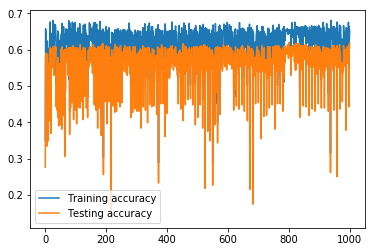

In [21]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

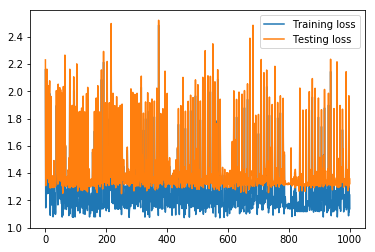

In [22]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()